<a href="https://colab.research.google.com/github/zdulbz/Multiple-Selves/blob/main/DDQN_World.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Configurations for Colab

In [ ]:
# import sys
# IN_COLAB = "google.colab" in sys.modules

# if IN_COLAB:
#     !apt install python-opengl
#     !apt install ffmpeg
#     !apt install xvfb
#     !pip install pyvirtualdisplay
#     !pip install gym
#     from pyvirtualdisplay import Display
    
#     # Start virtual display
#     dis = Display(visible=0, size=(400, 400))
#     dis.start()

# 02. Double DQN

[van Hasselt et al., "Deep Reinforcement Learning with Double Q-learning." arXiv preprint arXiv:1509.06461, 2015.](https://arxiv.org/pdf/1509.06461.pdf)




Let's take a close look at the difference between DQN and Double-DQN. The max operator in standard Q-learning and DQN uses the same values both to select and to evaluate an action. This makes it more likely to select overestimated values, resulting in overoptimistic value estimates.

$$
\theta_{t+1} = \theta_t + \alpha \big(Y_t^Q - Q(S_t, A_t; \theta_t)\big) \cdot \nabla_{\theta_t} Q(S_t, A_t; \theta_t),\\
\text{where } \alpha \text{ is a scalar step size and the target } Y_t^Q \text{is defined as }\\
Y_t^Q = R_{t+1} + \gamma \max_a Q(S_{t+1}, a; \theta_t).
$$

In Double Q-learning ([van Hasselt 2010](https://papers.nips.cc/paper/3964-double-q-learning.pdf)), two value functions are learned by assigning experiences randomly to update one of the two value functions, resulting in two sets of weights, $\theta$ and $\theta'$. For each update, one set of weights is used to determine the greedy policy and the other to determine its value. For a clear comparison, we can untangle the selection and evaluation in Q-learning and rewrite DQN's target as

$$
Y_t^Q = R_{t+1} + \gamma Q(S_{t+1}, \arg\max_a Q(S_{t+1}, a; \theta_t); \theta_t).
$$

The Double Q-learning error can then be written as

$$
Y_t^{DoubleQ} = R_{t+1} + \gamma Q(S_{t+1}, \arg\max_a Q(S_{t+1}, a; \theta_t); \theta_t').
$$

The idea of Double Q-learning is to reduce overestimations by decomposing the max operation in the target into action selection and action evaluation. Although not fully decoupled, the target network in the DQN architecture provides a natural candidate for the second value function, without having to introduce additional networks. In conclusion, the weights of the second network $\theta_t'$ are replaced with the weights of the target network for the evaluation of the current greedy policy. This makes just a small change in calculating the target value of DQN loss.

##### DQN:

```
target = reward + gamma * dqn_target(next_state).max(dim=1, keepdim=True)[0]
```

##### DoubleDQN:

```
selected_action = dqn(next_state).argmax(dim=1, keepdim=True)
target = reward + gamma * dqn_target(next_state).gather(1, selected_action)
```
      

# Imports

In [1]:
import os
from typing import Dict, List, Tuple

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
import copy
from torch.distributions import Categorical
mount = False
plt.rcParams.update({'font.size': 12})


if mount:
  from google.colab import drive
  drive.mount('/content/gdrive')

parent_dir = '/content/gdrive/My Drive/Colab Notebooks/World/'

device = torch.device('cpu')

if(torch.cuda.is_available()): 
    device = torch.device('cuda:0') 
    torch.cuda.empty_cache()
    print("Device set to : " + str(torch.cuda.get_device_name(device)))
else:
    print("Device set to : cpu")

Device set to : Tesla P100-PCIE-16GB


## Replay buffer

Please see *01.dqn.ipynb* for detailed description.

In [2]:
class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(self, obs_dim: int, size: int, batch_size: int = 32):
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0

    def store(
        self,
        obs: np.ndarray,
        act: np.ndarray, 
        rew: float, 
        next_obs: np.ndarray, 
        done: bool,
    ):
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self) -> Dict[str, np.ndarray]:
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)
        return dict(obs=self.obs_buf[idxs],
                    next_obs=self.next_obs_buf[idxs],
                    acts=self.acts_buf[idxs],
                    rews=self.rews_buf[idxs],
                    done=self.done_buf[idxs])

    def __len__(self) -> int:
        return self.size

## Network

We are going to use a simple network architecture with three fully connected layers and two non-linearity functions (ReLU).

In [3]:

class Network(nn.Module):
    def __init__(self, in_dim: int, out_dim: int, view, hidden_dim, blind=False):
        """Initialization."""
        super(Network, self).__init__()
        self.h = hidden_dim
        self.blind = blind
        if self.blind: self.mask = nn.Parameter(0.1 + torch.zeros(1,in_dim)) # This is the mask (it is just an array initialized with all 0.1s)
        self.layers = nn.Sequential(
            nn.Linear(in_dim, self.h), 
            nn.ReLU(),
            nn.Linear(self.h, self.h), 
            nn.ReLU(), 
            nn.Linear(self.h, out_dim)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        if self.blind: x = x * self.mask
        return self.layers(x)


# class WorldFlatNetworkModule(nn.Module):
#     def __init__(self, in_dim, out_dim = 4):
#         """Initialization."""
#         super(WorldFlatNetworkModule, self).__init__()
#         self.h = 512
#         self.feature_dim = out_dim
#         self.layers = nn.Sequential(
#             nn.Linear(in_dim, self.h), 
#             nn.ReLU(),
#             nn.Linear(self.h, self.h), 
#             nn.ReLU(), 
#             nn.Linear(self.h, out_dim),
#             nn.ReLU()
#         )

#     def predict(self, x: torch.Tensor) -> torch.Tensor:
#         """Forward method implementation."""
#         return self.layers(x)

# class WorldFlatNetworkPhi(nn.Module):
#     def __init__(self, in_dim, out_dim = 512):
#         """Initialization."""
#         super(WorldFlatNetworkPhi, self).__init__()
#         self.h = 512
#         self.feature_dim = out_dim
#         self.layers = nn.Sequential(
#             nn.Linear(in_dim, self.h), 
#             nn.ReLU(),
#             nn.Linear(self.h, self.h), 
#             nn.ReLU(), 
#             nn.Linear(self.h, out_dim),
#             nn.ReLU()
#         )

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         """Forward method implementation."""
#         return self.layers(x)



# class Network(nn.Module): # convolutional encoder (takes in an image and outputs a single logit)
#   def __init__(self, channels, action_dim, view_size):
#     super(Network, self).__init__()
#     self.channels = channels
#     self.view_size = view_size
#     self.conv1 = nn.Conv2d(self.channels, 32, 3, padding=1)
#     self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
#     self.fc1 = nn.Linear(32*self.view_size**2, 512)
#     self.fc2 = nn.Linear(512+self.channels, action_dim)
#     self.relu = nn.ReLU()
  
#   def forward(self, state):
#     stats, view = state[:,:self.channels], state[:,self.channels:].view(-1,self.channels,self.view_size,self.view_size)
    
#     x = self.relu(self.conv1(view))
#     x = self.relu(self.conv2(x))
#     x = torch.flatten(x, 1)
#     x = self.relu(self.fc1(x))
#     x = torch.cat([stats,x], dim = 1)
#     x = self.fc2(x)
#     return x

## Double DQN Agent

Here is a summary of DQNAgent class.

| Method           | Note                                                 |
| ---              | ---                                                  |
|select_action     | select an action from the input state.               |
|step              | take an action and return the response of the env.   |
|compute_dqn_loss  | return dqn loss.                                     |
|update_model      | update the model by gradient descent.                |
|target_hard_update| hard update from the local model to the target model.|
|train             | train the agent during num_frames.                   |
|test              | test the agent (1 episode).                          |
|plot              | plot the training progresses.                        |

We use `self.dqn` instead of `self.dqn_target` for action selection.

```

        next_q_value = self.dqn_target(next_state).gather(
            1, self.dqn(next_state).argmax(dim=1, keepdim=True)  # Double DQN
        ).detach()
        mask = 1 - done
        target = (reward + self.gamma * next_q_value * mask).to(self.device)
```

In [4]:

class DQN_Agent:
    """DQN Agent interacting with environment.
    
    Attribute:
        env (gym.Env): openAI Gym environment
        memory (ReplayBuffer): replay memory to store transitions
        batch_size (int): batch size for sampling
        epsilon (float): parameter for epsilon greedy policy
        epsilon_decay (float): step size to decrease epsilon
        max_epsilon (float): max value of epsilon
        min_epsilon (float): min value of epsilon
        target_update (int): period for target model's hard update
        gamma (float): discount factor
        dqn (Network): model to train and select actions
        dqn_target (Network): target model to update
        optimizer (torch.optim): optimizer for training dqn
        transition (list): transition information including 
                           state, action, reward, next_state, done
    """

    def __init__(
        self, 
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        target_update: int,
        epsilon_decay: float,
        max_epsilon: float = 1.0,
        min_epsilon: float = 0.1,
        gamma: float = 0.99,
        lr: float = 0.001,
        hidden_size = 512,
        blind = False,
        switch_episode = 10000,
        norm_rewards = False):
        """Initialization.
        
        Args:
            env (gym.Env): openAI Gym environment
            memory_size (int): length of memory
            batch_size (int): batch size for sampling
            target_update (int): period for target model's hard update
            epsilon_decay (float): step size to decrease epsilon
            lr (float): learning rate
            max_epsilon (float): max value of epsilon
            min_epsilon (float): min value of epsilon
            gamma (float): discount factor
        """
        # obs_dim = env.observation_space.shape[0]

        
        self.env = env
        self.n_statedims = self.env.n_statedims
        self.action_dim = self.env.n_actions
        self.memory = ReplayBuffer(self.n_statedims, memory_size, batch_size)
        self.batch_size = batch_size
        self.epsilon = max_epsilon
        self.epsilon_decay = epsilon_decay
        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.target_update = target_update
        self.gamma = gamma
        self.channels = self.n_statedims #self.env.n_stats # obs_dim
        self.lr = lr
        self.switch_episode = switch_episode
        self.plotting = True
        self.value_map_history = []
        self.q_map_history = []
        self.plotting_interval = 100
        self.is_modular = False
        self.store_value_maps = False
        self.hidden_size = hidden_size
        self.attention_agent = False
        self.clamp_to = 0
        self.updates_per_step = 1
        self.blind = blind
        self.lambd = 0.001
        self.epsilon_reset = self.min_epsilon
        self.nonstationarity = None
        self.q_vals = []
        self.norm_rewards = norm_rewards

        
        # device: cpu / gpu
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print(self.device)

        # networks: dqn, dqn_target
        self.dqn = Network(self.channels, self.action_dim, self.env.view_size, self.hidden_size,blind=self.blind).to(self.device)
        self.dqn_target = Network(self.channels, self.action_dim, self.env.view_size, self.hidden_size,blind=self.blind).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()
        
        # optimizer
        self.optimizer = optim.Adam(self.dqn.parameters(), lr=self.lr)

        # transition to store in memory
        self.transition = list()
        
        # mode: train / test
        self.is_test = False

    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        # epsilon greedy policy
        qs = self.dqn(torch.FloatTensor(state).to(self.device))
        self.q_vals.append(qs[0].detach().cpu().numpy())

        if self.epsilon > np.random.random() and not self.is_test:
            # selected_action = self.env.action_space.sample()
            selected_action = np.random.randint(self.action_dim)
        else:
            selected_action = qs.argmax().detach().cpu().numpy()
            # selected_action = selected_action.detach().cpu().numpy()
        
        if not self.is_test:
            self.transition = [state, selected_action]
        
        return selected_action

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        next_state, reward, done, _ = self.env.step(action)

        if not self.is_test:
            self.transition += [reward, next_state, done]
            self.memory.store(*self.transition)
    
        return next_state, reward, done, _

    def update_model(self) -> torch.Tensor:
        """Update the model by gradient descent."""
        for i in range(self.updates_per_step):
          samples = self.memory.sample_batch()

          loss = self._compute_dqn_loss(samples)

          self.optimizer.zero_grad()
          loss.backward()
          self.optimizer.step()

        return loss.item()
        
    def train(self, num_frames: int):
        """Train the agent."""
        self.is_test = False
        self.cumulative_deviation = 0
        self.maximum_deviation = 0
        
        state = self.env.reset().unsqueeze(0)
        update_cnt = 0
        epsilons = []
        losses = []
        scores = []
        self.rewards = []
        self.stats = []
        score = 0
        self.env.clamp = 0


        for frame_idx in range(1, num_frames + 1):

            if frame_idx >= self.switch_episode: 
              # self.env.change_first_resource_map() # introduces a change in the environment
              # self.epsilon = 1
              if self.nonstationarity == 'jump':
                self.env.stats[-1] = self.clamp_to
                self.env.clamp = 1
                self.epsilon = self.epsilon_reset

              if self.nonstationarity == 'location':
                self.env.change_first_resource_map()
                self.epsilon = self.epsilon_reset

              if self.nonstationarity == 'blank':
                self.env.zero_last_map()
                self.epsilon = self.epsilon_reset


            if self.attention_agent:
              self.current_task = np.argmax(np.abs([s-5 for s in self.env.stats]))
              # torch.cat((state,torch.tensor(self.current_task).float().unsqueeze(0).unsqueeze(0)),1)

            action = self.select_action(state)
            next_state, reward, done, _ = self.step(action)

            state = next_state.unsqueeze(0)
            score += reward

            if self.attention_agent: self.rewards.append(_[self.current_task]) #attention agent
            else: self.rewards.append(reward) #regular agent

            self.stats.append(copy.deepcopy(self.env.stats))


            if self.store_value_maps: self.get_v_map(display=False)

            self.cumulative_deviation += sum([abs(stat - 1) for stat in self.env.stats])
            for stat in self.env.stats:
              if abs(stat) > self.maximum_deviation: self.maximum_deviation = abs(stat)

            # if episode ends
            if done:
                state = self.env.reset().unsqueeze(0)
                scores.append(score)
                score = 0

            # linearly decrease epsilon
            self.epsilon = max(
                self.min_epsilon, self.epsilon - (
                    self.max_epsilon - self.min_epsilon
                ) * self.epsilon_decay
            )
            epsilons.append(self.epsilon)

            # if training is ready
            if len(self.memory) >= self.batch_size:
                loss = self.update_model()
                losses.append(loss)
                update_cnt += 1
                           
                # if hard update is needed
                if update_cnt % self.target_update == 0:
                    self._target_hard_update()

            # plotting
            if frame_idx % self.plotting_interval == 0 and self.plotting:
                self._plot(frame_idx, scores, losses, epsilons)
                self.env.render()
                plt.show()
                
        self.env.close()
                
    def test(self, timesteps = 50, display = False) -> List[np.ndarray]:
        """Test the agent."""
        self.is_test = True
        actions = ['down','up','right','left','eat','drink','rest']
        state = self.env.reset().unsqueeze(0)
        done = False
        score = 0
        t = 0
        cumulative_deviation = 0
        maximum_deviation = 0
        
        frames = []
        while t < timesteps:
            t+=1
            # frames.append(self.env.render())
            action = self.select_action(state)
            next_state, reward, done, info = self.step(action)
            if display:
              print('Timestep:', t, 
                    ', reward:', np.round(reward,3), 
                    ', modular reward:', np.round(np.array(info),3), 
                    ', Action: ',actions[action],
                    ', stats: ', np.round(self.env.stats,2), 
                    ', Dead?: ', self.env.dead,
                    ', Lowest: ', np.round(self.env.lowest_stat,2))
              self.env.render()
              plt.show()



            state = next_state.unsqueeze(0)
            score += reward

            cumulative_deviation += sum([abs(stat - 1) for stat in env.stats])
            for stat in env.stats:
              if abs(stat) > maximum_deviation: maximum_deviation = abs(stat)
        
        print("score: ", score)
        self.env.close()
        
        return score, cumulative_deviation, maximum_deviation

    def _compute_dqn_loss(self, samples: Dict[str, np.ndarray]) -> torch.Tensor:
        """Return dqn loss."""
        device = self.device  # for shortening the following lines
        state = torch.FloatTensor(samples["obs"]).to(device)
        next_state = torch.FloatTensor(samples["next_obs"]).to(device)
        action = torch.LongTensor(samples["acts"].reshape(-1, 1)).to(device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)

        if self.norm_rewards:
          reward = (reward - reward.mean()) / (reward.std()+ 1e-10)
        
        # G_t   = r + gamma * v(s_{t+1})  if state != Terminal
        #       = r                       otherwise
        curr_q_value = self.dqn(state).gather(1, action)


        next_q_value = self.dqn_target(next_state).gather(  # Double DQN
            1, self.dqn(next_state).argmax(dim=1, keepdim=True)
        ).detach()

        # next_q_value = self.dqn_target(
        #     next_state
        # ).max(dim=1, keepdim=True)[0].detach()


        mask = 1 - done
        target = (reward + self.gamma * next_q_value * mask).to(self.device)

        # calculate dqn loss
        if self.blind:
            L1_loss = self.lambd*torch.sum(torch.abs(self.dqn.mask)) # this is the 'penalty' for having numbers other than 0
            loss = F.smooth_l1_loss(curr_q_value, target) + L1_loss
        else:
          loss = F.smooth_l1_loss(curr_q_value, target)

        return loss
    
    def _target_hard_update(self):
        """Hard update: target <- local."""
        self.dqn_target.load_state_dict(self.dqn.state_dict())

    def get_q_map(self, stats_force = None, display=True):
      q_all = np.zeros((self.action_dim,self.env.size,self.env.size))

      move_back_loc = copy.copy(self.env.loc)
      actions = ['down','up','right','left']
      ## will take environment and agent as parameters
      for i in range(1,self.env.size-1):
        for j in range(1,self.env.size-1):

          self.env.move_location([i,j])
          state = self.env.get_state()
          if stats_force is not None: state[:self.env.n_stats] = stats_force
          with torch.no_grad():
            q_vals = self.dqn(torch.FloatTensor(state).to(self.device)).detach().cpu().numpy()
          # q_vals = (q_vals - np.min(q_vals))/(np.max(q_vals)-np.min(q_vals)) # normalizing step
          q_vals= (q_vals==np.max(q_vals)).astype(int) # sets top q-value to 1
          q_all[:,i,j] = q_vals

      self.env.move_location(move_back_loc)

      if display:
        fig, axes = plt.subplots(1,self.action_dim,figsize=(8,2))
        for i, ax in enumerate(axes):
          ax.imshow(q_all[i])
          ax.set_title(f'Q-{actions[i]}')
        plt.show()

      if not display:
        self.q_map_history.append(q_all)

    def get_v_map(self, stats_force = None,display = True):
      v_map = np.zeros((self.env.size,self.env.size))

      move_back_loc = copy.copy(self.env.loc)
      ## will take environment and agent as parameters
      for i in range(1,self.env.size-1):
        for j in range(1,self.env.size-1):

          self.env.move_location([i,j])
          state = self.env.get_state()
          if stats_force is not None: state[:self.env.n_stats] = stats_force
          with torch.no_grad():
            q_vals = self.dqn(torch.FloatTensor(state).to(self.device)).detach().cpu().numpy()
          # q_vals = (q_vals - np.min(q_vals))/(np.max(q_vals)-np.min(q_vals)) # normalizing step
          v_map[i,j] = np.max(q_vals)

      self.env.move_location(move_back_loc)

      if display:
        self.display_grid_with_text(v_map[1:-1,1:-1])
        # fig, ax = plt.subplots(figsize=(5,5))
        # ax.imshow(v_map[1:-1,1:-1])
        # plt.show()

      if not display:
        self.value_map_history.append(v_map[1:-1,1:-1])

    def display_grid_with_text(self,grid):
      grid = np.round(grid,2)
      fig,ax = plt.subplots(figsize=(8,8))
      ax.imshow(grid)
      for (j,i),label in np.ndenumerate(grid):
          ax.text(i,j,label,ha='center',va='center',fontsize=12,fontweight='bold',color='r')
          ax.set_yticks([])
          ax.set_xticks([])
      plt.show()

    def _plot(
        self, 
        frame_idx: int, 
        scores: List[float], 
        losses: List[float], 
        epsilons: List[float],
    ):
        """Plot the training progresses."""
        clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.subplot(141)
        plt.title('frame %s. score: %s' % (frame_idx, np.mean(scores[-10:])))
        plt.plot(self.rewards)
        # plt.ylim(-5,10)
        # plt.subplot(142)
        # plt.title(f'loss, stats: {np.round(self.env.stats,2)}')
        # plt.plot(losses)

        plt.subplot(142)
        plt.title('epsilons')
        plt.plot(epsilons)

        plt.subplot(143)
        plt.title('stats')
        plt.plot(self.stats)
        plt.ylim([-10,10])
        plt.legend([f'stat {i+1}: {np.round(self.env.stats[i],2)}' for i in range(self.env.n_stats)])
        plt.xlabel('Time step')
        plt.ylabel('Stat levels')

        plt.subplot(144)
        plt.title('stats')
        plt.plot(self.q_vals)
        plt.ylim([-10,10])
        plt.legend([f'$Q_{i+1}$' for i in range(self.env.n_stats)])
        plt.xlabel('Time step')
        plt.ylabel('Q-values')

        plt.show()
        if self.blind:
          plt.figure()
          plt.plot(np.array(self.dqn.mask[0].detach().cpu().numpy()))
          plt.show()
        self.get_v_map()

#### random agent #####


# def test_random_agent(env, timesteps = 50):
#         state = env.reset().unsqueeze(0)
#         score = 0
#         t = 0

#         while t < timesteps:
#             action = env.action_space.sample()
#             next_state, reward, done, info = self.step(action)
#             state = next_state.unsqueeze(0)
#             score += reward
#             t+=1

#         return score

## Modular DQN

In [5]:
class Modular_DQN_Agent:
    """DQN Agent interacting with environment.
    
    Attribute:
        env (gym.Env): openAI Gym environment
        memory (ReplayBuffer): replay memory to store transitions
        batch_size (int): batch size for sampling
        epsilon (float): parameter for epsilon greedy policy
        epsilon_decay (float): step size to decrease epsilon
        max_epsilon (float): max value of epsilon
        min_epsilon (float): min value of epsilon
        target_update (int): period for target model's hard update
        gamma (float): discount factor
        dqn (Network): model to train and select actions
        dqn_target (Network): target model to update
        optimizer (torch.optim): optimizer for training dqn
        transition (list): transition information including 
                           state, action, reward, next_state, done
    """

    def __init__(
        self, 
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        target_update: int,
        epsilon_decay: float,
        max_epsilon: float = 1.0,
        min_epsilon: float = 0.1,
        gamma: float = 0.99,
        lr: float = 0.001, 
        explore = 1000,
        arbitrator_lr = 1e-3,
        hidden_size = 512,
        decision_process = 'gmQ',
        blind = False,
        switch_episode = 10000, 
        lr_actor = 0.003,
        lr_critic = 0.01,
        PPO_gamma = 0.99,
        K_epochs = 30,
        eps_clip = 0.2,
        action_std = 0.6,
        action_std_decay_rate = 0.05,
        min_action_std = 0.02,
        start_control = 0,
        norm_rewards = True):
        """Initialization.
        
        Args:
            env (gym.Env): openAI Gym environment
            memory_size (int): length of memory
            batch_size (int): batch size for sampling
            target_update (int): period for target model's hard update
            epsilon_decay (float): step size to decrease epsilon
            lr (float): learning rate
            max_epsilon (float): max value of epsilon
            min_epsilon (float): min value of epsilon
            gamma (float): discount factor
        """
        # obs_dim = env.observation_space.shape[0]
        
        self.env = env
        self.n_statedims = self.env.n_statedims
        self.action_dim = self.env.n_actions
        self.numModules = env.n_stats
        self.memories = [ReplayBuffer(self.n_statedims, memory_size, batch_size) for i in range(self.numModules)]
        self.batch_size = batch_size
        self.epsilon = max_epsilon
        self.epsilon_decay = epsilon_decay
        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.target_update = target_update
        self.gamma = gamma
        self.channels = self.n_statedims #self.env.n_stats # obs_dim
        self.lr = lr
        self.arbitrator_lr = arbitrator_lr
        self.current_module = 0
        self.explore_until = explore
        self.switch_episode = switch_episode
        self.plotting = True
        self.plotting_interval = 100
        self.value_map_history = []
        self.is_modular = True
        self.store_value_maps = False
        self.hidden_size = hidden_size
        self.decision_process = decision_process
        self.blind = blind
        self.lambd = 0.01
        self.clamp_to = 0
        self.epsilon_reset = self.min_epsilon
        self.nonstationarity = None
        self.norm_rewards = norm_rewards
        # for PPO arbitrator
        self.has_continuous_action_space = True
        self.control_weights = []
        self.weighted_qs = []
        self.unweighted_qs = []

        # device: cpu / gpu
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print(self.device)

        # networks: dqn, dqn_target
        self.modules = [Network(self.channels, self.action_dim, self.env.view_size, self.hidden_size, blind = self.blind).to(self.device) for i in range(self.numModules)]
        self.targets = [Network(self.channels, self.action_dim, self.env.view_size, self.hidden_size, blind = self.blind).to(self.device) for i in range(self.numModules)]
        # self.arbitrator = arbitrator_ceo(obs_dim, self.numModules, self.arbitrator_lr).to(self.device)
        # self.arbitrator = arbitrator_ceo(self.numModules, self.action_dim, self.arbitrator_lr).to(self.device)

        ## PPO Arbitrator ##
        self.lr_actor = lr_actor
        self.lr_critic = lr_critic
        self.PPO_gamma = PPO_gamma
        self.K_epochs = K_epochs
        self.eps_clip = eps_clip 
        self.action_std = action_std
        self.action_std_decay_rate = action_std_decay_rate
        self.min_action_std = min_action_std
        self.start_control = start_control
        self.arbitrator = PPO(self.numModules, self.action_dim, self.lr_actor, self.lr_critic, self.PPO_gamma, self.K_epochs, self.eps_clip, self.has_continuous_action_space, self.action_std)
        ## PPO Arbitrator ##

        for i in range(self.numModules):
          self.targets[i].load_state_dict(self.modules[i].state_dict()) 
          self.targets[i].eval() 
        
        # optimizer
        self.optimizers = [optim.Adam(modules.parameters(), lr=self.lr) for modules in self.modules]

        # transition to store in memory
        self.transition = list()
        
        # mode: train / test
        self.is_test = False



    def select_action(self, state: np.ndarray, frame) -> np.ndarray:
        """Select an action from the input state."""
        # modular policy
        # if frame % 7 == 0: self.current_module +=1
        # if self.current_module > self.numModules - 1: self.current_module = 0
        m = nn.Softmax(dim=0)

        prepared_state = torch.FloatTensor(state).to(self.device)

        if self.epsilon > np.random.random() and not self.is_test and not self.decision_process == 'PPO_arbitrator':
            # selected_action = self.env.action_space.sample()
            selected_action = np.random.randint(self.action_dim)
        else:
          if self.decision_process == 'allQ':
            ModuleQValues = np.array([self.modules[i](prepared_state).detach().cpu().numpy() for i in range(self.numModules)])
            ind = np.unravel_index(np.argmax(ModuleQValues, axis=None), ModuleQValues.shape)
            selected_action = ind[-1]
          # meanQs = np.sum(ModuleQValues,axis=1)
          # unhappy_module = np.argmin(meanQs)
          # finalQValues = ModuleQValues[unhappy_module] #unhappy takes control
          if self.decision_process == 'gmQ':
            finalQValues = sum(self.modules[i](prepared_state) for i in range(self.numModules)) ## This is GmQ
            # finalQValues = sum(self.modules[i](prepared_state)/torch.max(self.modules[i](prepared_state)) for i in range(self.numModules)) # centered GmQ
            # finalQValues = sum(m(self.modules[i](prepared_state)) for i in range(self.numModules)) ## pre-softmax to avoid domination
            selected_action = finalQValues.argmax().detach().cpu().numpy()

          if self.decision_process == 'variance':
            ModuleQValues = [self.modules[i](prepared_state).detach().cpu().numpy() for i in range(self.numModules)]
            variances = [np.var(qvals) for qvals in ModuleQValues]
            ind = np.argmax(variances)
            selected_action = ModuleQValues[ind].argmax()

          if self.decision_process == 'voting':
            action_slots = np.zeros(4)
            ModuleQValues = [self.modules[i](prepared_state).detach().cpu().numpy() for i in range(self.numModules)]
            ModuleActions = [np.argmax(qvals) for qvals in ModuleQValues]
            variances = [np.var(qvals) for qvals in ModuleQValues]
            for i in range(self.numModules):
              action_slots[ModuleActions[i]] += variances [i]
            ind = np.argmax(action_slots)
            selected_action = ModuleQValues[ind].argmax()

          if self.decision_process == 'max_abs':
            ModuleQValues = [self.modules[i](prepared_state).detach().cpu().numpy() for i in range(self.numModules)]
            max_abs = [np.sum(np.abs(qvals)) for qvals in ModuleQValues]
            ind = np.argmax(max_abs)
            selected_action = ModuleQValues[ind].argmax()

          if self.decision_process == 'CEO':
            probs = self.arbitrator(prepared_state[:,:self.numModules]) # this is arbiQ
            m = Categorical(probs)
            arb_action = m.sample()
            action = torch.argmax(probs)
            self.arbitrator.saved_log_probs.append(m.log_prob(arb_action))
            finalQValues = self.modules[arb_action.item()](prepared_state)
            selected_action = finalQValues.argmax().detach().cpu().numpy()

          if self.decision_process == 'PPO_arbitrator':
            weights = self.arbitrator.select_action(state[:,:self.numModules])
            if frame < self.start_control: weights = np.ones(self.numModules)
            finalQValues = sum(weights[i]*self.modules[i](prepared_state) for i in range(self.numModules)) ## This is GmQ
            unweightedQValues = sum(self.modules[i](prepared_state) for i in range(self.numModules)) ## This is GmQ
            selected_action = finalQValues.argmax().detach().cpu().numpy()
            self.control_weights.append(np.round(weights,3))
            self.weighted_qs.append(finalQValues[0].detach().cpu().numpy())
            self.unweighted_qs.append(unweightedQValues[0].detach().cpu().numpy())


        # if frame < self.explore_until:
        #   selected_action = np.random.randint(0, self.action_dim)

        
        if not self.is_test:
            self.transition = [state, selected_action]
        
        return selected_action

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        next_state, reward, done, sep_rewards = self.env.step(action)

        if not self.is_test:
            for i in range(self.numModules):
              transition = self.transition + [sep_rewards[i], next_state, done]
              self.memories[i].store(*transition)
    
        return next_state, reward, done, sep_rewards

    def update_model(self) -> torch.Tensor:
        """Update the model by gradient descent."""

        losses = self._compute_dqn_loss()
        for i in range(self.numModules):

          self.optimizers[i].zero_grad()
          losses[i].backward()
          self.optimizers[i].step()

        return losses
        
    def train(self, num_frames: int):
        """Train the agent."""
        self.is_test = False
        self.cumulative_deviation = 0
        self.maximum_deviation = 0
        
        state = self.env.reset().unsqueeze(0)
        update_cnt = 0
        epsilons = []
        losses = []
        scores = []
        self.rewards = []
        self.mod_rewards = []
        self.stats = []
        score = 0
        self.env.clamp = 0

        for frame_idx in range(1, num_frames + 1):

            if frame_idx > self.switch_episode: 
              

              if self.nonstationarity == 'jump':
                self.env.stats[-1] = self.clamp_to
                self.env.clamp = 1
                self.epsilon = self.epsilon_reset

              if self.nonstationarity == 'location':
                self.env.change_first_resource_map()
                self.epsilon = self.epsilon_reset

              if self.nonstationarity == 'blank':
                self.env.zero_last_map()
                self.epsilon = self.epsilon_reset

            action = self.select_action(state,frame_idx)
            next_state, reward, done, mod_rewards = self.step(action)

            if self.decision_process == 'CEO':
              self.arbitrator.rewards.append(reward)

            if self.decision_process == 'PPO_arbitrator': 
              self.arbitrator.buffer.rewards.append(reward)
              self.arbitrator.buffer.is_terminals.append(done)

            state = next_state.unsqueeze(0)
            score += reward
            self.rewards.append(reward)
            self.mod_rewards.append(mod_rewards)
            self.stats.append(copy.deepcopy(self.env.stats))


            if self.store_value_maps: self.get_v_map(display=False) # and 9950 < frame_idx < 10200: self.get_v_map(display=False)


            self.cumulative_deviation += sum([abs(stat - 1) for stat in self.env.stats])
            for stat in self.env.stats:
              if abs(stat) > self.maximum_deviation: self.maximum_deviation = abs(stat)
            # if episode ends
            if done:
                state = self.env.reset().unsqueeze(0)
                scores.append(score)
                score = 0
                if self.decision_process == 'CEO':
                  self.arbitrator.update(self.device)
                if self.decision_process == 'PPO_arbitrator' and frame_idx > self.start_control:
                  self.arbitrator.update()
                   # if continuous action space; then decay action std of ouput action distribution
                  self.arbitrator.decay_action_std(self.action_std_decay_rate, self.min_action_std)

            # linearly decrease epsilon
            self.epsilon = max(
                self.min_epsilon, self.epsilon - (
                    self.max_epsilon - self.min_epsilon
                ) * self.epsilon_decay
            )
            epsilons.append(self.epsilon)

            # if training is ready
            if len(self.memories[0]) >= self.batch_size:
                loss = self.update_model()
                losses.append(loss)
                update_cnt += 1
                
                
                # if hard update is needed
                if update_cnt % self.target_update == 0:
                    self._target_hard_update()

            # plotting
            if frame_idx % self.plotting_interval == 0 and self.plotting:
                self._plot(frame_idx, scores, losses, epsilons)
                self.env.render()
                plt.show()

                
        self.env.close()
                
    def test(self, timesteps = 50,display = False) -> List[np.ndarray]:
        """Test the agent."""
        self.is_test = True
        actions = ['down','up','right','left','eat','drink','rest']
        state = self.env.reset().unsqueeze(0)
        done = False
        score = 0
        t = 0
        cumulative_deviation = 0
        maximum_deviation = 0
        
        frames = []
        while t < timesteps:
            t+=1
            # frames.append(self.env.render())
            action = self.select_action(state,t)
            next_state, reward, done, info = self.step(action)

            if display:
              print('Timestep:', t, 
                    ', reward:', np.round(reward,3), 
                    ', modular reward:', np.round(np.array(info),3), 
                    ', Action: ',actions[action],
                    ', stats: ', np.round(self.env.stats,2), 
                    ', Dead?: ', self.env.dead,
                    ', Lowest: ', np.round(self.env.lowest_stat,2))
              self.env.render()
              plt.show()


            state = next_state.unsqueeze(0)
            score += reward

            cumulative_deviation += sum([abs(stat - 1) for stat in env.stats])
            for stat in env.stats:
              if abs(stat) > maximum_deviation: maximum_deviation = abs(stat)
        
        print("score: ", score)
        self.env.close()
        
        return score, cumulative_deviation, maximum_deviation

    def _compute_dqn_loss(self) -> torch.Tensor:
        """Return dqn loss."""
        losses = []
        for i in range(self.numModules):
          samples = self.memories[i].sample_batch()
          device = self.device  # for shortening the following lines
          state = torch.FloatTensor(samples["obs"]).to(device)
          next_state = torch.FloatTensor(samples["next_obs"]).to(device)
          action = torch.LongTensor(samples["acts"].reshape(-1, 1)).to(device)
          reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
          done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)

          if self.norm_rewards:
            # reward /= reward.abs().max()
            reward = (reward - reward.mean()) / (reward.std()+ 1e-10)
          
          # G_t   = r + gamma * v(s_{t+1})  if state != Terminal
          #       = r                       otherwise
          curr_q_value = self.modules[i](state).gather(1, action)
          next_q_value = self.targets[i](next_state).gather(  # Double DQN
              1, self.modules[i](next_state).argmax(dim=1, keepdim=True)
          ).detach()
          mask = 1 - done
          target = (reward + self.gamma * next_q_value * mask).to(self.device)

          # calculate dqn loss

          # calculate loss and update weights
          if self.blind:
            L1_loss = self.lambd*torch.sum(torch.abs(self.modules[i].mask)) # this is the 'penalty' for having numbers other than 0
            loss = F.smooth_l1_loss(curr_q_value, target) + L1_loss
            losses.append(loss)

          else:
            loss = F.smooth_l1_loss(curr_q_value, target)
            losses.append(loss)

        return losses
    
    def _target_hard_update(self):
        """Hard update: target <- local."""
        for i in range(self.numModules):
          self.targets[i].load_state_dict(self.modules[i].state_dict())


    def display_q_map(self, stats_force = None):
      q_all = np.zeros((self.numModules,self.action_dim,self.env.size,self.env.size))
      move_back_loc = copy.copy(self.env.loc)
      actions = ['down','up','right','left']
      ## will take environment and agent as parameters
      for module in range(self.numModules):
        for i in range(1,self.env.size-1):
          for j in range(1,self.env.size-1):

            self.env.move_location([i,j])
            state = self.env.get_state()
            if stats_force is not None: state[:self.env.n_stats] = stats_force
            with torch.no_grad():
              q_vals = self.modules[module](torch.FloatTensor(state).to(self.device)).detach().cpu().numpy()
            # q_vals = (q_vals - np.min(q_vals))/(np.max(q_vals)-np.min(q_vals)) #normalizing step
            q_vals= (q_vals==np.max(q_vals)).astype(int) # sets top q-value to 1
            q_all[module,:,i,j] = q_vals

        fig, axes = plt.subplots(1,self.action_dim,figsize=(8,2))
        for i, ax in enumerate(axes):
          ax.imshow(q_all[module,i,:,:])
          ax.set_title(f'Q-{actions[i]}')
        plt.show()

      self.env.move_location(move_back_loc)

    def get_v_map(self, stats_force = None, display=True):
      v_map = np.empty((self.numModules,self.env.size,self.env.size))
      move_back_loc = copy.copy(self.env.loc)
      ## will take environment and agent as parameters
      for module in range(self.numModules):
        for i in range(1,self.env.size-1):
          for j in range(1,self.env.size-1):

            self.env.move_location([i,j])
            state = self.env.get_state()
            if stats_force is not None: state[:self.env.n_stats] = stats_force
            with torch.no_grad():
              q_vals = self.modules[module](torch.FloatTensor(state).to(self.device)).detach().cpu().numpy()
            v_map[module,i,j] = np.max(q_vals)

      if display:
        fig, axes = plt.subplots(1,self.numModules,figsize=(20,20))
        if self.numModules > 1:
          for i, ax in enumerate(axes):
            self.display_grid_with_text(v_map[i,1:-1,1:-1],ax)
            ax.set_title(f'Module {i+1}')
            # ax.imshow(v_map[i,1:-1,1:-1])
        else: self.display_grid_with_text(v_map[0,1:-1,1:-1],axes)
        plt.show()

      if not display:
        self.value_map_history.append(v_map[:,1:-1,1:-1])

      self.env.move_location(move_back_loc)

    def display_grid_with_text(self,grid,ax):
      grid = np.round(grid,2)
      # fig,ax = plt.subplots(figsize=(8,8))
      ax.imshow(grid)
      for (j,i),label in np.ndenumerate(grid):
          ax.text(i,j,label,ha='center',va='center',fontsize=10,fontweight='bold',color='r')
          ax.set_yticks([])
          ax.set_xticks([])
                
    def _plot(
        self, 
        frame_idx: int, 
        scores: List[float], 
        losses: List[float], 
        epsilons: List[float],
    ):
        """Plot the training progresses."""
        clear_output(True)
        plt.figure(figsize=(30, 5))
        plt.subplot(151)
        plt.title('frame %s. score: %s' % (frame_idx, np.mean(scores[-10:])))
        # plt.plot(scores)
        # plt.plot(self.rewards)
        plt.plot(self.mod_rewards)
        # plt.ylim(-5,10)
        plt.subplot(152)
        plt.title('stats')
        plt.plot(self.stats)
        plt.ylim([-10,10])
        plt.legend([f'stat {i+1}: {np.round(self.env.stats[i],2)}' for i in range(self.env.n_stats)])
        plt.xlabel('Time step')
        plt.ylabel('Stat levels')

        if self.decision_process == 'PPO_arbitrator':
          plt.subplot(153)
          plt.title('Control weights')
          plt.plot(self.control_weights)
          # plt.ylim([-10,10])
          plt.legend([f'weight {i+1}: {np.round(self.control_weights[-1][i],3)}' for i in range(self.env.n_stats)])
          plt.xlabel('Time step')
          plt.ylabel('weight magnitude')

          plt.subplot(154)
          plt.title('Weighted Q-values')
          plt.plot(self.weighted_qs)
          # plt.ylim([-10,10])
          plt.legend([f'$Q_{i+1}$: {np.round(self.weighted_qs[-1][i],3)}' for i in range(self.env.n_stats)])
          plt.xlabel('Time step')
          plt.ylabel('Q-value')

          plt.subplot(155)
          plt.title('Unweighted Q-values')
          plt.plot(self.unweighted_qs)
          # plt.ylim([-10,10])
          plt.legend([f'$Q_{i+1}$: {np.round(self.unweighted_qs[-1][i],3)}' for i in range(self.env.n_stats)])
          plt.xlabel('Time step')
          plt.ylabel('Q-value')

        self.get_v_map()
        plt.show()
        if self.blind:
          plt.figure()
          plt.plot(np.array([x.mask[0].detach().cpu().numpy() for x in self.modules]).T)
          plt.show()
        # plt.subplot(132)
        # plt.title('loss')
        # plt.plot(losses[0])


## Random Agent

In [6]:
def test_random_agent(env, timesteps = 30000, plotting = False):
        env.reset_for_new_agent()
        state = env.reset().unsqueeze(0)
        score = 0
        t = 0
        cumulative_deviation = 0
        maximum_deviation = 0
        stats = []
        
        if plotting:
          fig,ax = plt.subplots()

        while t < timesteps:
            
            action = np.random.randint(env.n_actions) 
            next_state, reward, done, info = env.step(action)
            state = next_state.unsqueeze(0)
            score += reward
            t+=1
            stats.append(copy.deepcopy(env.stats))

            cumulative_deviation += sum([abs(stat - 5) for stat in env.stats])
            for stat in env.stats:
              if abs(stat) > maximum_deviation: maximum_deviation = abs(stat)

            if plotting:
              # env.render()
              plt.plot(stats)
              plt.show()


        return score, cumulative_deviation, maximum_deviation, stats

## PPO

In [7]:


############################### Import libraries ###############################


import os
import glob
import time
from datetime import datetime

import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal
from torch.distributions import Categorical

import numpy as np

# import gym
# import roboschool
# import pybullet_envs


################################## set device ##################################

print("============================================================================================")


# set device to cpu or cuda
device = torch.device('cpu')

if(torch.cuda.is_available()): 
    device = torch.device('cuda:0') 
    torch.cuda.empty_cache()
    print("Device set to : " + str(torch.cuda.get_device_name(device)))
else:
    print("Device set to : cpu")
    
print("============================================================================================")




################################## PPO Policy ##################################


class RolloutBuffer:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []
    

    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]


class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, has_continuous_action_space, action_std_init):
        super(ActorCritic, self).__init__()

        self.has_continuous_action_space = has_continuous_action_space

        if has_continuous_action_space:
            self.action_dim = action_dim
            self.action_var = torch.full((action_dim,), action_std_init * action_std_init).to(device)

        # actor
        if has_continuous_action_space :
            self.actor = nn.Sequential(
                            nn.Linear(state_dim, 64),
                            nn.Tanh(),
                            nn.Linear(64, 64),
                            nn.Tanh(),
                            nn.Linear(64, action_dim),
                            nn.Sigmoid() # changed from tanh for pos weights
                        )
        else:
            self.actor = nn.Sequential(
                            nn.Linear(state_dim, 64),
                            nn.Tanh(),
                            nn.Linear(64, 64),
                            nn.Tanh(),
                            nn.Linear(64, action_dim),
                            nn.Softmax(dim=-1)
                        )

        
        # critic
        self.critic = nn.Sequential(
                        nn.Linear(state_dim, 64),
                        nn.Tanh(),
                        nn.Linear(64, 64),
                        nn.Tanh(),
                        nn.Linear(64, 1)
                    )
        
    def set_action_std(self, new_action_std):

        if self.has_continuous_action_space:
            self.action_var = torch.full((self.action_dim,), new_action_std * new_action_std).to(device)
        else:
            print("--------------------------------------------------------------------------------------------")
            print("WARNING : Calling ActorCritic::set_action_std() on discrete action space policy")
            print("--------------------------------------------------------------------------------------------")


    def forward(self):
        raise NotImplementedError
    

    def act(self, state):

        if self.has_continuous_action_space:
            action_mean = self.actor(state)
            cov_mat = torch.diag(self.action_var).unsqueeze(dim=0)
            dist = MultivariateNormal(action_mean, cov_mat.float())
        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)

        action = dist.sample()
        action_logprob = dist.log_prob(action)
        
        return action.detach(), action_logprob.detach()
    

    def evaluate(self, state, action):

        if self.has_continuous_action_space:
            action_mean = self.actor(state)
            action_var = self.action_var.expand_as(action_mean)
            cov_mat = torch.diag_embed(action_var).to(device)
            dist = MultivariateNormal(action_mean, cov_mat.float())
            
            # for single action continuous environments
            if self.action_dim == 1:
                action = action.reshape(-1, self.action_dim)

        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)

        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_values = self.critic(state)
        
        return action_logprobs, state_values, dist_entropy


class PPO:
    def __init__(self, state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std_init=0.6):

        self.has_continuous_action_space = has_continuous_action_space

        if has_continuous_action_space:
            self.action_std = action_std_init

        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        
        self.buffer = RolloutBuffer()

        self.policy = ActorCritic(state_dim, action_dim, has_continuous_action_space, action_std_init).to(device)
        self.optimizer = torch.optim.Adam([
                        {'params': self.policy.actor.parameters(), 'lr': lr_actor},
                        {'params': self.policy.critic.parameters(), 'lr': lr_critic}
                    ])

        self.policy_old = ActorCritic(state_dim, action_dim, has_continuous_action_space, action_std_init).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        self.MseLoss = nn.MSELoss()


    def set_action_std(self, new_action_std):
        
        if self.has_continuous_action_space:
            self.action_std = new_action_std
            self.policy.set_action_std(new_action_std)
            self.policy_old.set_action_std(new_action_std)
        
        else:
            print("--------------------------------------------------------------------------------------------")
            print("WARNING : Calling PPO::set_action_std() on discrete action space policy")
            print("--------------------------------------------------------------------------------------------")


    def decay_action_std(self, action_std_decay_rate, min_action_std):
        print("--------------------------------------------------------------------------------------------")

        if self.has_continuous_action_space:
            self.action_std = self.action_std - action_std_decay_rate
            self.action_std = round(self.action_std, 4)
            if (self.action_std <= min_action_std):
                self.action_std = min_action_std
                print("setting actor output action_std to min_action_std : ", self.action_std)
            else:
                print("setting actor output action_std to : ", self.action_std)
            self.set_action_std(self.action_std)

        else:
            print("WARNING : Calling PPO::decay_action_std() on discrete action space policy")

        print("--------------------------------------------------------------------------------------------")


    def select_action(self, state):

        if self.has_continuous_action_space:
            with torch.no_grad():
                state = torch.FloatTensor(state).to(device)
                action, action_logprob = self.policy_old.act(state)

            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)

            return action.detach().cpu().numpy().flatten()

        else:
            with torch.no_grad():
                state = torch.FloatTensor(state).to(device)
                action, action_logprob = self.policy_old.act(state)
            
            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)

            return action.item()


    def update(self):

        # Monte Carlo estimate of returns
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(self.buffer.rewards), reversed(self.buffer.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
            
        # Normalizing the rewards
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        # convert list to tensor
        old_states = torch.squeeze(torch.stack(self.buffer.states, dim=0)).detach().to(device)
        old_actions = torch.squeeze(torch.stack(self.buffer.actions, dim=0)).detach().to(device)
        old_logprobs = torch.squeeze(torch.stack(self.buffer.logprobs, dim=0)).detach().to(device)

        
        # Optimize policy for K epochs
        for _ in range(self.K_epochs):

            # Evaluating old actions and values
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)

            # match state_values tensor dimensions with rewards tensor
            state_values = torch.squeeze(state_values)
            
            # Finding the ratio (pi_theta / pi_theta__old)
            ratios = torch.exp(logprobs - old_logprobs.detach())

            # Finding Surrogate Loss
            advantages = rewards - state_values.detach()   
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages

            # final loss of clipped objective PPO
            loss = -torch.min(surr1, surr2) + 0.5*self.MseLoss(state_values, rewards) - 0.01*dist_entropy
            
            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
            
        # Copy new weights into old policy
        self.policy_old.load_state_dict(self.policy.state_dict())

        # clear buffer
        self.buffer.clear()
    
    
    def save(self, checkpoint_path):
        torch.save(self.policy_old.state_dict(), checkpoint_path)
   

    def load(self, checkpoint_path):
        self.policy_old.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        self.policy.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        
        
       



Device set to : Tesla P100-PCIE-16GB


## SAC

In [8]:
import numpy as np
import torch
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class RandomBuffer(object):
	def __init__(self, state_dim, action_dim, Env_with_dead , max_size=int(1e6)):
		self.max_size = max_size
		self.ptr = 0
		self.size = 0
		self.Env_with_dead = Env_with_dead

		self.state = np.zeros((max_size, state_dim))
		self.action = np.zeros((max_size, action_dim))
		self.reward = np.zeros((max_size, 1))
		self.next_state = np.zeros((max_size, state_dim))
		self.dead = np.zeros((max_size, 1),dtype=np.uint8)

		self.device = device


	def add(self, state, action, reward, next_state, dead):
		self.state[self.ptr] = state
		self.action[self.ptr] = action
		self.reward[self.ptr] = reward
		self.next_state[self.ptr] = next_state
		# it is important to distinguish between dead and done!!!
		# See https://zhuanlan.zhihu.com/p/409553262 for better understanding.
		if self.Env_with_dead:
			self.dead[self.ptr] = dead
		else:
			self.dead[self.ptr] = False

		self.ptr = (self.ptr + 1) % self.max_size
		self.size = min(self.size + 1, self.max_size)


	def sample(self, batch_size):
		ind = np.random.randint(0, self.size, size=batch_size)
		with torch.no_grad():
			return (
				torch.FloatTensor(self.state[ind]).to(self.device),
				torch.FloatTensor(self.action[ind]).to(self.device),
				torch.FloatTensor(self.reward[ind]).to(self.device),
				torch.FloatTensor(self.next_state[ind]).to(self.device),
				torch.FloatTensor(self.dead[ind]).to(self.device)
			)

	def save(self):
		'''save the replay buffer if you want'''
		scaller = np.array([self.max_size,self.ptr,self.size,self.Env_with_dead],dtype=np.uint32)
		np.save("buffer/scaller.npy",scaller)
		np.save("buffer/state.npy", self.state)
		np.save("buffer/action.npy", self.action)
		np.save("buffer/reward.npy", self.reward)
		np.save("buffer/next_state.npy", self.next_state)
		np.save("buffer/dead.npy", self.dead)

	def load(self):
		scaller = np.load("buffer/scaller.npy")

		self.max_size = scaller[0]
		self.ptr = scaller[1]
		self.size = scaller[2]
		self.Env_with_dead = scaller[3]

		self.state = np.load("buffer/state.npy")
		self.action = np.load("buffer/action.npy")
		self.reward = np.load("buffer/reward.npy")
		self.next_state = np.load("buffer/next_state.npy")
		self.dead = np.load("buffer/dead.npy")

import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import math

def build_net(layer_shape, activation, output_activation):
	'''Build net with for loop'''
	layers = []
	for j in range(len(layer_shape)-1):
		act = activation if j < len(layer_shape)-2 else output_activation
		layers += [nn.Linear(layer_shape[j], layer_shape[j+1]), act()]
	return nn.Sequential(*layers)


class Actor(nn.Module):
	def __init__(self, state_dim, action_dim, hid_shape, h_acti=nn.ReLU, o_acti=nn.ReLU):
		super(Actor, self).__init__()

		layers = [state_dim] + list(hid_shape)
		self.a_net = build_net(layers, h_acti, o_acti)
		self.mu_layer = nn.Linear(layers[-1], action_dim)
		self.log_std_layer = nn.Linear(layers[-1], action_dim)

		self.LOG_STD_MAX = 2
		self.LOG_STD_MIN = -20


	def forward(self, state, deterministic=False, with_logprob=True):
		'''Network with Enforcing Action Bounds'''
		net_out = self.a_net(state)
		mu = self.mu_layer(net_out)
		log_std = self.log_std_layer(net_out)
		log_std = torch.clamp(log_std, self.LOG_STD_MIN, self.LOG_STD_MAX)  #总感觉这里clamp不利于学习
		std = torch.exp(log_std)
		dist = Normal(mu, std)

		if deterministic: u = mu
		else: u = dist.rsample() #'''reparameterization trick of Gaussian'''#
		a = torch.tanh(u)

		if with_logprob:
			# get probability density of logp_pi_a from probability density of u, which is given by the original paper.
			# logp_pi_a = (dist.log_prob(u) - torch.log(1 - a.pow(2) + 1e-6)).sum(dim=1, keepdim=True)

			# Derive from the above equation. No a, thus no tanh(h), thus less gradient vanish and more stable.
			logp_pi_a = dist.log_prob(u).sum(axis=1, keepdim=True) - (2 * (np.log(2) - u - F.softplus(-2 * u))).sum(axis=1, keepdim=True)
		else:
			logp_pi_a = None

		return a, logp_pi_a



class Q_Critic(nn.Module):
	def __init__(self, state_dim, action_dim, hid_shape):
		super(Q_Critic, self).__init__()
		layers = [state_dim + action_dim] + list(hid_shape) + [1]

		self.Q_1 = build_net(layers, nn.ReLU, nn.Identity)
		self.Q_2 = build_net(layers, nn.ReLU, nn.Identity)


	def forward(self, state, action):
		sa = torch.cat([state, action], 1)
		q1 = self.Q_1(sa)
		q2 = self.Q_2(sa)
		return q1, q2



class SAC_Agent(object):
	def __init__(
		self,
		state_dim,
		action_dim,
		gamma=0.99,
		hid_shape=(256,256),
		a_lr=3e-4,
		c_lr=3e-4,
		batch_size = 256,
		alpha = 0.2,
		adaptive_alpha = True
	):

		self.actor = Actor(state_dim, action_dim, hid_shape).to(device)
		self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=a_lr)

		self.q_critic = Q_Critic(state_dim, action_dim, hid_shape).to(device)
		self.q_critic_optimizer = torch.optim.Adam(self.q_critic.parameters(), lr=c_lr)
		self.q_critic_target = copy.deepcopy(self.q_critic)
		# Freeze target networks with respect to optimizers (only update via polyak averaging)
		for p in self.q_critic_target.parameters():
			p.requires_grad = False

		self.action_dim = action_dim
		self.gamma = gamma
		self.tau = 0.005
		self.batch_size = batch_size

		self.alpha = alpha
		self.adaptive_alpha = adaptive_alpha
		if adaptive_alpha:
			# Target Entropy = −dim(A) (e.g. , -6 for HalfCheetah-v2) as given in the paper
			self.target_entropy = torch.tensor(-action_dim, dtype=float, requires_grad=True, device=device)
			# We learn log_alpha instead of alpha to ensure exp(log_alpha)=alpha>0
			self.log_alpha = torch.tensor(np.log(alpha), dtype=float, requires_grad=True, device=device)
			self.alpha_optim = torch.optim.Adam([self.log_alpha], lr=c_lr)



	def select_action(self, state, deterministic, with_logprob=False):
		# only used when interact with the env
		with torch.no_grad():
			state = torch.FloatTensor(state.reshape(1, -1)).to(device)
			a, _ = self.actor(state, deterministic, with_logprob)
		return a.cpu().numpy().flatten()



	def train(self,replay_buffer):
		s, a, r, s_prime, dead_mask = replay_buffer.sample(self.batch_size)

		#----------------------------- ↓↓↓↓↓ Update Q Net ↓↓↓↓↓ ------------------------------#
		with torch.no_grad():
			a_prime, log_pi_a_prime = self.actor(s_prime)
			target_Q1, target_Q2 = self.q_critic_target(s_prime, a_prime)
			target_Q = torch.min(target_Q1, target_Q2)
			target_Q = r + (1 - dead_mask) * self.gamma * (target_Q - self.alpha * log_pi_a_prime) #Dead or Done is tackled by Randombuffer

		# Get current Q estimates
		current_Q1, current_Q2 = self.q_critic(s, a)

		q_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)
		self.q_critic_optimizer.zero_grad()
		q_loss.backward()
		self.q_critic_optimizer.step()

		#----------------------------- ↓↓↓↓↓ Update Actor Net ↓↓↓↓↓ ------------------------------#
		# Freeze Q-networks so you don't waste computational effort
		# computing gradients for them during the policy learning step.
		for params in self.q_critic.parameters():
			params.requires_grad = 	False

		a, log_pi_a = self.actor(s)
		current_Q1, current_Q2 = self.q_critic(s, a)
		Q = torch.min(current_Q1, current_Q2)

		a_loss = (self.alpha * log_pi_a - Q).mean()
		self.actor_optimizer.zero_grad()
		a_loss.backward()
		self.actor_optimizer.step()

		for params in self.q_critic.parameters():
			params.requires_grad = 	True
		#----------------------------- ↓↓↓↓↓ Update alpha ↓↓↓↓↓ ------------------------------#
		if self.adaptive_alpha:
			# we optimize log_alpha instead of aplha, which is aimed to force alpha = exp(log_alpha)> 0
			# if we optimize aplpha directly, alpha might be < 0, which will lead to minimun entropy.
			alpha_loss = -(self.log_alpha * (log_pi_a + self.target_entropy).detach()).mean()
			self.alpha_optim.zero_grad()
			alpha_loss.backward()
			self.alpha_optim.step()
			self.alpha = self.log_alpha.exp()

		#----------------------------- ↓↓↓↓↓ Update Target Net ↓↓↓↓↓ ------------------------------#
		for param, target_param in zip(self.q_critic.parameters(), self.q_critic_target.parameters()):
			target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)



	def save(self,episode):
		torch.save(self.actor.state_dict(), "./model/sac_actor{}.pth".format(episode))
		torch.save(self.q_critic.state_dict(), "./model/sac_q_critic{}.pth".format(episode))


	def load(self,episode):
		self.actor.load_state_dict(torch.load("./model/sac_actor{}.pth".format(episode)))
		self.q_critic.load_state_dict(torch.load("./model/sac_q_critic{}.pth".format(episode)))



## Possible arbitrators

In [9]:

class arbitrator_ceo(nn.Module): # convolutional encoder (takes in an image and outputs a single logit)
  def __init__(self,input_dim, action_dim,lr):
    super(arbitrator_ceo, self).__init__()
    self.hidden_dim = 512
    self.input_dim = input_dim
    self.action_dim = action_dim
    self.fc1 = nn.Linear(self.input_dim, self.hidden_dim)
    self.fc2 = nn.Linear(self.hidden_dim, self.hidden_dim)
    self.fc3 = nn.Linear(self.hidden_dim, self.action_dim)
    self.relu = nn.ReLU()
    self.lr = lr
    self.eps = 10e-20

    self.saved_log_probs = []
    self.rewards = []

    self.optimizer = optim.Adam(list(self.parameters()), lr=lr)
  
  def forward(self, x):

    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    action_scores = self.fc3(x)
    return F.softmax(action_scores, dim=1)

  def update(self, device):
    R = 0
    policy_loss = []
    returns = []
    for r in self.rewards[::-1]:
        R = r + gamma * R
        returns.insert(0, R)
    BUG = len(returns)
    returns = torch.tensor(returns).to(device)
    if BUG > 1:
      returns = (returns - returns.mean()) / (returns.std() + self.eps)
    for log_prob, R in zip(self.saved_log_probs, returns):
        policy_loss.append(-log_prob * R)
    self.optimizer.zero_grad()
    policy_loss = torch.cat(policy_loss).sum()
    policy_loss.backward()
    self.optimizer.step()
    del self.rewards[:]
    del self.saved_log_probs[:]




## Environment

You can see the [code](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py) and [configurations](https://github.com/openai/gym/blob/master/gym/envs/__init__.py#L53) of CartPole-v0 from OpenAI's repository.

In [10]:
import gym
from gym import spaces
import numpy as np

class World(gym.Env):
  """Custom Environment that follows gym interface"""
  metadata = {'render.modes': ['human']}

  def __init__(self, n_actions = 5, 
               size = 9, 
               bounds = 4, 
               modes = 3, 
               field_of_view = 3, 
               stat_types = [0,0],
               variance = 1,
               radius = 2,
               offset = 0,
               circle = True, 
               stationary = True, 
               ep_length = 50,
               resource_percentile = 50,
               rotation_speed = 0.01,
               reward_type = 'sq_dev',
               module_reward_type = 'sq_dev',
               stat_decrease_per_step = 0.005,
               stat_increase_multiplier = 1,
               initial_stats = [0.5,0.9],
               set_point = 1,
               pq = [2,2],
               reward_clip = None,
               reward_scaling = 1,
               mod_reward_scaling = 1,
               mod_reward_bias = 1,
               min_stat = -20,
               max_stat = 20,
               squeeze_reward = True):
    
    super(World, self).__init__()
    self.size = size # grid size
    self.stat_types = stat_types # list of stat types, 0 = symmetric, starts at 0.5, auto-increase, 1 = capped, stochastic loss, rest-increase
    self.n_stats = len(self.stat_types) # number of features (one for each stat)
    self.fov = field_of_view # field of view of agent
    self.view_size = 2*self.fov + 1
    self.bounds = bounds # range of means for resource patches
    self.modes = modes # number of resource patches per stat
    self.ep_length = ep_length
    self.history = [] # history for visualization
    self.set_point = set_point # goal of stats
    self.stationary = stationary
    self.border = -0.02 # colour of border and of agent on grid
    self.resource_percentile = resource_percentile #resources affect stat above this 
    self.thresholds = [] # list of thresholds for each resource
    self.multiplier = modes # multiplies the resource map by fixed amount to keep peaks relatively constant
    self.well_being_range = 0.2 
    self.name = 'ResourceWorld'
    self.reward_type = reward_type
    self.module_reward_type = module_reward_type
    self.variance = variance
    self.radius = radius 
    self.offset = offset
    self.circle = circle
    self.rotation_speed = rotation_speed
    self.initial_stats = initial_stats
    self.stat_increase_multiplier = stat_increase_multiplier
    self.heat_map = np.zeros((self.size,self.size))
    self.location_history = []
    self.reward_clip = reward_clip
    self.reward_scaling = reward_scaling
    self.mod_reward_scaling = mod_reward_scaling
    self.mod_reward_bias = mod_reward_bias
    self.clamp = 0
    self.min_stat = min_stat
    self.max_stat = max_stat
    self.squeeze_reward = squeeze_reward

    # self.action_space = spaces.Discrete(n_actions) # action space
    # self.observation_space = spaces.Box(low=-1, high=1, shape=(self.n_stats*self.view_size**2+self.n_stats,))

    self.n_actions = n_actions
    self.n_statedims = self.n_stats*self.view_size**2+self.n_stats



    self.action_dim = n_actions
    self.state_dim = self.n_stats*self.view_size**2+self.n_stats


    self.grid = np.zeros((self.n_stats,self.size,self.size)) # empty world grid
    self.loc = [2,2]
    # self.grid = np.random.choice([0,1],(n_stats,self.size,self.size),p=[0.8,0.2]) # p gives percent of 1s

    self.p, self.q = pq[0], pq[1] # homeostatic RL exponents for reward function

    self.stat_decrease_per_step = stat_decrease_per_step # stat decreases over time
    self.stat_decrease_per_injury = 0.05 # stat decrease per danger (not in current version)
    self.stat_increase_per_recover = 0.1 # stat increases if criteria (not in current version)
    self.clumsiness = 0.2
    self.dead = False # dead if stat hits 0 (just a read out)

    self.make_stats() # creates stat variable self.stats
    self.reset_grid()
    self.reset() # resets world, stats, and randomizes location of agent
    self.original_grid = copy.copy(self.grid)

## Reset function

  def reset(self):
    if not self.stationary: self.reset_grid() # if changing world on every episode
    # self.make_stats()
    self.time_step = 0 # resets step timer
    self.dead = False
    self.done = False
    self.new = []
    # self.stats = copy.deepcopy(self.initial_stats) # puts stats back to initial values
    # self.loc = [np.random.randint(self.fov,self.size-self.fov),np.random.randint(self.fov,self.size-self.fov)] # initialize state randomly
    # self.loc = [2,2]
    self.view = self.grid[:,self.loc[0] - self.fov : self.loc[0] + self.fov+1, self.loc[1] - self.fov : self.loc[1] + self.fov+1] # gets initial agent view
    return self.get_state()


  def reset_grid(self):
    self.thresholds = []
    for stat in range(self.n_stats):
      self.grid[stat,:,:] = self.multiplier*get_n_patches(grid_size = self.size, bounds = self.bounds, modes = self.modes, var = self.variance) # makes gaussian patches
      self.thresholds.append(np.percentile(self.grid[stat,:,:],self.resource_percentile))

    if self.circle:
      self.thresholds = []
      if not self.stationary:
        self.offset += np.random.uniform(0,2*np.pi) #self.rotation_speed #np.random.uniform(0,2*np.pi)
        self.radius = np.random.uniform(1,3)
      self.grid = get_n_resources(grid_size = self.size, bounds = self.bounds, resources = self.n_stats, radius = self.radius, offset = self.offset, var = self.variance)
      for stat in range(self.n_stats):
        self.thresholds.append(np.percentile(self.grid[stat,:,:],self.resource_percentile))

    self.grid[:,[0,-1],:] = self.grid[:,:,[0,-1]] = self.border # make border

  def change_first_resource_map(self):
      self.grid[0] = get_n_resources(grid_size = self.size, bounds = self.bounds, resources = self.n_stats, radius = 0, offset = 2, var = self.variance)[0]
      self.thresholds[0] = np.percentile(self.grid[0],self.resource_percentile)
      self.grid[:,[0,-1],:] = self.grid[:,:,[0,-1]] = self.border # make border

  def zero_last_map(self):
    self.grid[-1] *= 0
    self.grid[-1] += 1
    # self.stats[-1] *= 0

  def revert_to_original_grid(self):
    self.grid = self.original_grid

  def reset_for_new_agent(self):
    self.make_stats()
    self.loc = [5,5]
    self.time_step = 0 # resets step timer
    self.dead = False
    self.done = False
    self.history = []
    self.location_history = []
    self.heat_map = np.zeros((self.size,self.size))
    self.revert_to_original_grid()
    self.reset_grid()

  def move_location(self,loc):
    self.loc = loc
    self.view = self.grid[:,self.loc[0] - self.fov : self.loc[0] + self.fov+1, self.loc[1] - self.fov : self.loc[1] + self.fov+1]


## Step function

  def step(self, action):
    # Execute one time step within the environment
    self.time_step += 1
    self.set_lowest_stat()

    if self.time_step == self.ep_length: self.done = True


    if action == 0 and self.loc[0] < self.size - self.fov - 1:
      self.loc[0] += 1

    elif action == 1 and self.loc[0] > self.fov:
      self.loc[0] -= 1

    elif action == 2 and self.loc[1] < self.size - self.fov - 1:
      self.loc[1] += 1

    elif action == 3 and self.loc[1] > self.fov:
      self.loc[1] -= 1

    reward = self.step_stats()
    if self.reward_clip is not None: reward = np.clip(reward,-self.reward_clip,self.reward_clip) # reward clipping

    if self.module_reward_type == 'HRRL': module_rewards = self.separate_HRRL_rewards()
    if self.module_reward_type == 'sq_dev': module_rewards = self.separate_squared_rewards()
    if self.module_reward_type == 'lin_dev': module_rewards = self.separate_linear_rewards()

     #self.separate_squared_rewards() #self.separate_HRRL_rewards(100)
    self.view = self.grid[:,self.loc[0] - self.fov : self.loc[0] + self.fov+1, self.loc[1] - self.fov : self.loc[1] + self.fov+1]
    self.history.append((self.grid_with_agent(), self.view, copy.deepcopy(self.stats)))
    self.location_history.append(copy.copy(self.loc))
    self.heat_map[self.loc[0],self.loc[1]]+=1

    if self.squeeze_reward:
      reward = np.tanh(reward)
      module_rewards = np.tanh(module_rewards)

    return self.get_state(), reward, self.done, module_rewards #self.dead

##### Functions involved in making stats, stepping stats and getting HRRL Rewards

  def make_stats(self):
    self.stats = []
    for stat in self.stat_types:
      if stat == 0: self.stats.append(np.random.uniform(self.initial_stats[0],self.initial_stats[1]))
      else: self.stats.append(np.random.uniform(0.7,0.9))

    self.lowest_stat = np.min(self.stats)
    
    # self.initial_stats = copy.deepcopy(self.stats)
  def set_lowest_stat(self):
    if np.min(self.stats) < self.lowest_stat:
      self.lowest_stat = np.min(self.stats)

  def step_stats(self):
    self.old_stats = copy.deepcopy(self.stats)

    for i in range(self.n_stats - self.clamp):
      
      if self.stat_types[i] == 0: # for food/water stats
        # if  self.grid[i,self.loc[0],self.loc[1]] == 1: self.stats[i] += self.stat_increase_per_recover
        self.stats[i] -= self.stat_decrease_per_step[i]
        if self.grid[i,self.loc[0],self.loc[1]] > self.thresholds[i]:
          self.stats[i] += self.stat_increase_multiplier*self.grid[i,self.loc[0],self.loc[1]]
        self.stats[i] = np.clip(self.stats[i],self.min_stat,self.max_stat)


      if self.stat_types[i] == 1:  # damage stats
        # if self.grid[i,self.loc[0],self.loc[1]] == 1 and np.random.uniform() < self.clumsiness: self.stats[i] -= self.stat_decrease_per_injury # stochastic damage
        # if self.action == 4: self.stats[i] += self.stat_increase_per_recover # for rest action
        self.stats[i] += self.stat_decrease_per_step[i]
        self.stats[i] -= self.stat_increase_multiplier*self.grid[i,self.loc[0],self.loc[1]]
        # if self.stats[i] > 5: self.stats[i] = 5

      if self.stat_types[i] == 2:
        self.stats[i] = np.random.normal(self.set_point, 1)


      if self.stats[i] < 0:
        # self.stats[i] = 0
        self.dead = True


    if self.reward_type == 'HRRL': return self.HRRL_reward()
    if self.reward_type == 'sq_dev': return self.sq_dev_reward()
    if self.reward_type == 'well_being': return self.well_being_reward()
    if self.reward_type == 'lin_dev': return self.lin_dev_reward()
    if self.reward_type == 'min_sq': return self.min_sq()



  def HRRL_reward(self):
    return self.reward_scaling*(self.get_cost_surface(self.old_stats) - self.get_cost_surface(self.stats)) #- 100*any([x<0.05 for x in self.stats])

  def sq_dev_reward(self):
    return 0.2 - sum([(self.set_point - stat)**2 for stat in self.stats])

  def lin_dev_reward(self):
    return sum([0.2-np.abs(self.set_point - stat) for stat in self.stats])

  def separate_linear_rewards(self):
    return [0.2-4*np.abs(self.set_point - stat) for stat in self.stats]

  def separate_squared_rewards(self):
    return [0.1-np.abs(self.set_point - stat)**2 for stat in self.stats]

  def separate_HRRL_rewards(self):

    return [self.mod_reward_scaling*((np.abs(self.set_point - old_stat)**self.p)**(1/self.q) - (np.abs(self.set_point - new_stat)**self.p)**(1/self.q))-self.mod_reward_bias for old_stat, new_stat in zip(self.old_stats, self.stats)]

  def well_being_reward(self):
    return 1 if all([stat > self.set_point - self.well_being_range and stat < self.set_point + self.well_being_range for stat in self.stats]) else -1

  def min_sq(self):
      return min([-np.abs(self.set_point - stat)**2 for stat in self.stats])

  def get_cost_surface(self, stats):
    return sum([np.abs(self.set_point - stat)**self.p for stat in stats])**(1/self.q)


  def get_state(self):
    return torch.cat((torch.tensor(self.stats), torch.tensor(self.view.flatten()))).float()

  def grid_with_agent(self):
    temp = copy.copy(self.grid)
    temp[:,self.loc[0],self.loc[1]] = self.border #self.grid[:,self.state[0],self.state[1]]
    # temp[:2][temp[:2]>self.resource_threshold] = 2
    return temp

  def render(self):
    tits = [f'resource {i+1}' for i in range(self.n_stats)]
    for i in range(self.n_stats):
      plt.subplot(100 + 10*self.n_stats + 1 + i)
      plt.title(tits[i])
      plt.imshow(self.grid_with_agent()[i])
      plt.xticks([]) 
      plt.yticks([])
    plt.figure()
    # plt.imshow(self.heat_map)
      # plt.show()  

## resources

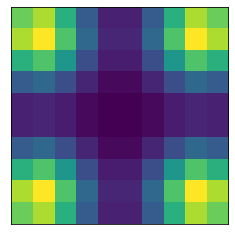

In [11]:
import numpy as np
import matplotlib.pyplot as plt
# from matplotlib import cm
# from mpl_toolkits.mplot3d import Axes3D
import sklearn.datasets as dist
# from scipy.stats import entropy
# from scipy.spatial import distance


def multivariate_gaussian(grid_size = 20, bounds = 4, height = 1, m1 = None, m2 = None, Sigma = None):
    """Return the multivariate Gaussian distribution on array pos."""

    # Our 2-dimensional distribution will be over variables X and Y
    X = np.linspace(-bounds, bounds, grid_size)
    Y = np.linspace(-bounds, bounds, grid_size)
    X, Y = np.meshgrid(X, Y)

    # Mean vector and covariance matrix
    if m1 is None: # if not specifying means
      m1 = np.random.uniform(-bounds,bounds)
      m2 = np.random.uniform(-bounds,bounds)
    mu = np.array([m1, m2])

    if Sigma is None: Sigma = dist.make_spd_matrix(2) # if not specifying covariance matrix, pick randomly

    height = np.random.uniform(1,height)

    # Pack X and Y into a single 3-dimensional array
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return height*norm(np.exp(-fac / 2) / N)

def norm(z):
  return z/z.sum()

def get_n_patches(grid_size = 20, bounds = 4, modes = 3, radius = None, var = 2):
# The distribution on the variables X, Y packed into pos.
  z = np.zeros((grid_size, grid_size))
  sigma = [[var,0],[0,var]]

  if radius is None: #randomly disperse
    for i in range(0,modes):
      z += multivariate_gaussian(grid_size = grid_size, bounds = bounds, Sigma = sigma)
    return z

  points = get_spaced_means(modes, radius)
  for i in range(0,modes):
    z += multivariate_gaussian(grid_size = grid_size, bounds = bounds, m1 = points[i][0], m2 = points[i][1])
  return z

def get_n_resources(grid_size = 20, bounds = 4, resources = 3, radius = None, offset = 0, var = 1):
# The distribution on the variables X, Y packed into pos.
  z = np.zeros((resources, grid_size, grid_size))

  sigma = [[var,0],[0,var]]

  if radius is None: #randomly disperse
    for i in range(0,resources):
      z[i,:,:] = multivariate_gaussian(grid_size = grid_size, bounds = bounds)
    return z

  points = get_spaced_means(resources, radius, offset)
  for i in range(resources):
    z[i,:,:] = multivariate_gaussian(grid_size = grid_size, bounds = bounds, m1 = points[i][0], m2 = points[i][1], Sigma = sigma)
  return z

def KL_div(y):
  return np.abs(0.05-distance.jensenshannon(patches1.flatten(),y.flatten()))

def get_spaced_means(modes, radius, offset):
    radians_between_each_point = 2*np.pi/modes
    list_of_points = []
    for p in range(0, modes):
        node = p + offset
        list_of_points.append( (radius*np.cos(node*radians_between_each_point),radius*np.sin(node*radians_between_each_point)) )
    return list_of_points


# patches1 = get_n_patches(grid_size = 20, bounds = 4, modes = 3, radius = None)
# patches2 = get_n_patches(grid_size = 20, bounds = 4, modes = 3, radius = None)

res = 4
z = get_n_resources(grid_size = 10, bounds = 3, resources = res, radius = 3.5, offset = 0.5, var = 1)

# for i in range(res):
#   plt.subplot(100 + 10*res + i + 1)
#   plt.imshow(z[i]) 
#   plt.xticks([])
#   plt.yticks([])

for i in range(1,res):
  z[0] += z[i]
plt.imshow(z[0]) 
plt.xticks([])
plt.yticks([])

# plt.subplots()
# plt.imshow(np.sum(z,axis=0))
red = np.ones((10,10,3)) * [1,0,0]
green = np.ones((10,10,3)) * [0,1,0]
a =  z[0].dot(red)

# plt.imshow(a)


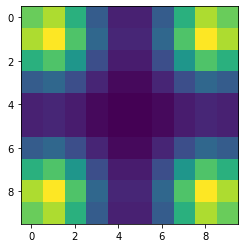

In [ ]:
plt.imshow(z[0])

### random stuff

In [ ]:
from scipy.optimize import minimize, rosen, rosen_der
from scipy.stats import wasserstein_distance


def wass(y):
  return np.abs(0.001 - wasserstein_distance(patches1.flatten(),y.flatten()))

result = minimize(wass, patches2.flatten())
print(wass(patches2.flatten()))


NameError: ignored

In [ ]:
fit = result.x.reshape(grid_size,grid_size)

plt.imshow(fit)
print(wass(result.x))

NameError: ignored

In [ ]:
def multivariate_gaussian_many(grid_size = 20, bounds = 4, dims = 3):
    """Return the multivariate Gaussian distribution on array pos."""

    # Our 2-dimensional distribution will be over variables X and Y
    dimensions = [np.linspace(-bounds, bounds, grid_size) for i in range(dims)]
    coordinates = np.meshgrid(*dimensions)

    # Mean vector and covariance matrix

    means = [np.random.uniform(-bounds,bounds) for i in range(dims)]
    Sigma = dist.make_spd_matrix(2*dims) # if not specifying covariance matrix, pick randomly

    # Pack X and Y into a single 3-dimensional array
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return norm(np.exp(-fac / 2) / N)

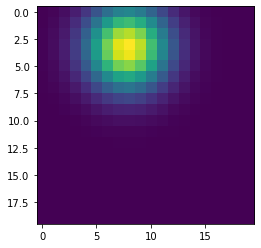

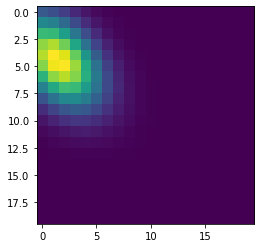

In [ ]:
bounds = 3
grid_size = 20
dims = 3

dimensions = [np.linspace(-bounds, bounds, grid_size) for i in range(dims)]
coordinates = np.meshgrid(*dimensions)

means = np.array([np.random.uniform(-bounds,bounds) for i in range(dims)])
# Sigma = dist.make_spd_matrix(dims) # if not specifying covariance matrix, pick randomly

Sigma = [[0.8,0,0.3],[0,0.7,0],[0.3,0,0.7]]

pos = np.empty(coordinates[0].shape + (dims,))

for i in range(dims):
  pos[:,:,:,i] = coordinates[i]

n = means.shape[0]
Sigma_det = np.linalg.det(Sigma)
Sigma_inv = np.linalg.inv(Sigma)
N = np.sqrt((2*np.pi)**n * Sigma_det)
# This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
# way across all the input variables.
fac = np.einsum('...k,kl,...l->...', pos-means, Sigma_inv, pos-means)

final = norm(np.exp(-fac / 2) / N)

i = 9
plt.imshow(final[:,:,i])
plt.figure()
plt.imshow(final[i,:,:])

In [ ]:
class klnet(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        """Initialization."""
        super(klnet, self).__init__()
        self.h = 256
        self.layers = nn.Sequential(
            nn.Linear(in_dim, self.h), 
            nn.ReLU(),
            nn.Linear(self.h, self.h), 
            nn.ReLU(), 
            nn.Linear(self.h, out_dim),
            nn.Softmax()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        return self.layers(x)

In [ ]:

### train network
device = 'cpu'
# Hyperparameters
LR = 0.01
iterations = 1000
batch_size = 1
grid_size = 20
bounds = 6
modes = 3


# define model, criterion, optimizer
model = klnet(grid_size**2,grid_size**2).to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

losses = []

for epoch in range(iterations):
  # patches = torch.tensor(get_n_patches(grid_size,bounds,modes)).flatten().float().unsqueeze(0).to(device)

  optimizer.zero_grad() # reset optimizer

  # forward pass through model
  prediction = model(patches)

  # calculate loss and update weights
  loss = (1-criterion(patches,prediction)) # did it get the asnwer right? (binary cross entropy loss)
  loss.backward() # backpropogation

  optimizer.step() # adjust weights

  # save epochs and display progress
  if epoch % 100 == 0:
    print(f'Epoch {epoch} total loss: {loss.item()}')







In [ ]:
# model = klnet(grid_size**2,grid_size**2).to(device)
prediction = model(patches)

plt.imshow(prediction.view(20,20).detach().cpu().numpy())
plt.figure()
plt.imshow(patches.reshape(20,20))

In [ ]:
model(patches)

### Old World

In [ ]:
import random
class old_world():
  def __init__(self, features = 3, map_var = 2, map_smooth = 3, field_of_view = 1, size = 20, bounds = 4, modes = 4, change = False):

    # make a set of stats. glucose depends on finding food. water depends on finding water. fatigue increases with movement. damage depends on being in a dangerous location.


    self.features = features
    self.map_var = map_var # this represents how variable the environment is
    self.map_smooth = map_smooth # this generates larger and smoother maps
    self.size = len(creamatriz(self.map_var,self.map_smooth))
    self.size = size
    self.fov = field_of_view
    self.view_size = 2*self.fov + 1
    self.input_size = [self.features*self.view_size**2+self.features,]
    self.bounds = bounds
    self.changing_environment = change
    self.modes = modes
   
    self.action_space = spaces.Discrete(7) # action space
    self.observation_space = spaces.Box(low=-1, high=1, shape=(self.input_size))

    cost = 0.01

    self.energy_cost_of_step = cost
    self.water_cost_of_step = cost

    self.energy_cost_of_graze = cost
    self.water_cost_of_graze = cost

    self.energy_cost_of_rest = cost
    self.water_cost_of_rest = cost

    self.cals_per_step = 0.1
    self.water_per_step = 0.1

    self.healing_per_step = 0.1
    self.damage_per_step = 0.01
    
    self.water_renewable = True
    self.clumsiness = 0.2
    self.resource_threshold = 0.1 # minimum amount of food/water in order to graze it
    self.p = 4
    self.q = 4

    # create a grid-world - each location has 3 properties: amount of food, amount of water, and probability of harm/danger

    self.grid = np.zeros((features,self.size,self.size))
    self.reset_world()
    

    # generate stuff 

  def reset_world(self): # creates new terrain
    for feat in range(0,self.features):
      # terrain = np.array(creamatriz(self.map_var,self.map_smooth)) # generate new terrain
      # terrain = (terrain - np.min(terrain))/(np.max(terrain) - np.min(terrain)) # normalize to 0 and 1
      self.grid[feat,:,:] = 10*get_n_patches(grid_size = self.size, bounds = self.bounds, modes = self.modes)


    # self.grid[0,:3,:] = 1
    # self.grid[1,6:,:] = 0.5
    # self.grid[2,:,:] = 0
    # self.grid[2,4,:] = 1



    self.grid[:,0,:] = -1; self.grid[:,-1,:] = -1; self.grid[:,:,0] = -1; self.grid[:,:,-1] = -1; 
    self.glucose = 0.5
    self.water = 0.5
    self.damage = 0.8
    self.dead = False
    self.state = [np.random.randint(self.fov,self.size-self.fov),np.random.randint(self.fov,self.size-self.fov)] # initialize state randomly
    # self.state = [2,2]
    self.view = self.grid[:,self.state[0] - self.fov : self.state[0] + self.fov+1, self.state[1] - self.fov : self.state[1] + self.fov+1] # gets initial agent view
    self.starting_grid = copy.deepcopy(self.grid)

  def reset(self):
    # self.state = [2,2]
    if self.changing_environment: self.reset_world()
    self.time_step = 0
    self.history = []
    self.state = [np.random.randint(self.fov,self.size-self.fov),np.random.randint(self.fov,self.size-self.fov)] # initialize state randomly
    self.grid = copy.deepcopy(self.starting_grid)
    self.view = self.grid[:,self.state[0] - self.fov : self.state[0] + self.fov+1, self.state[1] - self.fov : self.state[1] + self.fov+1]
    self.glucose = 0.5
    self.water = 0.5
    self.damage = 0.8
    self.dead = False
    self.done = False
    return self.get_state()



  def step(self, action): # moves, grazes, or rests

    self.drives_t_minus_1 = self.get_cost_surface()
    self.separated_costs_t_minus_1 = self.get_individual_stat_surfaces()
    self.time_step += 1
    if self.time_step == 50: self.done = True


    if action == 0 and self.state[0] < self.size - self.fov - 1:
      self.state[0] += 1

    elif action == 1 and self.state[0] > self.fov+1:
      self.state[0] -= 1

    elif action == 2 and self.state[1] < self.size - self.fov - 1:
      self.state[1] += 1

    elif action == 3 and self.state[1] > self.fov+1:
      self.state[1] -= 1

    elif action == 4:
      self.eat()

    elif action == 5:
      self.drink()

    elif action ==6:
      self.rest()

    if action < 4: # if moved around
      self.glucose -= self.energy_cost_of_step
      self.water -= self.water_cost_of_step
      self.damage -= self.damage_per_step

    # roll the dice to see if damage is done on this step. The more dangerous, the greater the damage
    danger = self.grid[2,self.state[0],self.state[1]]
    if np.random.uniform() < self.clumsiness:
      self.damage -= danger*0.1

    self.update() # update view, check if dying, return stats
    return self.get_state(), self.reward, self.done, False

  def update(self):
    self.view = self.grid[:,self.state[0] - self.fov : self.state[0] + self.fov+1, self.state[1] - self.fov : self.state[1] + self.fov+1]
    if self.glucose < 0: self.glucose = 0; self.dead = True
    if self.water < 0: self.water = 0; self.dead = True
    if self.damage < 0: self.damage = 0; self.dead = True

    #if capping 
    # if self.glucose > 1: self.glucose = 1; 
    # if self.water > 1: self.water = 1; 
    if self.damage > 1: self.damage = 1; 

    self.reward =  500*(self.drives_t_minus_1 - self.get_cost_surface()) #+ self.glucose*self.water*self.damage - 0.5
    self.separated_rewards = 500*(self.separated_costs_t_minus_1 - self.get_individual_stat_surfaces())
    # self.reward = self.glucose*self.water*self.damage - 1
    self.history.append((self.grid_with_agent(), self.view, [self.glucose, self.water, self.damage]))

  def get_cost_surface(self):
    return ((1 - self.glucose)**self.p + (1 - self.water)**self.p + (1 - self.damage)**self.p)**1/self.q

  def get_individual_stat_surfaces(self):
    return np.array([((1 - self.glucose)**self.p)**1/self.q, ((1 - self.water)**self.p)**1/self.q, ((1 - self.damage)**self.p)**1/self.q])

  def grid_with_agent(self):
    temp = copy.copy(self.grid)
    # temp[:,self.state[0] - self.fov : self.state[0] + self.fov+1, self.state[1] - self.fov : self.state[1] + self.fov+1] = -1
    temp[:,self.state[0],self.state[1]] = -1 #self.grid[:,self.state[0],self.state[1]]
    # temp[:2][temp[:2]>self.resource_threshold] = 2
    return temp

  def eat(self):
    food = self.grid[0,self.state[0],self.state[1]]
    self.glucose -= self.energy_cost_of_graze
    self.water -= self.water_cost_of_graze
    self.damage -= self.damage_per_step
    # self.glucose += food


    if food > self.resource_threshold: # and self.glucose < 1 - self.cals_per_step:
      self.glucose += food #self.cals_per_step
      # self.grid[0,self.state[0],self.state[1]] -= self.cals_per_step

  def drink(self):
    self.glucose -= self.energy_cost_of_graze
    liquid = self.grid[1,self.state[0],self.state[1]]
    self.water -= self.water_cost_of_graze
    self.damage -= self.damage_per_step
    # self.water += liquid

    if liquid > self.resource_threshold: # and self.water < 1 - self.water_per_step:
      self.water += liquid #self.water_per_step
      if not self.water_renewable:
        self.grid[1,self.state[0],self.state[1]] -= self.water_per_step

  def rest(self):
    self.glucose -= self.energy_cost_of_rest
    self.water -= self.water_cost_of_rest
    # if self.damage < 1 - self.healing_per_step:
    self.damage += self.healing_per_step

  def close(self):
    b = 1

  def render(self):
    temp = copy.copy(self.grid)
    # temp[:,self.state[0] - self.fov : self.state[0] + self.fov+1, self.state[1] - self.fov : self.state[1] + self.fov+1] = -1
    temp[:,self.state[0],self.state[1]] = -1 #self.grid[:,self.state[0],self.state[1]]
    # temp[:2][temp[:2]>self.resource_threshold] = 2

    tits = ['Food','Water','Danger']

    for i in range(3):
      plt.subplot(131 + i)
      plt.title(tits[i])
      plt.imshow(temp[i])
      # plt.show()    


  def get_stats_view_tensors(self):
    return torch.tensor([self.glucose,self.water,self.damage]).unsqueeze(0).float(), torch.tensor(self.view).unsqueeze(0).float()

  def get_state(self):
    return torch.cat((torch.tensor([self.glucose,self.water,self.damage]), torch.tensor(self.view.flatten()))).unsqueeze(0).float()

  def get_full_state_tensors(self):
    return torch.tensor([self.state[0],self.state[1],self.glucose,self.water,self.damage]).unsqueeze(0).float(), torch.tensor(self.grid).unsqueeze(0).float()

  def normalize_grid(self, grid): # creates new terrain
    for feat in range(self.features):
      terrain = grid[feat,:,:]
      terrain = (terrain - np.min(terrain))/(np.max(terrain) - np.min(terrain)) # normalize to 0 and 1
      grid[feat,:,:] = terrain

    return grid


def matriz(tama):
	matriz = [[0]*tama for x in range(tama)]
	return matriz

# not used yet (non-square empty matrix)
def emptymatrix(x,y):
    matriz = [[None]*y for x in xrange(x)]
    return matriz

def rndmatriz(matriz):
	for i in range(0, len(matriz)):
		for j in (range(0, len(matriz[i]))):
			r = random.random()
			rr = r * 255
			rrr = int(round(rr,0))
			matriz[i][j]=rrr
	return matriz 

def rrange(v1, v2):
	if v1 == v2:
		return v1
	if v1 - v2 > 0:
		rrrr = random.randrange(v2,v1,1)
	else:
		rrrr = random.randrange(v1,v2,1)
	return rrrr

def arm_horizontal(matriz):
	salida = []
	temp =[]
	for i in range(0, len(matriz)):
		for j in (range(0, len(matriz[i])-1)):
			temp.append(matriz[i][j])
			actual = int(matriz[i][j])
			siguiente = int(matriz[i][j+1])
			intermedio = rrange(actual,siguiente)
			temp.append(int(intermedio))
		temp.append(matriz[i][-1])
		salida.append(temp)
		temp=[]
	return salida

def arm_vertical(matriz):
	salida = []
	temp =[]
	for i in range(0, len(matriz)-1):
		salida.append(matriz[i])
		for j in (range(0, len(matriz[i]))):
			actual = int(matriz[i][j])
			siguiente = int(matriz[i+1][j])
			intermedio = rrange(actual,siguiente)
			temp.append(int(intermedio))
		salida.append(temp)
		temp=[]
	salida.append(matriz[-1])
	return salida

def creamatriz(semilla, pasos):
	matriz_vacia = matriz(semilla)
	r=rndmatriz(matriz_vacia)
	for i in range(0, pasos):
		r = arm_horizontal(r)
		r = arm_vertical(r)
	return r

def matrizterreno(entrop, ciclos):
	salida = []
	tmp = []
	terr = creamatriz(entrop,ciclos)
	for i in range(0, len(terr)):
		for j in range(0, len(terr[0])):
			val = terr[i][j]
			tmp.append([val,False,False,False])
		salida.append(tmp)
		tmp = []
	return salida


def fp(*args):  # fp means 'floating print'
    tmps = []
    for arg in args:
        if type(arg) is not (bool or str): arg = round(arg, 2)  # transform only floats
        tmps.append(str(arg))
    print(" ".join(tmps))


## Set random seed

In [ ]:
seed = 777

def seed_torch(seed):
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

np.random.seed(seed)
seed_torch(seed)
# env.seed(seed)

## Initialize

In [19]:
# environment
# env = world(map_var = 2, map_smooth = 3, field_of_view = 1, size = 10, bounds = 3, modes = 4, change = False)

def compare_capacity():
  mon_params = sum(p.numel() for p in agent_mon.dqn.parameters() if p.requires_grad)
  mod_params = agent_mod.env.n_stats*sum(p.numel() for p in agent_mod.modules[0].parameters() if p.requires_grad)
  print(f'DQN trainable parameters: {mon_params}, GmQ trainable parameters: {mod_params}')

env = World(n_actions = 4, 
            size = 10, 
            bounds = 3, 
            modes = 1, 
            field_of_view = 1, 
            stat_types = [0,0,0,0],
            variance = 1, 
            radius = 3.5,
            offset = 0.5, #1.7
            circle = True,
            stationary = True, 
            rotation_speed = np.pi,
            ep_length = 50,
            resource_percentile = 60,
            reward_type = 'HRRL',  # HRRL, sq_dev, lin_dev, well_being, min_sq
            module_reward_type = 'HRRL', # HRRL, sq_dev, lin_dev
            stat_decrease_per_step = [0.008,0.008,0.008,0.008],
            stat_increase_multiplier = 1,
            initial_stats = [0.5,0.5], 
            set_point = 5,
            pq = [4,2],
            reward_clip = 500,
            reward_scaling = 1,
            mod_reward_scaling = 1,
            mod_reward_bias = 0,
            min_stat = -20,
            max_stat = 20,
            squeeze_reward = True)

# obs_dim = env.observation_space.shape[0]

# parameters
num_frames = 30000
memory_size = 100000
batch_size = 512
target_update = 400
epsilon_decay = 1 / 1
min_epsilon = 0.01
lr = 1e-3
arbitrator_lr = 2e-3
gamma = 0.5
explore = 0
switch_episode = 15000 # for reversal learning

mod_hidden_size = 500
mon_hidden_size = 1024

 ## PPO Arbitrator ##
lr_actor = 0.003
lr_critic = 0.01
PPO_gamma = 0.99
K_epochs = 1
eps_clip = 0.2 
action_std = 2
action_std_decay_rate = 0.05
min_action_std = 0.05
start_control = 10000



cuda
cuda
DQN trainable parameters: 1095684, GmQ trainable parameters: 1092016


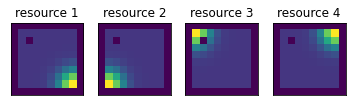

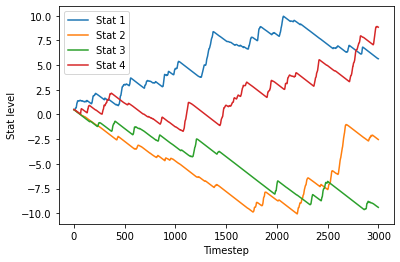

In [20]:
agent_mod = Modular_DQN_Agent(env, 
                              memory_size, 
                              batch_size, 
                              target_update, 
                              epsilon_decay, 
                              lr = lr, 
                              gamma = gamma, 
                              min_epsilon = min_epsilon, 
                              explore = explore, 
                              arbitrator_lr = arbitrator_lr,
                              hidden_size = mod_hidden_size, 
                              decision_process = 'PPO_arbitrator', # gmQ, allQ, CEO, variance, max_abs, voting, PPO_arbitrator
                              blind = False,
                              switch_episode = switch_episode,
                              lr_actor = lr_actor,
                              lr_critic = lr_critic,
                              PPO_gamma = PPO_gamma,
                              K_epochs = K_epochs,
                              eps_clip = eps_clip,
                              action_std = action_std,
                              action_std_decay_rate = action_std_decay_rate,
                              min_action_std = min_action_std,
                              start_control = start_control,
                              norm_rewards = False)

agent_mon = DQN_Agent(env, 
                      memory_size, 
                      batch_size, 
                      target_update, 
                      epsilon_decay, 
                      lr = lr, 
                      gamma = gamma, 
                      min_epsilon = min_epsilon, 
                      hidden_size = mon_hidden_size,
                      blind = False,
                      switch_episode = switch_episode,
                      norm_rewards = False)
# env.change_first_resource_map()

compare_capacity()
env.render()

s, c, m, stats = test_random_agent(env, timesteps = 3000, plotting = False)
plt.plot(stats);
plt.xlabel('Timestep');
plt.ylabel('Stat level');
plt.legend([f'Stat {i+1}' for i in range(env.n_stats)]);


## Train

### Train Monolithic

In [21]:
env.reset_for_new_agent()
# env.change_first_resource_map()
# agent_mon.clamp_to = 20
# agent_mon.attention_agent = True
# agent_mon.plotting_interval = 100
# agent_mon.plotting = False
# agent_mon.nonstationarity = 'blank'
# agent_mon.lambd = 0.0001
agent_mon.updates_per_step = 1
agent_mon.store_value_maps = False
agent_mon.train(num_frames) 


KeyboardInterrupt: ignored

### Train Modular

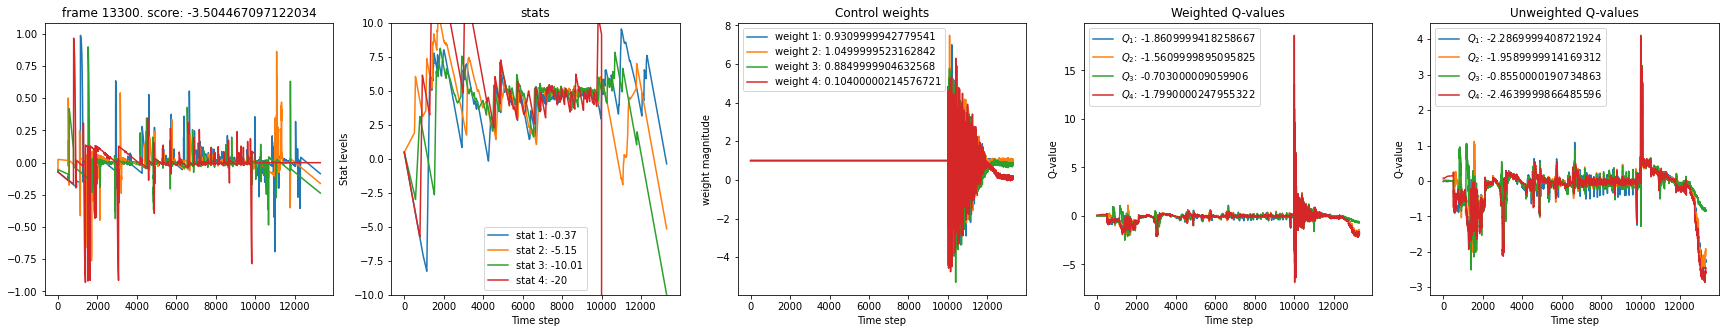

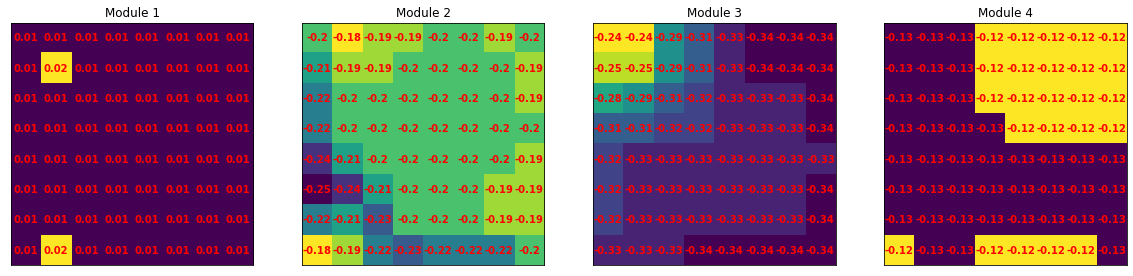

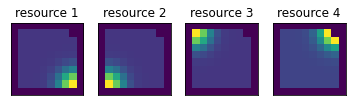

<Figure size 432x288 with 0 Axes>

--------------------------------------------------------------------------------------------
setting actor output action_std to min_action_std :  0.05
--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------
setting actor output action_std to min_action_std :  0.05
--------------------------------------------------------------------------------------------


In [ ]:
env.reset_for_new_agent()
# env.change_first_resource_map()
# agent_mod.arbitrator.buffer.clear()
agent_mod.nonstationarity = 'jump'
agent_mod.clamp_to = -20
agent_mod.switch_episode = 10000


# agent_mod.plotting = False
# agent_mod.nonstationarity = 'blank'
# agent_mod.lambd = 0.0001
agent_mod.store_value_maps = False
agent_mod.train(num_frames)



In [ ]:
# agent_mod.arbitrator.decay_action_std(agent_mod.action_std_decay_rate, agent_mod.min_action_std)
agent_mod.arbitrator.action_std



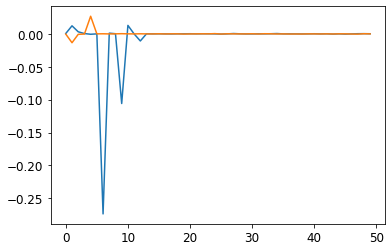

In [ ]:
"plt.plot(np.array([agent_mod.modules[0].mask[0].detach().cpu().numpy(),agent_mod.modules[1].mask[0].detach().cpu().numpy()]).T);

## Grab Heatmaps

In [ ]:
heat_maps_mon = []
heat_maps_mod = []
samples = 3
steps = 1000

for i in range(samples):

  print(i)
  agent_mon = DQN_Agent(env, 
                        memory_size, 
                        batch_size, 
                        target_update, 
                        epsilon_decay, 
                        lr = lr, 
                        gamma = gamma, 
                        min_epsilon = min_epsilon, 
                        hidden_size = mon_hidden_size,
                        blind = False,
                        switch_episode = switch_episode)

  agent_mod = Modular_DQN_Agent(env, 
                                memory_size, 
                                batch_size, 
                                target_update, 
                                epsilon_decay, 
                                lr = lr, 
                                gamma = gamma, 
                                min_epsilon = min_epsilon, 
                                explore = explore, 
                                arbitrator_lr = arbitrator_lr,
                                hidden_size = mod_hidden_size, 
                                decision_process = 'gmQ', # gmQ, allQ, CEO, variance, max_abs, voting
                                blind = False,
                                switch_episode = switch_episode)


  env.reset_for_new_agent()
  agent_mon.updates_per_step = 1
  agent_mon.store_value_maps = False
  agent_mon.plotting = False
  agent_mon.train(steps) 
  heat_maps_mon.append(env.heat_map)

  env.reset_for_new_agent()
  agent_mod.store_value_maps = False
  agent_mod.plotting = False
  agent_mod.train(steps) 
  heat_maps_mod.append(env.heat_map)





0
cuda
cuda
1
cuda
cuda
2
cuda
cuda


In [ ]:
entropy_mod = []
entropy_mon = []
from scipy.stats import entropy
for i in range(samples):
  entropy_mod.append(entropy(heat_maps_mod[i].flatten()))
  entropy_mon.append(entropy(heat_maps_mon[i].flatten()))

print('Modular entropy', np.mean(entropy_mod),np.var(entropy_mod))
print('Monolithic entropy', np.mean(entropy_mon),np.var(entropy_mon))

Modular entropy 2.024006517017662 0.021353569668239352
Monolithic entropy 2.3994429050317017 0.09150097499497545


In [ ]:
import numpy as np
for i in range(1000):
  a = np.random.choice(2,(100,1000000))
  b = sum(a)
  c = np.min(b)

24

## Plot course

AttributeError: ignored

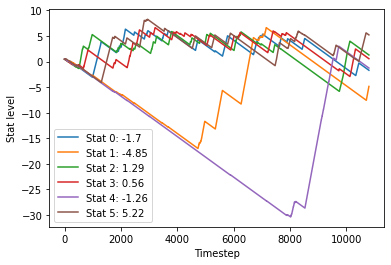

In [ ]:


plt.plot(agent_mon.stats);
plt.xlabel('Timestep');
plt.ylabel('Stat level');
plt.legend([f'Stat {i}: {np.round(agent_mon.stats[-1][i],2)}' for i in range(env.n_stats)]);
plt.ylim(np.min(agent_mon.stats),np.max(agent_mon.stats));

plt.plot(agent_mod.stats);
plt.xlabel('Timestep');
plt.ylabel('Stat level');
plt.legend([f'Stat {i}: {np.round(agent_mod.stats[-1][i],2)}' for i in range(env.n_stats)]);
plt.ylim(np.min(agent_mod.stats),np.max(agent_mon.stats));

In [ ]:
agent_mod.modules[3].mask

Parameter containing:
tensor([[-2.1445e-03,  1.5679e-03,  5.9751e-03,  2.8441e-02, -2.9365e-04,
          1.1495e-02, -8.9761e-05,  1.0304e-06, -1.2208e-04,  3.1728e-03,
         -1.5468e-04,  1.3252e-04, -1.4485e-05,  7.6796e-05, -1.0597e-04,
          6.7851e-05,  9.7271e-05, -1.8431e-05,  7.5332e-03, -2.4140e-04,
         -2.9872e-03, -3.2960e-06,  5.7870e-04,  4.2241e-04,  9.2109e-03,
          3.2538e-03, -1.5489e-02, -2.1348e-04, -1.3789e-04,  2.2760e-04,
         -2.0898e-05, -8.9310e-04, -1.2059e-01, -3.5787e-04,  3.9012e-04,
          2.2152e-01,  4.1938e-02,  2.6927e-04,  9.9947e-06, -8.2995e-05]],
       device='cuda:0', requires_grad=True)

## make vids

In [ ]:
for i in range(0,100):

  agent_mod = Modular_DQN_Agent(env, memory_size, batch_size, target_update, epsilon_decay, lr = lr, gamma = gamma, min_epsilon = min_epsilon, explore = explore, arbitrator_lr = arbitrator_lr, switch_episode = switch_episode)
  agent_mon = DQN_Agent(env, memory_size, batch_size, target_update, epsilon_decay, lr = lr, gamma = gamma, min_epsilon = min_epsilon, switch_episode = switch_episode) 

  specifier = f'lr_{lr}_eps_{1/epsilon_decay}_mem_{memory_size}_text_{i}_orig'

  env.reset_for_new_agent()
  agent_mon.plotting = False
  agent_mon.store_value_maps = True
  agent_mon.train(num_frames)

  hist = env.history
  skip = 50
  animate(hist[::skip],agent_mon,skip,specifier) # animate function is below this cell


  env.reset_for_new_agent()
  agent_mod.plotting = False
  agent_mod.store_value_maps = True
  agent_mod.train(num_frames)

  hist = env.history
  skip = 50
  animate(hist[::skip],agent_mod,skip,specifier) # animate function is below this cell

cuda
cuda


KeyboardInterrupt: ignored

## Save statcourses

In [ ]:
label = 'blindjump20'#'jumpstat' #grid,  'setpoint'
gammas = [0.3]
exp = [1/5000]
# setpoints = [1,2,3,4,5,6,7,8,9]

# parameters
num_frames = 30000
memory_size = 100000
batch_size = 512
target_update = 1000
min_epsilon = 0.01
lr = 1e-3
explore = 0
switch_episode = 15000 # for reversal learning
clamp_to = 20
nmodels = 50

count = 0

# for setpoint in setpoints:
for gamma in gammas:
  for epsilon_decay in exp:
    for i in range(7,8):
      print(i,gamma,epsilon_decay)

      env = World(n_actions = 4, 
            size = 10, 
            bounds = 3, 
            modes = 1, 
            field_of_view = 1, 
            stat_types = [0,0,0,0],
            variance = 1, 
            radius = 3.5,
            offset = 0.5, #1.7
            circle = True,
            stationary = True, 
            rotation_speed = np.pi,
            ep_length = 100,
            resource_percentile = 95,
            reward_type = 'HRRL',  # HRRL, sq_dev, lin_dev, well_being, min_sq
            module_reward_type = 'HRRL', # HRRL, sq_dev, lin_dev
            stat_decrease_per_step = [0.004,0.004,0.004,0.004],
            stat_increase_multiplier = 0.8,
            initial_stats = [0.5,0.5], 
            set_point = 5,
            pq = [4,2],
            reward_clip = 500,
            reward_scaling = 10,
            mod_reward_scaling = 5,
            mod_reward_bias = 0)


# gmq
      agent_mod = Modular_DQN_Agent(env, 
                                    memory_size, 
                                    batch_size, 
                                    target_update, 
                                    epsilon_decay, 
                                    lr = lr, 
                                    gamma = gamma, 
                                    min_epsilon = min_epsilon, 
                                    explore = explore, 
                                    arbitrator_lr = arbitrator_lr,
                                    hidden_size = mod_hidden_size, 
                                    decision_process = 'gmQ',
                                    blind = True,# gmQ, allQ, CEO, variance
                                    switch_episode = switch_episode)
      
      specifier = f'{label}_gamma_{gamma}_exp_{epsilon_decay}_modular_test_{i}.npy'
      # specifier = f'{label}_gmq_gamma_{gamma}_exp_{epsilon_decay}_test_{i}'
      env.reset_for_new_agent()
      agent_mod.clamp_to = clamp_to
      agent_mod.lambd = 0.0001
      agent_mod.plotting = False 
      agent_mod.store_value_maps = False
      agent_mod.train(num_frames)
      np.save(parent_dir+specifier,agent_mod.stats)
      # plt.figure()
      # plt.plot(agent_mod.stats)
      # plt.title(f'Mod gamma {gamma} eps {epsilon_decay}')
      # plt.show()

# varq

      # agent_mod = Modular_DQN_Agent(env, 
      #                         memory_size, 
      #                         batch_size, 
      #                         target_update, 
      #                         epsilon_decay, 
      #                         lr = lr, 
      #                         gamma = gamma, 
      #                         min_epsilon = min_epsilon, 
      #                         explore = explore, 
      #                         arbitrator_lr = arbitrator_lr,
      #                         hidden_size = mod_hidden_size, 
      #                         decision_process = 'variance', # gmQ, allQ, CEO, variance
      #                         switch_episode = switch_episode)

      # specifier = f'{label}_varq_gamma_{gamma}_exp_{epsilon_decay}_test_{i}'
      # env.reset_for_new_agent()
      # agent_mod.plotting = False 
      # agent_mod.store_value_maps = False
      # agent_mod.train(num_frames)
      # np.save(parent_dir+specifier,agent_mod.stats)
      # # plt.figure()
      # # plt.plot(agent_mod.stats)
      # # plt.title(f'Mod gamma {gamma} eps {epsilon_decay}')
      # # plt.show()
#dqn

      agent_mon = DQN_Agent(env, 
                            memory_size, 
                            batch_size, 
                            target_update, 
                            epsilon_decay, 
                            lr = lr, 
                            gamma = gamma, 
                            min_epsilon = min_epsilon, 
                            hidden_size = 1024,
                            switch_episode = switch_episode)

      specifier = f'{label}_gamma_{gamma}_exp_{epsilon_decay}_monolithic_test_{i}.npy'
      # specifier = f'{label}_gamma_{gamma}_exp_{epsilon_decay}_test_{i}'
      env.reset_for_new_agent()
      agent_mon.clamp_to = clamp_to
      agent_mon.plotting = False
      agent_mon.store_value_maps = False
      agent_mon.attention_agent = False
      agent_mon.train(num_frames)
      np.save(parent_dir+specifier,agent_mon.stats)
      # plt.figure()
      # plt.plot(agent_mon.stats)
      # plt.title(f'Mon gamma {gamma} eps {epsilon_decay}')
      # plt.show()

# #dqn_binary

#       agent_mon = DQN_Agent(env, 
#                             memory_size, 
#                             batch_size, 
#                             target_update, 
#                             epsilon_decay, 
#                             lr = lr, 
#                             gamma = gamma, 
#                             min_epsilon = min_epsilon, 
#                             hidden_size = 1024,
#                             switch_episode = switch_episode)

#       specifier = f'{label}_gamma_{gamma}_exp_{epsilon_decay}_monolithicbinary_test_{i}.npy'
#       # specifier = f'{label}_gamma_{gamma}_exp_{epsilon_decay}_test_{i}'
#       env.reset_for_new_agent()
#       agent_mon.plotting = False
#       agent_mon.store_value_maps = False
#       agent_mon.attention_agent = True
#       agent_mon.train(num_frames)
#       np.save(parent_dir+specifier,agent_mon.stats)
#       # plt.figure()
#       # plt.plot(agent_mon.stats)
#       # plt.title(f'Mon gamma {gamma} eps {epsilon_decay}')
#       # plt.show()


7 0.3 0.0002
cuda
cuda


### Load and plot statcourses

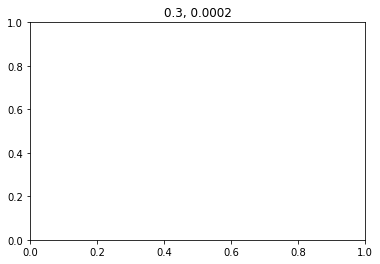

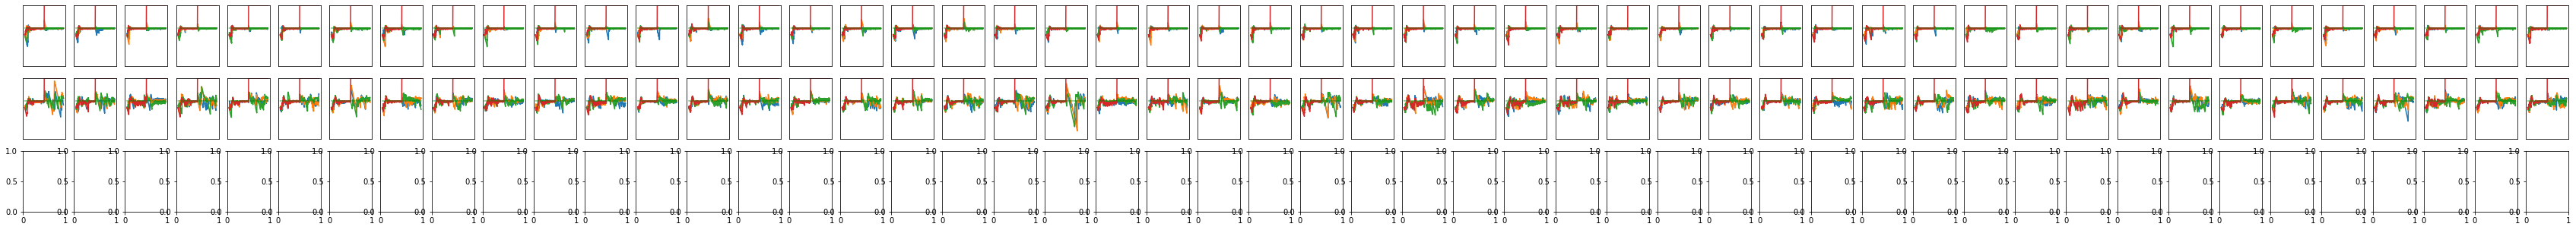

In [ ]:
# specifier = f'noexp_change500_exp_{explore}_modular_test_{i}'
# gamma = 0.2
# epsilon_decay = 1/1
label = 'blindjump20'#'learning_rate_0.005_'#'reg'#'blindjump20'#'hetero' #grid #gmQ #varianceQ 'epsilon0' 'jumpstat' 'locationchange'
gammas = [0.3]
exp = [1/5000]
# nons = [50,100]
l = 30000
x = np.linspace(0,l,l)


mods = []
mons = []
att = []
n=50
for gamma in gammas:
  for epsilon_decay in exp:
    plt.figure()
    plt.title(f'{gamma}, {epsilon_decay}')
    fig,axes=plt.subplots(3,n,figsize=(60,5))
    for i in range(n):
        file = parent_dir + f'{label}_gamma_{gamma}_exp_{epsilon_decay}_modular_test_{i}.npy'
        h = np.load(file,allow_pickle=True)
        # b = list(zip(*h))
        # mods.append(b[2])
        mods.append(np.array(h))
        ax = axes[0,i-0]
        # plt.figure()
        ax.plot(h);
        ax.set_ylim([-20,20])
        # ax[i,0].set_title(f'Modular {gamma} {epsilon_decay} {i}')
        ax.plot(x,5*np.ones(30000),'g',alpha=0.5)
        ax.set_xticks([]) 
        ax.set_yticks([])   

        file = parent_dir + f'{label}_gamma_{gamma}_exp_{epsilon_decay}_monolithic_test_{i}.npy'
        h = np.load(file,allow_pickle=True)
        # b = list(zip(*h))
        # mods.append(b[2])
        mons.append(np.array(h))
        ax = axes[1,i-0]
        # plt.figure()
        ax.plot(h);
        ax.set_ylim([-20,20])
        # ax[i,0].set_title(f'Modular {gamma} {epsilon_decay} {i}')
        ax.plot(x,5*np.ones(30000),'g',alpha=0.5)
        ax.set_xticks([]) 
        ax.set_yticks([])   
        # plt.show()

    # # for i in range(n):
    #     file = parent_dir + f'{label}_gamma_{gamma}_exp_{epsilon_decay}_monolithicbinary_test_{i}.npy'
    #     h = np.load(file,allow_pickle=True)
    #     # b = list(zip(*h))
    #     # mons.append(b[2])
    #     att.append(np.array(h))

    #     ax = axes[2,i]
    #     ax.plot(h);
    #     # ax.set_ylim([-40,40])
    #     # ax[i,1].set_title(f'Monolithic {gamma} {epsilon_decay} {i}')
    #     ax.plot(x,5*np.ones(30000),'g',alpha=0.5)
    #     ax.set_xticks([]) 
    #     ax.set_yticks([])  

    plt.show()


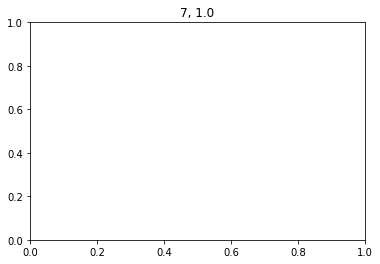

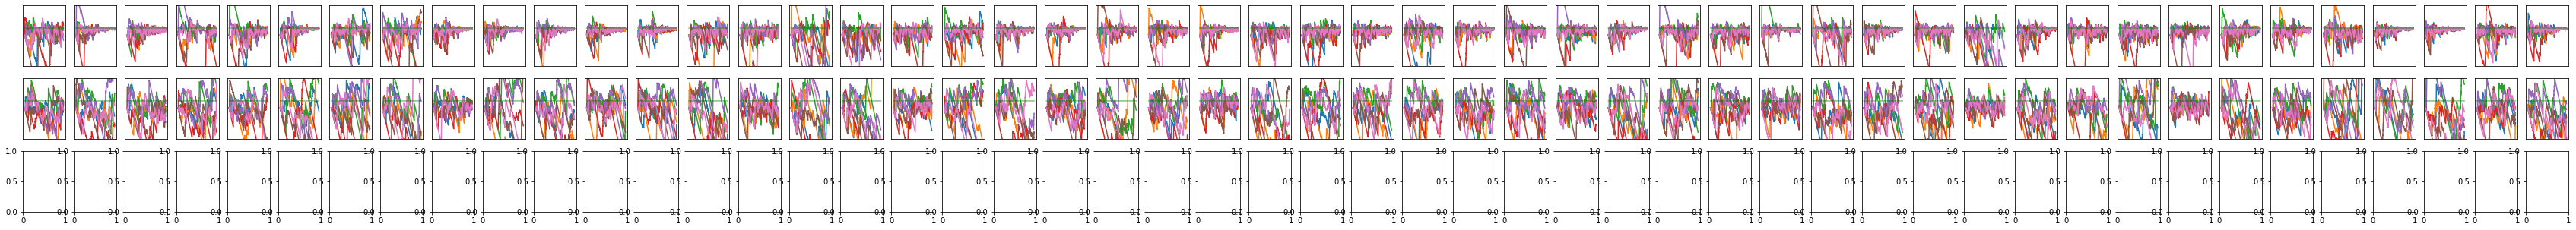

In [ ]:
# specifier = f'noexp_change500_exp_{explore}_modular_test_{i}'
# gamma = 0.2
# epsilon_decay = 1/1
label = 'worldcurse'#'learning_rate_0.005_'#'reg'#'blindjump20'#'hetero' #grid #gmQ #varianceQ 'epsilon0' 'jumpstat' 'locationchange'
cursed = [7]
exp = [1/1]
# nons = [50,100]
l = 30000
x = np.linspace(0,l,l)


mods = []
mons = []
att = []
n=50
for curse in cursed:
  for epsilon_decay in exp:
    plt.figure()
    plt.title(f'{curse}, {epsilon_decay}')
    fig,axes=plt.subplots(3,n,figsize=(60,5))
    for i in range(n):
        file = parent_dir + f'{label}_{curse}_exp_{epsilon_decay}_modular_test_{i}.npy'
        h = np.load(file,allow_pickle=True)
        # b = list(zip(*h))
        # mods.append(b[2])
        mods.append(np.array(h))
        ax = axes[0,i-0]
        # plt.figure()
        ax.plot(h);
        ax.set_ylim([-20,20])
        # ax[i,0].set_title(f'Modular {gamma} {epsilon_decay} {i}')
        ax.plot(x,5*np.ones(30000),'g',alpha=0.5)
        ax.set_xticks([]) 
        ax.set_yticks([])   

        file = parent_dir + f'{label}_{curse}_exp_{epsilon_decay}_monolithic_test_{i}.npy'
        h = np.load(file,allow_pickle=True)
        # b = list(zip(*h))
        # mods.append(b[2])
        mons.append(np.array(h))
        ax = axes[1,i-0]
        # plt.figure()
        ax.plot(h);
        ax.set_ylim([-20,20])
        # ax[i,0].set_title(f'Modular {gamma} {epsilon_decay} {i}')
        ax.plot(x,5*np.ones(30000),'g',alpha=0.5)
        ax.set_xticks([]) 
        ax.set_yticks([])   
        # plt.show()

    # # for i in range(n):
    #     file = parent_dir + f'{label}_gamma_{gamma}_exp_{epsilon_decay}_monolithicbinary_test_{i}.npy'
    #     h = np.load(file,allow_pickle=True)
    #     # b = list(zip(*h))
    #     # mons.append(b[2])
    #     att.append(np.array(h))

    #     ax = axes[2,i]
    #     ax.plot(h);
    #     # ax.set_ylim([-40,40])
    #     # ax[i,1].set_title(f'Monolithic {gamma} {epsilon_decay} {i}')
    #     ax.plot(x,5*np.ones(30000),'g',alpha=0.5)
    #     ax.set_xticks([]) 
    #     ax.set_yticks([])  

    plt.show()


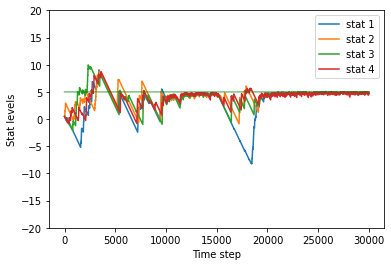

In [ ]:
plt.plot(h);
plt.ylim([-20,20])
# ax[i,0].set_title(f'Modular {gamma} {epsilon_decay} {i}')o
plt.plot(x,5*np.ones(30000),'g',alpha=0.5)
# plt.set_xticks([]) 
# plt.set_yticks([]) 
plt.ylabel('Stat levels')  
plt.xlabel('Time step');
plt.legend([f'stat {n+1}' for n in range(4)])

In [ ]:
mons = []
mods = []
n = 50
for i in range(n):
        file = parent_dir + f'dis1_monolithic_change_test_{i}.npy'
        h = np.load(file,allow_pickle=True)
        b = list(zip(*h))
        mods.append(b[2])
        # mods.append(np.array(h))
        file = parent_dir + f'dis1_modular_change_test_{i}.npy'
        h = np.load(file,allow_pickle=True)
        b = list(zip(*h))
        
        mods.append(b[2])
        # mods.append(np.array(h))

KeyboardInterrupt: ignored

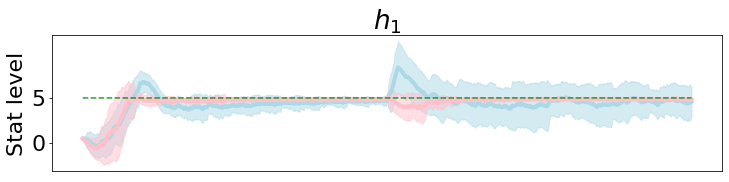

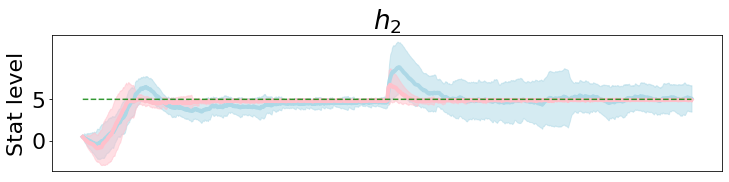

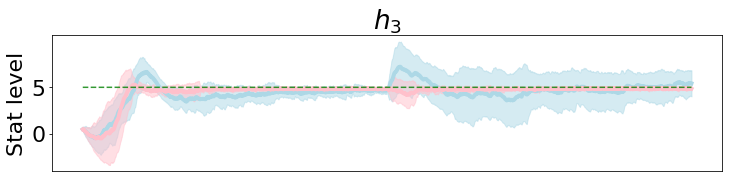

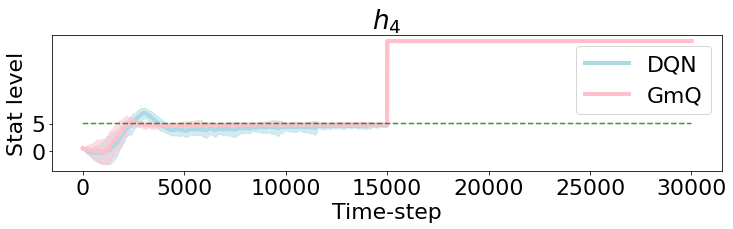

In [ ]:
# stat_rates = env.stat_decrease_per_step
import seaborn as sns
import pandas as pd
plt.rcParams.update({'font.size': 22})

for stat in range(4):

  fig, ax = plt.subplots(figsize=(12,2.5))



  data = np.array(mons)[:,:,stat]
  # data = raw_data[:,:,stat].T
  y = np.mean(data,axis=0)
  ci = np.std(data,axis=0)
  x = np.linspace(0,y.shape[0],y.shape[0])

  # df = pd.DataFrame(data).melt()
  # sns.lineplot(x="variable", y="value", data=df)

  ax.plot(x,y,'lightblue', linewidth=4,label='DQN')
  ax.fill_between(x, (y-ci), (y+ci), color='lightblue', alpha=.5)


  data = np.array(mods)[:,:,stat]
  # data = raw_data[:,:,stat].Tf
  y = np.mean(data,axis=0)
  ci = np.std(data,axis=0)
  x = np.linspace(0,y.shape[0],y.shape[0])

  # df = pd.DataFrame(data).melt()
  # sns.lineplot(x="variable", y="value", data=df)

  ax.plot(x,y,'pink', linewidth=4,label='GmQ')
  ax.fill_between(x, (y-ci), (y+ci), color='pink', alpha=.5)

  ax.set_ylabel('Stat level')
  ax.set_title(f'$h_{stat+1}$')#': Decay Rate {stat_rates[stat]}')
  # ax.set_ylim([-10,21])
  ax.set_yticks([0,5])
  ax.plot(x,5*np.ones(len(x)),'g--',alpha=0.8)
  if stat<3:ax.set_xticks([])

ax.legend()
ax.set_xlabel('Time-step')


plt.savefig(parent_dir+'rate_fig')


IndexError: ignored

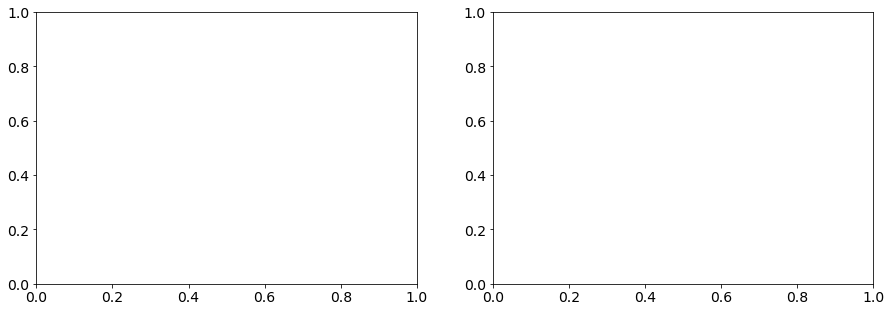

In [ ]:
stat = 1
plot_until = 40000
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(np.array(mods)[:,:plot_until,stat].T);
ax[0].set_title('GmQ')
ax[0].set_ylim([-10,15])
ax[1].plot(np.array(mons)[:,:plot_until,stat].T);
ax[1].set_title('DQN');
ax[1].set_ylim([-10,15])





### Calculate summary stats

In [ ]:
# methods to get metrics from stat-courses
def get_convergence_point(h,window,thresh,set_point):
  for t in range(len(h) - window):
    test_region = h[t:t+window]
    metric = np.sum(np.abs(test_region - set_point))/window
    conv = t
    if metric < thresh:
      break
  
  return conv

def get_homeostatic_performance(statcourse,interval,whichstats):
  statcourse = np.array(statcourse)[interval[0]:interval[1],whichstats]
  # convergence = get_convergence_point(statcourse)
  cumulative_deviation = np.sum(np.abs(statcourse - 5))/len(statcourse)/len(whichstats)
  maximum_deviation = np.max(np.abs(statcourse - 5))
  converges_to = np.mean(statcourse[-3000:])
  return cumulative_deviation, maximum_deviation, converges_to#, convergence#, converges_to



### Find best DQN

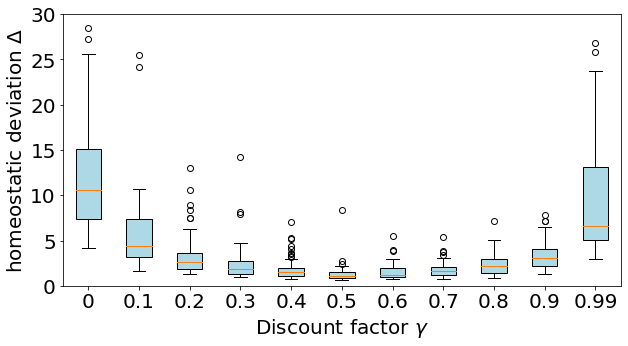

In [ ]:
#plot bargraphs for various comparisons
plt.rcParams.update({'font.size': 20})
label = 'worlddqngrid'
# gammas = [0,0.1,0.2,0.9]
# exps = [1/1,1/10000]
gammas = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99]
exps = [1/10000]
measure = 0
data = []
labels = []
interval = [10000,-1]
n=50
whichstats = [0,1,2,3]



for gamma in gammas:
  for epsilon_decay in exps:

    mons = []
    for i in range(n):

        file = parent_dir + f'{label}_gamma_{gamma}_exp_{epsilon_decay}_monolithic_test_{i}.npy'
        h = np.load(file,allow_pickle=True)   
        mons.append(get_homeostatic_performance(h,interval,whichstats)[measure])
    

    data.append(np.array(mons))
    labels.append(f'{gamma}')
   

    # for i in range(20):
    #   print(get_homeostatic_performance(mons[i][:,0]))
    # print('break')
    # for i in range(20):
    #   print(get_homeostatic_performance(mods[i][:,0]))

fig, ax = plt.subplots(figsize=(10,5));
bplot = ax.boxplot(data,showfliers=True,patch_artist=True);
ax.set_ylabel('homeostatic deviation $\Delta$');
ax.set_xticklabels(labels);
ax.set_xlabel('Discount factor $\gamma$')
ax.set_ylim([0,30])

for pc in bplot['boxes']:
    pc.set_facecolor('lightblue')

# for patch in bplot['boxes']:
#   patch.set_facecolor('pink')

### Set point line

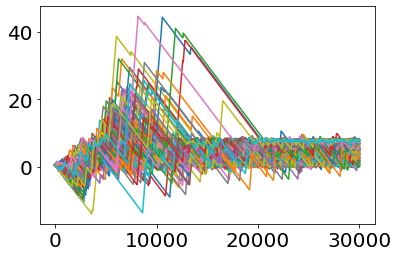

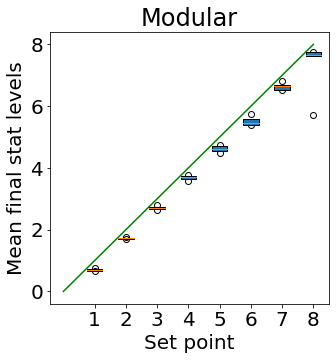

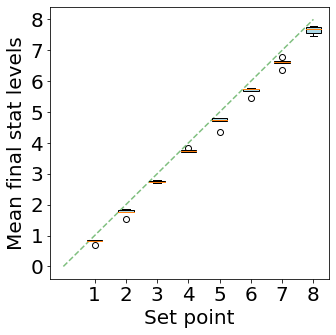

In [ ]:
#plot bargraphs for various comparisons
plt.rcParams.update({'font.size': 20})

label = 'setpoint'
# gammas = [0,0.1,0.2,0.9]
# exps = [1/1,1/10000]
setpoints = [1,2,3,4,5,6,7,8]
gamma = 0.3
epsilon_decay = 1/5000
measure = 2
data_mons = []
data_mods = []
labels = []
interval = [0,-1]
n=5
window = 5000
thresh = 3
which = [0,1,2,3]

for setpoint in setpoints:
  mons = []
  mods = []
  for i in range(n):

    
      file = parent_dir + f'{label}_{setpoint}_gamma_{gamma}_exp_{epsilon_decay}_monolithic_test_{i}.npy'
      h = np.load(file,allow_pickle=True)   
      # plt.plot(h)
      mons.append(get_homeostatic_performance(h,interval,which)[measure])
      # mons.append(get_convergence_point(h,window,thresh,setpoint))
      file = parent_dir + f'{label}_{setpoint}_gamma_{gamma}_exp_{epsilon_decay}_modular_test_{i}.npy'
      h = np.load(file,allow_pickle=True) 
      plt.plot(h)  
      mods.append(get_homeostatic_performance(h,interval,which)[measure])
      # mods.append(get_convergence_point(h,window,thresh,setpoint))



  data_mods.append(np.array(mods))
  labels.append(f'{setpoint}')
  data_mons.append(np.array(mons))


# for i in range(20):
#   print(get_homeostatic_performance(mons[i][:,0]))
# print('break')
# for i in range(20):
#   print(get_homeostatic_performance(mods[i][:,0]))

fig, ax = plt.subplots(figsize=(5,5));
bplot = ax.boxplot(data_mods,showfliers=True,whis=[25,75],patch_artist=True);
# bplot = ax.violinplot(data_mods);
ax.set_ylabel('Mean final stat levels');
# ax.set_xticklabels(labels,rotation = 90);
ax.set_xlabel('Set point')
ax.set_title('Modular')
ax.plot(range(setpoints[-1]+1),range(setpoints[-1]+1),'g')
# ax.set_ylim([0,5])
fig, ax = plt.subplots(figsize=(5,5));
bplot = ax.boxplot(data_mons,showfliers=True,patch_artist=True);
# bplot = ax.violinplot(data_mons);
ax.set_ylabel('Mean final stat levels');
# ax.set_xticklabels(labels,rotation = 90);
ax.set_xlabel('Set point')
# ax.set_title('Monolithic')
ax.plot(range(setpoints[-1]+1),range(setpoints[-1]+1),'g--',alpha=0.5)
ax.set_xticks(range(1,9))
ax.set_yticks(range(9))


for pc in bplot['boxes']:
    pc.set_facecolor('lightblue')
#     # pc.set_edgecolor('black')

# ax.set_ylim([0,5])


### Compare to GmQ

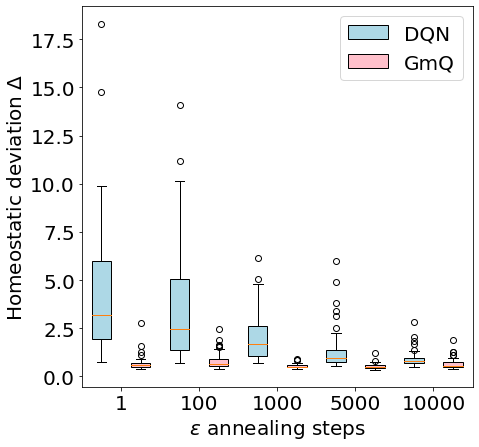

In [ ]:
#plot bargraphs for various comparisons

label = 'bigreg'#hetero'# 'ep0' 'ep01'
# gammas = [0,0.1,0.2,0.9]
# exps = [1/1,1/10000]
gammas = [0.5]
exps = [1/1, 1/100, 1/1000, 1/5000, 1/10000]
measure = 0
data = []
labels = []
n=50
interval=[15000,-1]
whichstats = [0,1,2,3]
# stat = 2
plt.rcParams.update({'font.size': 20})
sk = []

# for i in range(4):
  # whichstats = [i]

for gamma in gammas:
  for epsilon_decay in exps:

    mods = []
    mons = []
    att = []
    for i in range(n):
        # if i in sk: continue

        file = parent_dir + f'{label}_gamma_{gamma}_exp_{epsilon_decay}_monolithic_test_{i}.npy'
        h = np.load(file,allow_pickle=True)
        # print(h.shape)
        mons.append(get_homeostatic_performance(h,interval,whichstats)[measure])
        # file = parent_dir + f'{label}_gamma_{gamma}_exp_{epsilon_decay}_monolithicbinary_test_{i}.npy'
        # h = np.load(file,allow_pickle=True)
        # print(h.shape)
        # att.append(get_homeostatic_performance(h,range)[measure])
        file = parent_dir + f'{label}_gamma_{gamma}_exp_{epsilon_decay}_modular_test_{i}.npy'
        h = np.load(file,allow_pickle=True)
        # print(h.shape)
        mods.append(get_homeostatic_performance(h,interval,whichstats)[measure])


    data.append(np.array(mons))
    labels.append(f'{int(1/epsilon_decay)}')
    data.append(np.array(mods))
    labels.append(f'{(1/epsilon_decay)}')
    # data.append(np.array(mods))
    # labels.append(f'$\gamma$ {gamma}, $\epsilon$-decay {epsilon_decay}')



    # for i in range(20):
    #   print(get_homeostatic_performance(mons[i][:,0]))
    # print('break')
    # for i in range(20):
    #   print(get_homeostatic_performance(mods[i][:,0]))

fig, ax = plt.subplots(figsize=(7,7));
bplot = ax.boxplot(data,showfliers=True,patch_artist=True);
# bplot = ax.violinplot(data)
ax.set_ylabel('Homeostatic deviation $\Delta$');
ax.set_xlabel('$\epsilon$ annealing steps')
# ax.set_xticklabels(labels);
# ax.set_ylim([0,5])
ax.set_xticks([1.5,3.5,5.5,7.5,9.5])
ax.set_xticklabels([1,100,1000,5000,10000]);

# ax.set_xticklabels(['$\gamma$ = 0.2','$\gamma$ = 0.3'])
# ax.set_xticks([])
# ax.tick_params(axis='both', labelsize=0, length = 0)



# # fill with colors
# colors = ['lightblue', 'lightgreen','pink']
# col=0
# for patch in bplot['boxes']:
#   patch.set_facecolor(colors[col%3])
#   col+=1

# ax.legend([bplot["boxes"][0], bplot["boxes"][1],bplot['boxes'][2]],  ['DQN','BinDQN','GmQ'], loc='upper right')

#fill with colors
colors = ['lightblue','pink']
col=0
for patch in bplot['boxes']: #boxes
  patch.set_facecolor(colors[col%2])
  col+=1

ax.legend([bplot["boxes"][0], bplot["boxes"][1]],  ['DQN','GmQ'], loc='upper right');

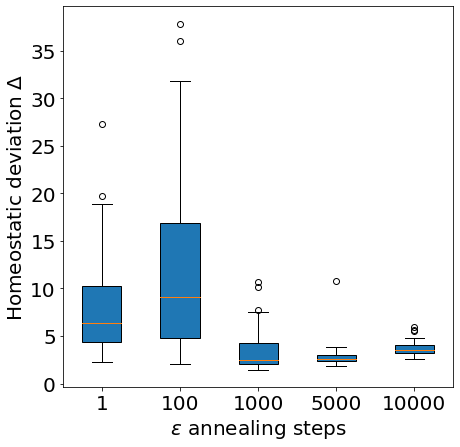

In [ ]:
#plot bargraphs for various comparisons

label = 'world arq_4'#hetero'# 'ep0' 'ep01'
# gammas = [0,0.1,0.2,0.9]
# exps = [1/1,1/10000]
gammas = [0.5]
exps = [1/1, 1/100, 1/1000, 1/5000, 1/10000]
measure = 0
data = []
labels = []
n=50
interval=[0,-1]
whichstats = [0,1,2,3]
# stat = 2
plt.rcParams.update({'font.size': 20})
sk = []

# for i in range(4):
  # whichstats = [i]

for gamma in gammas:
  for epsilon_decay in exps:

    mods = []
    mons = []
    att = []
    for i in range(n):
      
        file = parent_dir + f'{label}_exp_{epsilon_decay}_modular_test_{i}.npy'
        h = np.load(file,allow_pickle=True)
        mods.append(get_homeostatic_performance(h,interval,whichstats)[measure])

    data.append(np.array(mods))
    labels.append(f'{(1/epsilon_decay)}')

fig, ax = plt.subplots(figsize=(7,7));
bplot = ax.boxplot(data,showfliers=True,patch_artist=True);
# bplot = ax.violinplot(data)
ax.set_ylabel('Homeostatic deviation $\Delta$');
ax.set_xlabel('$\epsilon$ annealing steps')
# ax.set_xticklabels(labels);
# ax.set_ylim([0,5])
# ax.set_xticks([1.5,3.5,5.5,7.5,9.5])
ax.set_xticklabels([1,100,1000,5000,10000]);


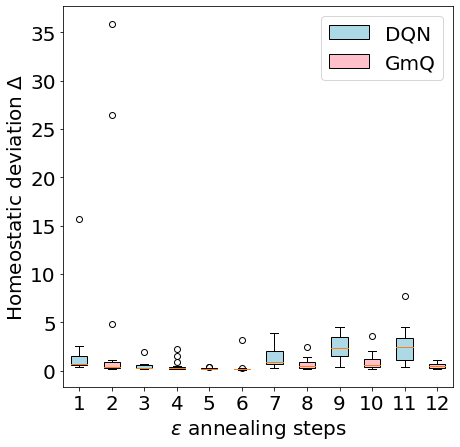

In [ ]:

#plot bargraphs for various comparisons

label = 'worldcurse'#hetero'# 'ep0' 'ep01'
# gammas = [0,0.1,0.2,0.9]
# exps = [1/1,1/10000]
curses = [2,3,4,5,6,7]
exps = [1/5000]
measure = 0
data = []
labels = []
n=19
interval=[15000,-1]
# stat = 2
plt.rcParams.update({'font.size': 20})
sk = []

# for i in range(4):
  # whichstats = [i]

for curse in curses:
  for epsilon_decay in exps:

    mods = []
    mons = []
    att = []
    whichstats = [i for i in range(curse)]

    for i in range(n):
        # if i in sk: continue

        file = parent_dir + f'{label}_{curse}_exp_{epsilon_decay}_monolithic_test_{i}.npy'
        h = np.load(file,allow_pickle=True)
        # print(h.shape)
        mons.append(get_homeostatic_performance(h,interval,whichstats)[measure])
        # file = parent_dir + f'{label}_gamma_{gamma}_exp_{epsilon_decay}_monolithicbinary_test_{i}.npy'
        # h = np.load(file,allow_pickle=True)
        # print(h.shape)
        # att.append(get_homeostatic_performance(h,range)[measure])
        file = parent_dir + f'{label}_{curse}_exp_{epsilon_decay}_modular_test_{i}.npy'
        h = np.load(file,allow_pickle=True)
        # print(h.shape)
        mods.append(get_homeostatic_performance(h,interval,whichstats)[measure])


    data.append(np.array(mons))
    labels.append(f'{int(1/epsilon_decay)}')
    data.append(np.array(mods))
    labels.append(f'{(1/epsilon_decay)}')
    # data.append(np.array(mods))
    # labels.append(f'$\gamma$ {gamma}, $\epsilon$-decay {epsilon_decay}')



    # for i in range(20):
    #   print(get_homeostatic_performance(mons[i][:,0]))
    # print('break')
    # for i in range(20):
    #   print(get_homeostatic_performance(mods[i][:,0]))

fig, ax = plt.subplots(figsize=(7,7));
bplot = ax.boxplot(data,showfliers=True,patch_artist=True);
# bplot = ax.violinplot(data)
ax.set_ylabel('Homeostatic deviation $\Delta$');
ax.set_xlabel('$\epsilon$ annealing steps')
# ax.set_xticklabels(labels);
# ax.set_ylim([0,5])
# ax.set_xticks([1.5,3.5,5.5,7.5,9.5])
# ax.set_xticklabels([1,100,1000,5000,10000]);

# ax.set_xticklabels(['$\gamma$ = 0.2','$\gamma$ = 0.3'])
# ax.set_xticks([])
# ax.tick_params(axis='both', labelsize=0, length = 0)



# # fill with colors
# colors = ['lightblue', 'lightgreen','pink']
# col=0
# for patch in bplot['boxes']:
#   patch.set_facecolor(colors[col%3])
#   col+=1

# ax.legend([bplot["boxes"][0], bplot["boxes"][1],bplot['boxes'][2]],  ['DQN','BinDQN','GmQ'], loc='upper right')

#fill with colors
colors = ['lightblue','pink']
col=0
for patch in bplot['boxes']: #boxes
  patch.set_facecolor(colors[col%2])
  col+=1

ax.legend([bplot["boxes"][0], bplot["boxes"][1]],  ['DQN','GmQ'], loc='upper right');

In [ ]:
#plot bargraphs for various comparisons

label = 'jumpstat20' #'epsiloninf'
# gammas = [0,0.1,0.2,0.9]
# exps = [1/1,1/10000]
gammas = [0.3]
exps = [1/10000]
measure = 0
data = []
labels = []
n=20
interval=[15000,-1]
# stat = 2
plt.rcParams.update({'font.size': 14})



for gamma in gammas:
  for epsilon_decay in exps:

    mods = []
    mons = []
    att = []
    for i in range(n):

        file = parent_dir + f'{label}_gamma_{gamma}_exp_{epsilon_decay}_monolithic_test_{i}.npy'
        h = np.load(file,allow_pickle=True)
        # print(h.shape)
        mons.append(get_homeostatic_performance(h,interval)[measure])
        # file = parent_dir + f'{label}_gamma_{gamma}_exp_{epsilon_decay}_monolithicbinary_test_{i}.npy'
        # h = np.load(file,allow_pickle=True)
        # print(h.shape)
        # att.append(get_homeostatic_performance(h,range)[measure])
        file = parent_dir + f'{label}_gamma_{gamma}_exp_{epsilon_decay}_modular_test_{i}.npy'
        h = np.load(file,allow_pickle=True)
        # print(h.shape)
        mods.append(get_homeostatic_performance(h,interval)[measure])


    data.append(np.array(mons))
    labels.append(f'$\gamma$ {gamma}, $\epsilon$-decay {epsilon_decay}')
    data.append(np.array(mods))
    labels.append(f'$\gamma$ {gamma}, $\epsilon$-decay {epsilon_decay}')
    # data.append(np.array(mods))
    # labels.append(f'$\gamma$ {gamma}, $\epsilon$-decay {epsilon_decay}')



    # for i in range(20):
    #   print(get_homeostatic_performance(mons[i][:,0]))
    # print('break')
    # for i in range(20):
    #   print(get_homeostatic_performance(mods[i][:,0]))

fig, ax = plt.subplots(figsize=(7,7));
bplot = ax.boxplot(data,showfliers=True,whis=[25,75],patch_artist=True);
ax.set_ylabel('Cumulative stat deviation per step');
# ax.set_xticklabels(labels,rotation = 90);
# ax.set_ylim([0,5])
# ax.set_xticks([4,10])
# ax.set_xticklabels(['$\gamma$ = 0.2','$\gamma$ = 0.3'])
ax.set_xticks([])
# ax.tick_params(axis='both', labelsize=0, length = 0)



# # fill with colors
# colors = ['lightblue', 'lightgreen','pink']
# col=0
# for patch in bplot['boxes']:
#   patch.set_facecolor(colors[col%3])
#   col+=1

# ax.legend([bplot["boxes"][0], bplot["boxes"][1],bplot['boxes'][2]],  ['DQN','BinDQN','GmQ'], loc='upper right')

#fill with colors
colors = ['lightblue','pink']
col=0
for patch in bplot['boxes']:
  patch.set_facecolor(colors[col%2])
  col+=1

ax.legend([bplot["boxes"][0], bplot["boxes"][1]],  ['DQN','GmQ'], loc='upper right');
ax.set_ylim(0,20)
ax.set_title(f't = {interval}');

TypeError: ignored

In [ ]:
# gammas = [0.4,0.5]
# exps = [1/1,1/10000]
# n = 20

# for gamma in gammas:
#   for epsilon_decay in exps:

#     for i in range(n):
#         label = 'grid'
#         # file = parent_dir + f'{label}_gamma_{gamma}_exp_{epsilon_decay}_monolithic_test_{i}.npy'
#         # file2 = parent_dir + f'{label}_gamma_{gamma}_exp_{epsilon_decay}_modular_test_{i}.npy'
#         file3 = parent_dir + f'{label}_gamma_{gamma}_exp_{epsilon_decay}_monolithicbinary_test_{i}.npy'

#         # h1 = np.load(file,allow_pickle=True)
#         # h2 = np.load(file2,allow_pickle=True)
#         h3 = np.load(file3,allow_pickle=True)

#         label = 'jumpstat'
#         # file = parent_dir + f'{label}_gamma_{gamma}_exp_{epsilon_decay}_monolithic_test_{i}.npy'
#         # file2 = parent_dir + f'{label}_gamma_{gamma}_exp_{epsilon_decay}_modular_test_{i}.npy'
#         file3 = parent_dir + f'{label}_gamma_{gamma}_exp_{epsilon_decay}_monolithicbinary_test_{i}.npy'

#         # np.save(file,h1)
#         # np.save(file2,h2)
#         np.save(file3,h3)




## Heatmap

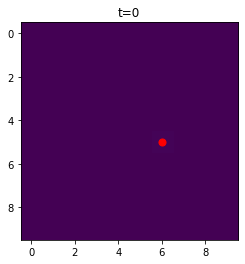

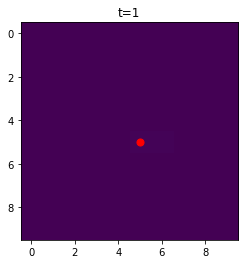

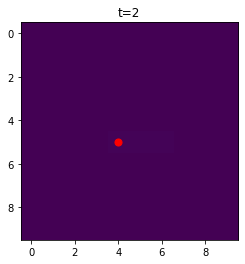

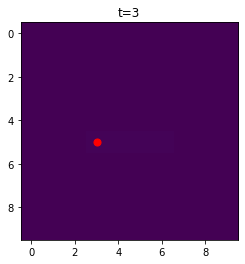

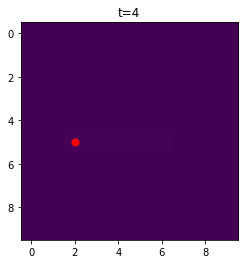

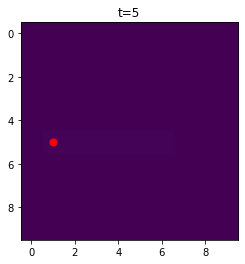

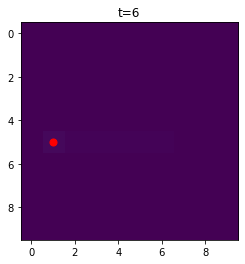

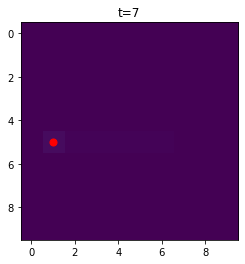

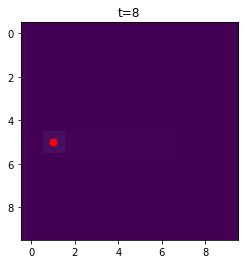

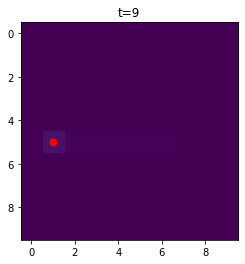

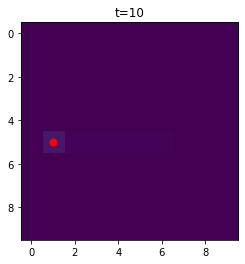

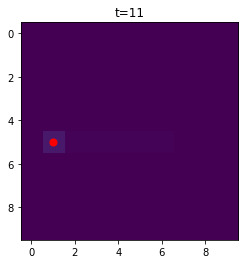

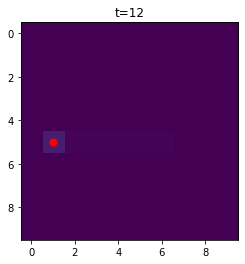

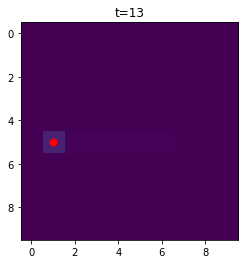

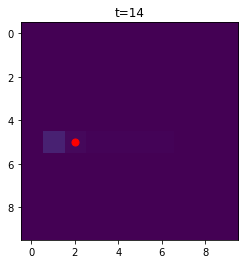

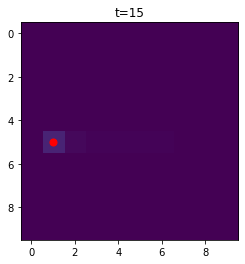

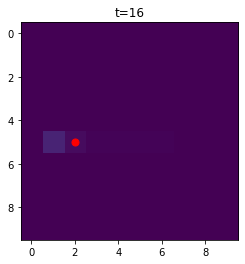

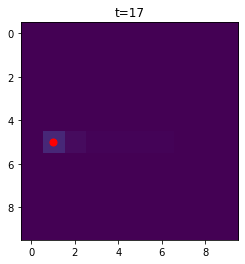

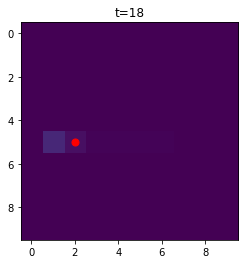

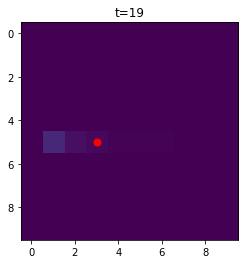

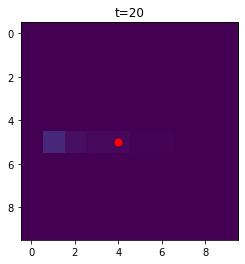

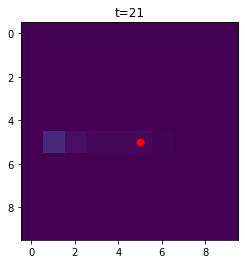

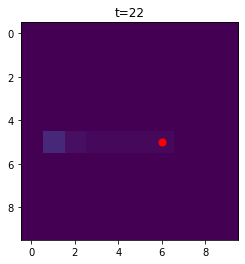

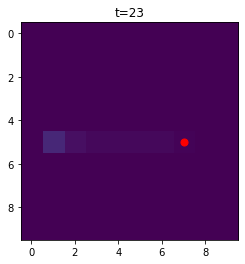

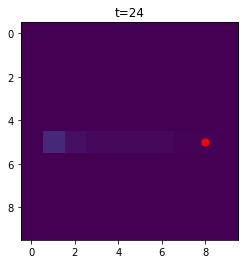

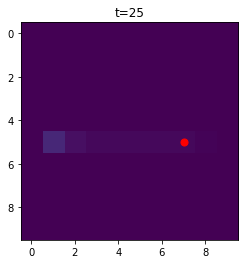

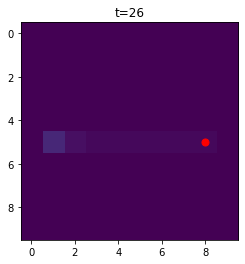

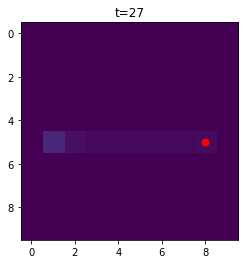

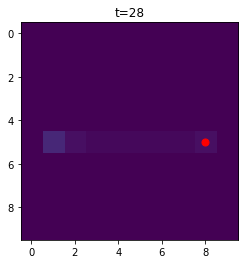

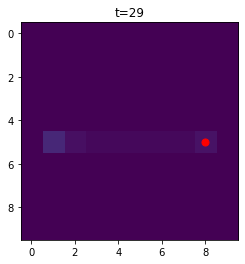

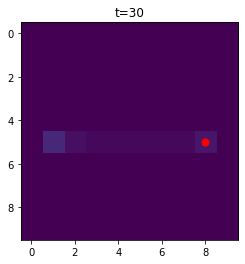

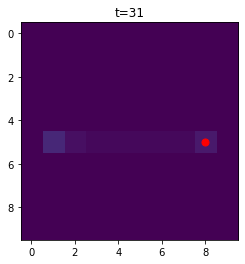

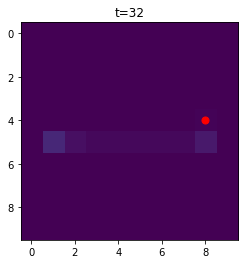

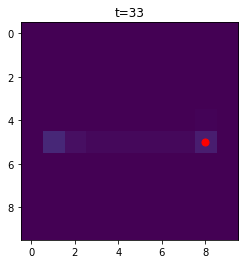

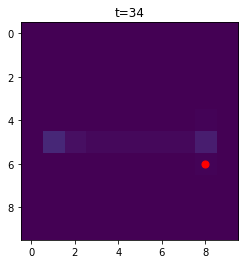

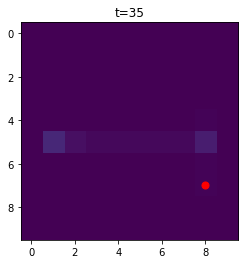

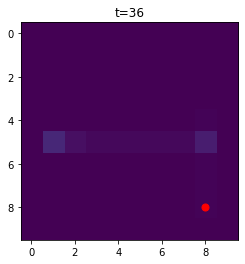

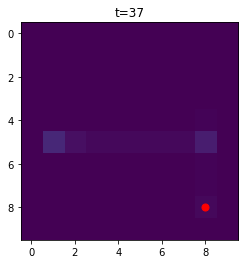

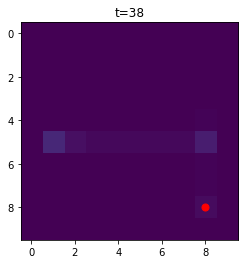

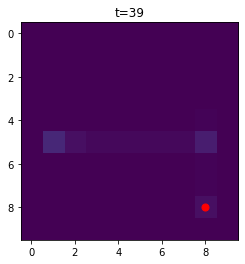

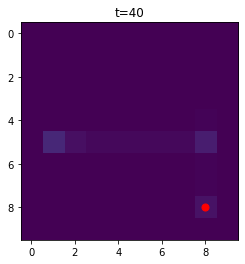

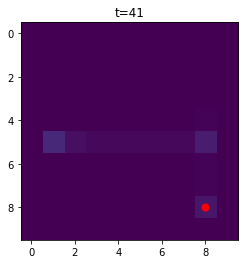

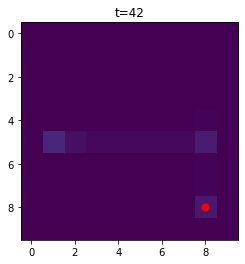

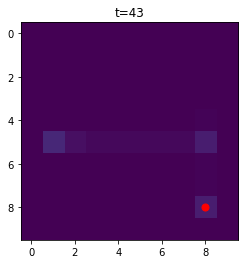

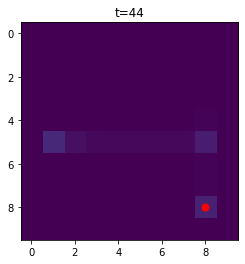

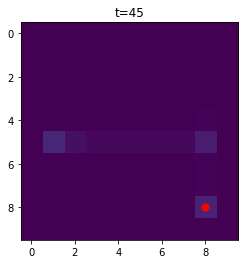

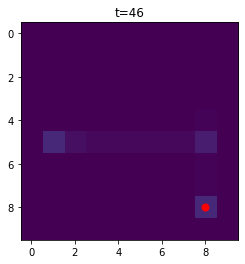

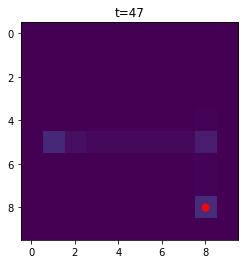

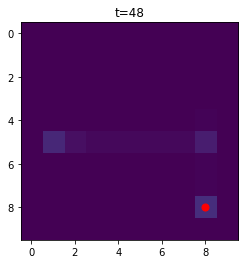

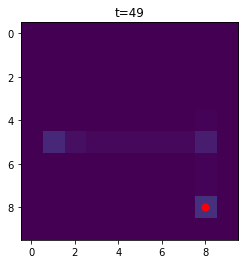

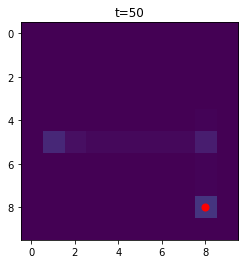

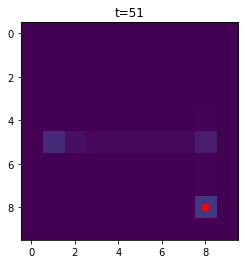

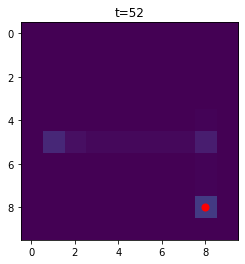

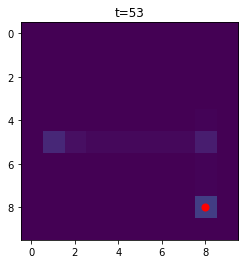

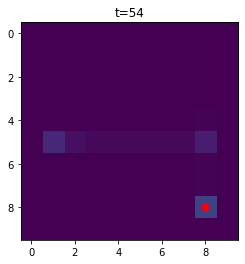

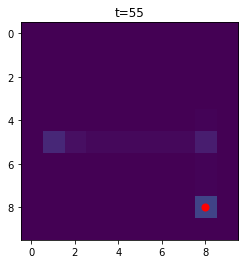

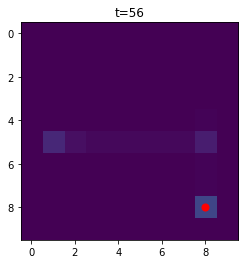

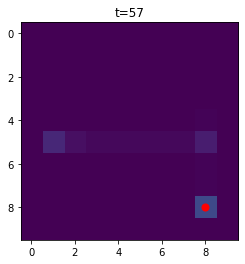

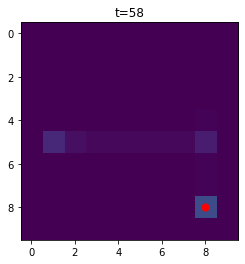

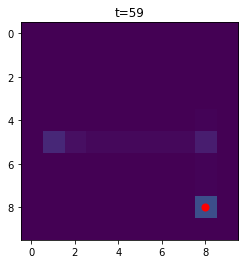

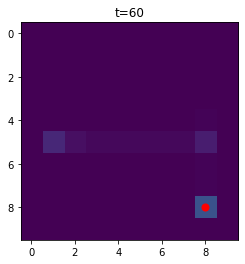

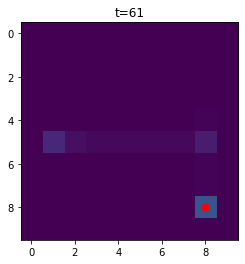

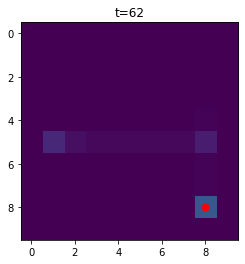

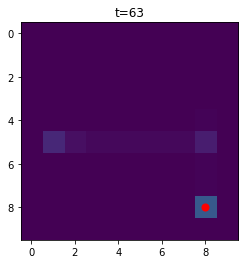

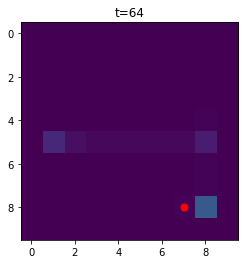

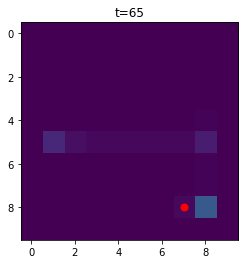

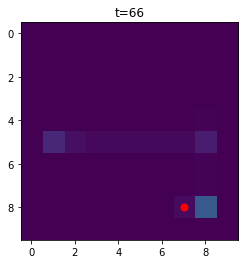

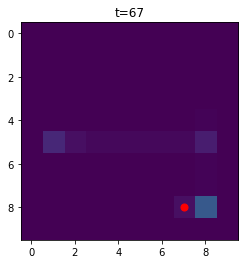

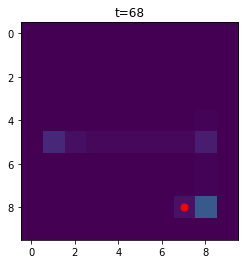

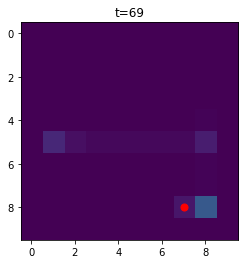

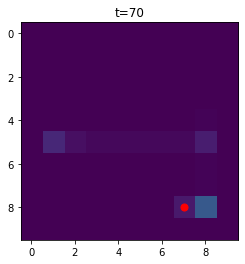

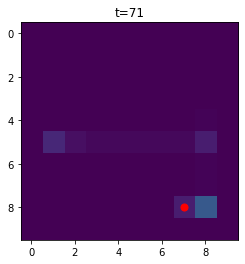

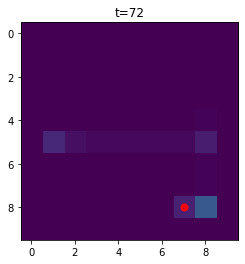

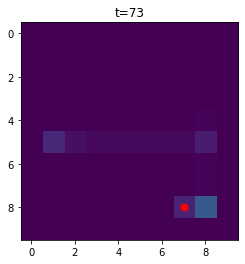

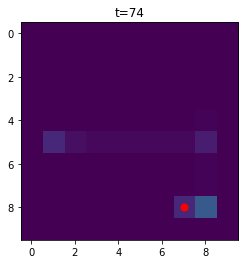

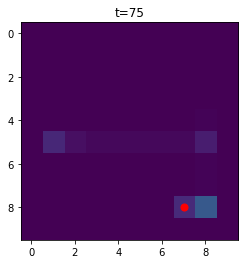

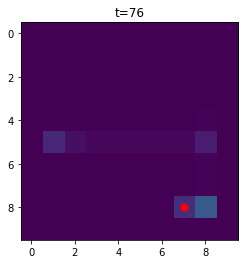

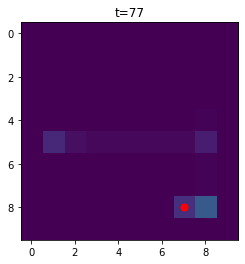

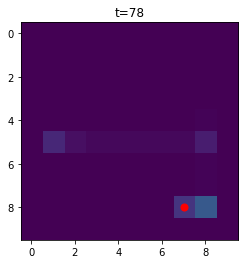

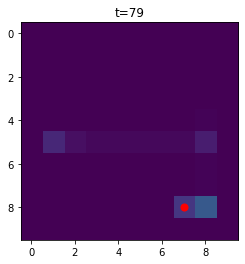

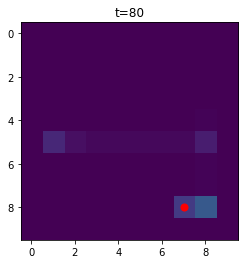

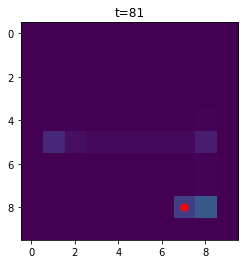

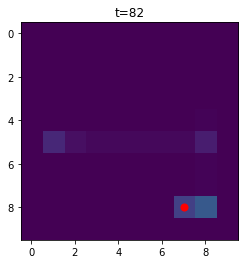

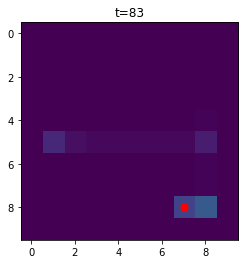

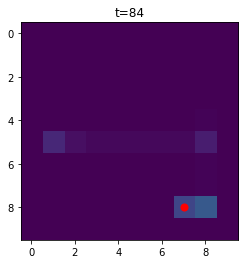

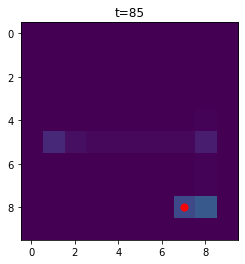

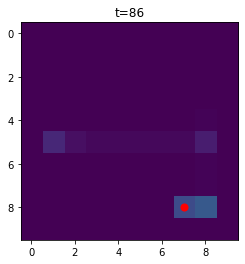

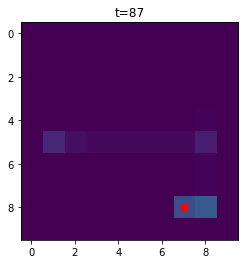

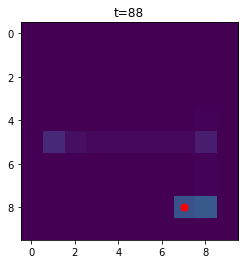

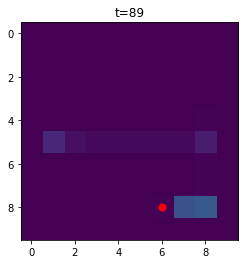

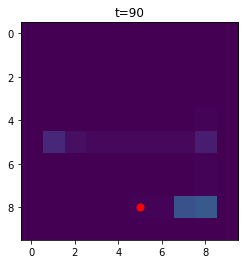

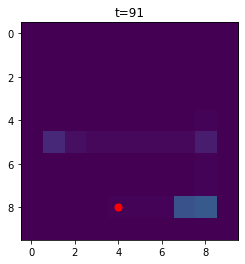

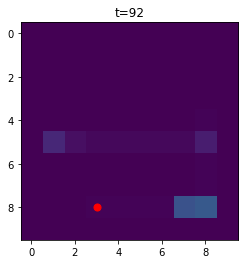

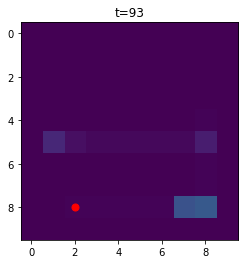

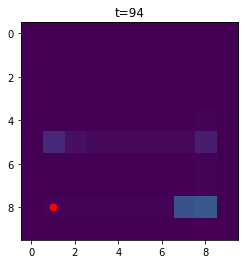

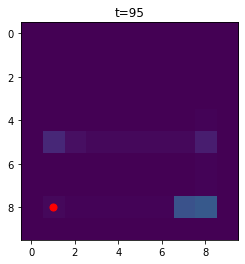

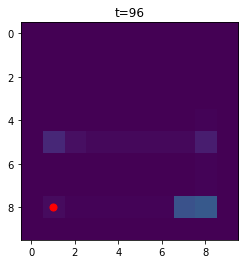

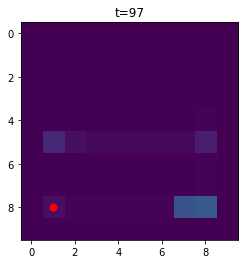

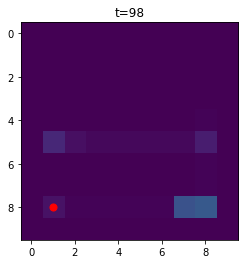

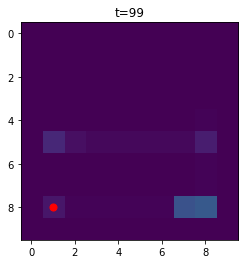

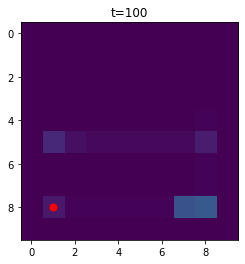

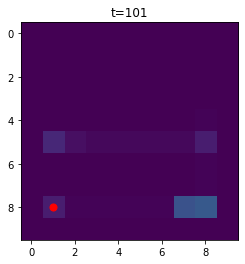

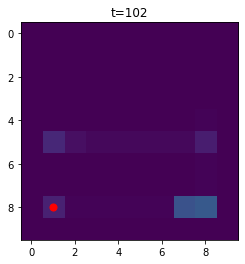

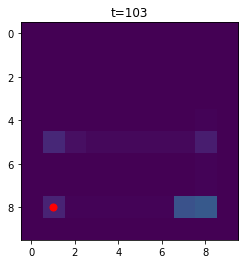

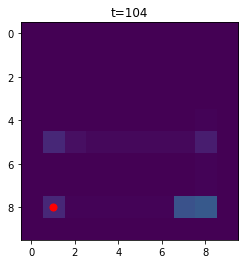

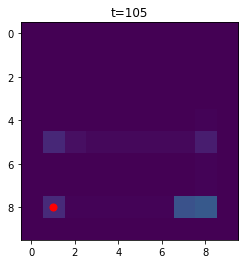

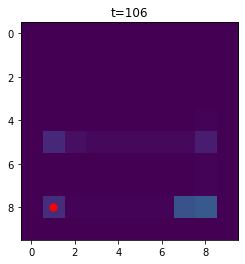

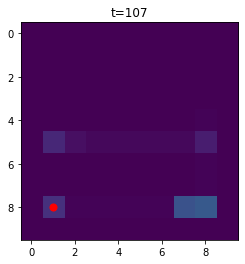

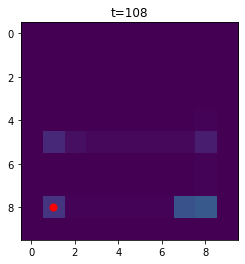

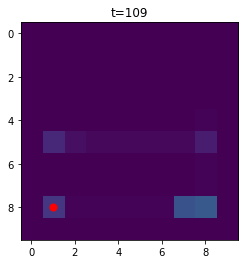

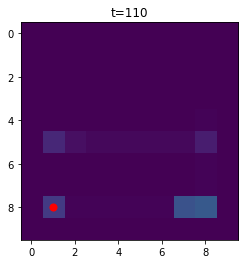

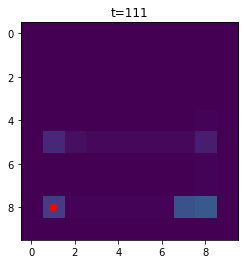

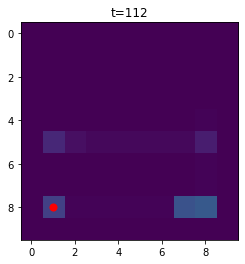

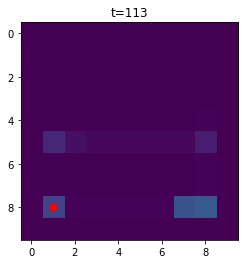

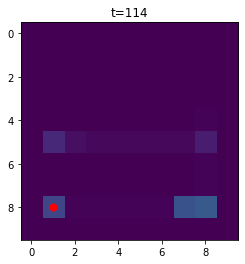

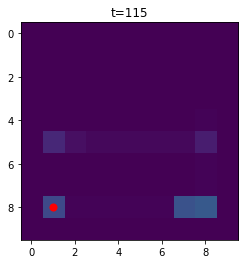

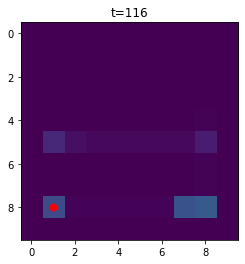

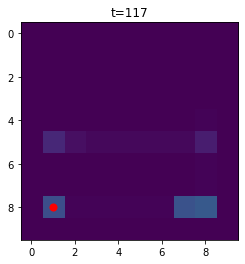

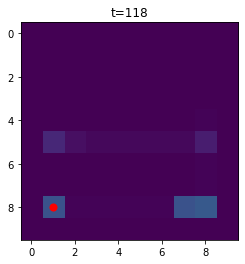

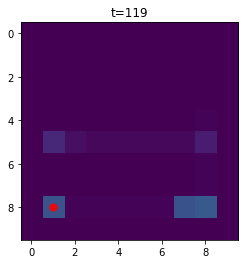

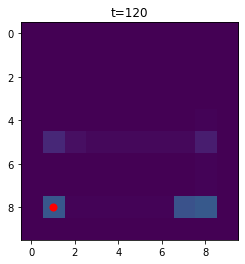

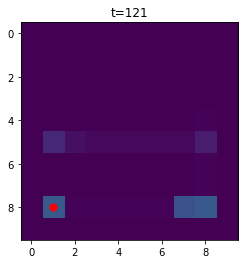

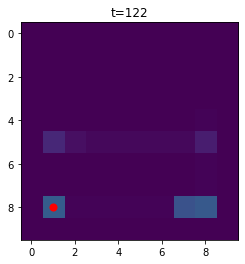

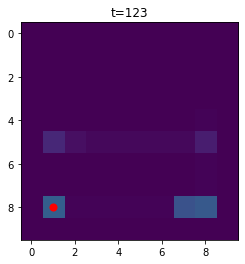

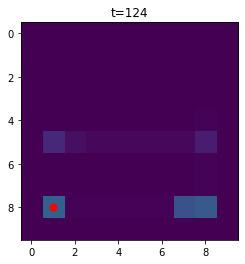

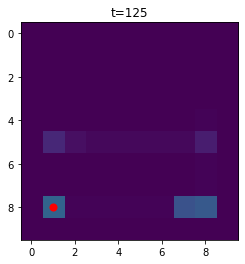

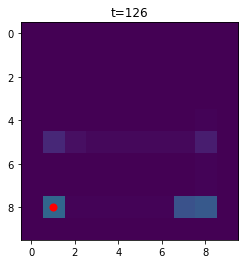

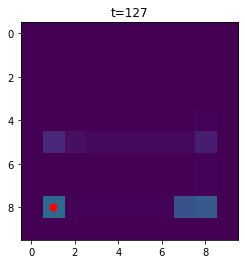

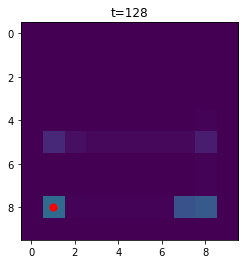

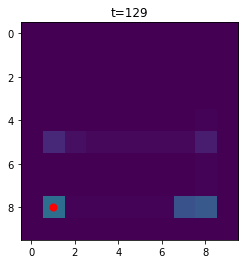

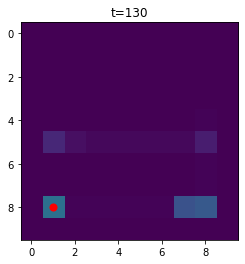

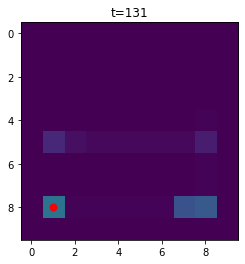

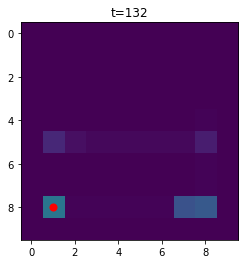

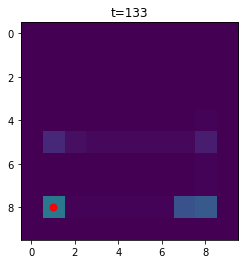

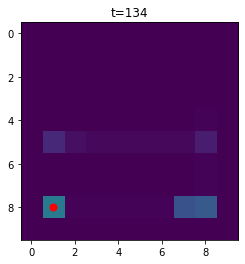

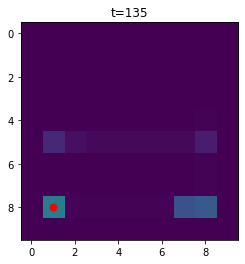

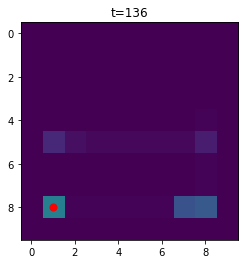

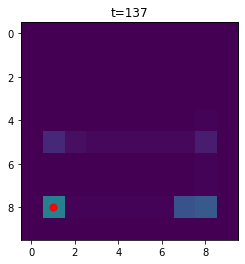

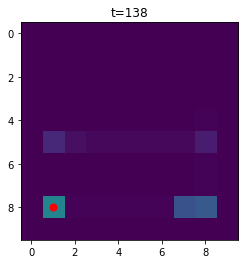

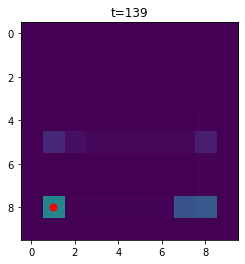

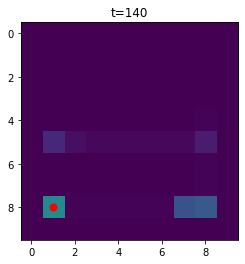

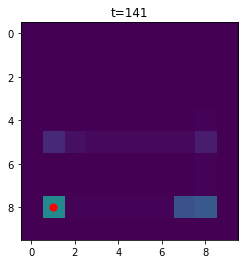

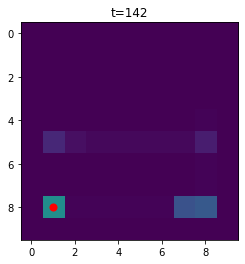

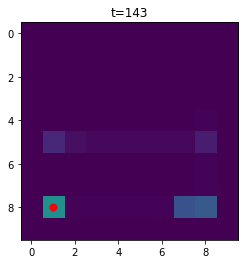

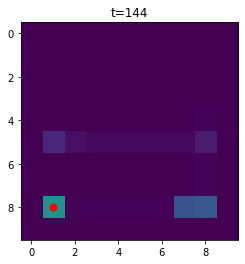

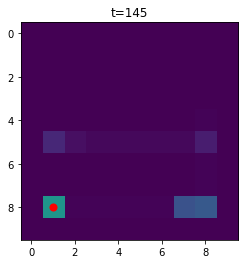

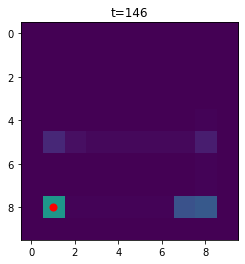

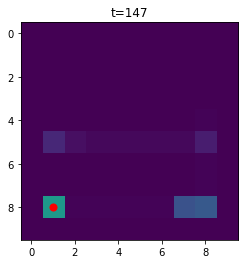

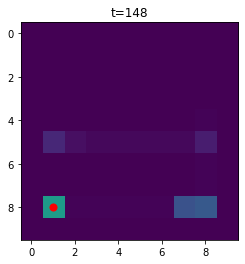

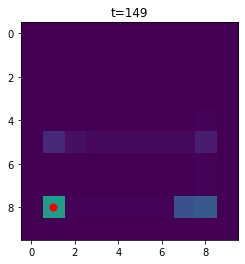

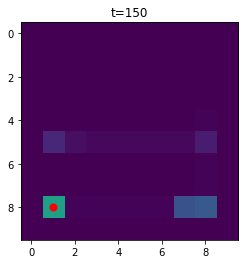

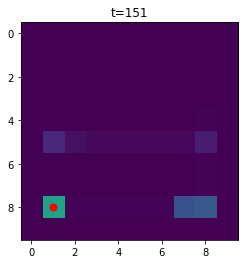

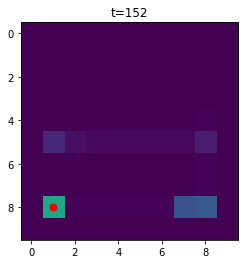

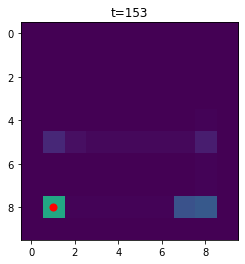

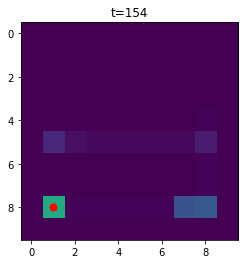

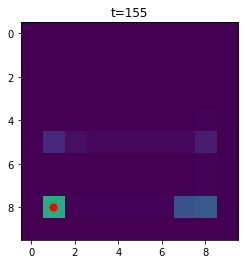

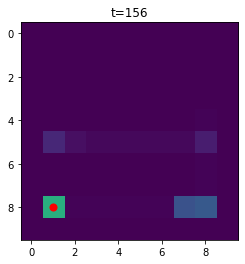

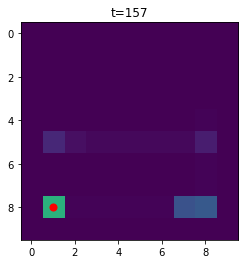

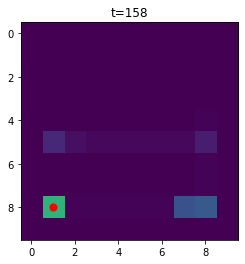

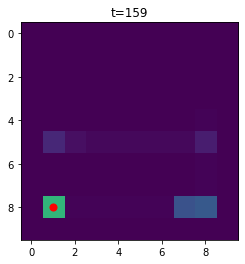

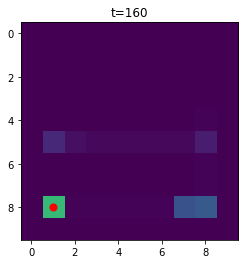

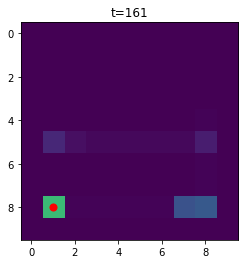

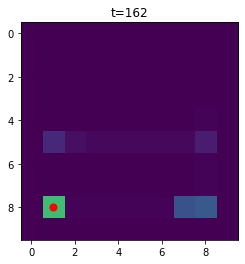

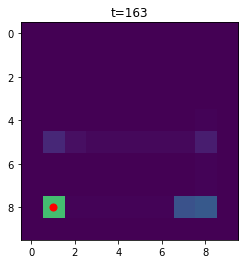

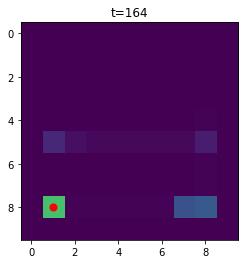

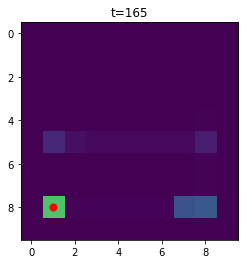

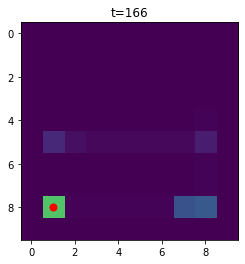

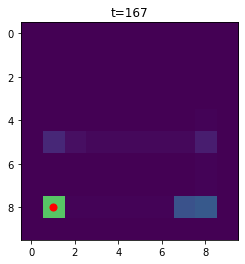

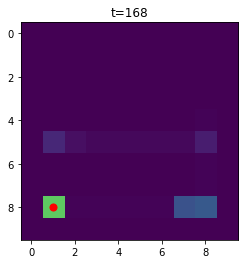

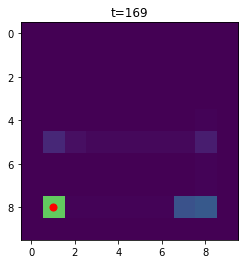

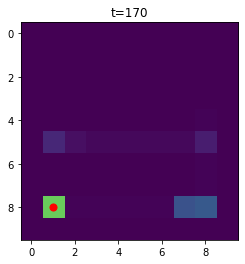

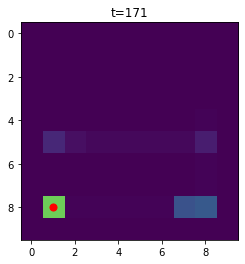

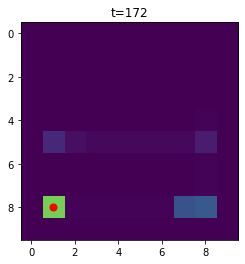

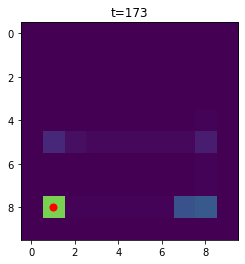

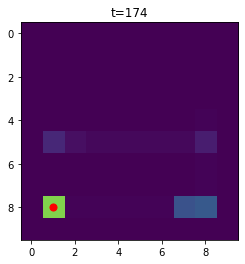

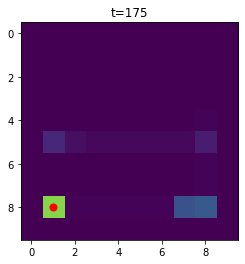

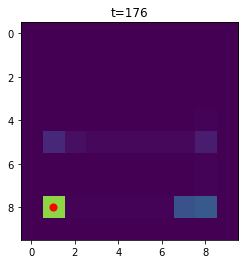

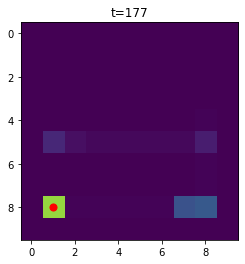

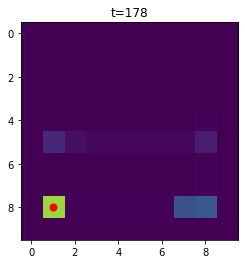

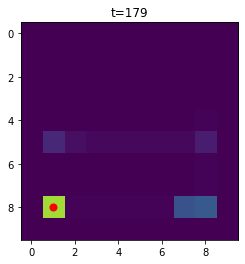

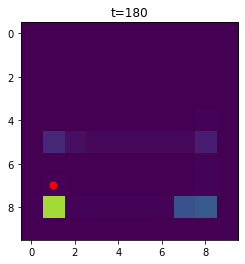

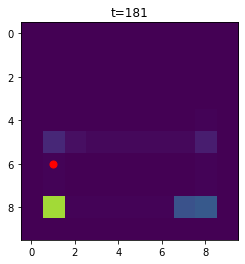

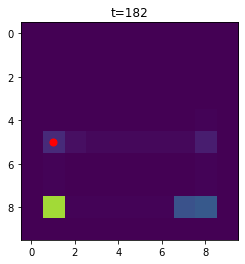

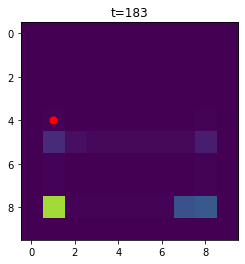

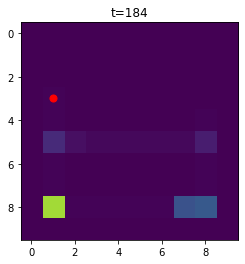

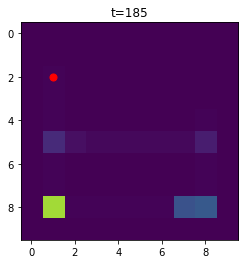

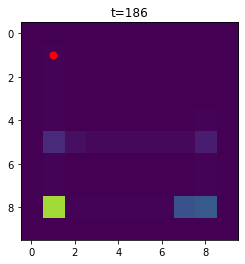

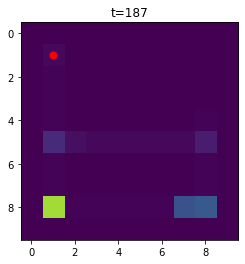

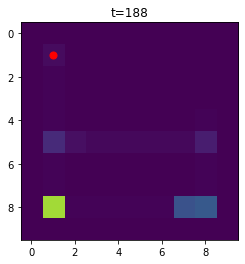

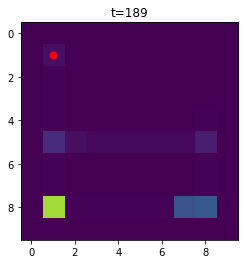

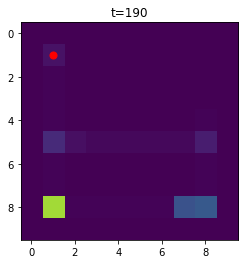

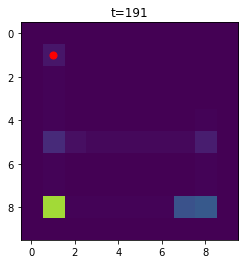

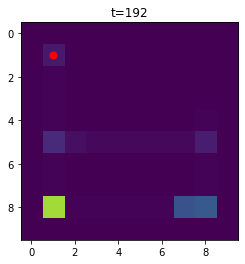

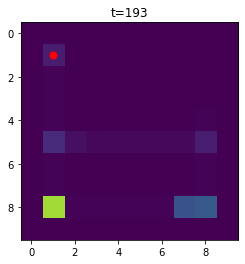

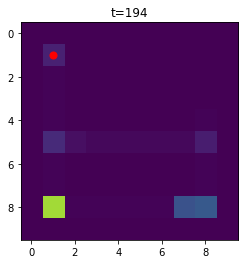

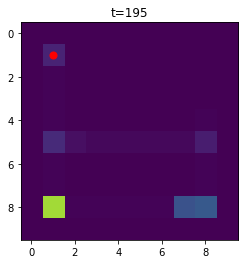

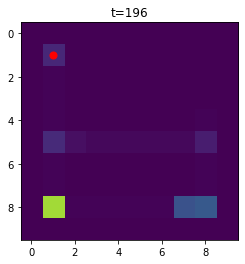

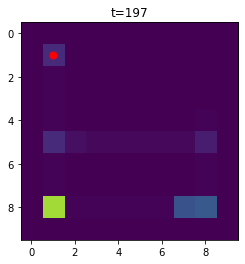

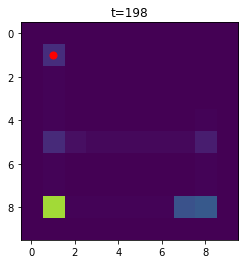

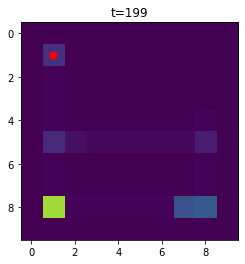

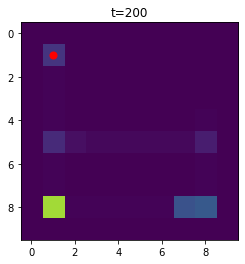

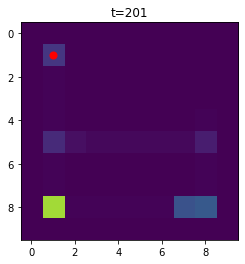

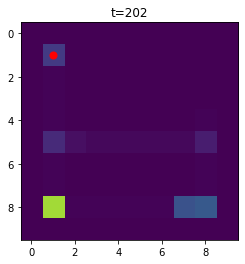

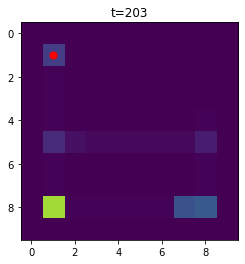

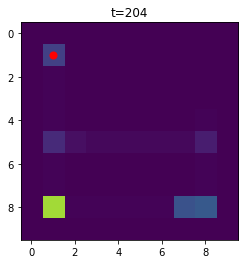

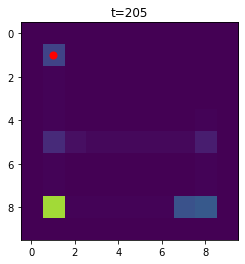

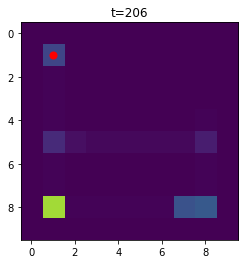

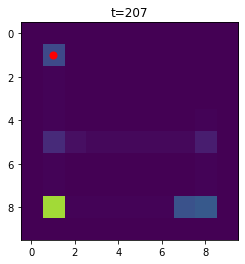

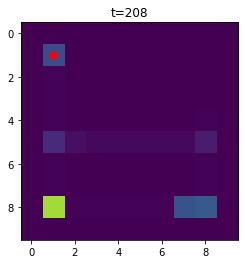

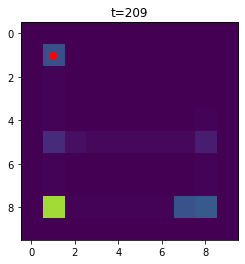

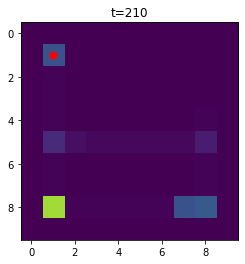

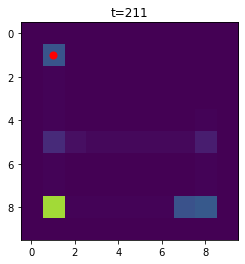

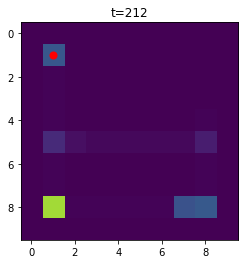

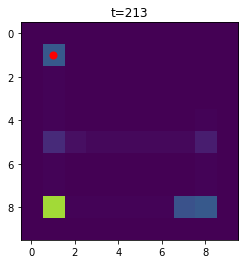

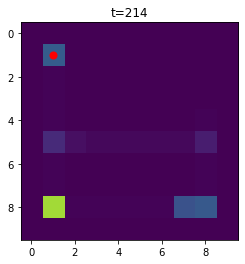

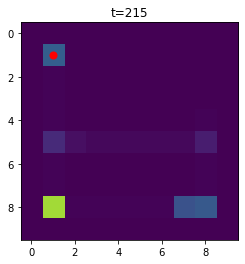

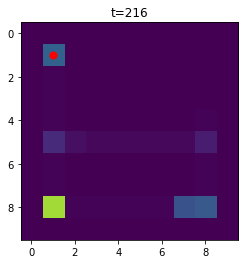

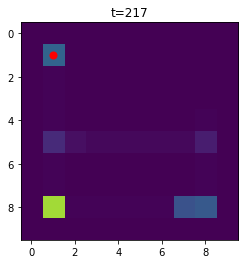

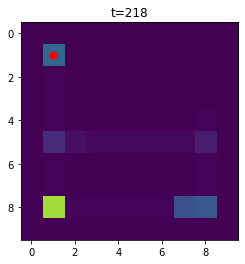

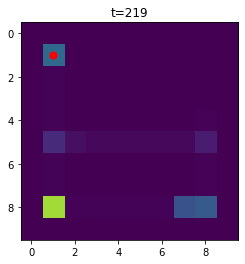

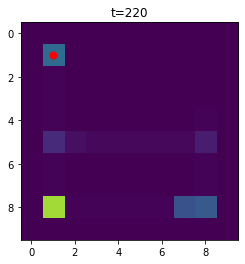

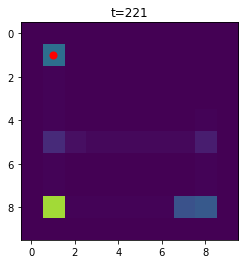

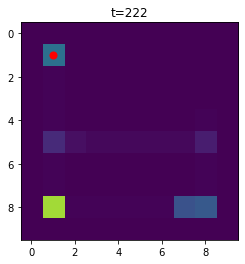

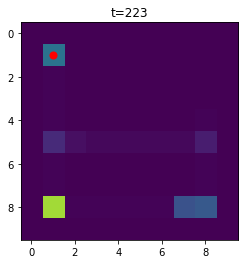

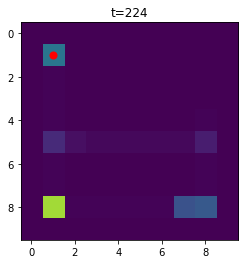

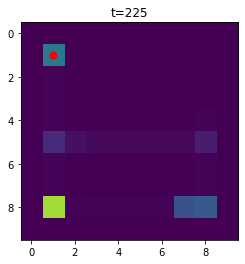

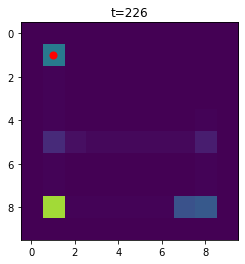

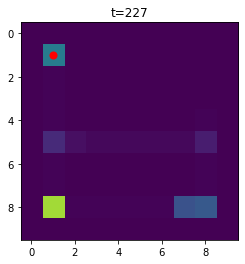

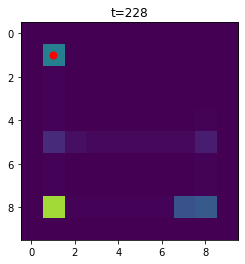

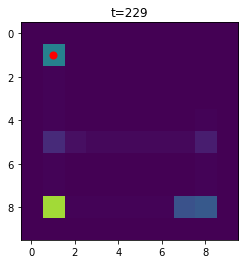

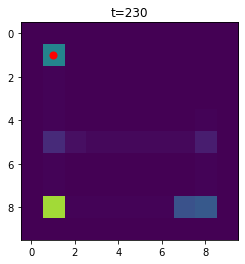

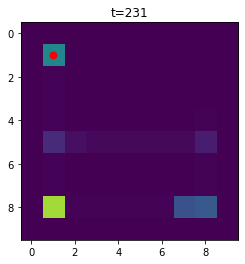

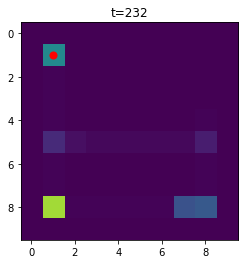

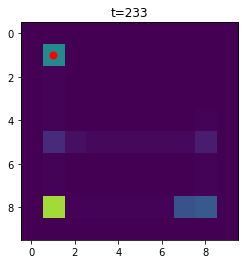

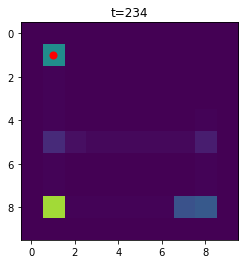

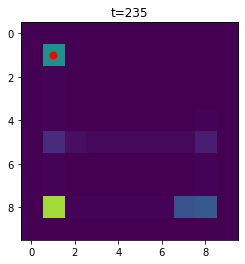

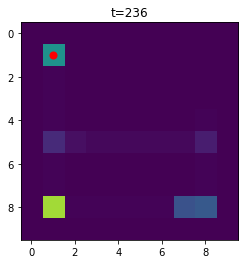

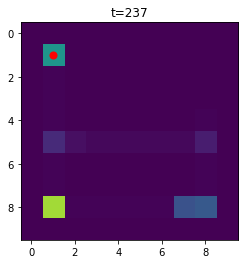

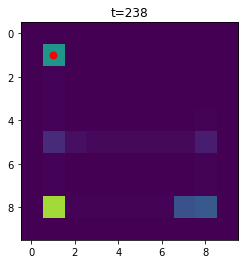

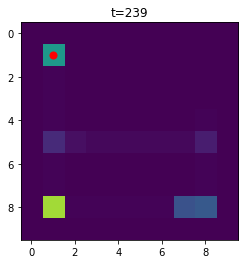

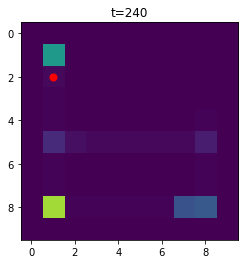

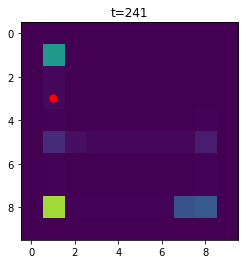

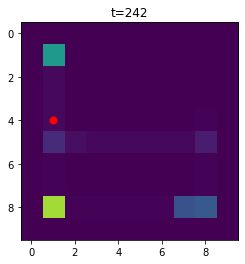

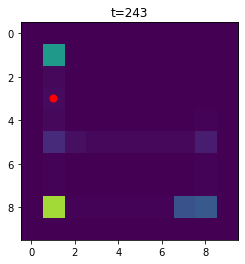

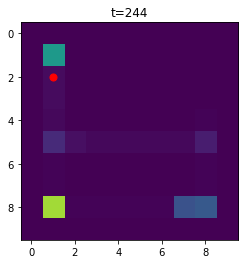

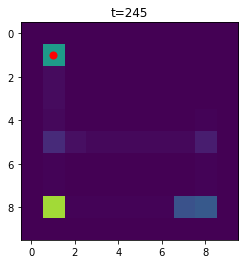

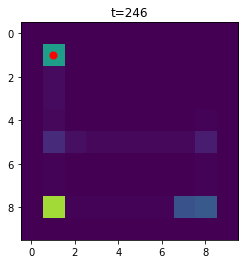

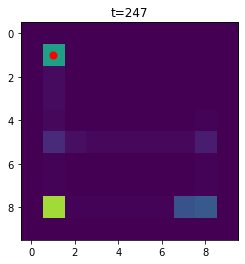

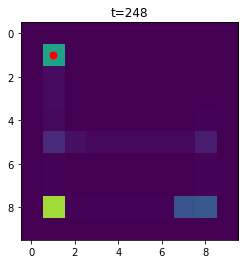

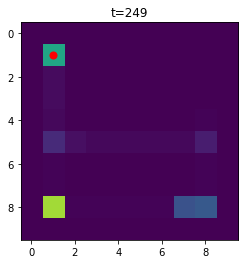

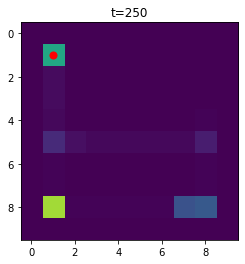

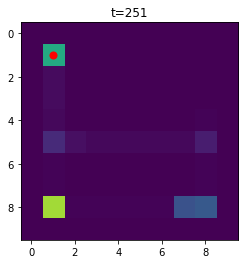

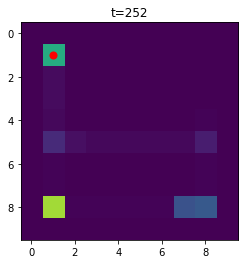

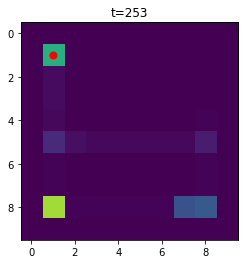

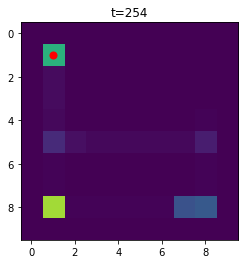

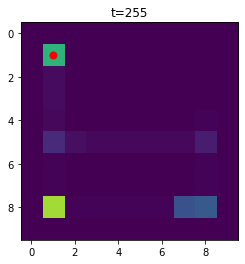

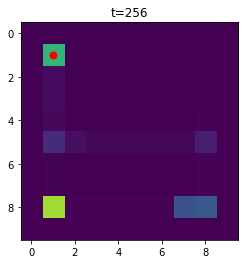

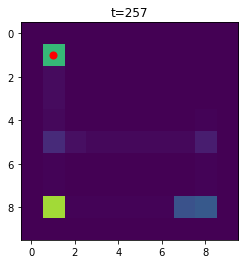

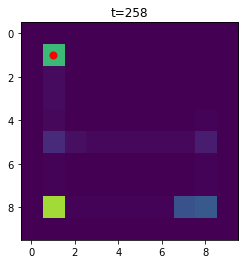

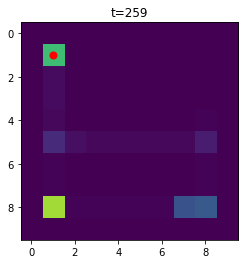

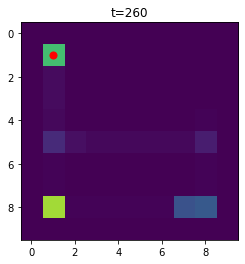

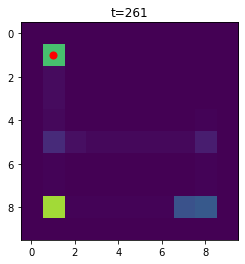

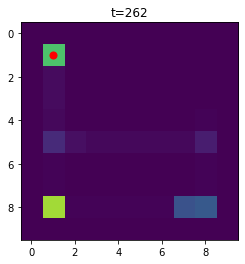

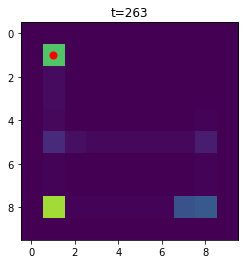

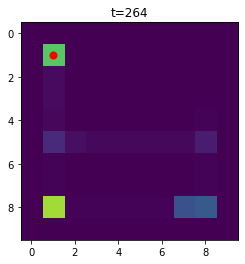

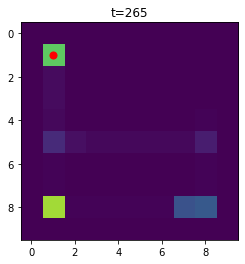

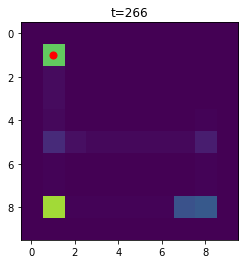

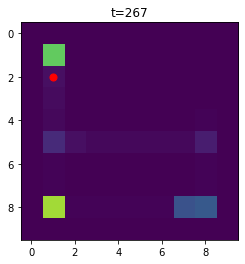

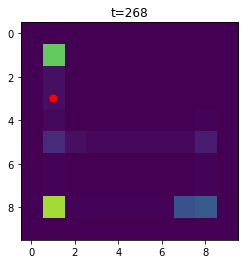

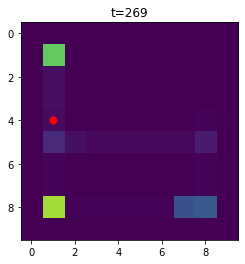

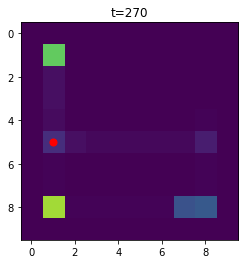

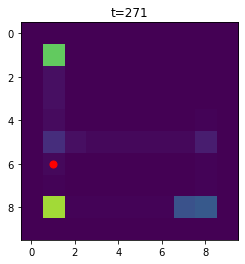

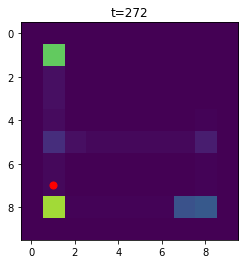

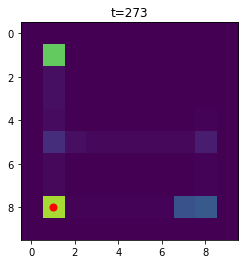

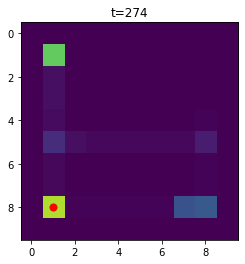

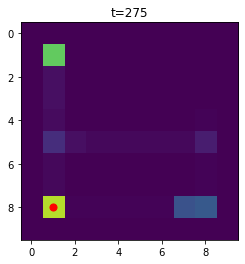

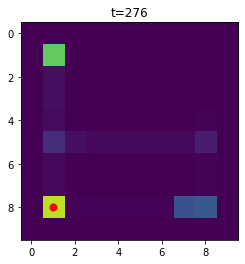

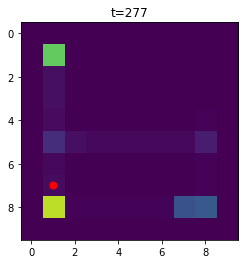

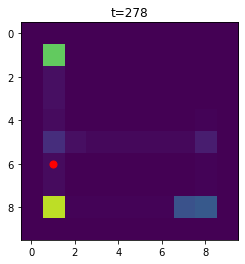

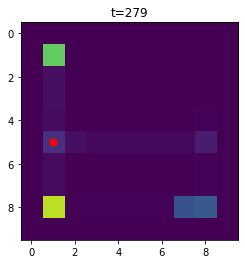

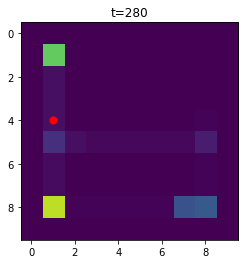

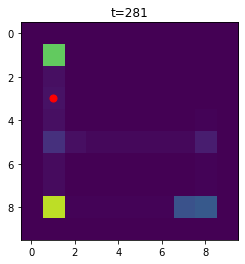

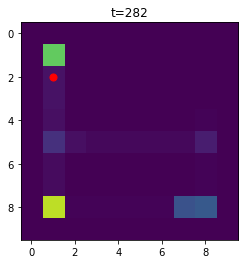

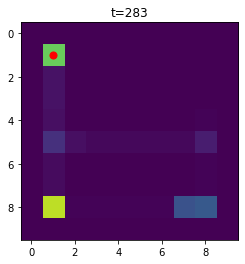

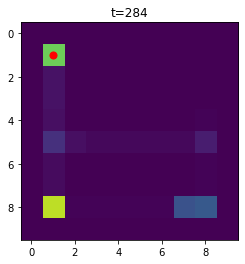

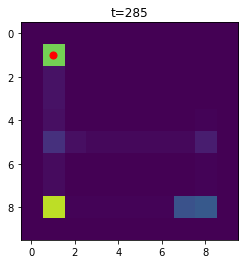

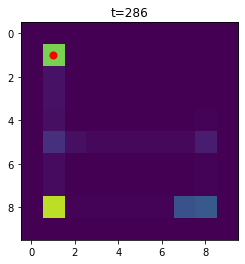

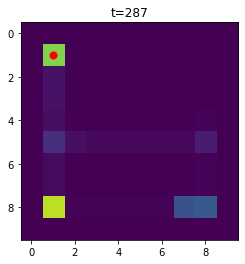

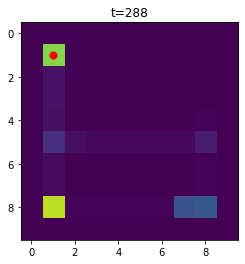

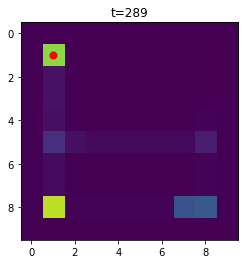

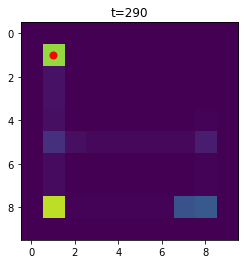

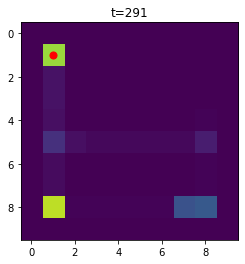

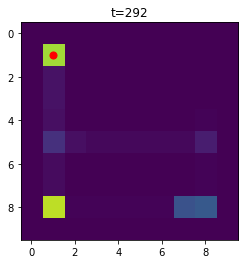

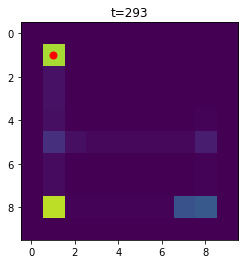

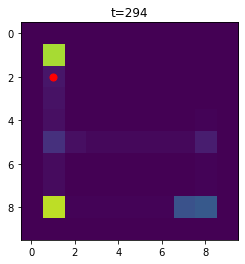

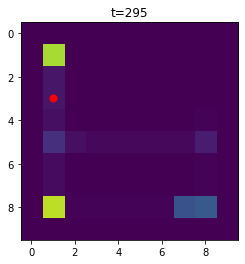

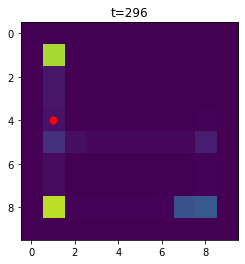

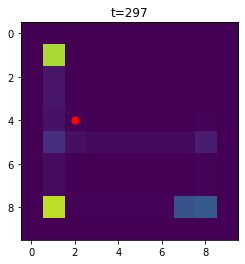

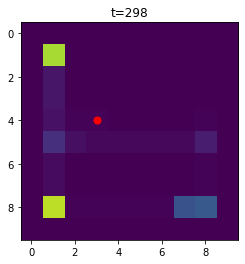

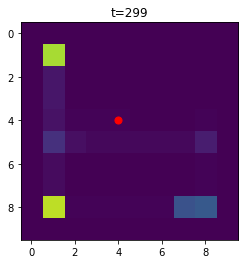

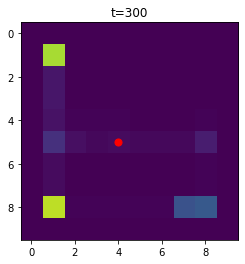

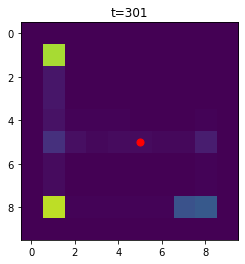

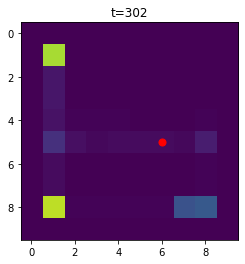

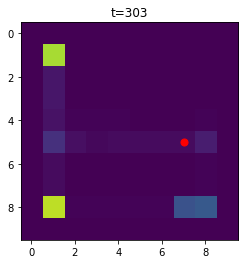

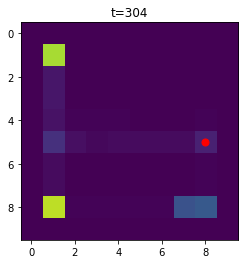

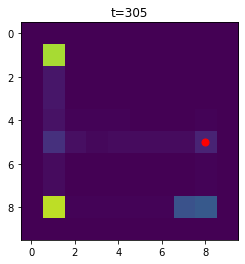

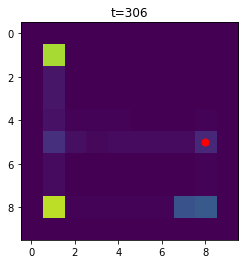

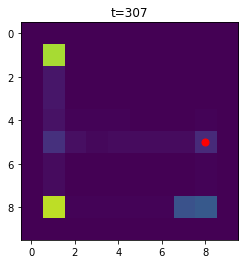

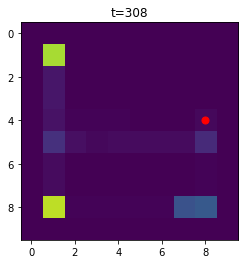

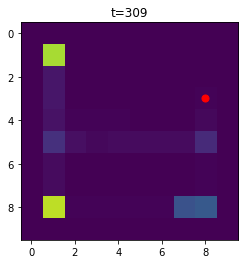

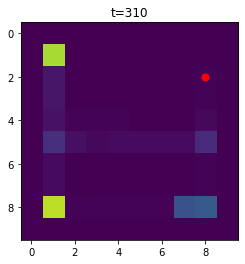

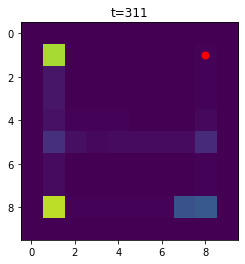

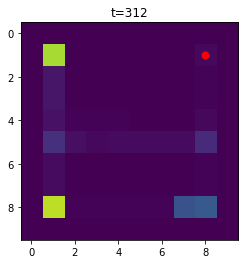

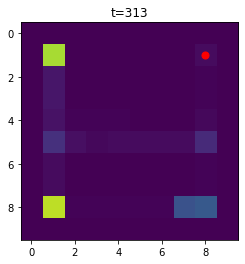

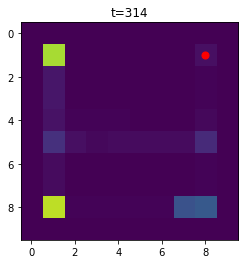

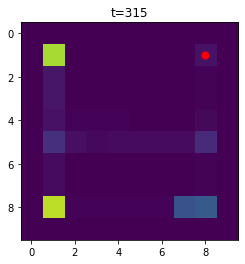

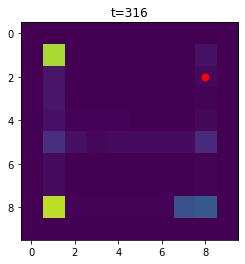

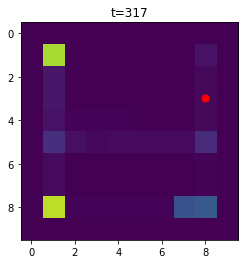

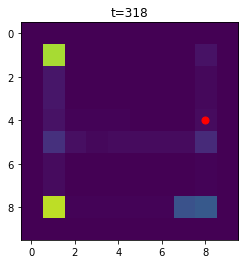

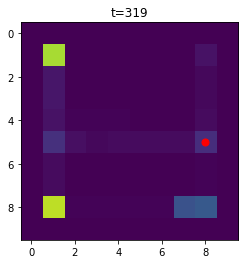

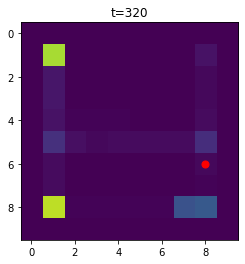

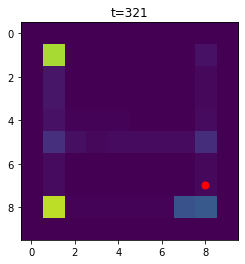

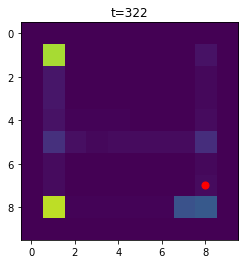

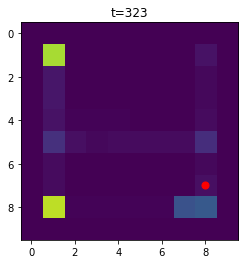

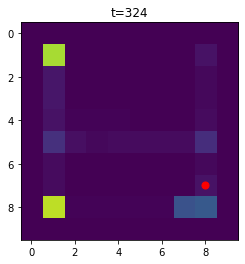

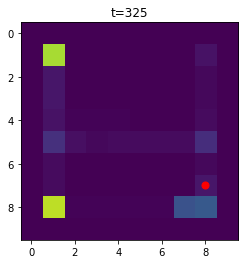

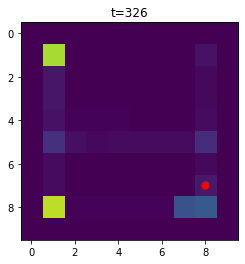

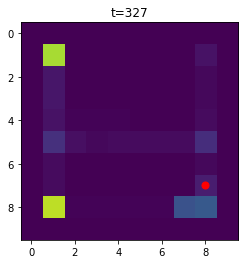

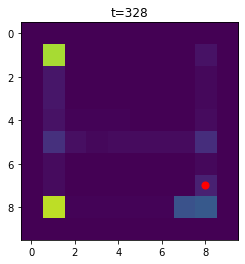

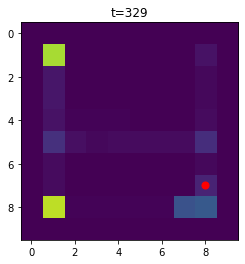

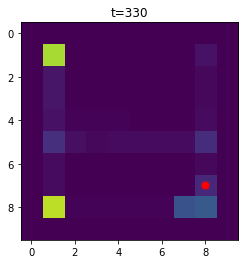

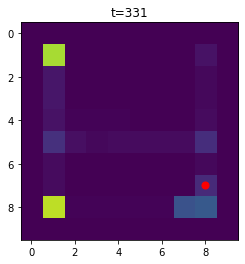

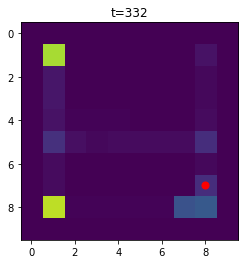

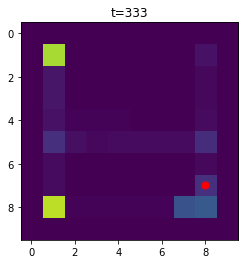

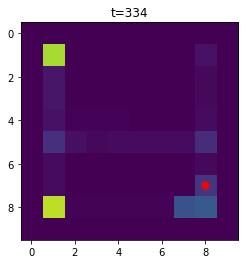

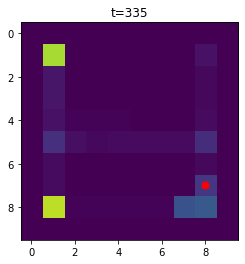

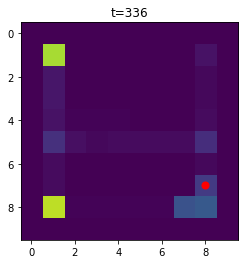

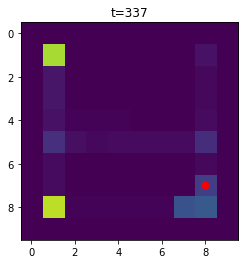

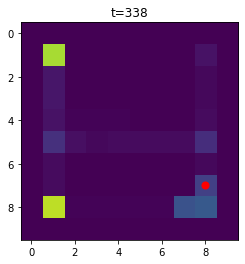

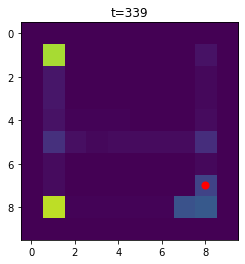

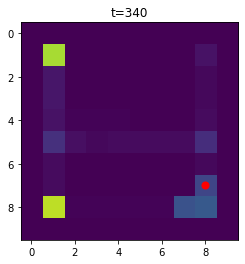

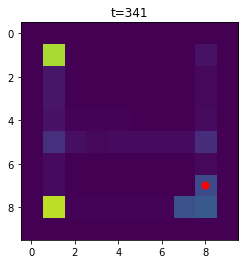

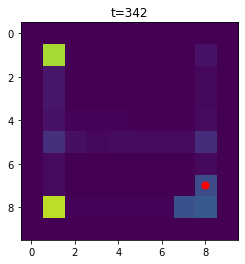

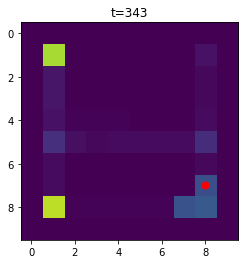

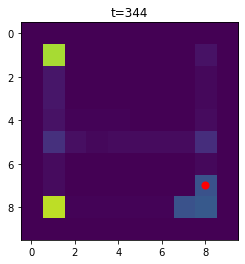

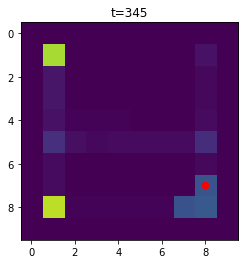

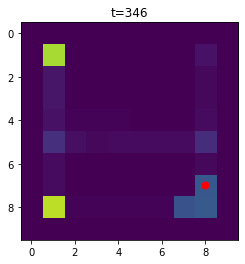

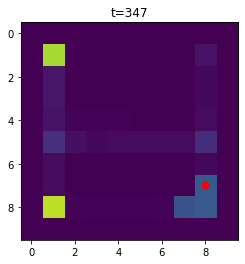

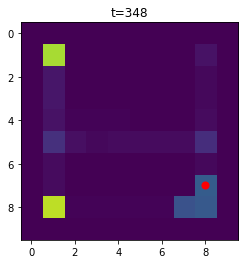

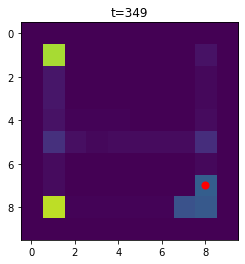

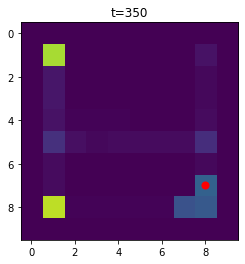

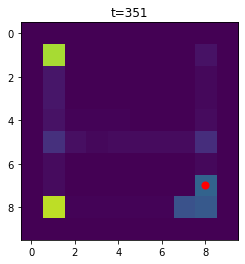

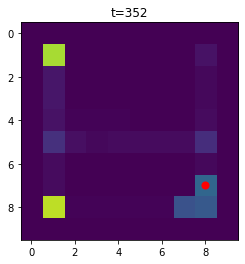

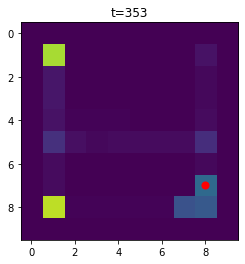

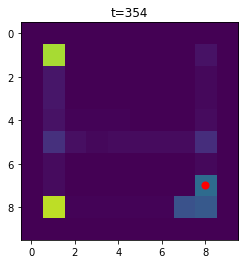

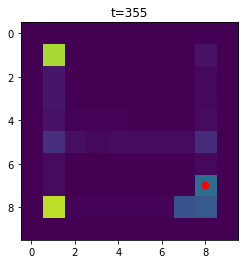

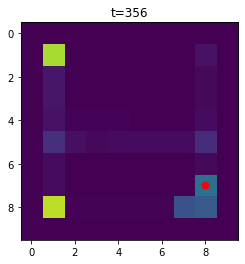

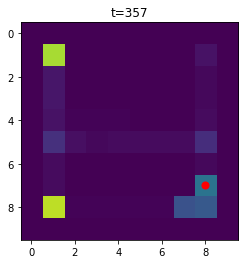

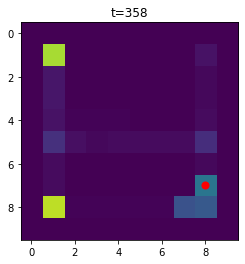

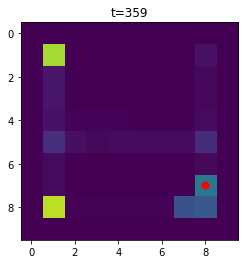

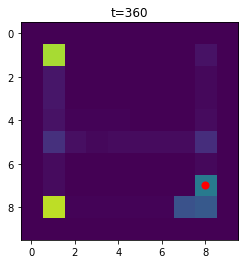

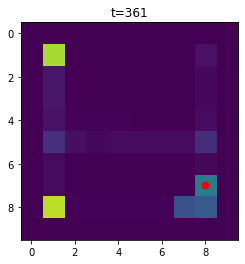

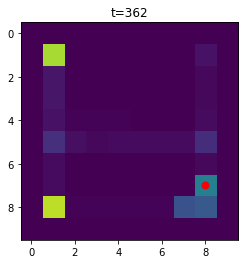

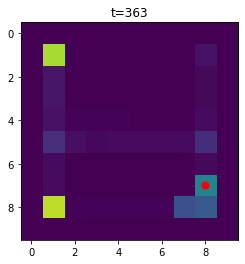

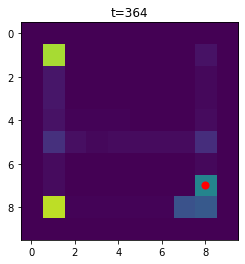

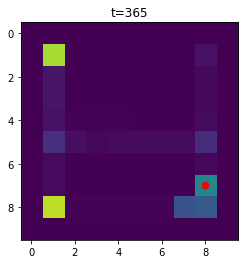

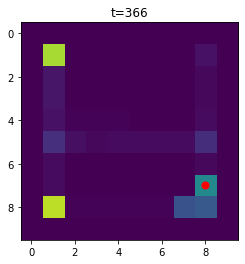

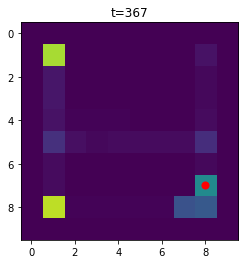

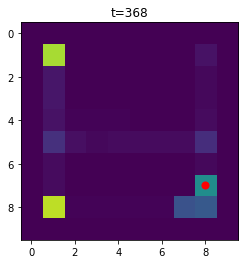

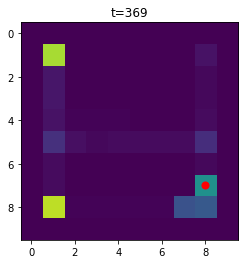

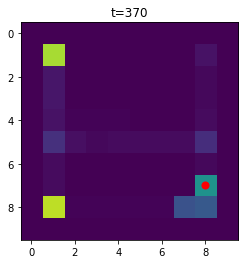

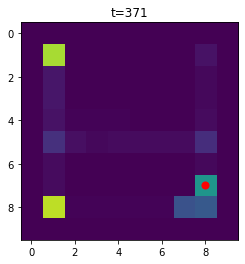

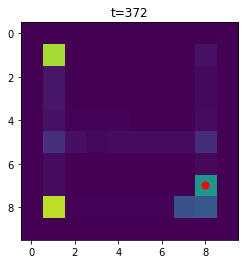

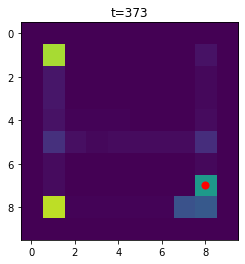

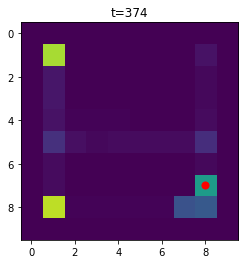

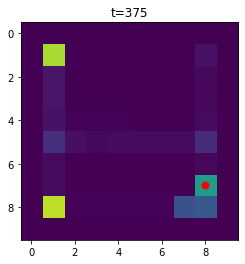

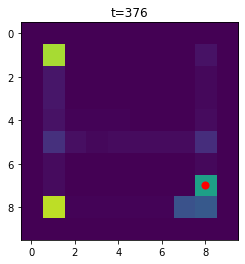

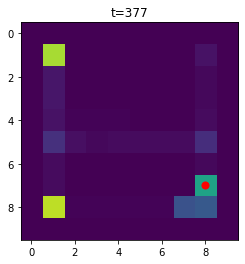

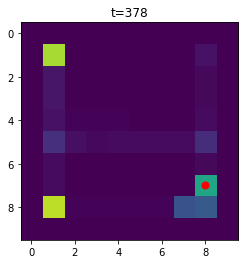

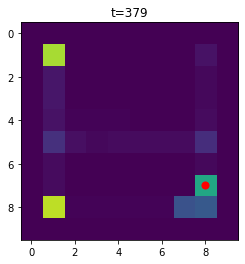

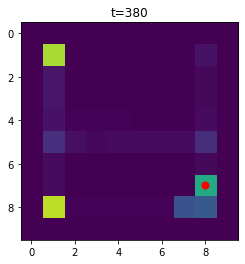

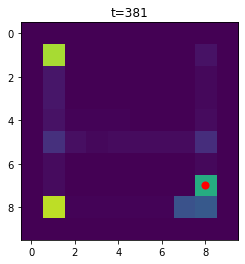

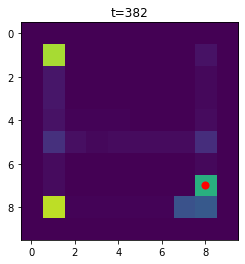

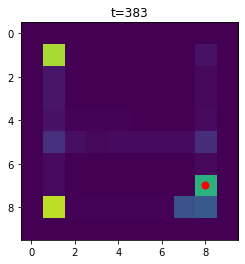

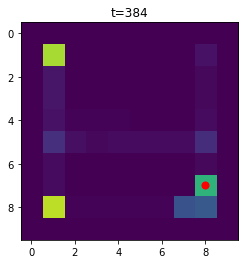

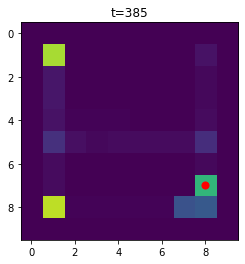

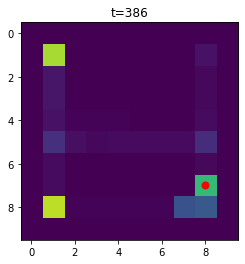

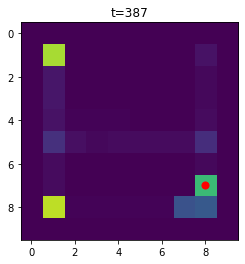

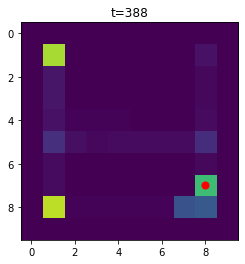

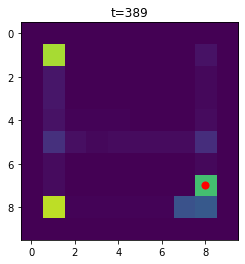

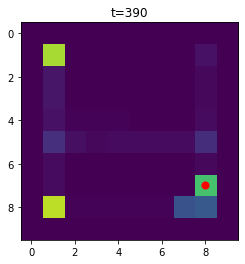

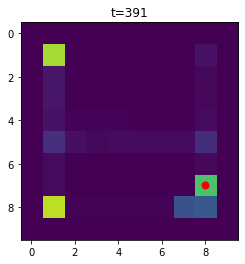

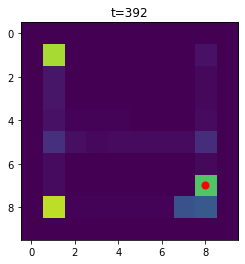

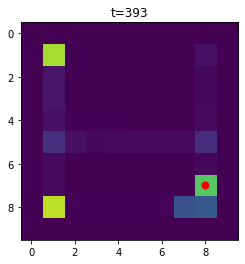

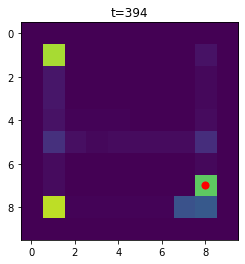

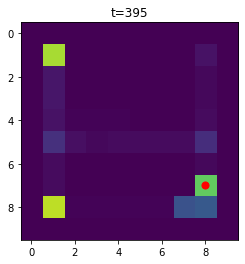

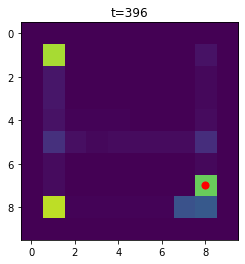

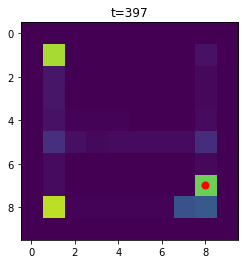

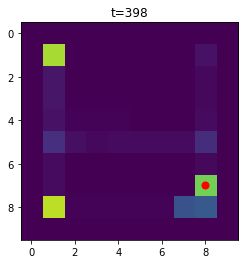

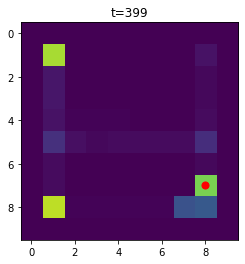

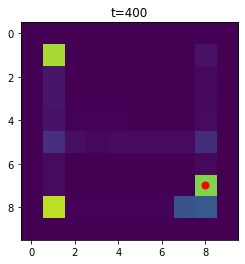

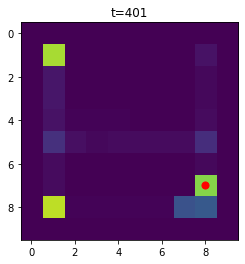

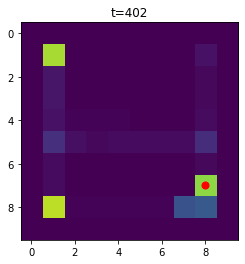

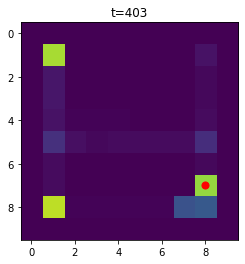

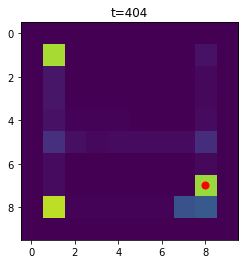

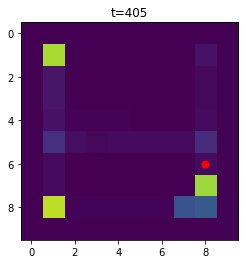

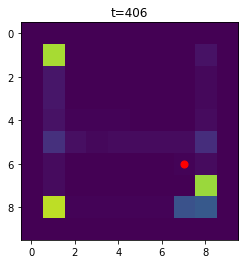

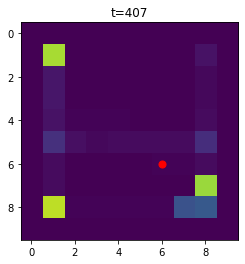

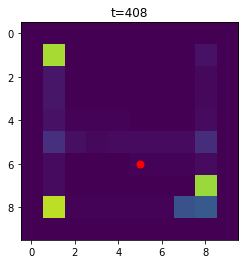

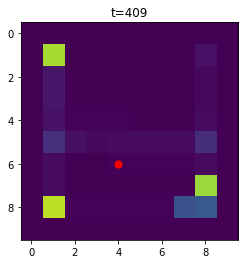

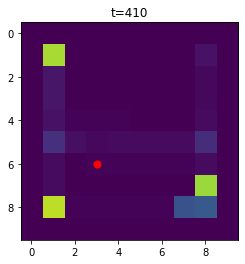

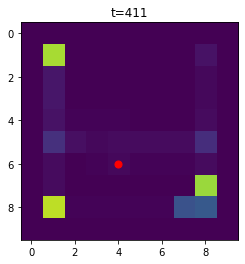

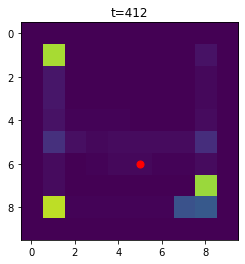

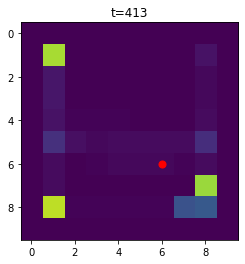

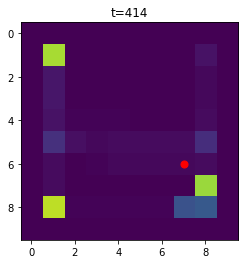

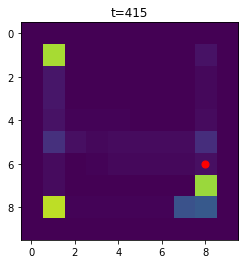

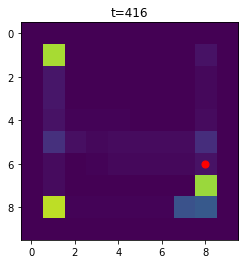

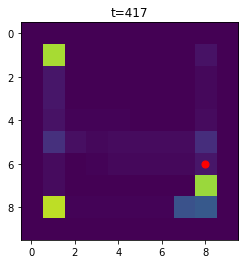

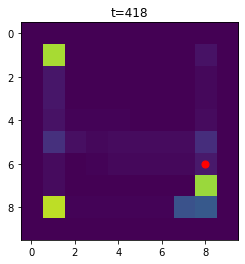

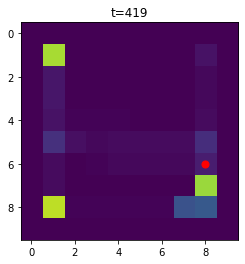

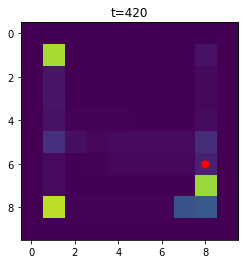

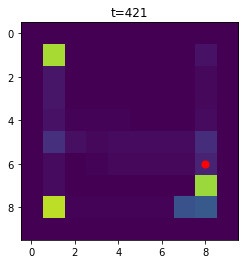

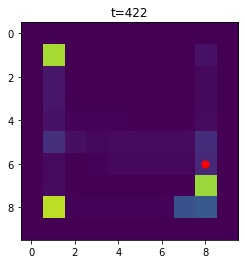

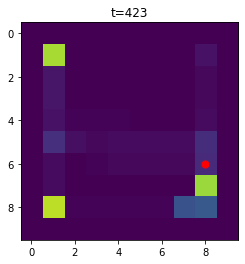

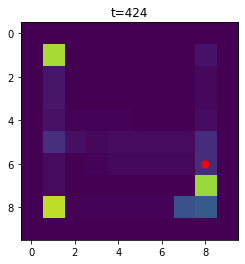

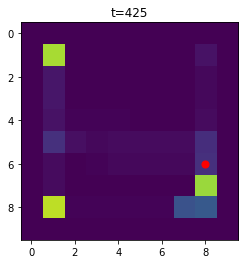

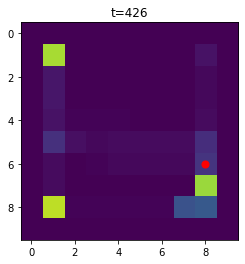

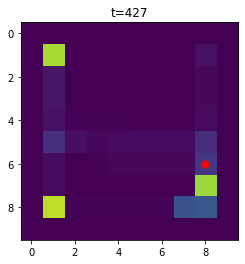

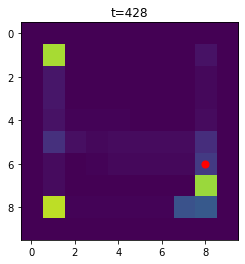

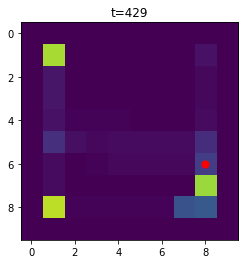

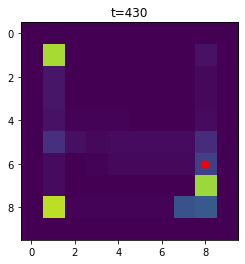

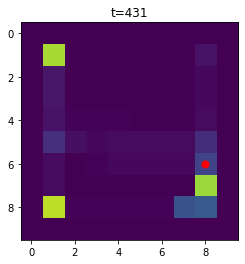

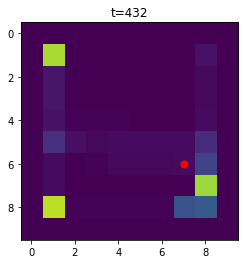

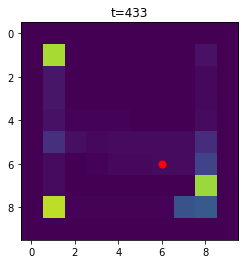

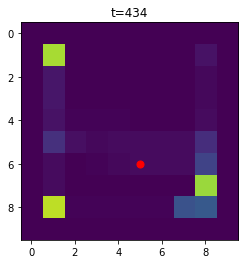

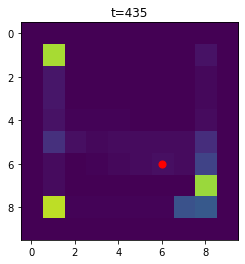

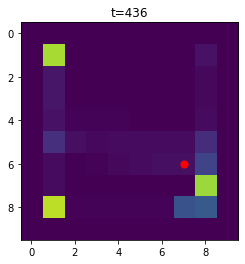

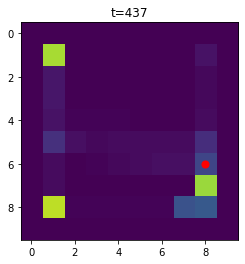

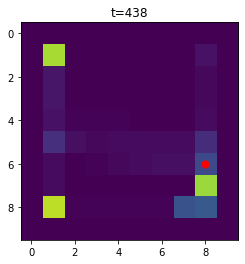

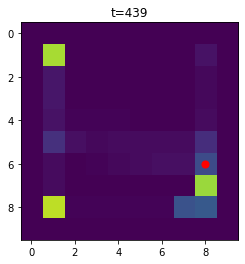

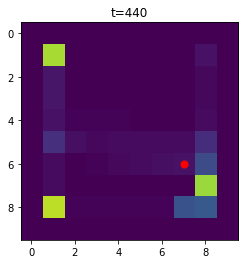

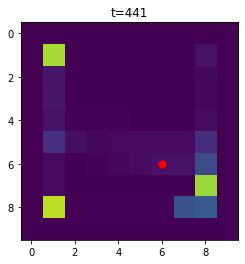

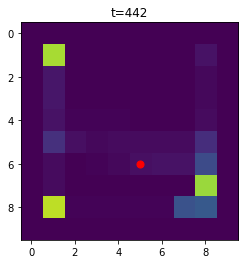

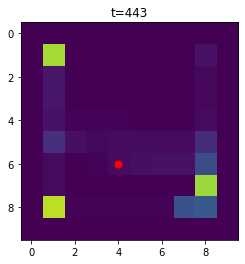

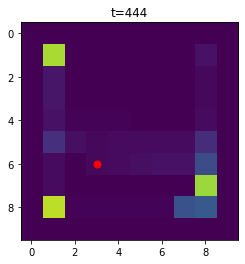

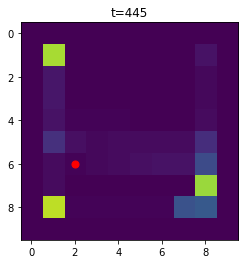

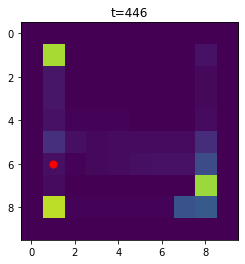

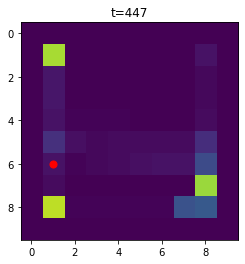

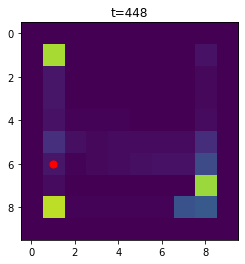

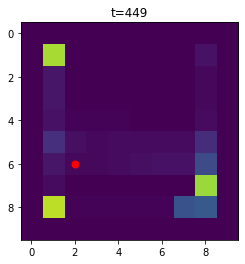

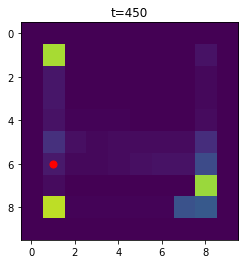

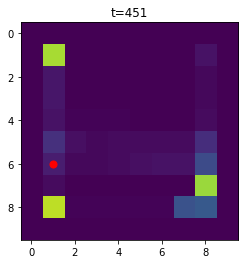

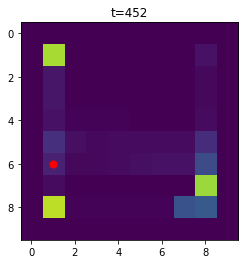

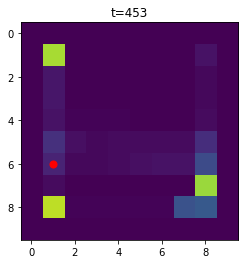

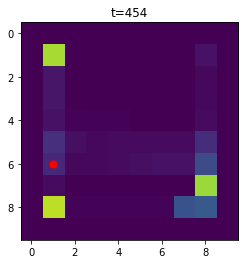

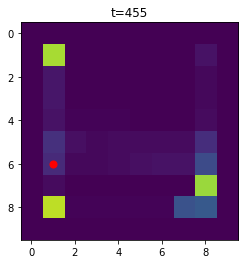

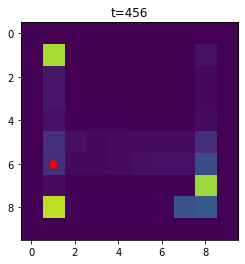

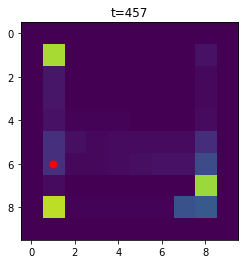

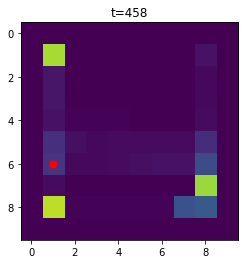

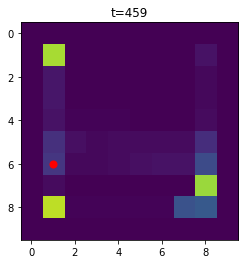

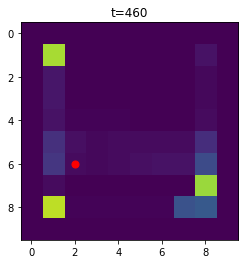

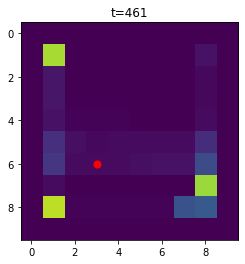

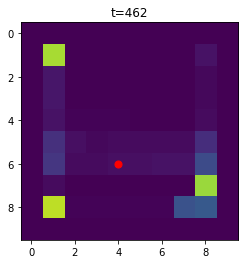

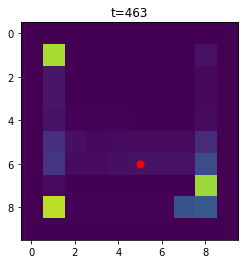

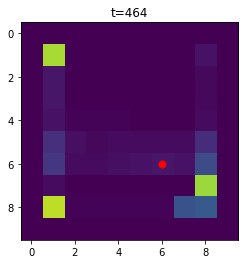

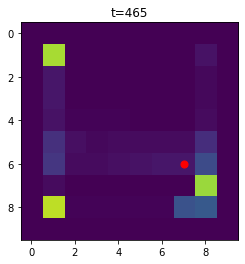

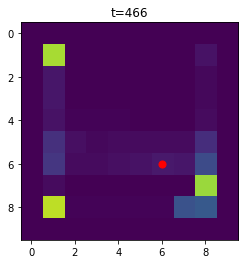

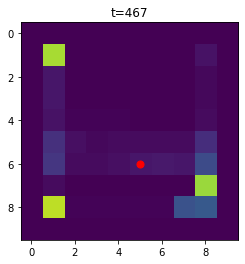

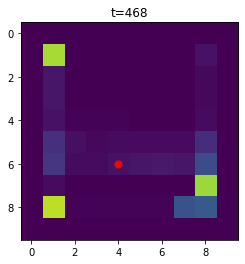

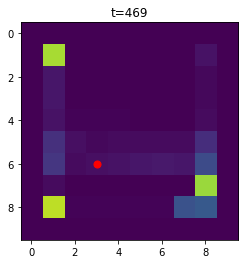

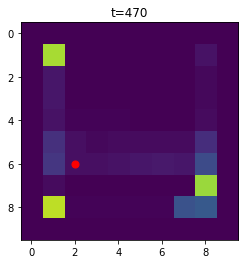

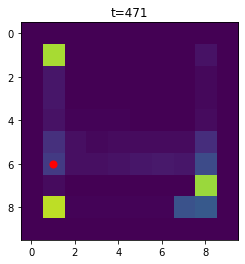

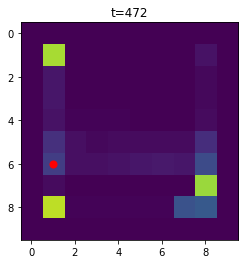

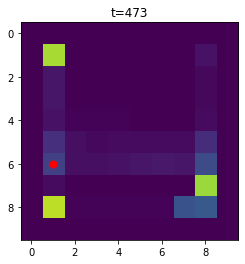

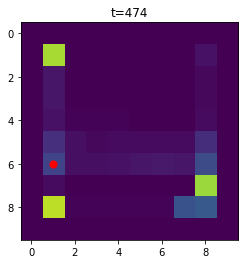

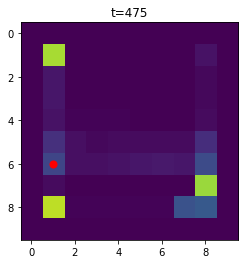

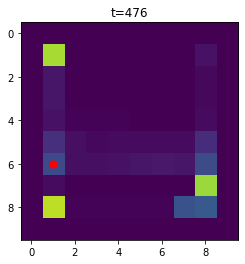

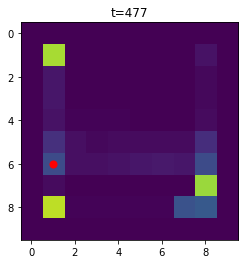

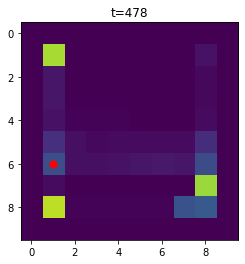

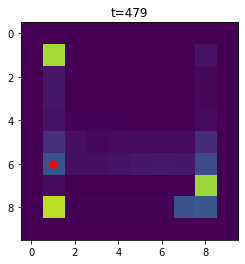

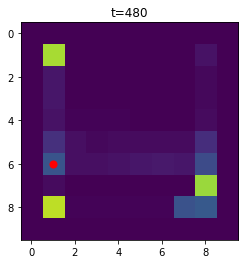

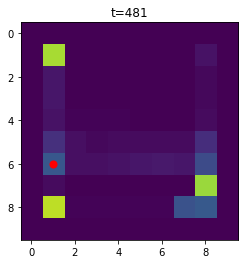

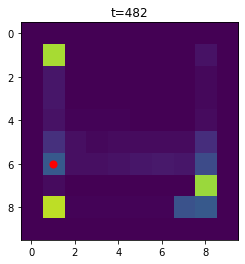

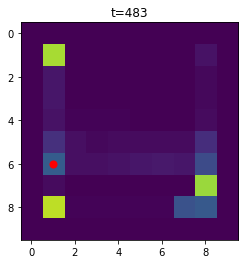

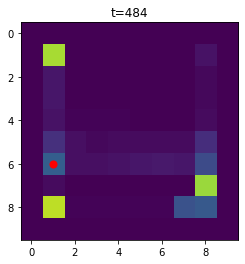

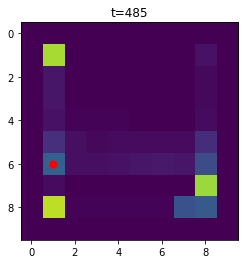

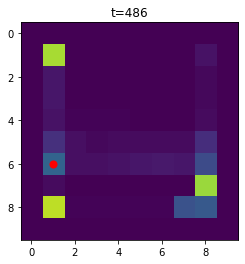

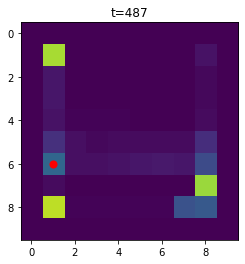

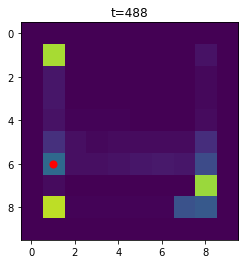

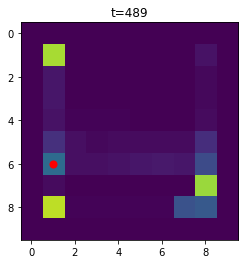

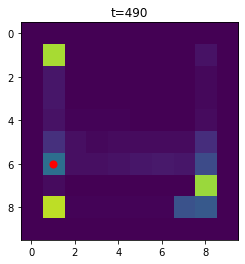

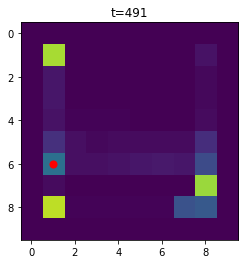

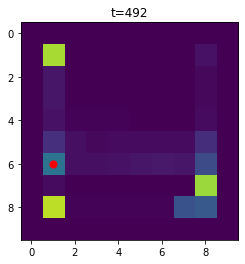

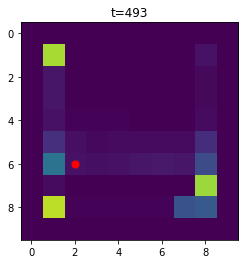

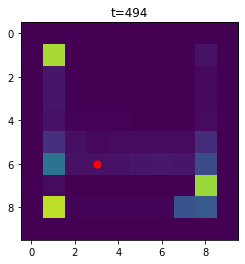

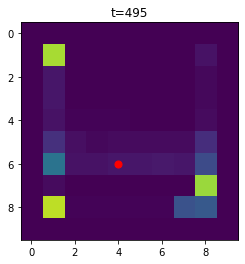

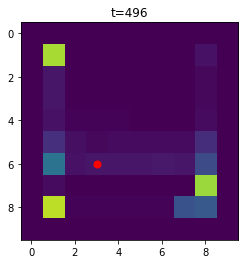

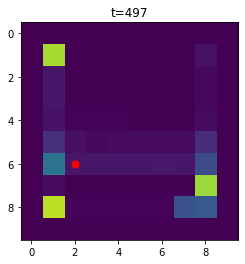

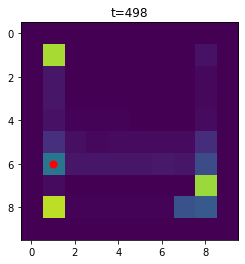

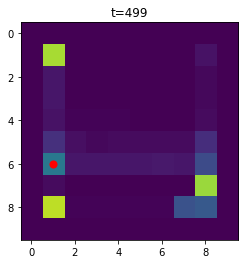

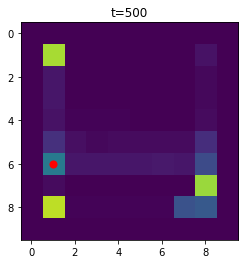

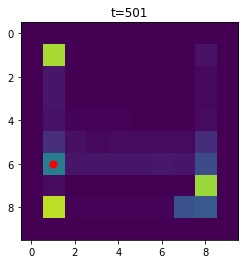

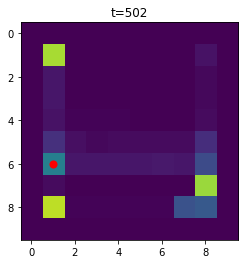

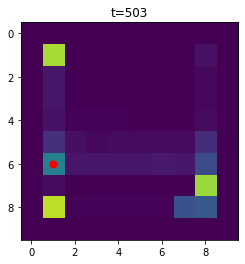

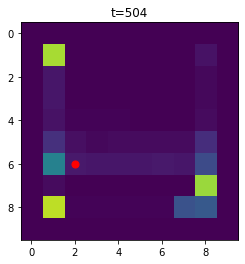

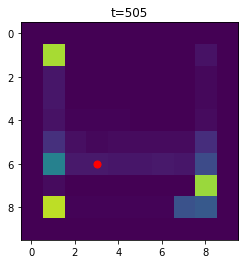

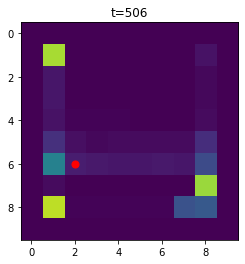

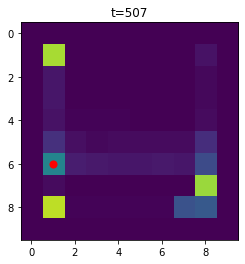

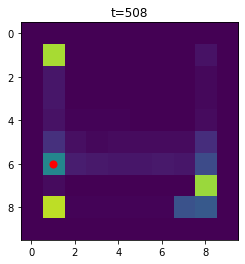

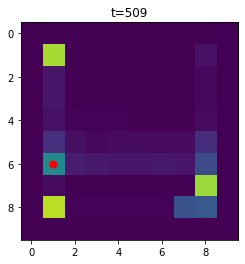

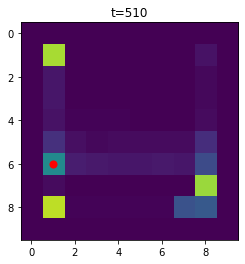

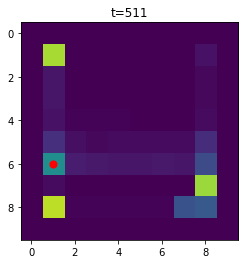

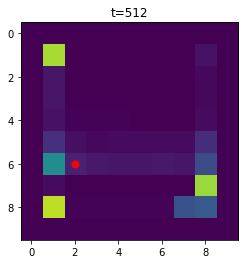

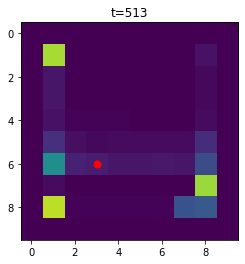

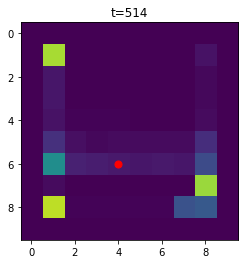

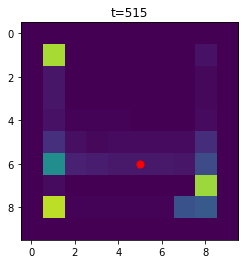

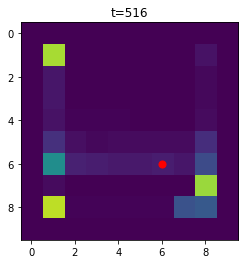

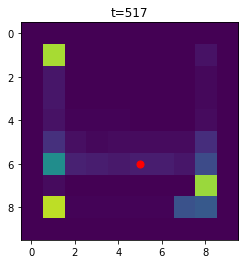

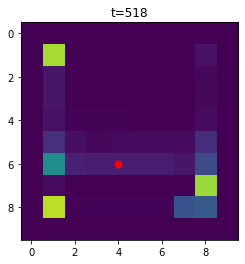

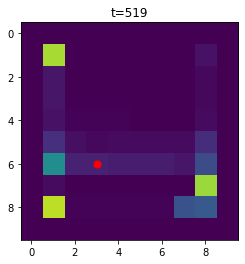

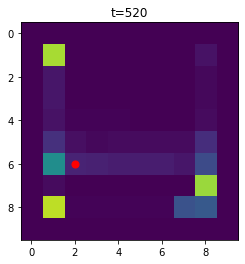

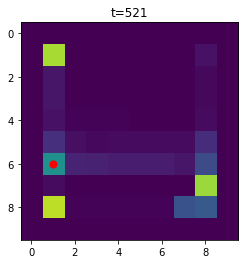

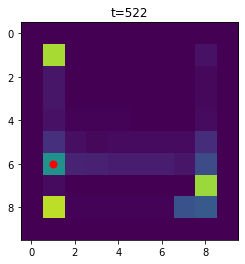

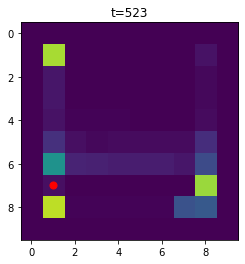

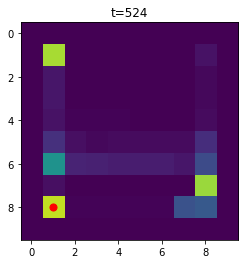

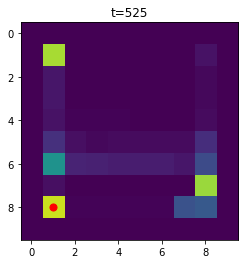

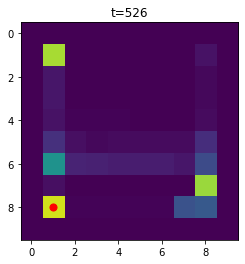

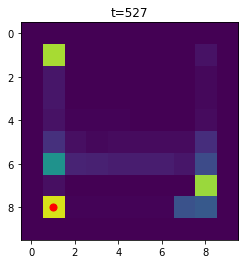

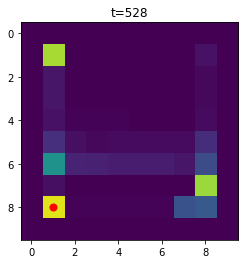

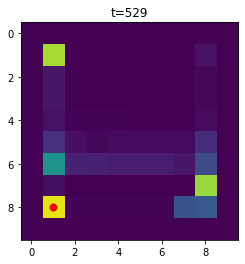

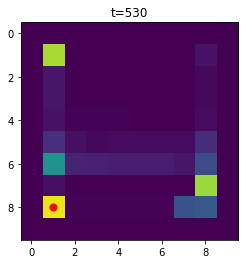

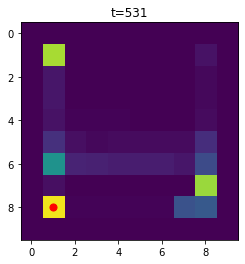

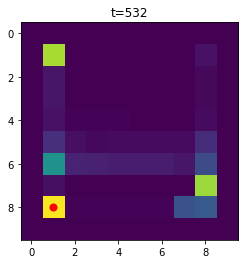

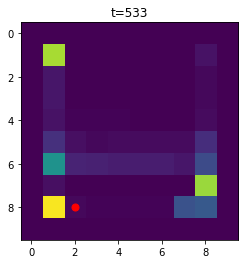

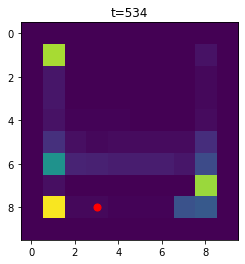

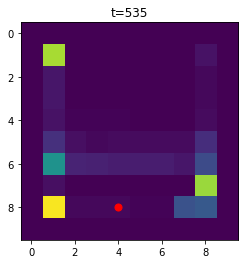

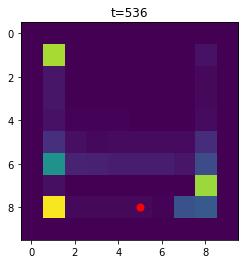

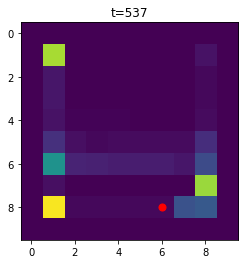

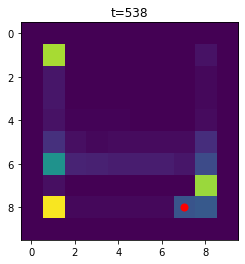

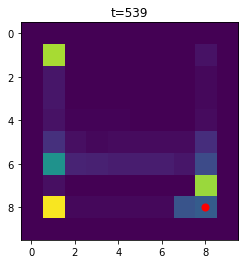

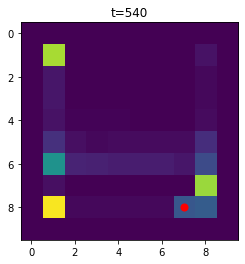

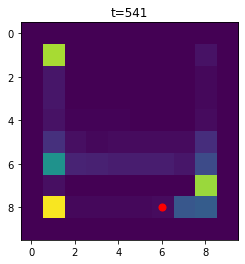

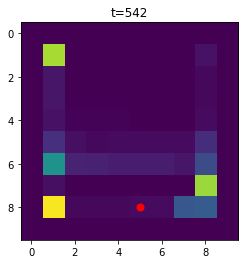

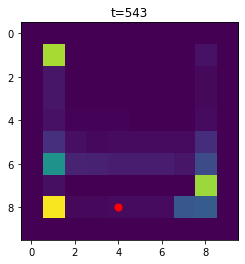

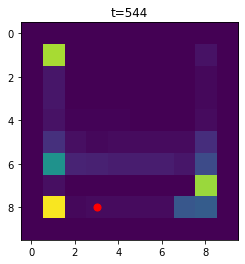

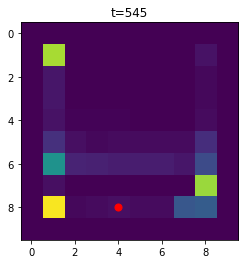

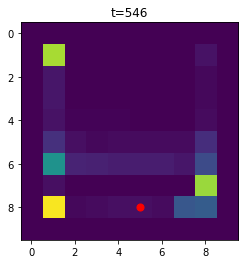

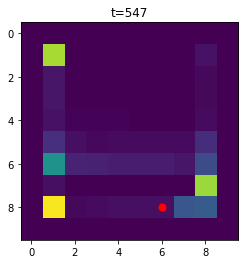

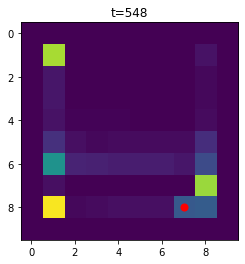

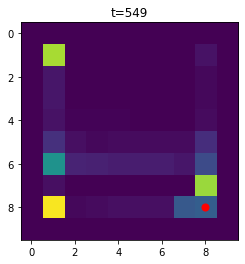

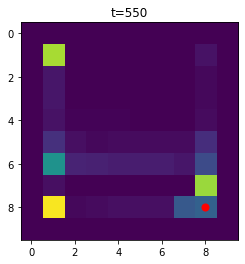

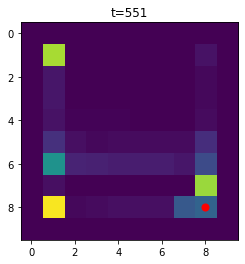

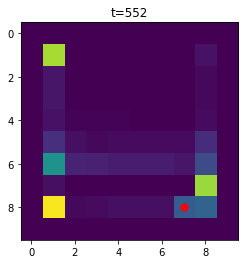

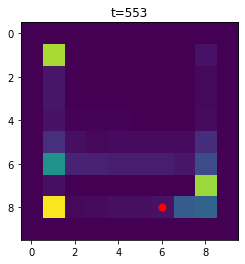

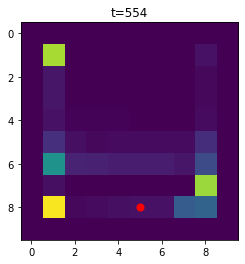

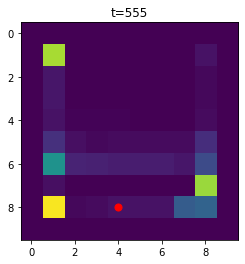

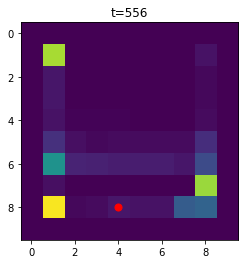

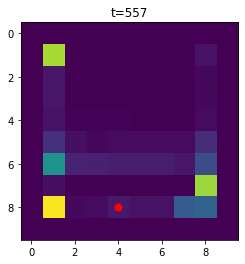

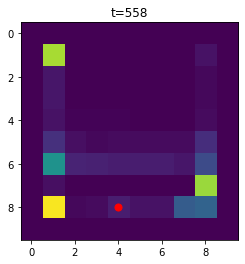

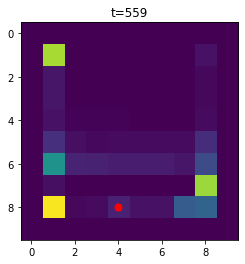

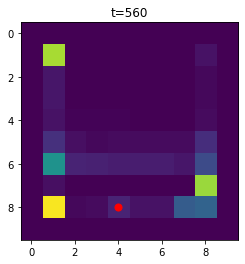

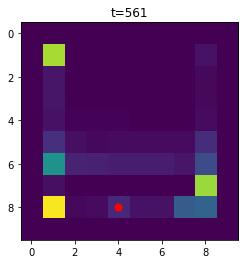

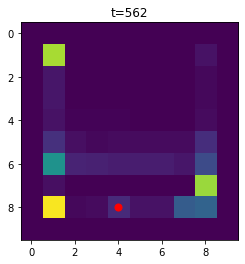

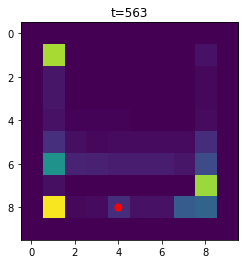

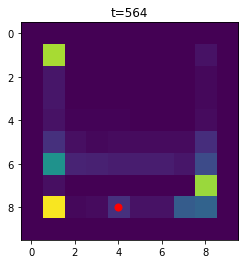

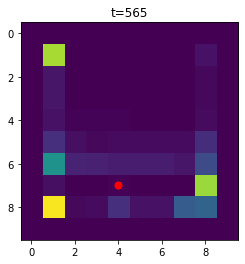

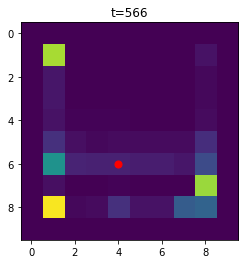

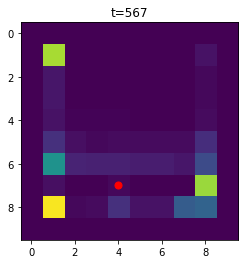

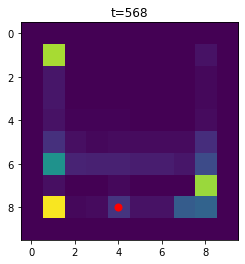

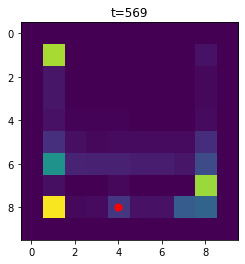

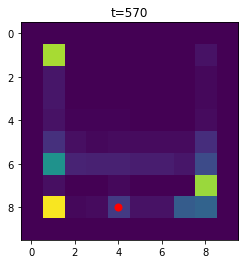

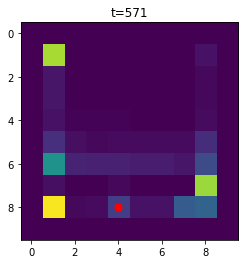

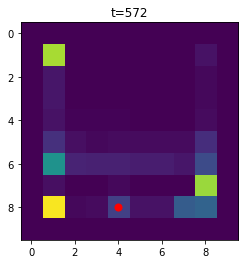

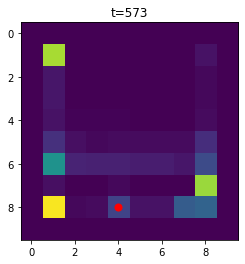

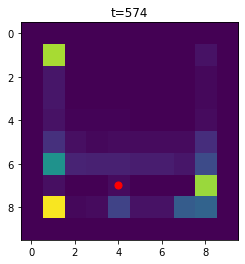

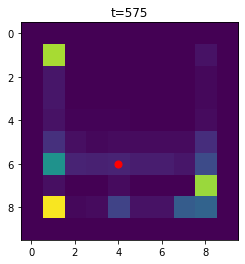

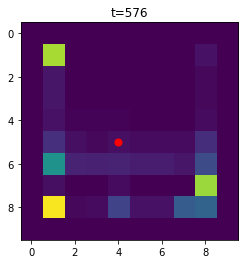

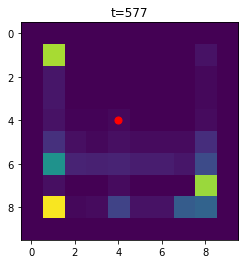

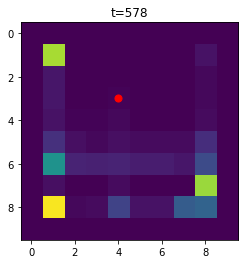

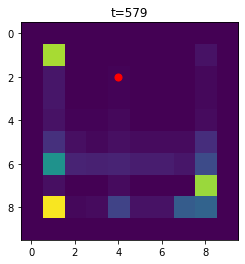

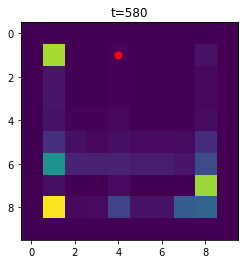

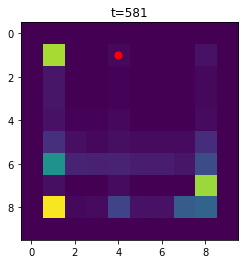

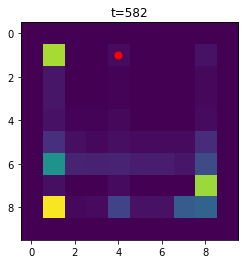

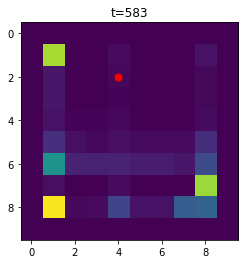

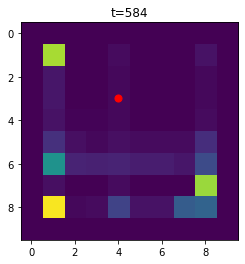

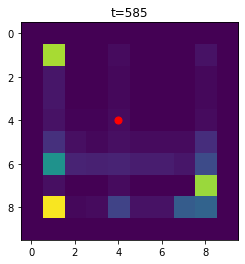

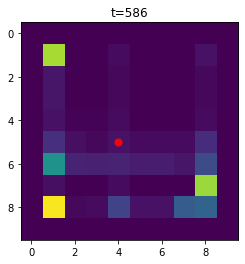

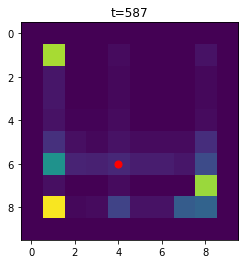

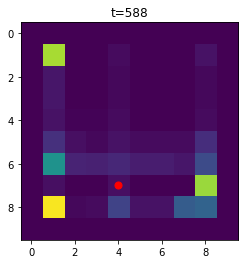

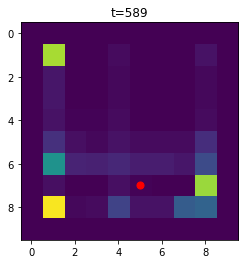

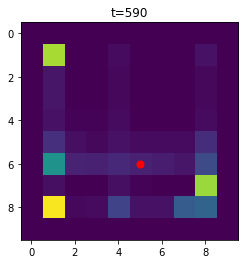

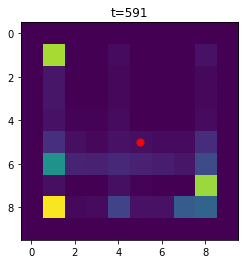

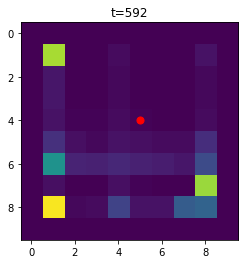

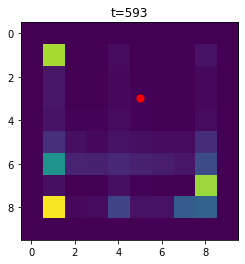

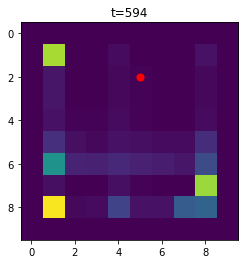

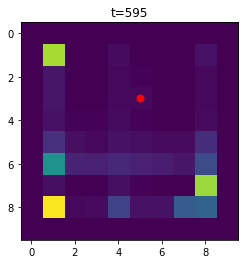

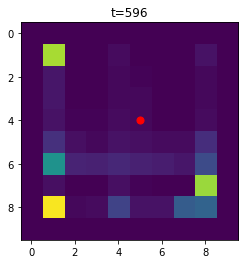

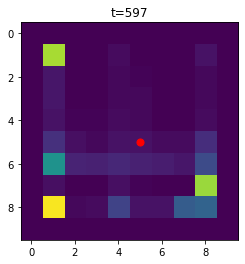

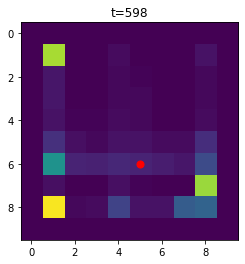

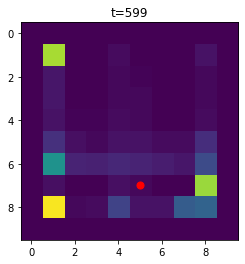

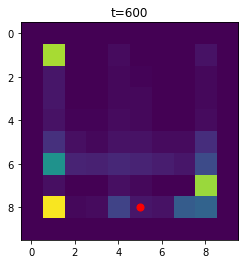

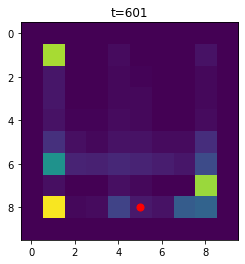

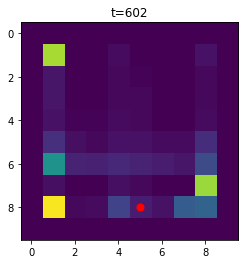

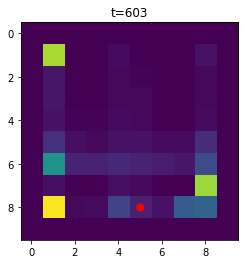

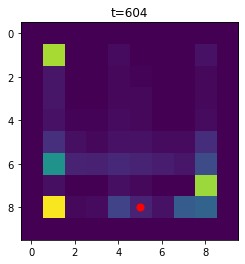

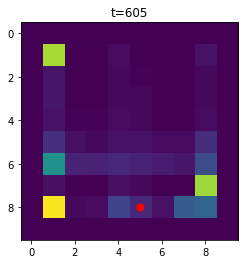

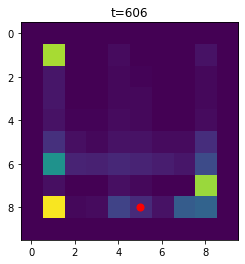

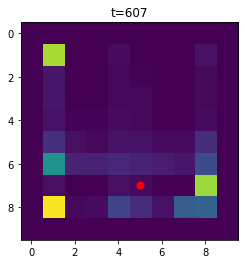

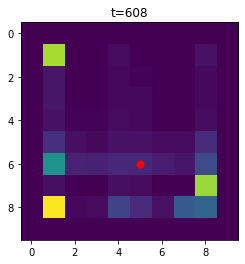

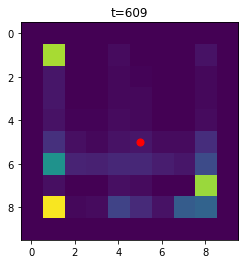

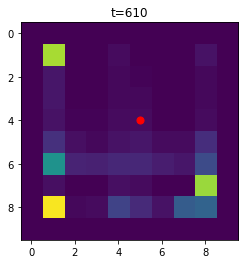

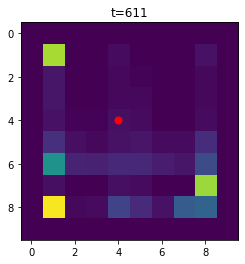

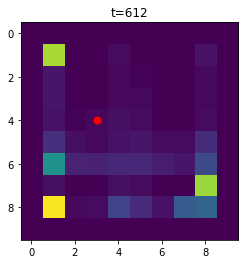

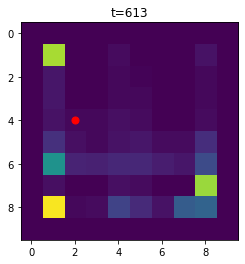

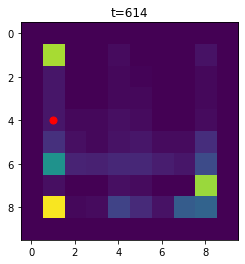

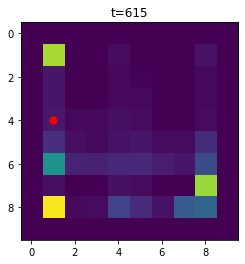

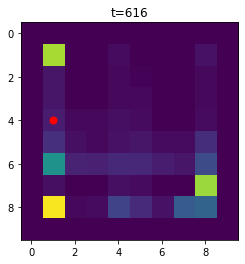

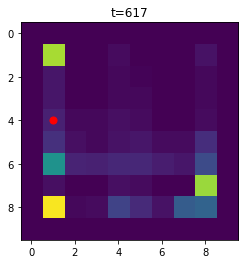

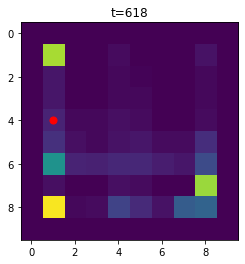

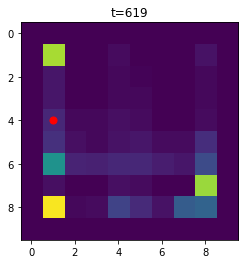

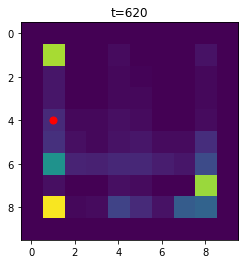

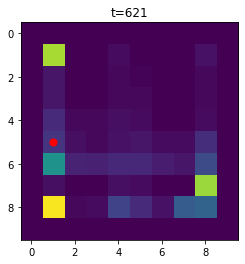

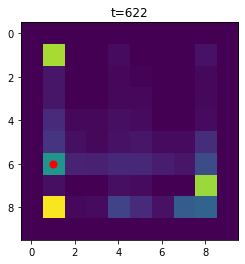

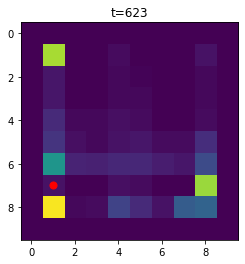

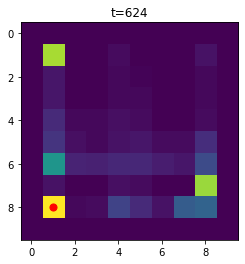

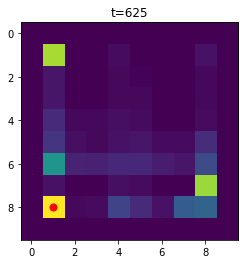

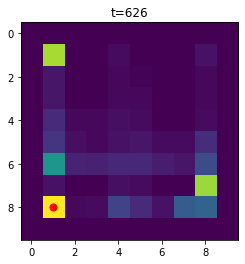

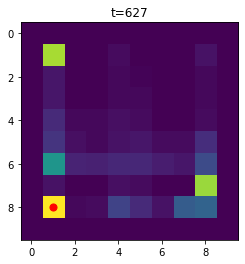

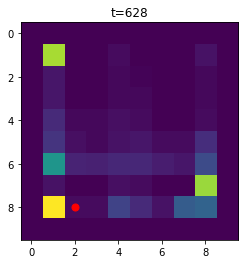

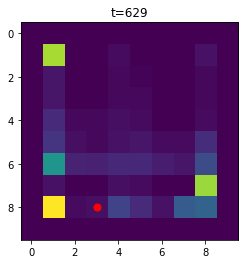

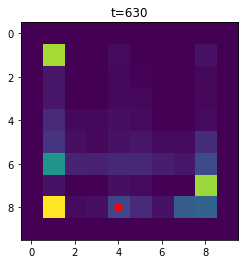

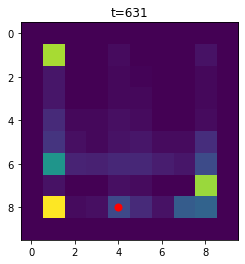

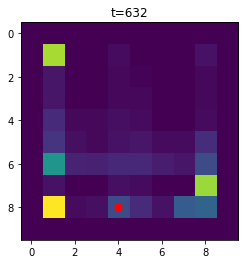

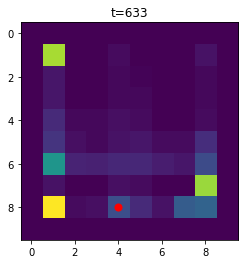

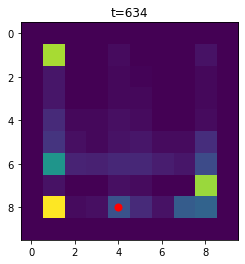

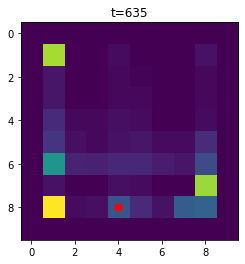

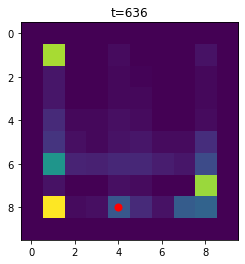

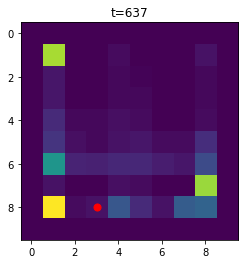

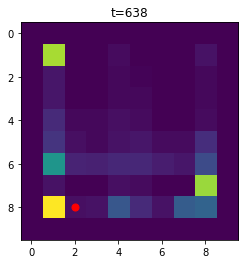

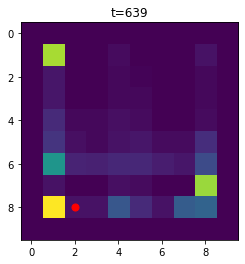

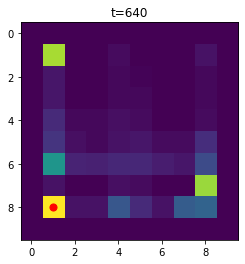

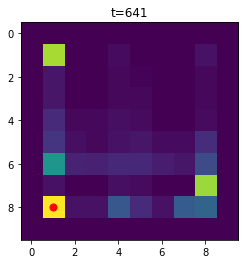

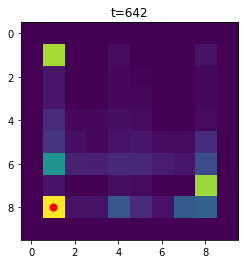

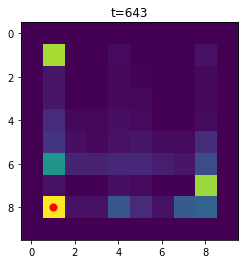

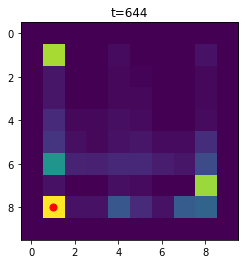

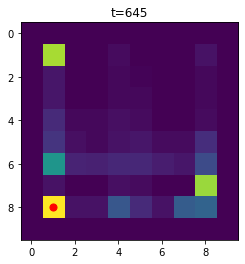

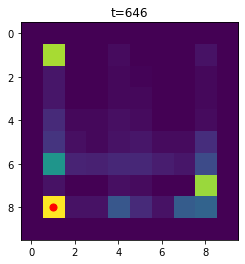

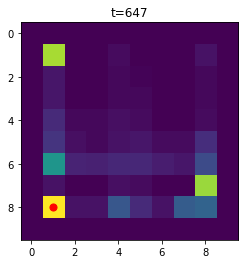

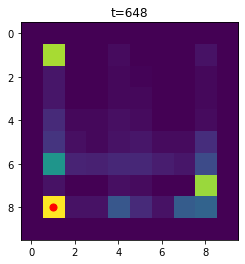

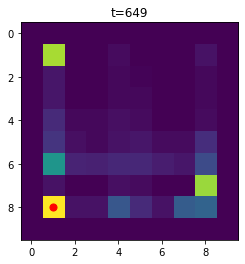

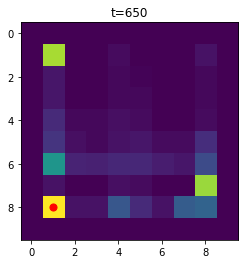

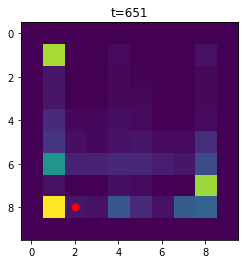

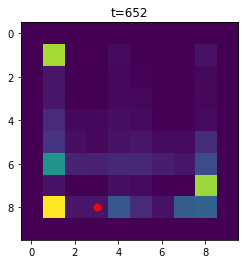

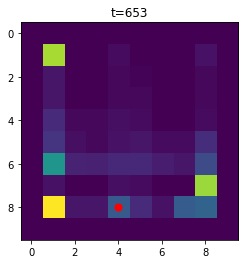

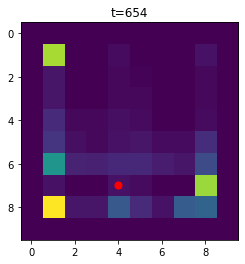

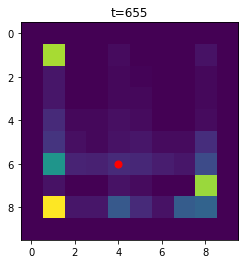

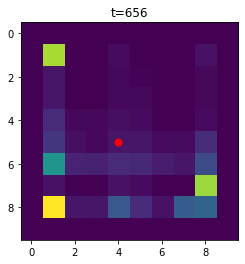

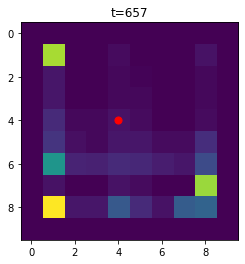

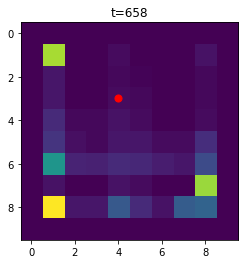

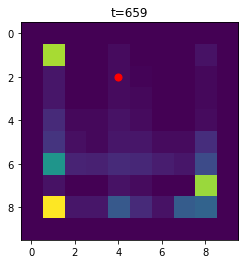

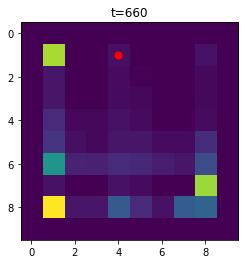

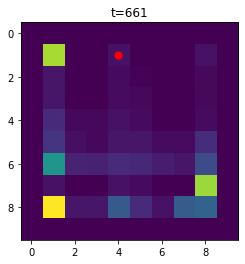

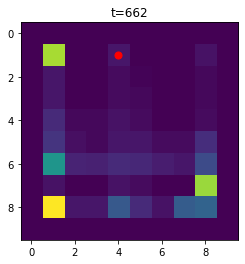

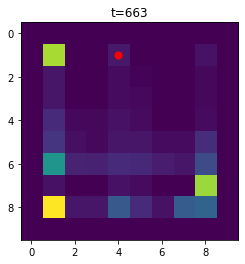

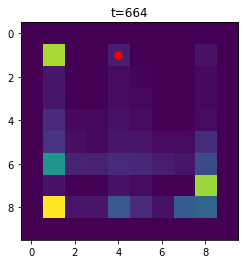

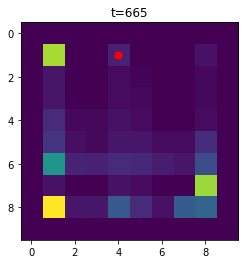

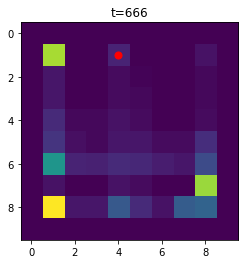

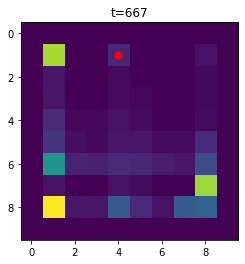

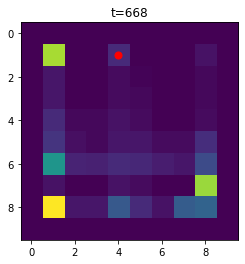

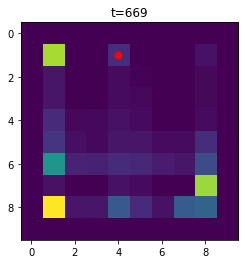

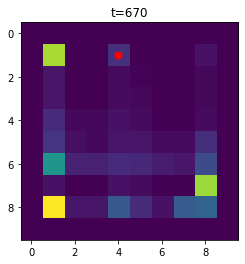

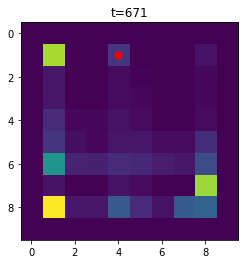

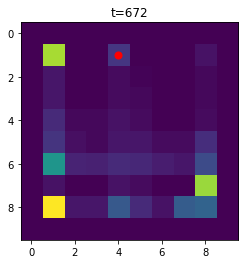

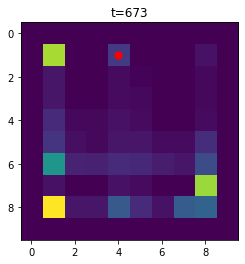

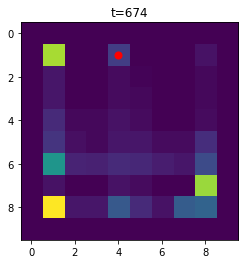

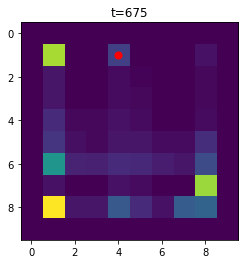

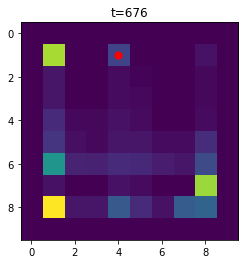

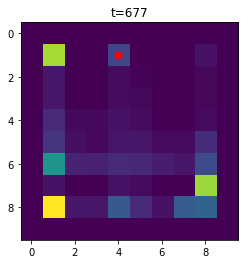

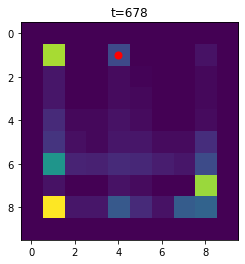

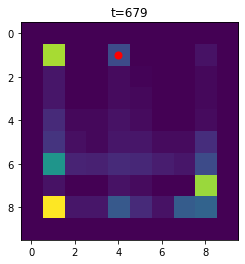

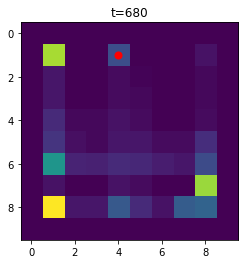

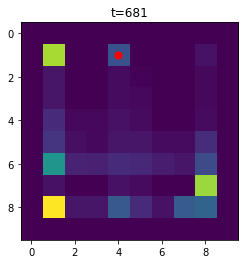

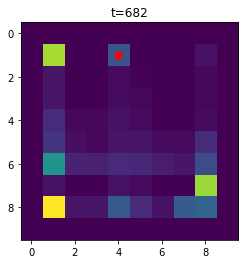

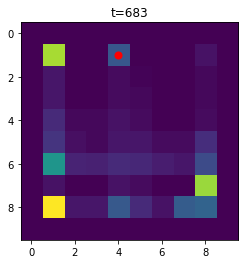

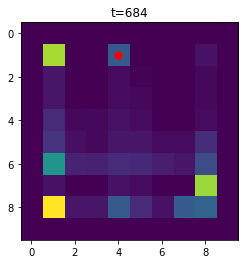

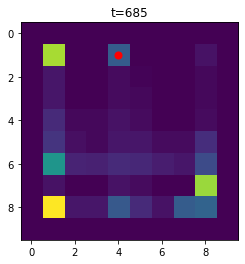

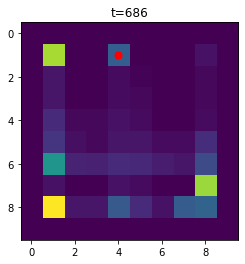

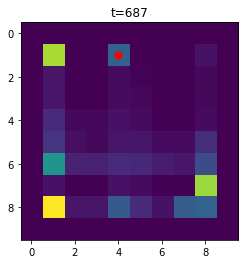

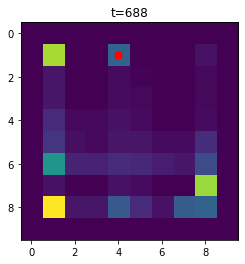

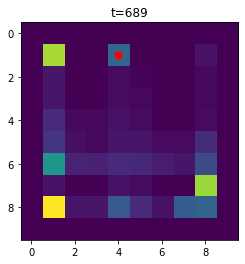

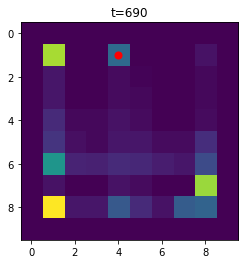

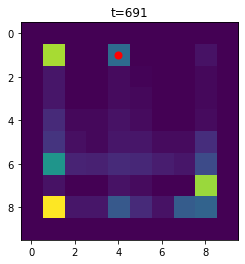

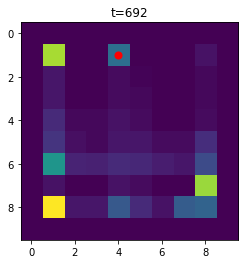

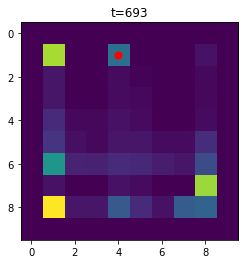

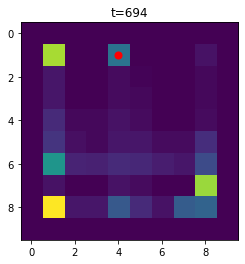

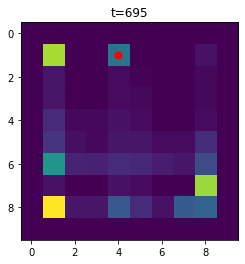

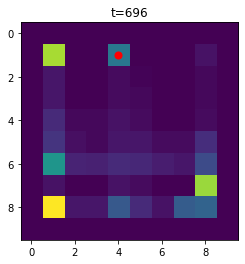

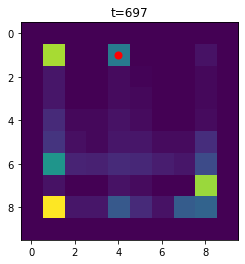

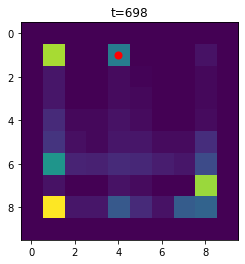

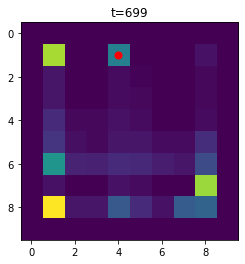

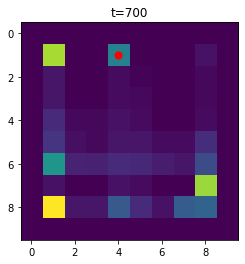

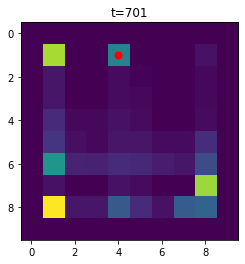

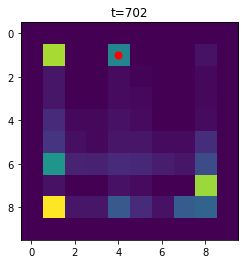

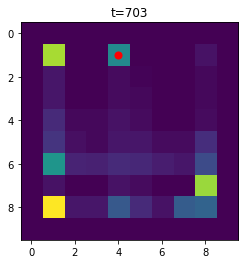

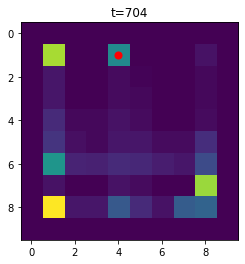

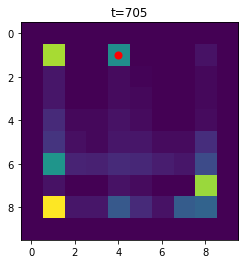

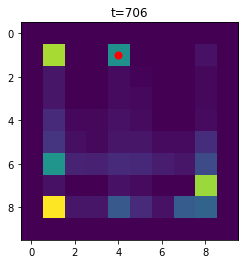

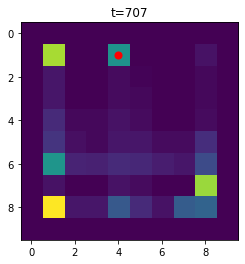

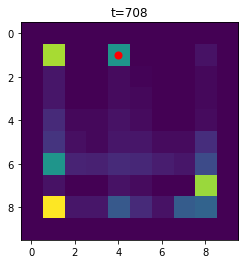

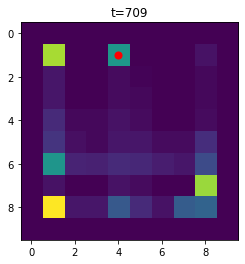

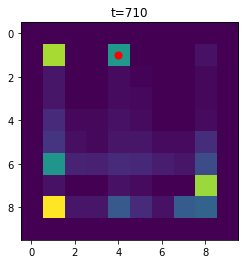

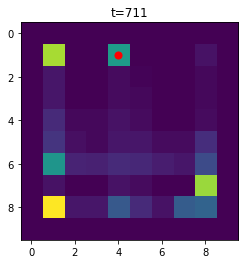

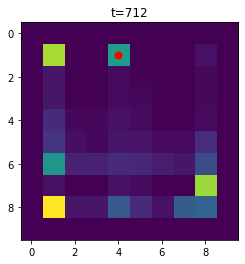

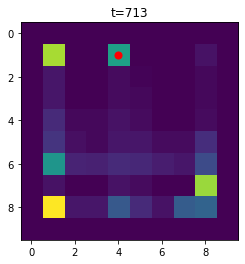

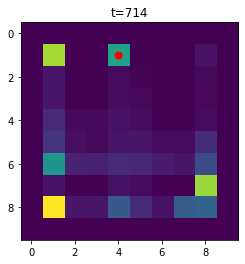

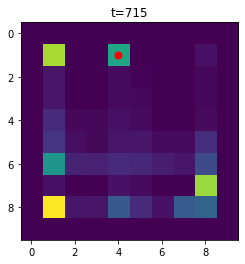

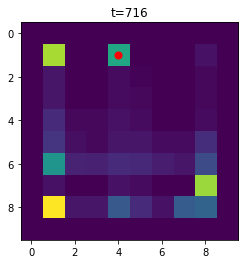

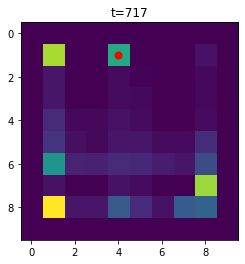

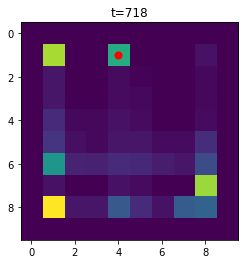

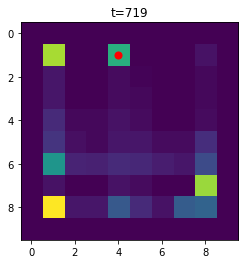

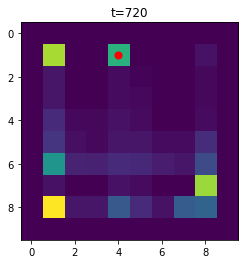

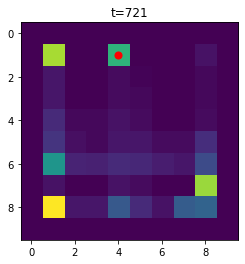

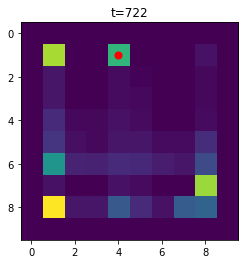

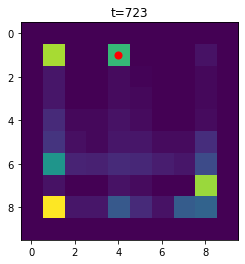

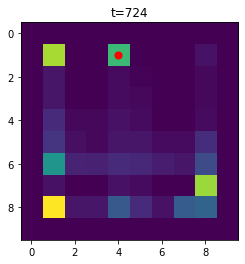

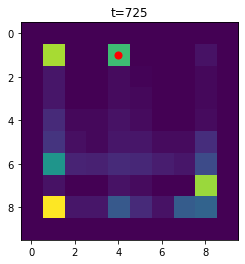

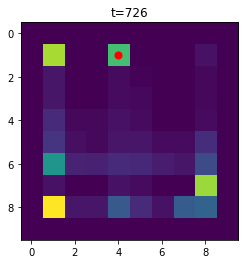

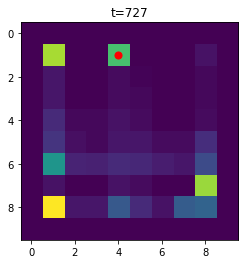

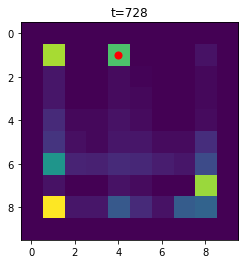

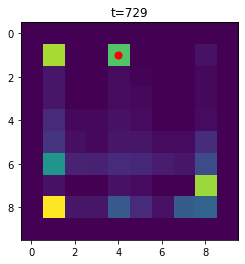

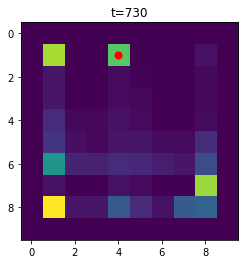

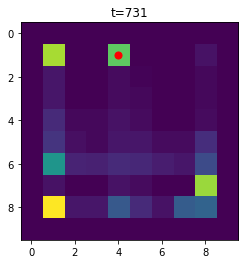

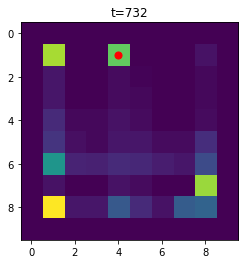

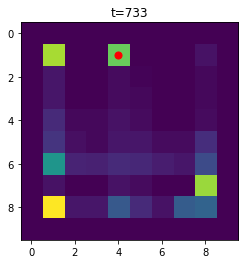

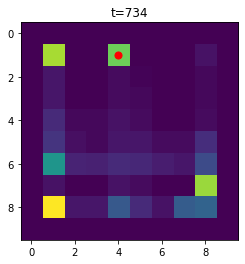

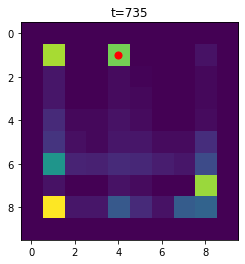

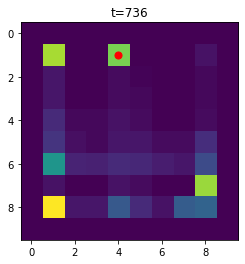

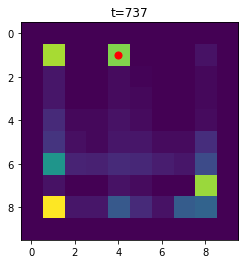

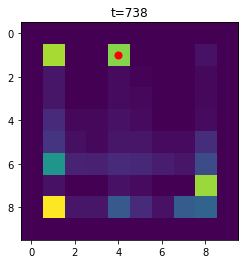

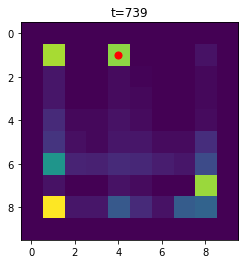

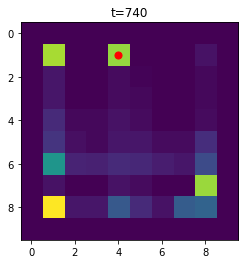

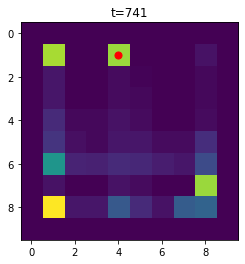

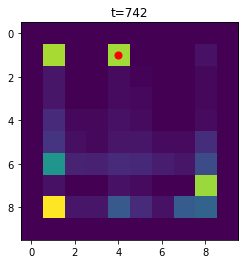

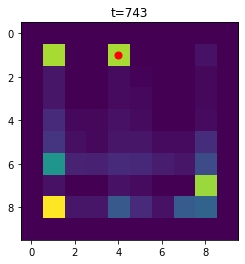

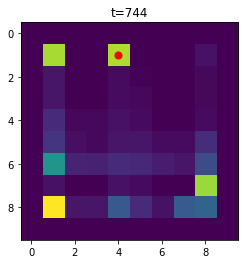

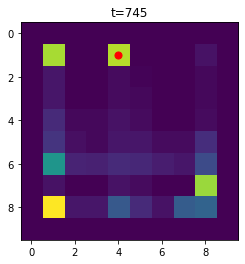

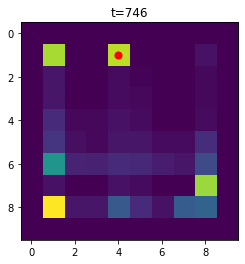

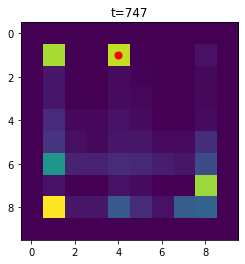

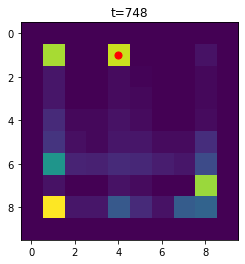

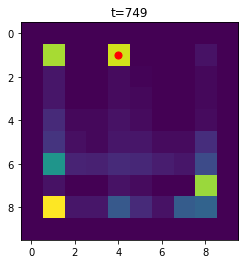

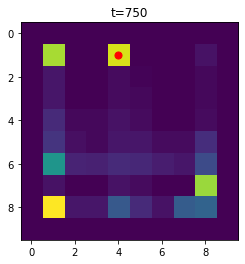

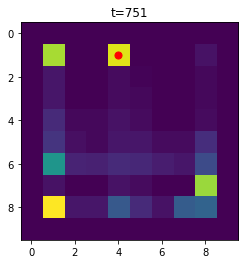

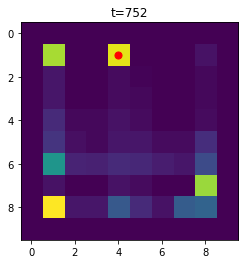

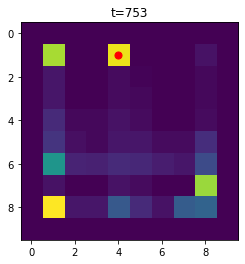

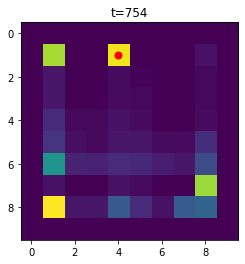

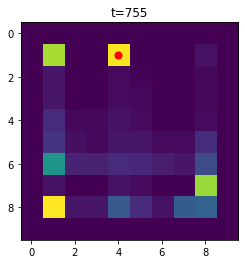

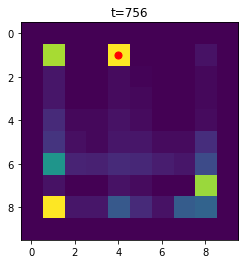

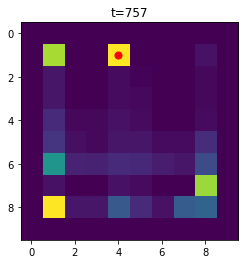

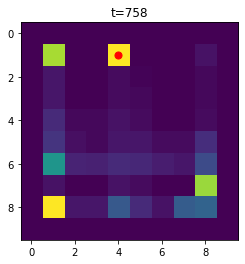

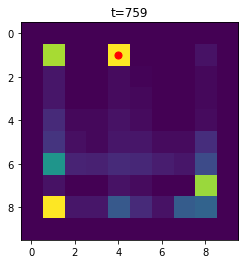

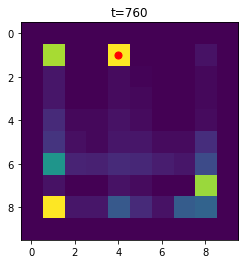

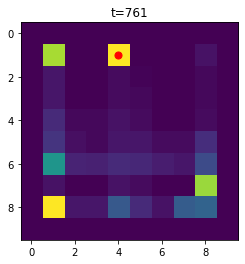

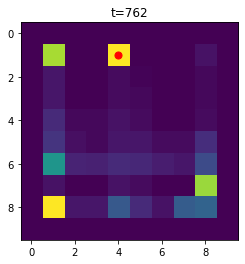

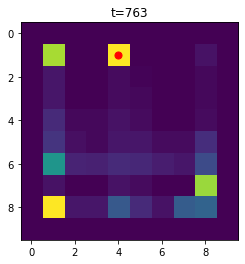

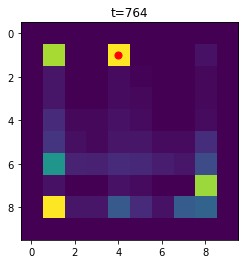

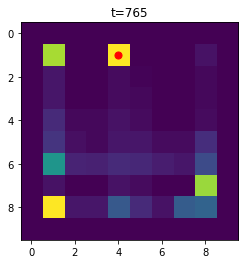

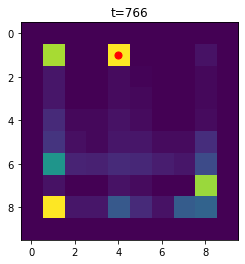

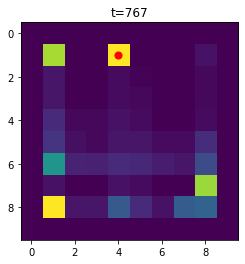

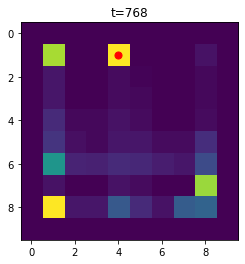

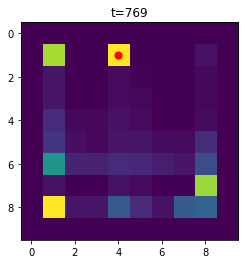

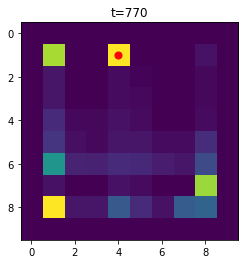

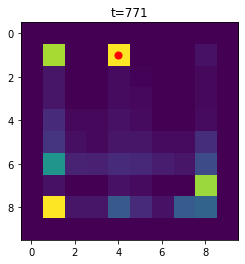

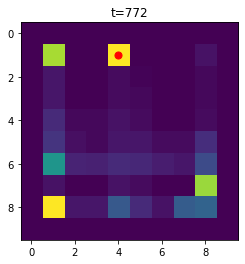

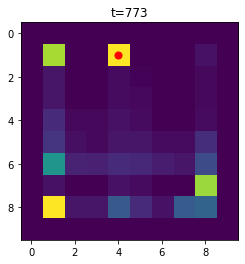

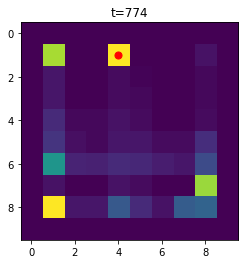

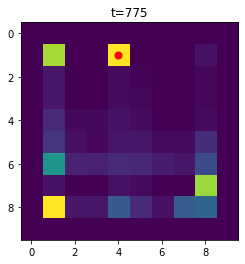

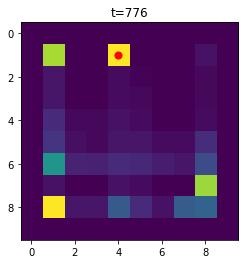

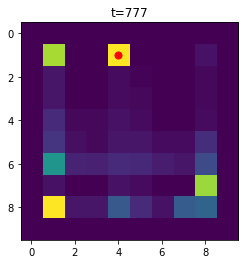

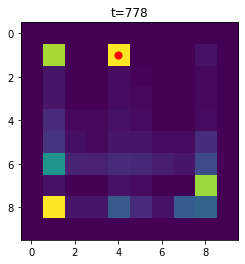

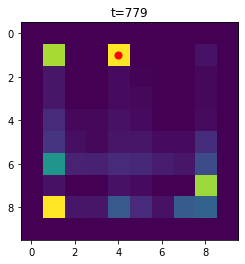

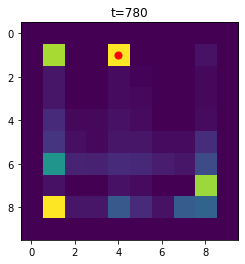

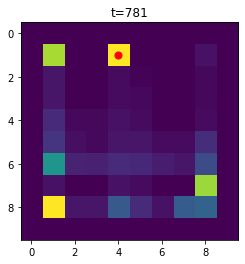

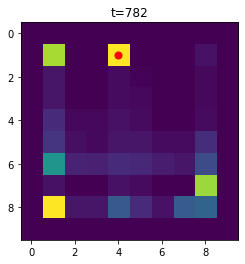

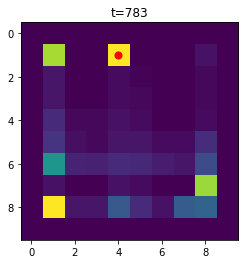

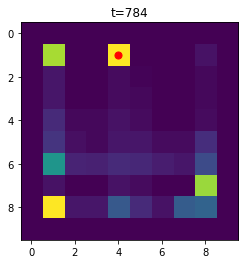

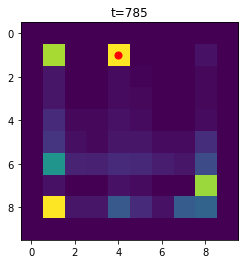

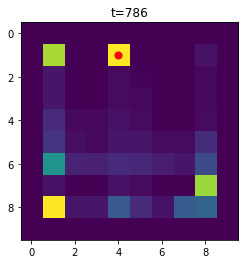

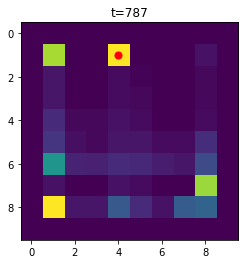

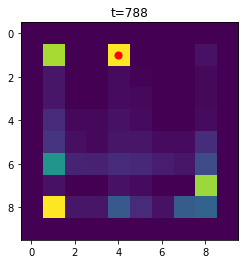

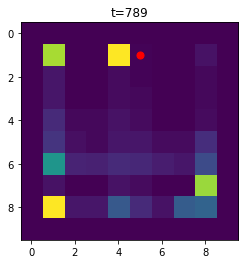

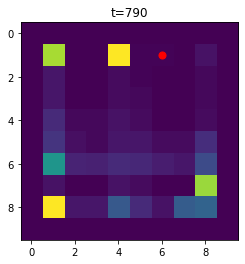

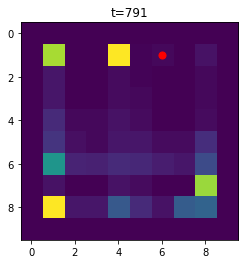

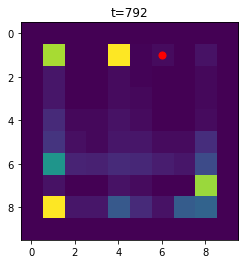

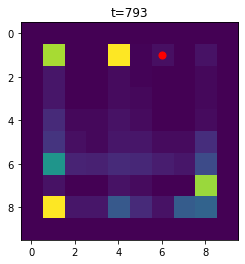

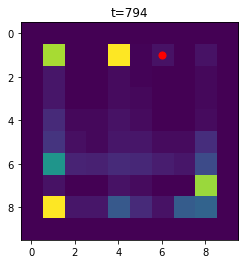

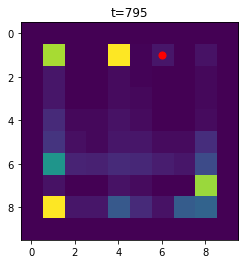

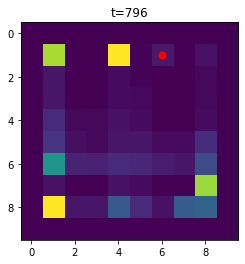

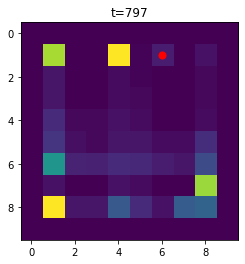

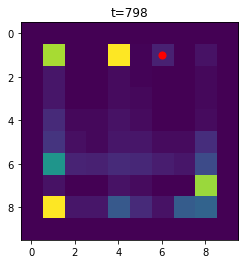

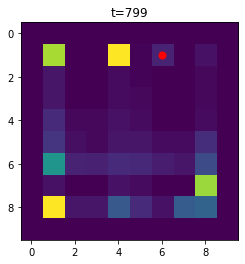

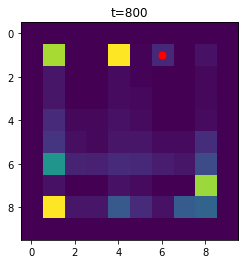

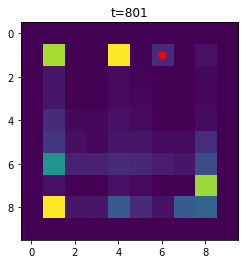

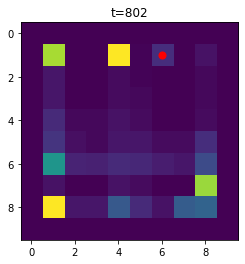

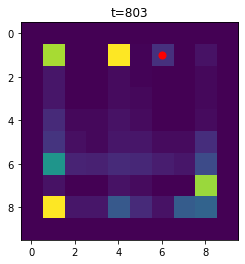

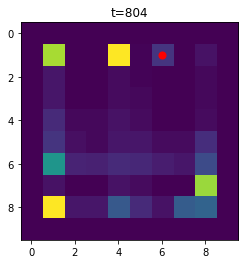

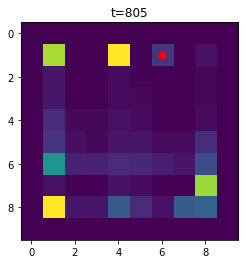

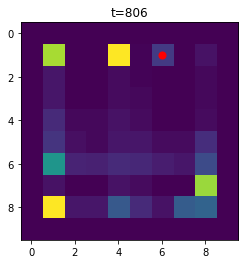

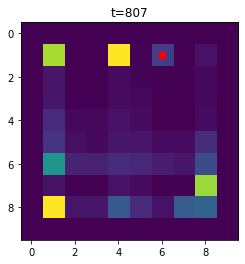

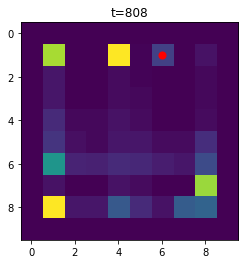

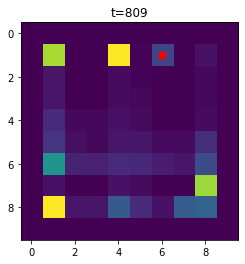

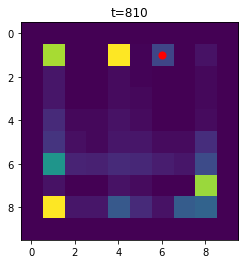

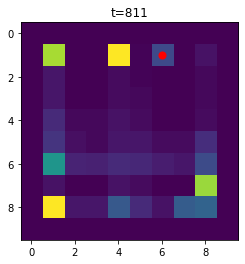

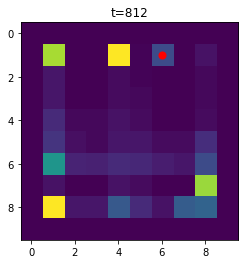

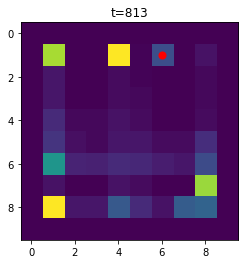

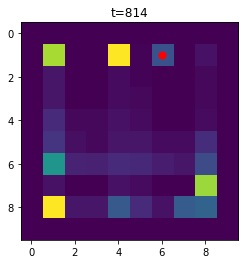

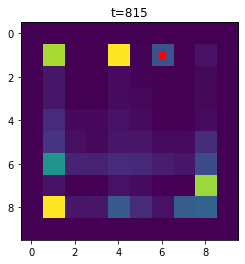

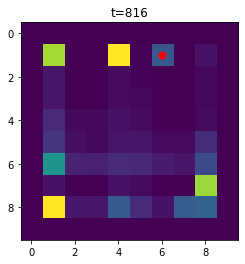

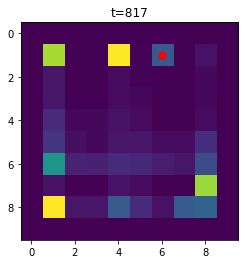

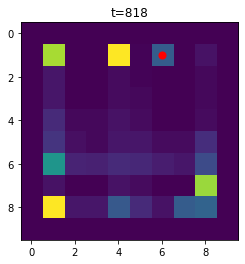

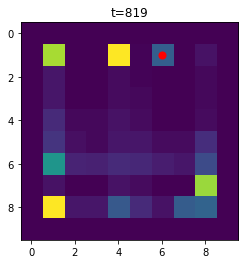

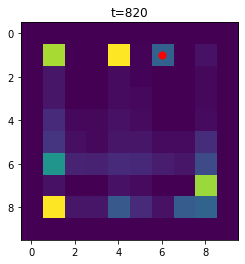

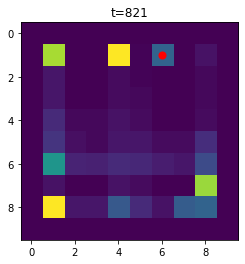

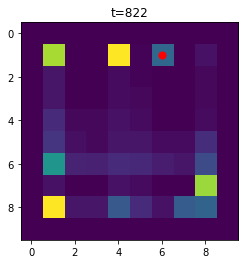

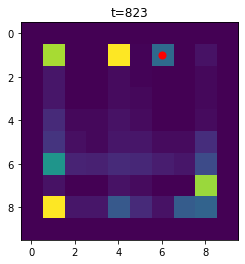

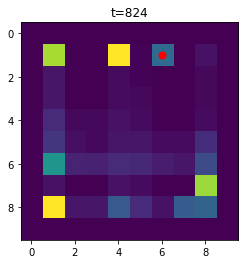

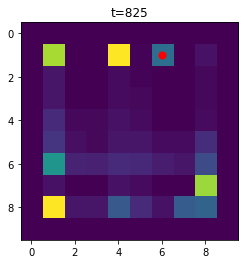

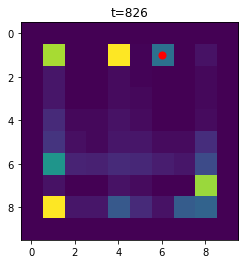

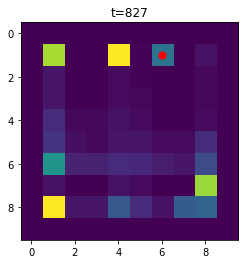

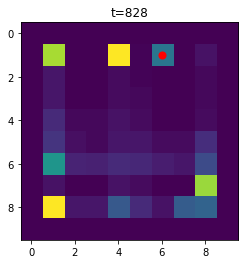

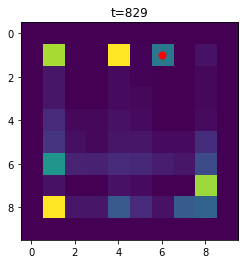

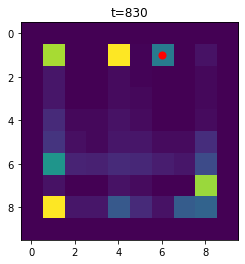

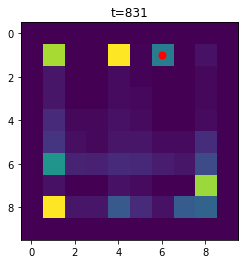

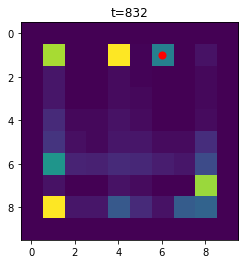

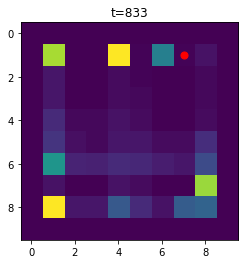

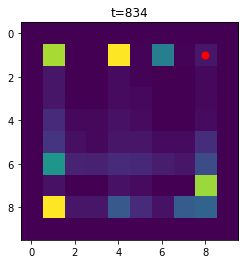

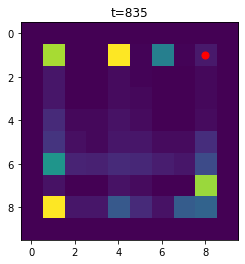

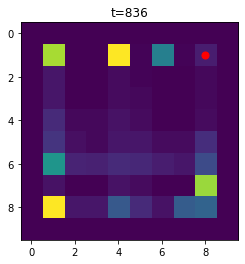

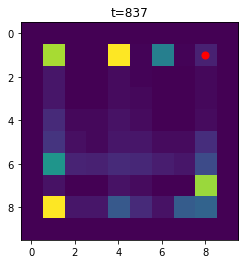

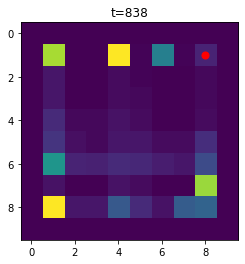

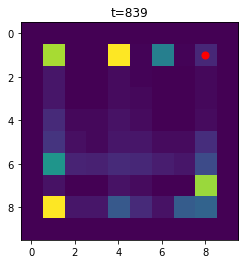

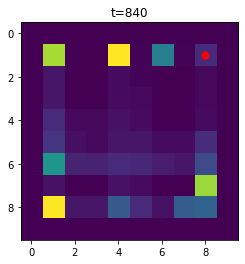

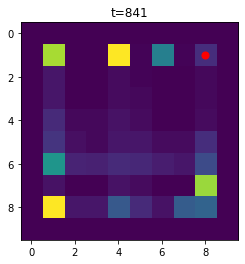

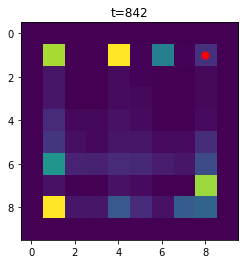

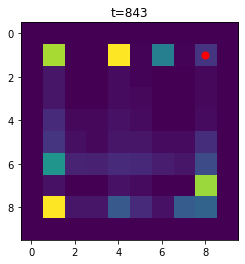

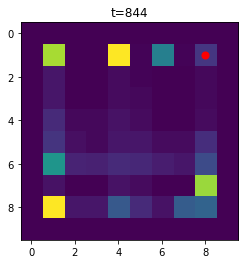

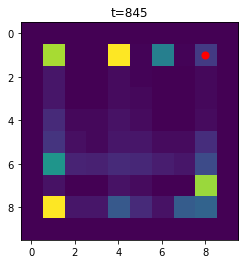

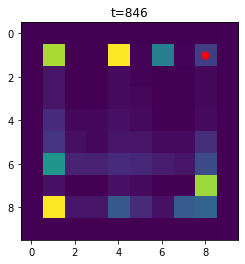

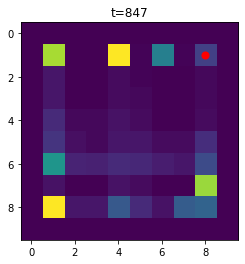

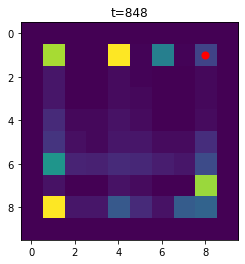

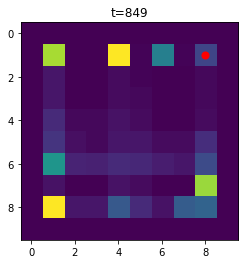

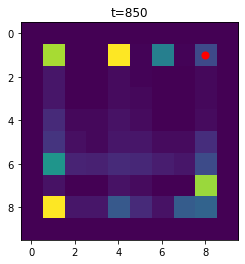

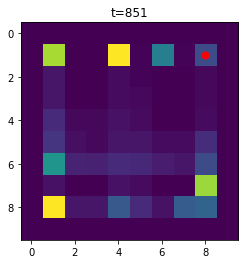

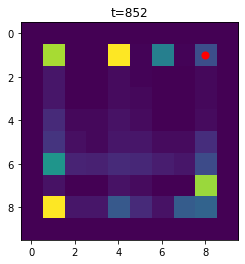

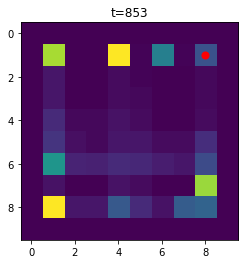

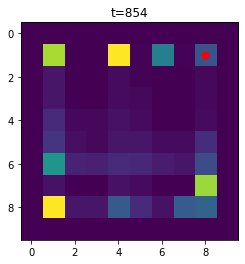

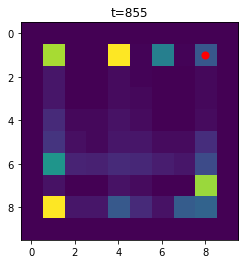

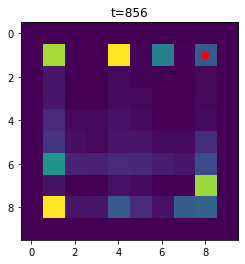

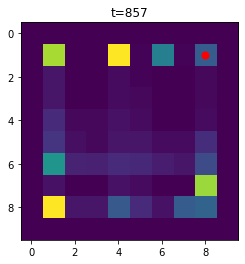

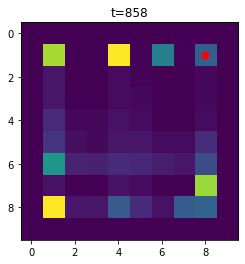

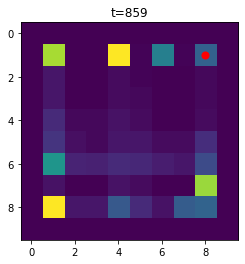

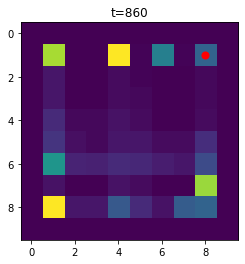

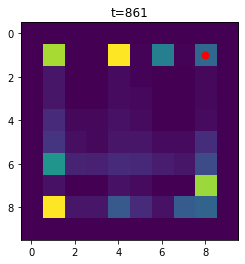

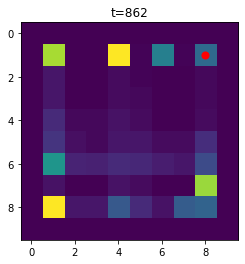

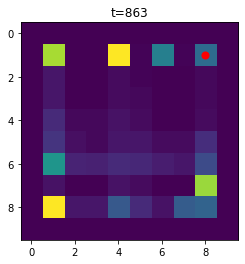

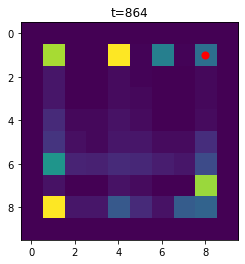

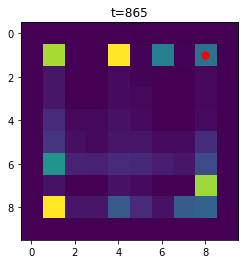

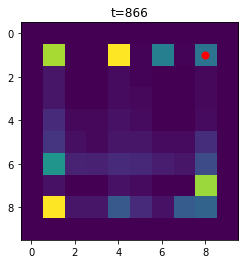

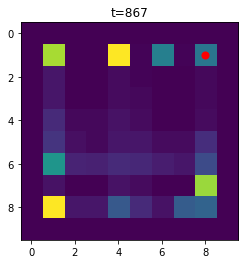

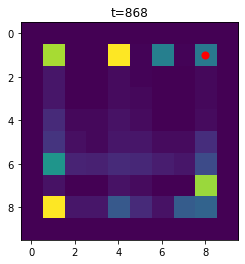

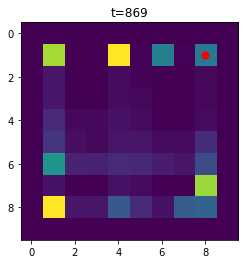

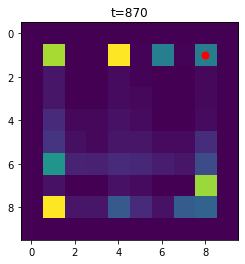

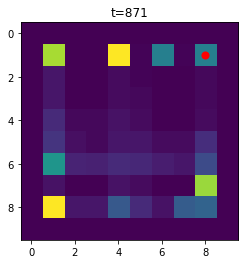

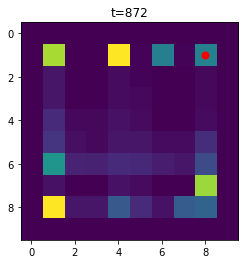

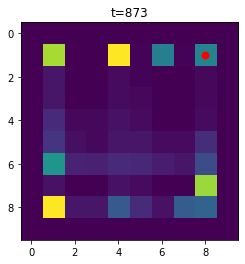

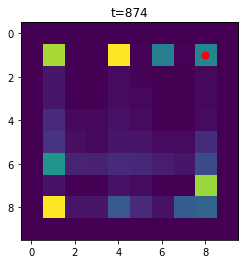

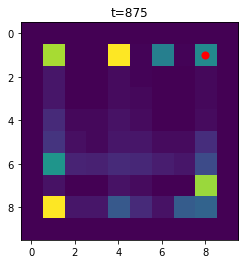

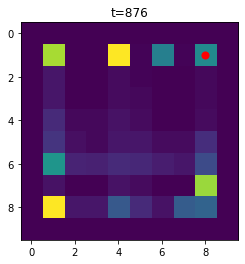

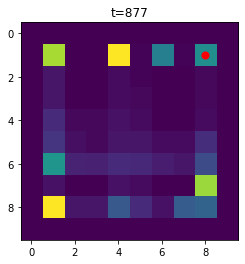

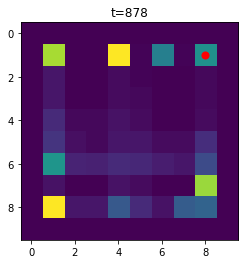

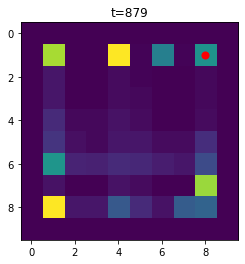

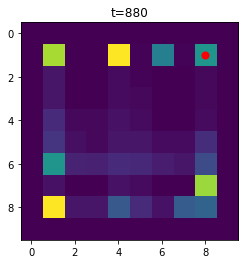

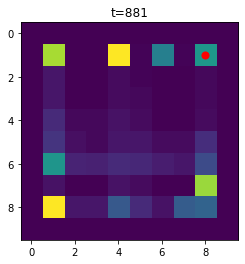

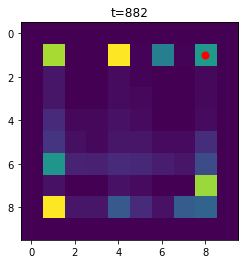

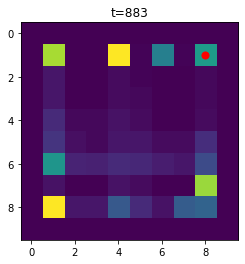

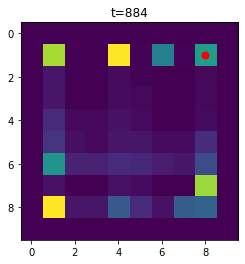

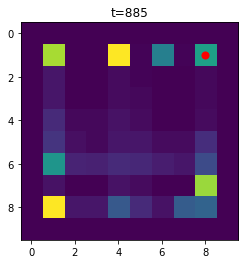

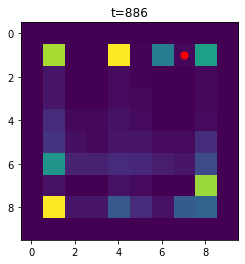

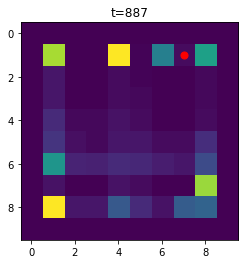

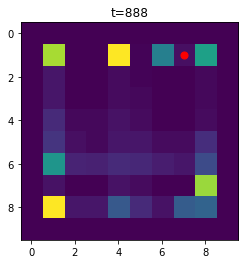

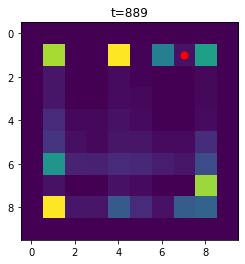

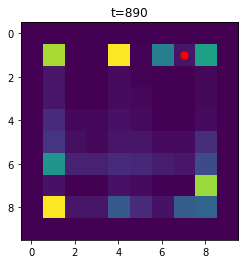

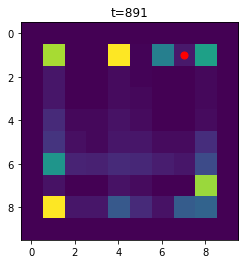

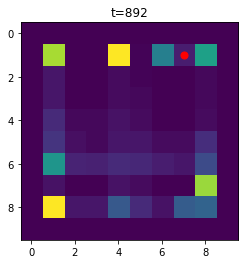

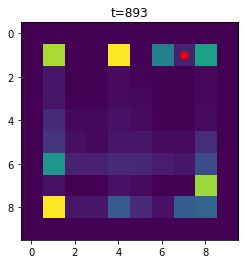

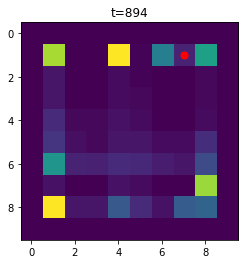

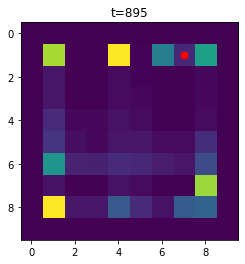

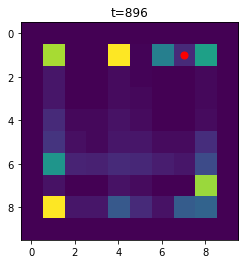

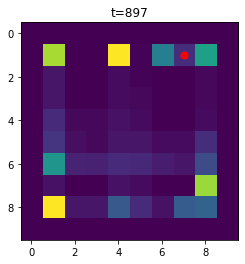

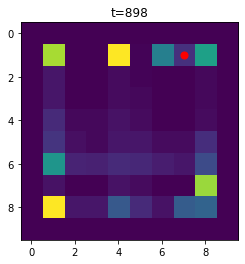

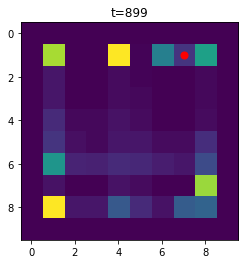

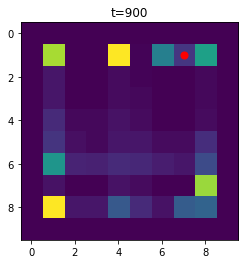

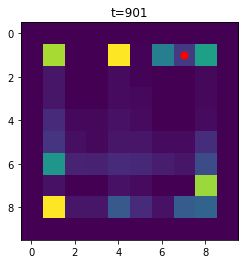

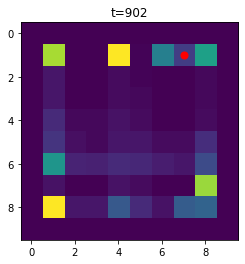

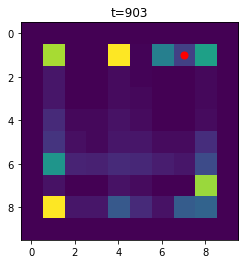

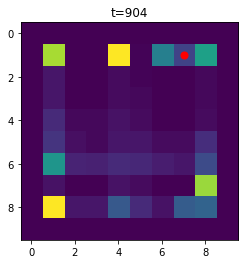

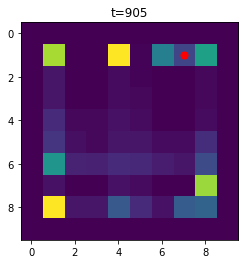

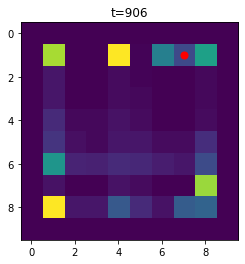

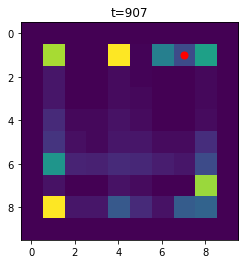

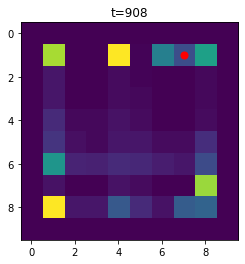

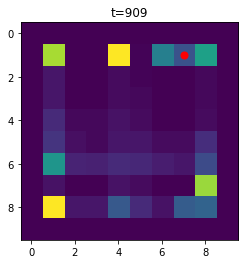

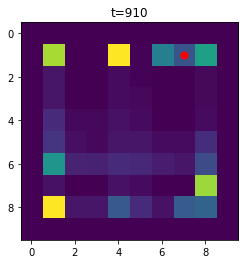

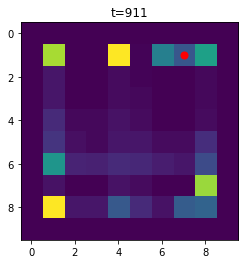

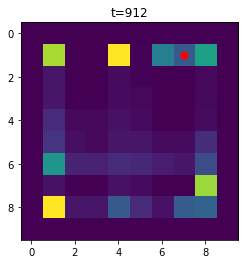

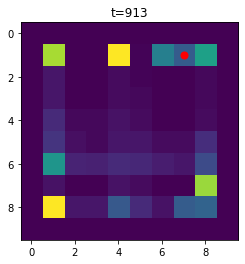

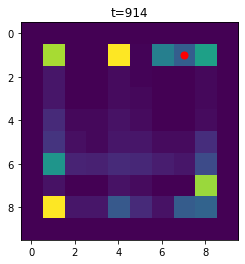

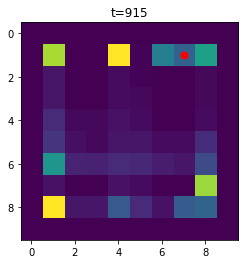

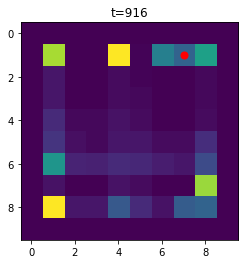

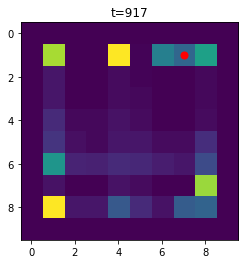

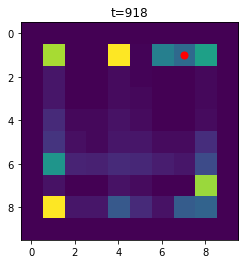

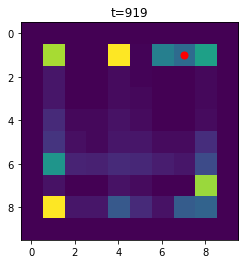

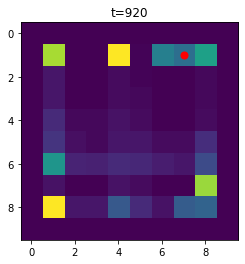

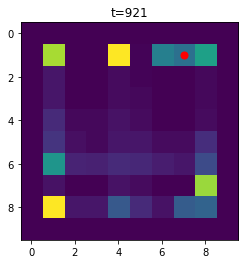

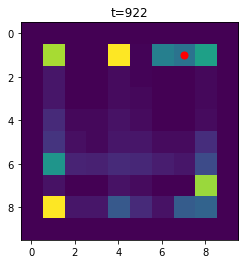

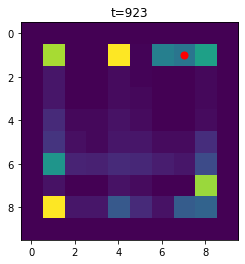

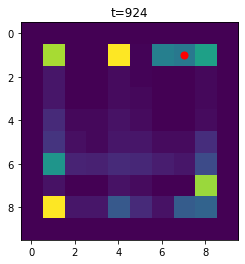

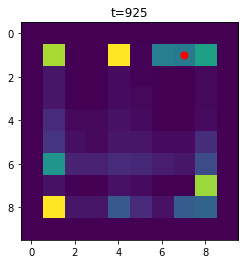

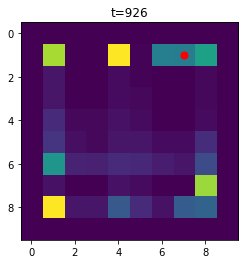

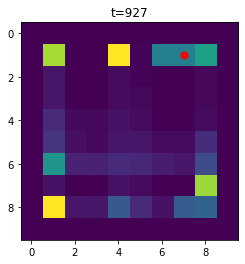

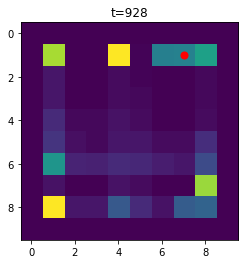

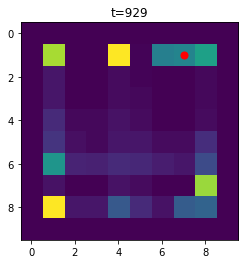

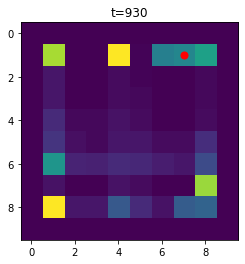

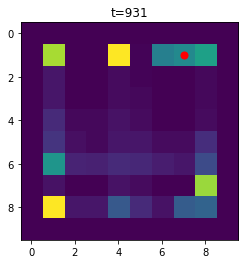

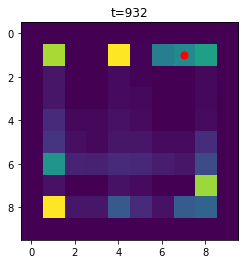

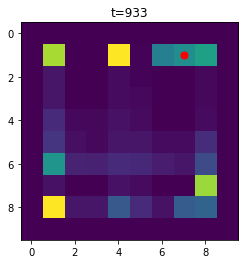

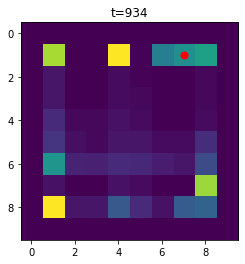

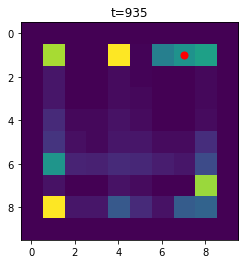

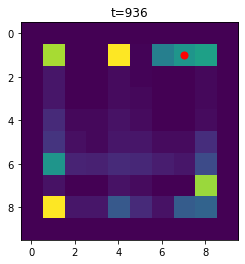

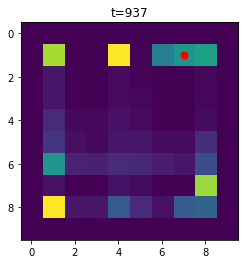

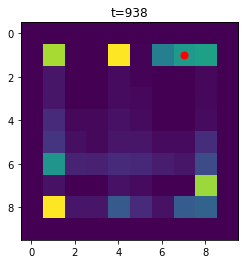

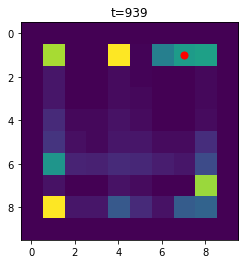

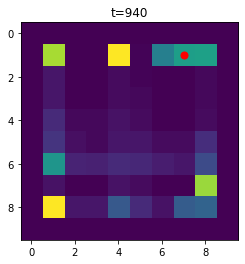

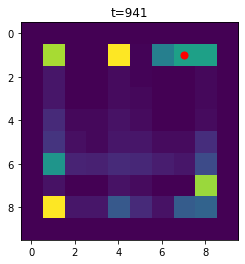

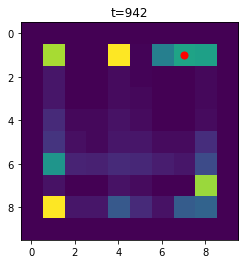

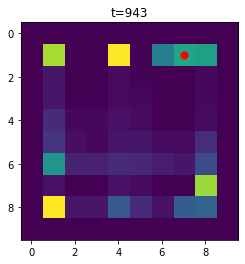

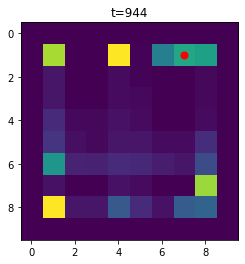

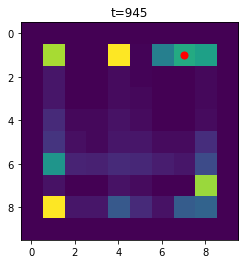

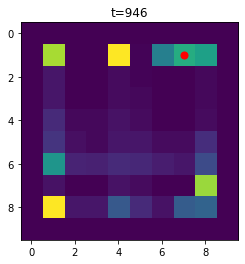

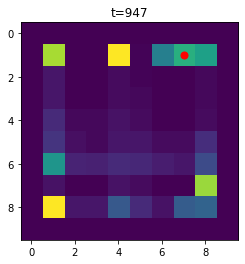

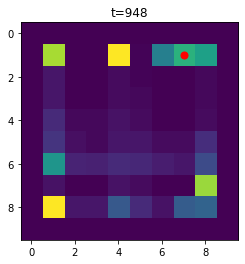

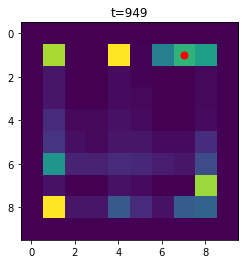

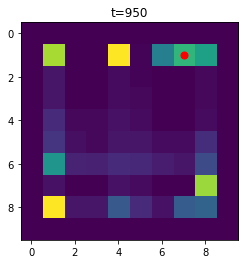

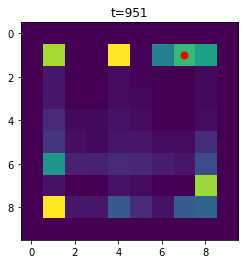

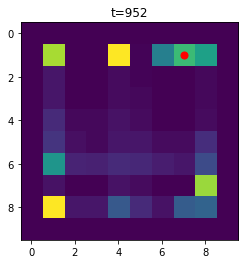

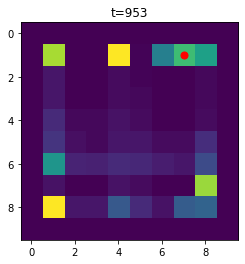

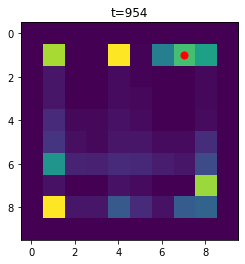

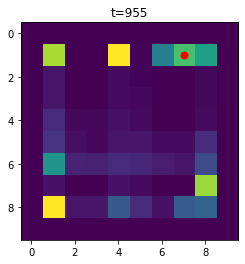

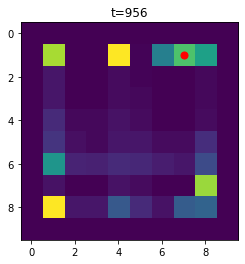

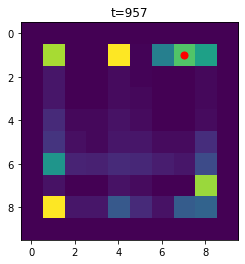

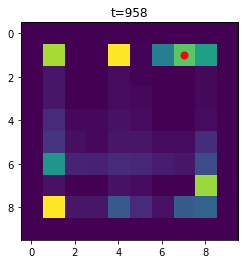

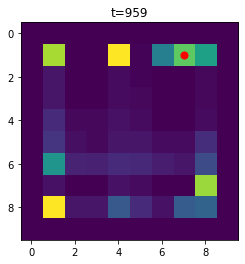

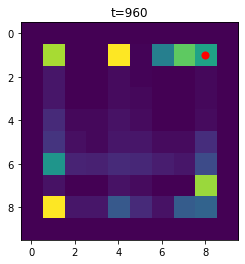

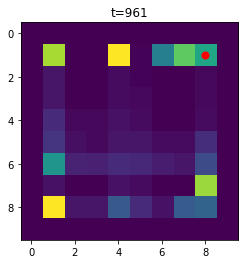

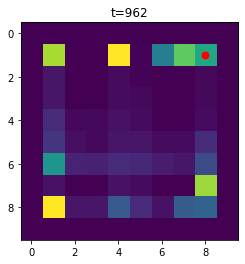

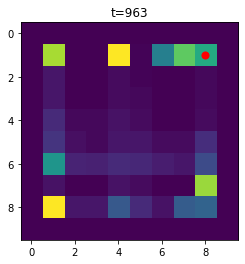

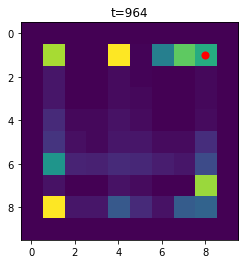

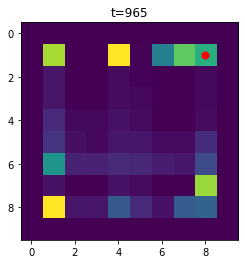

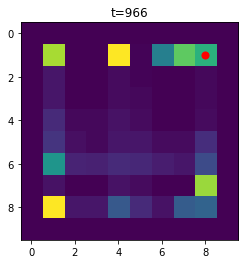

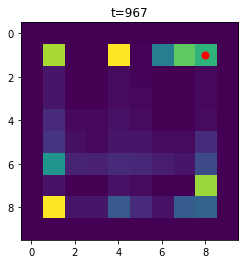

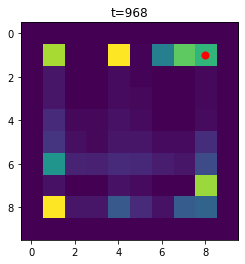

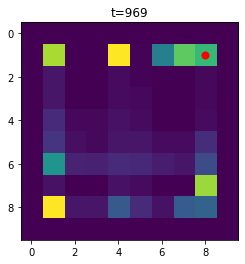

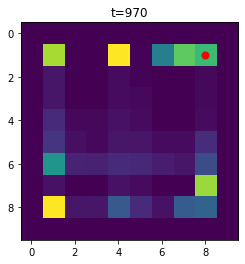

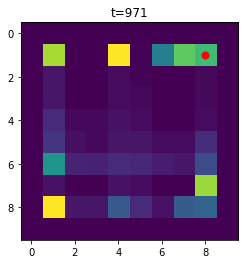

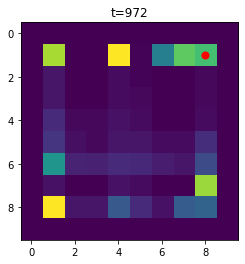

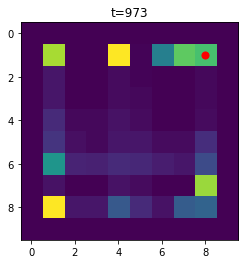

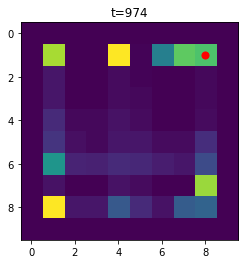

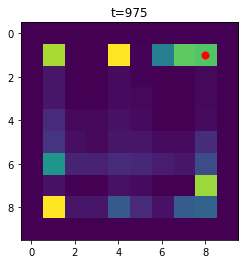

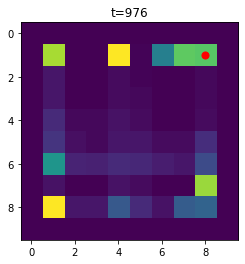

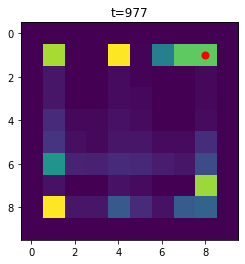

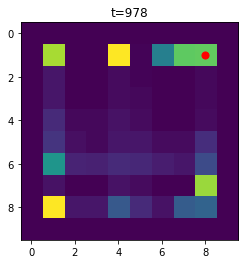

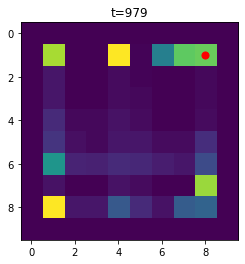

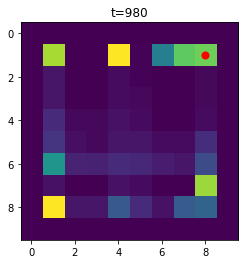

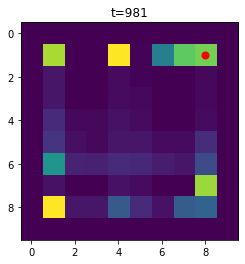

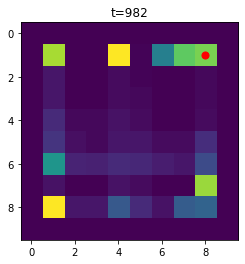

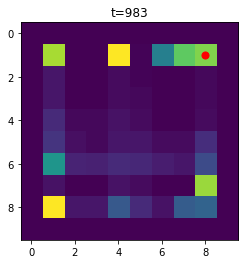

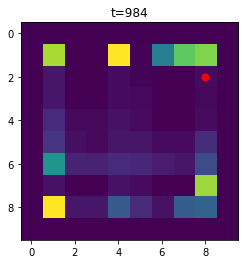

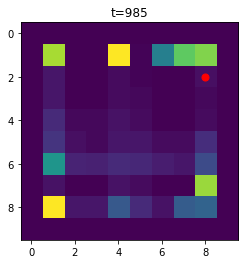

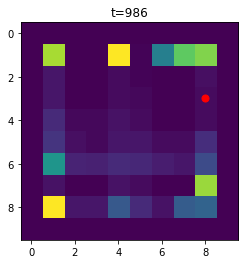

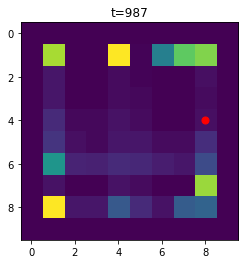

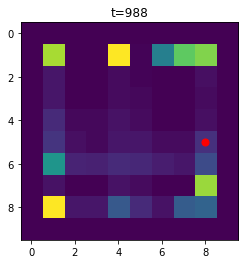

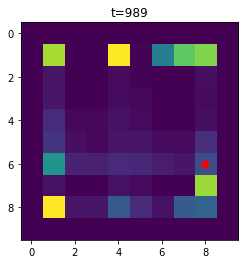

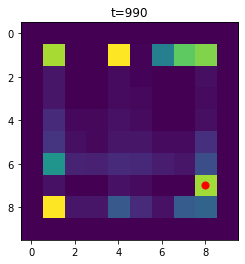

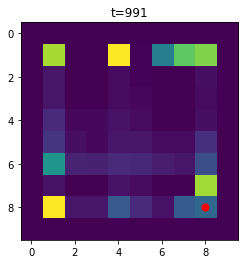

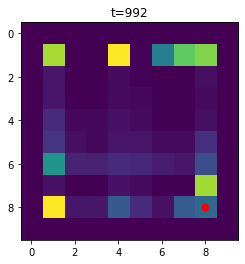

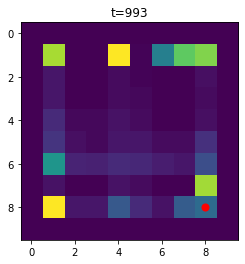

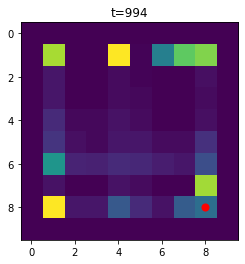

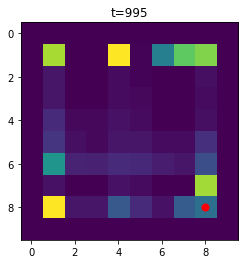

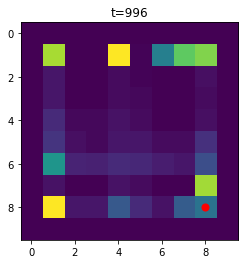

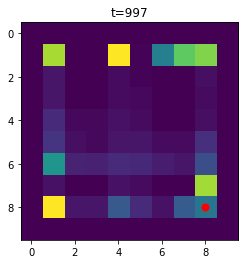

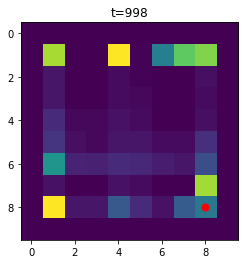

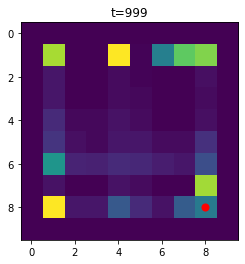

In [ ]:
import copy
max_v = 1
movie = []
loc = env.location_history
grid = np.zeros((10,10))
signal = np.ones((10,10))
for i in range(0,1000):
  grid[loc[i][0],loc[i][1]] += 0.01
  if i%1 == 0: 
    plt.imshow(grid,vmin=0,vmax=max_v)
    plt.scatter(loc[i][1],loc[i][0], s=50, c='red', marker='o')
    movie.append(copy.copy(grid))
    plt.title(f't={i}')

    # if i == 20000: movie.append(signal)
  plt.show()

In [ ]:
import matplotlib.mlab as mlab
import matplotlib.animation
from IPython.display import HTML
%pylab inline

# sometimes you have to re-run 'resources' cell, and re-import copy, after running this cell, for some unknown reason

def animate_heat(history):
    frames = len(history)

    print("Rendering %d frames..." % frames)

    fig, ax = plt.subplots(figsize=(10, 6));
    # grids = plt.GridSpec(3, n_stats, hspace=0.2, wspace=0.2);
    # fig_health.set_autoscale_on(False)
    # health_plot = np.zeros((frames, n_stats));

    def render_frame(i):
        grid = history[i]

        # Render grid
        rmin = grid.min()
        rmax = grid.max()

        # ax_g = fig.add_subplot(grids[0,stat]);
        ax.matshow(grid, vmin=rmin, vmax=rmax);
        ax.set_xticks([]);

    anim = matplotlib.animation.FuncAnimation(
        fig, render_frame, frames=frames, interval=200
    )
    plt.close()
    display(HTML(anim.to_html5_video()))

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['grid', 'gamma', 'copy', 'norm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [ ]:
animate_heat(movie)

Rendering 1000 frames...


CalledProcessError: ignored

## Q-value Map

In [ ]:
env.reset()
env.reset_for_new_agent()
q_all = np.zeros((4,10,10))

def display_q_map():
  move_back_loc = copy.copy(env.loc)
  actions = ['down','up','right','left']
  ## will take environment and agent as parameters
  for i in range(1,9):
    for j in range(1,9):

      env.move_location([i,j])
      state = env.get_state()
      q_vals = agent_mon.dqn(torch.FloatTensor(state).to(agent_mon.device)).detach().cpu().numpy()
      q_all[:,i,j] += q_vals

  env.move_location(move_back_loc)

  fig, axes = plt.subplots(1,4,figsize=(8,2))
  for i, ax in enumerate(axes):
    ax.imshow(q_all[i])
    ax.set_title(f'Q-{actions[i]}')

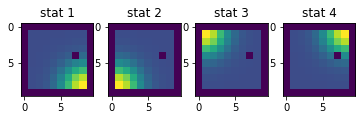

<Figure size 432x288 with 0 Axes>

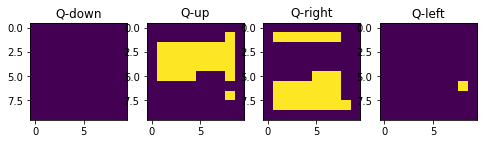

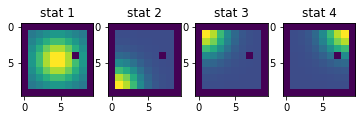

<Figure size 432x288 with 0 Axes>

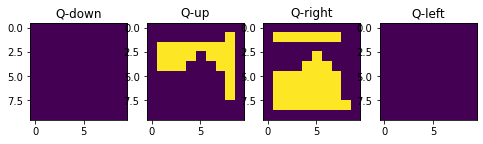

In [ ]:
test_stats = torch.tensor([5,5,5,4])

env.render()
agent_mon.display_q_map(stats_force = test_stats)
env.change_first_resource_map()
env.render()
agent_mon.display_q_map(stats_force = test_stats)
env.reset_grid()



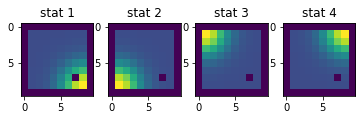

<Figure size 432x288 with 0 Axes>

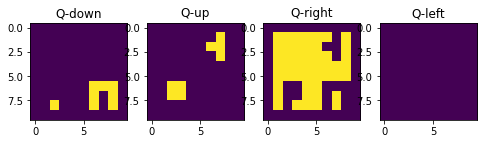

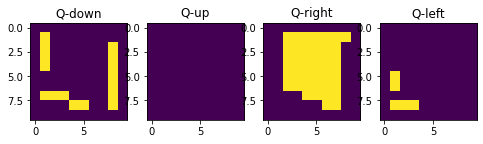

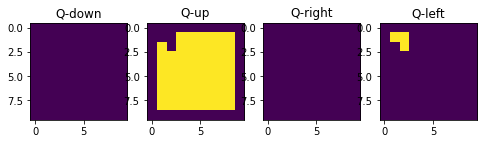

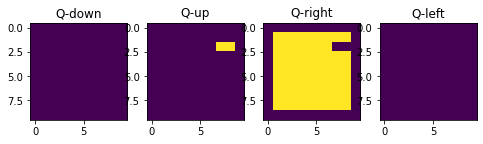

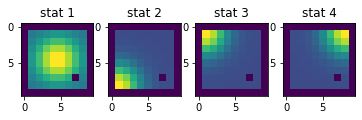

<Figure size 432x288 with 0 Axes>

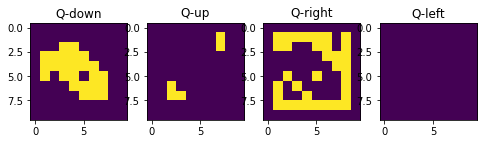

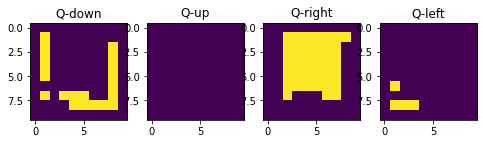

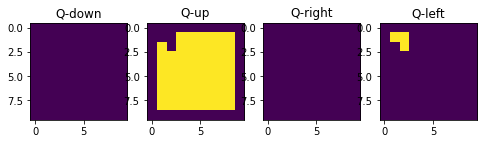

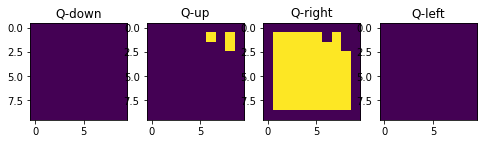

In [ ]:
test_stats = torch.tensor([4,4,4,4])

env.render()
agent_mod.display_q_map(stats_force = test_stats)
env.change_first_resource_map()
env.render()
agent_mod.display_q_map(stats_force = test_stats)
env.reset_grid()



## Value Maps

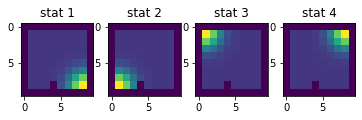

<Figure size 432x288 with 0 Axes>

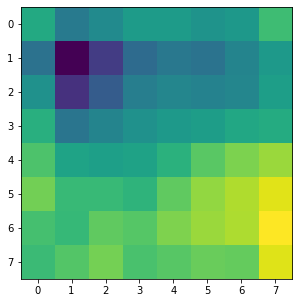

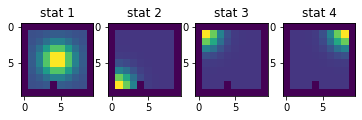

<Figure size 432x288 with 0 Axes>

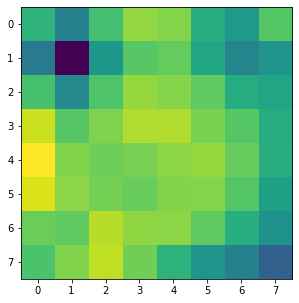

In [ ]:
test_stats = torch.tensor([0,1,1,1])

env.render()
agent_mon.display_v_map(stats_force = test_stats)
env.change_first_resource_map()
env.render()
agent_mon.display_v_map(stats_force = test_stats)
env.reset_grid()



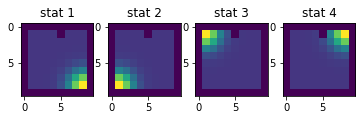

<Figure size 432x288 with 0 Axes>

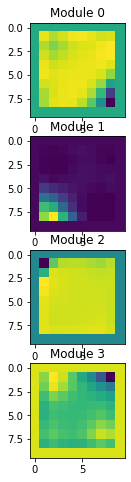

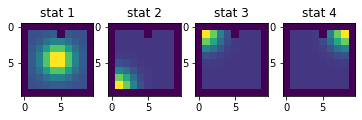

<Figure size 432x288 with 0 Axes>

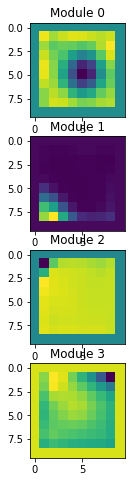

In [ ]:
test_stats = torch.tensor([4,0,4,4])

env.render()
agent_mod.display_v_map(stats_force = test_stats)
env.change_first_resource_map()
env.render()
agent_mod.display_v_map(stats_force = test_stats)
env.reset_grid()



## Test Deviations

In [ ]:
num_frames = 50000
train_results = []
test_results = []

for i in range(100):
  print(i)
  agent_mod = Modular_DQN_Agent(env, memory_size, batch_size, target_update, epsilon_decay, lr = lr, gamma = gamma, min_epsilon = min_epsilon, explore = explore, arbitrator_lr = arbitrator_lr, switch_episode = switch_episode)
  agent_mon = DQN_Agent(env, memory_size, batch_size, target_update, epsilon_decay, lr = lr, gamma = gamma, min_epsilon = min_epsilon, switch_episode = switch_episode)
  agent_mod.plotting = False
  agent_mon.plotting = False

  env.reset_for_new_agent()
  agent_mon.train(num_frames)
  env.reset_for_new_agent()
  agent_mod.train(num_frames)
  env.reset_for_new_agent()
  score, cum_dev, max_dev = test_random_agent(env, timesteps = num_frames)

  train_results.append([agent_mon.cumulative_deviation/num_frames, 
                        agent_mon.maximum_deviation,
                        agent_mod.cumulative_deviation/num_frames, 
                        agent_mod.maximum_deviation,
                        cum_dev/num_frames,
                        max_dev])


  # env.reset_for_new_agent()
  # score, cum_dev, max_dev = test_random_agent(env, timesteps = num_frames)
  # env.reset_for_new_agent()
  # score_mod, cum_dev_mod, max_dev_mod = agent_mod.test(num_frames,display=False)
  # env.reset_for_new_agent()
  # score_mon, cum_dev_mon, max_dev_mon = agent_mon.test(num_frames,display=False)

  # test_results.append([cum_dev_mon/num_frames,
  #                     max_dev_mon,
  #                     cum_dev_mod/num_frames,
  #                     max_dev_mod,
  #                     cum_dev/num_frames,
  #                     max_dev])

  np.save(parent_dir + 'saltatory_500_train_results_50k_001epsilon_03climb',train_results)
  # np.save(parent_dir + 'saltatory_500_test_results_2',test_results)

0
cuda
cuda
1
cuda
cuda
2
cuda
cuda
3
cuda
cuda
4
cuda
cuda
5
cuda
cuda
6
cuda
cuda
7
cuda
cuda
8
cuda
cuda
9
cuda
cuda
10
cuda
cuda
11
cuda
cuda
12
cuda
cuda
13
cuda
cuda
14
cuda
cuda
15
cuda
cuda
16
cuda
cuda
17
cuda
cuda
18
cuda
cuda
19
cuda
cuda
20
cuda
cuda
21
cuda
cuda
22
cuda
cuda
23
cuda
cuda
24
cuda
cuda
25
cuda
cuda
26
cuda
cuda
27
cuda
cuda
28
cuda
cuda
29
cuda
cuda
30
cuda
cuda


KeyboardInterrupt: ignored

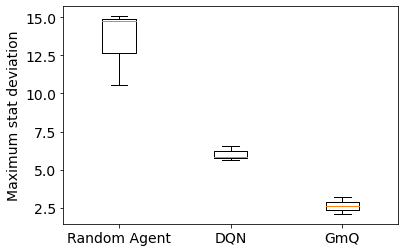

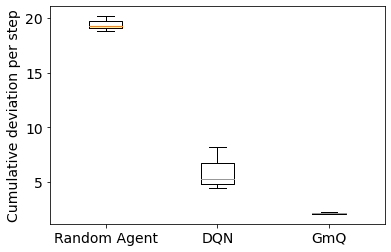

In [ ]:
plt.rcParams.update({'font.size': 14})
num_frames = 100000

# plt.figure()
# a = np.load(parent_dir + 'saltatory_500_test_results.npy')
# plt.plot(np.array(a)[:,0])
# plt.plot(np.array(a)[:,2])
# plt.plot(np.array(a)[:,4])
# plt.figure()
# plt.plot(np.array(a)[:,1])
# plt.plot(np.array(a)[:,3])
# plt.plot(np.array(a)[:,5])

# plt.figure()

# b = np.load(parent_dir + 'saltatory_500_train_results_2.npy') 
b = np.load(parent_dir + 'saltatory_500_train_results_100k_001epsilon.npy') 
# b = np.load(parent_dir + 'saltatory_500_train_results_50k_001epsilon_03climb.npy') 



# plt.plot(np.array(b)[:,0])
# plt.plot(np.array(b)[:,2])
# plt.plot(np.array(a)[:,4])
# plt.figure()

# plt.plot(np.array(b)[:,1])
# plt.plot(np.array(b)[:,3])
# plt.plot(np.array(a)[:,5])

## plotting

models = ['Random Agent','DQN','GmQ']
fig, ax = plt.subplots()
ax.boxplot([np.array(b)[:,5],np.array(b)[:,1],np.array(b)[:,3]],showfliers=False,whis=[0,100])
ax.set_ylabel('Maximum stat deviation')
# ax.set_xticks(range(3))
ax.set_xticklabels(models)
# ax.set_title(f'{num_frames} training steps')
# ax.yaxis.grid(True)
# ax.set_ylim([-300,50])

fig, ax = plt.subplots()
ax.boxplot([np.array(b)[:,4],np.array(b)[:,0],np.array(b)[:,2]],showfliers=False,whis=[0,100]);
ax.set_ylabel('Cumulative deviation per step');
# ax.set_xticks(range(3))
ax.set_xticklabels(models);
# ax.set_title(f'Training, environment changes every 500 steps')
# ax.yaxis.grid(True)
# ax.set_ylim([-300,50])

# fig, ax = plt.subplots()
# ax.boxplot([np.array(a)[:,5],np.array(a)[:,1],np.array(a)[:,3]],showfliers=False,whis=[0,100])
# ax.set_ylabel('Maximum stat deviation')
# # ax.set_xticks(range(3))
# ax.set_xticklabels(models)
# ax.set_title(f'Testing, stationary environment, 100k steps')
# # ax.yaxis.grid(True)
# # ax.set_ylim([-300,50])

# fig, ax = plt.subplots()
# ax.boxplot([np.array(a)[:,5],np.array(a)[:,0],np.array(a)[:,2]],showfliers=False,whis=[0,100])
# ax.set_ylabel('Mean cumulative stat deviation per step')
# # ax.set_xticks(range(3))
# ax.set_xticklabels(models)
# ax.set_title(f'Testing, stationary environment, 100k steps')
# # ax.yaxis.grid(True)
# # ax.set_ylim([-300,50])


In [ ]:
num_frames = 20000

env.reset_for_new_agent()
score, cum_dev, max_dev = test_random_agent(env, timesteps = num_frames)
env.reset_for_new_agent()
score_mod, cum_dev_mod, max_dev_mod = agent_mod.test(num_frames,display=False)
env.reset_for_new_agent()
score_mon, cum_dev_mon, max_dev_mon = agent_mon.test(num_frames,display=False)


print(agent_mon.cumulative_deviation/num_frames, 
      agent_mon.maximum_deviation,
      agent_mod.cumulative_deviation/num_frames, 
      agent_mod.maximum_deviation, 
      cum_dev/num_frames,
      max_dev)

print(cum_dev_mon/num_frames,
      max_dev_mon,
      cum_dev_mod/num_frames,
      max_dev_mod,
      cum_dev/num_frames,
      max_dev)

score:  -24435.988128581284
score:  -77898.63161219542
1.5542734930353788 1.8635503747487194 1.9327843533159454 1.7717533066803874 13.523617140315094 6.365681093620308
3.823507854303688 13.724959720196988 7.238040993634548 7.7046546034190175 13.523617140315094 6.365681093620308


In [ ]:
num_frames = 500
track_cum_mod = 0
track_cum_mon=0

env.reset_for_new_agent()

for i in range(100):
  env.reset()
  score_mod, cum_dev_mod, max_dev_mod = agent_mod.test(num_frames,display=False)
  track_cum_mod += cum_dev_mod

env.reset_for_new_agent()

for i in range(100):
  env.reset()
  score_mon, cum_dev_mon, max_dev_mon = agent_mon.test(num_frames,display=False)
  track_cum_mon += cum_dev_mon


score:  -610.8672412503984
score:  -971.2557516804784
score:  -1016.3078315304259
score:  -2023.2164703707833
score:  -2022.4836812069705
score:  -3207.5925093426376
score:  -4207.592509342524
score:  10641.272035005148
score:  -3189.756118325703
score:  -37.74904593043168
score:  -1394.136891675745
score:  -4480.392881200838
score:  -5480.392881200473
score:  -6432.860893107674
score:  2780.5000607212296
score:  -6862.571737108127
score:  -7862.571737107841
score:  -8862.571737109152
score:  -9862.571737111359
score:  13855.945229429255
score:  -9379.224297305125
score:  -3863.932185037221
score:  -10629.64611264771
score:  -11663.954283424939
score:  -12565.44149979902
score:  -13654.754729814864
score:  1309.6444343867822
score:  -13925.370840140084
score:  -14925.370840140065
score:  12898.833647644775
score:  -12464.449075645507
score:  -19470.671600403708
score:  -12953.993368555304
score:  -13953.993368555623
score:  -26300.934028885757
score:  6385.310444494538
score:  27368.42

## Test

Run the trained agent (1 episode).

Timestep: 1 , reward: 0.555 , modular reward: [-2.574 -1.599  8.079 -1.132] , Action:  up , stats:  [0.48 0.68 0.63 0.77] , Dead?:  False , Lowest:  0.49


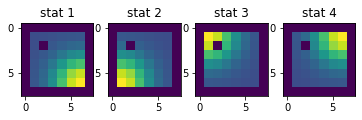

Timestep: 2 , reward: 0.355 , modular reward: [-2.624 -1.649  7.23  -1.182] , Action:  up , stats:  [0.47 0.67 0.67 0.76] , Dead?:  False , Lowest:  0.48


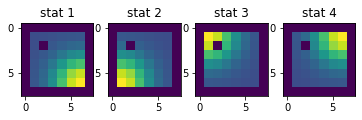

Timestep: 3 , reward: 0.155 , modular reward: [-2.674 -1.699  6.381 -1.232] , Action:  up , stats:  [0.46 0.66 0.71 0.75] , Dead?:  False , Lowest:  0.47


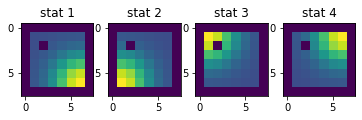

Timestep: 4 , reward: -0.045 , modular reward: [-2.724 -1.749  5.531 -1.282] , Action:  up , stats:  [0.45 0.65 0.75 0.74] , Dead?:  False , Lowest:  0.46


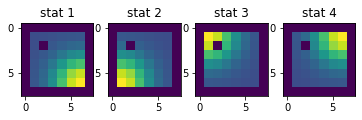

Timestep: 5 , reward: -0.245 , modular reward: [-2.774 -1.799  4.682 -1.332] , Action:  up , stats:  [0.44 0.64 0.79 0.73] , Dead?:  False , Lowest:  0.45


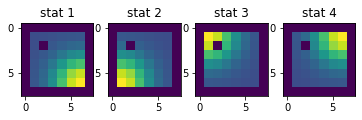

Timestep: 6 , reward: -0.444 , modular reward: [-2.824 -1.849  3.833 -1.382] , Action:  up , stats:  [0.43 0.63 0.83 0.72] , Dead?:  False , Lowest:  0.44


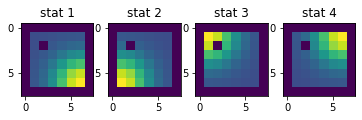

Timestep: 7 , reward: -0.644 , modular reward: [-2.874 -1.899  2.983 -1.432] , Action:  up , stats:  [0.42 0.62 0.88 0.71] , Dead?:  False , Lowest:  0.43


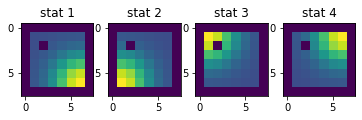

Timestep: 8 , reward: -0.844 , modular reward: [-2.924 -1.949  2.134 -1.482] , Action:  up , stats:  [0.41 0.61 0.92 0.7 ] , Dead?:  False , Lowest:  0.42


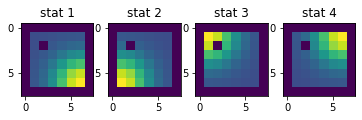

Timestep: 9 , reward: -1.044 , modular reward: [-2.974 -1.999  1.285 -1.532] , Action:  up , stats:  [0.4  0.6  0.96 0.69] , Dead?:  False , Lowest:  0.41


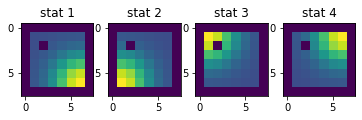

Timestep: 10 , reward: -1.244 , modular reward: [-3.024 -2.049  0.435 -1.582] , Action:  up , stats:  [0.39 0.59 1.   0.68] , Dead?:  False , Lowest:  0.4


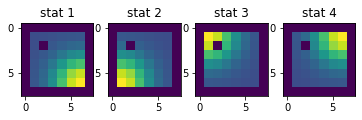

Timestep: 11 , reward: -1.444 , modular reward: [-3.074 -2.099 -0.414 -1.632] , Action:  up , stats:  [0.38 0.58 1.04 0.67] , Dead?:  False , Lowest:  0.39


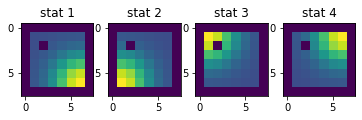

Timestep: 12 , reward: -1.355 , modular reward: [-3.124 -2.149  0.178 -1.682] , Action:  down , stats:  [0.37 0.57 1.03 0.66] , Dead?:  False , Lowest:  0.38


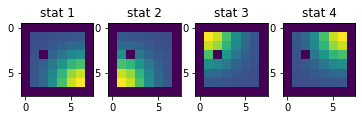

Timestep: 13 , reward: -1.395 , modular reward: [-3.174 -2.199  0.128 -1.732] , Action:  down , stats:  [0.36 0.56 1.02 0.65] , Dead?:  False , Lowest:  0.37


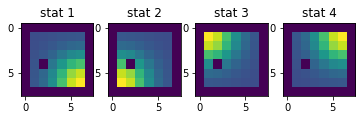

Timestep: 14 , reward: 0.763 , modular reward: [-3.224  8.743  0.078 -1.782] , Action:  down , stats:  [0.35 0.6  1.01 0.64] , Dead?:  False , Lowest:  0.36


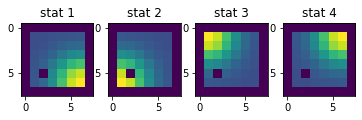

Timestep: 15 , reward: 0.79 , modular reward: [-3.274  9.028  0.028 -1.832] , Action:  down , stats:  [0.34 0.64 1.   0.63] , Dead?:  False , Lowest:  0.35


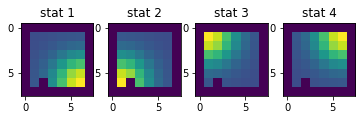

Timestep: 16 , reward: 0.534 , modular reward: [-3.324  7.899 -0.022 -1.882] , Action:  left , stats:  [0.33 0.69 0.99 0.62] , Dead?:  False , Lowest:  0.34


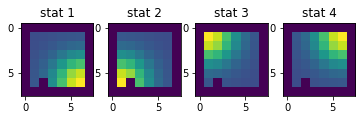

Timestep: 17 , reward: 0.278 , modular reward: [-3.374  6.769 -0.072 -1.932] , Action:  left , stats:  [0.32 0.74 0.98 0.61] , Dead?:  False , Lowest:  0.33


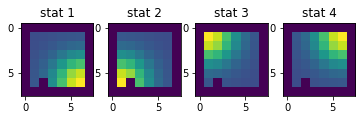

Timestep: 18 , reward: 0.023 , modular reward: [-3.424  5.64  -0.122 -1.982] , Action:  left , stats:  [0.31 0.79 0.97 0.6 ] , Dead?:  False , Lowest:  0.32


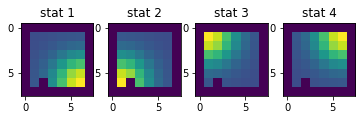

Timestep: 19 , reward: -0.233 , modular reward: [-3.474  4.51  -0.172 -2.032] , Action:  left , stats:  [0.3  0.83 0.96 0.59] , Dead?:  False , Lowest:  0.31


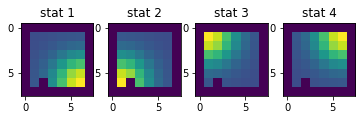

Timestep: 20 , reward: -0.489 , modular reward: [-3.524  3.38  -0.222 -2.082] , Action:  left , stats:  [0.29 0.88 0.95 0.58] , Dead?:  False , Lowest:  0.3


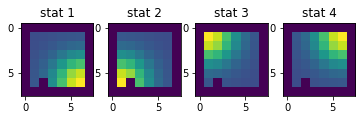

Timestep: 21 , reward: -0.745 , modular reward: [-3.574  2.251 -0.272 -2.132] , Action:  left , stats:  [0.28 0.93 0.94 0.57] , Dead?:  False , Lowest:  0.29


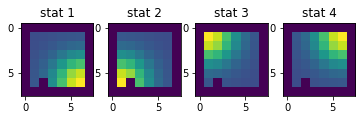

Timestep: 22 , reward: -1.018 , modular reward: [-3.624  1.037 -0.322 -2.182] , Action:  up , stats:  [0.27 0.97 0.93 0.56] , Dead?:  False , Lowest:  0.28


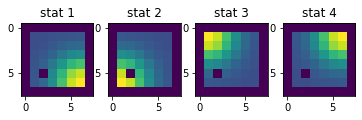

Timestep: 23 , reward: -1.218 , modular reward: [-3.674  0.188 -0.372 -2.232] , Action:  left , stats:  [0.26 1.01 0.92 0.55] , Dead?:  False , Lowest:  0.27


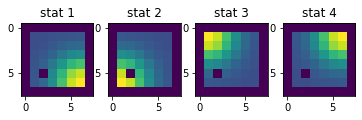

Timestep: 24 , reward: -1.279 , modular reward: [-3.724  0.032 -0.422 -2.282] , Action:  up , stats:  [0.25 1.   0.91 0.54] , Dead?:  False , Lowest:  0.26


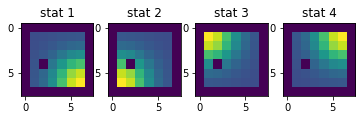

Timestep: 25 , reward: -1.319 , modular reward: [-3.774 -0.018 -0.472 -2.332] , Action:  up , stats:  [0.24 0.99 0.9  0.53] , Dead?:  False , Lowest:  0.25


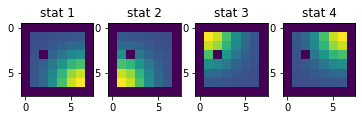

Timestep: 26 , reward: -0.93 , modular reward: [-3.824 -0.068  1.622 -2.382] , Action:  up , stats:  [0.23 0.98 0.94 0.52] , Dead?:  False , Lowest:  0.24


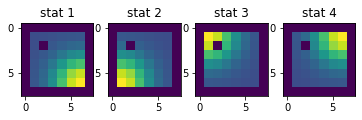

Timestep: 27 , reward: -1.13 , modular reward: [-3.874 -0.118  0.772 -2.432] , Action:  up , stats:  [0.22 0.97 0.98 0.51] , Dead?:  False , Lowest:  0.23


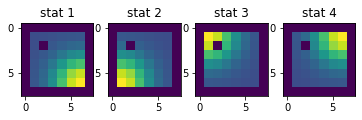

Timestep: 28 , reward: -1.33 , modular reward: [-3.924 -0.168 -0.077 -2.482] , Action:  up , stats:  [0.21 0.96 1.02 0.5 ] , Dead?:  False , Lowest:  0.22


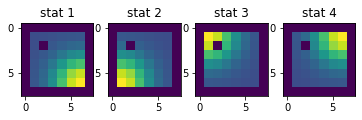

Timestep: 29 , reward: -1.325 , modular reward: [-3.974 -0.218  0.097 -2.532] , Action:  down , stats:  [0.2  0.95 1.01 0.49] , Dead?:  False , Lowest:  0.21


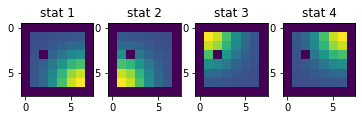

Timestep: 30 , reward: -1.365 , modular reward: [-4.024 -0.268  0.047 -2.582] , Action:  down , stats:  [0.19 0.94 1.   0.48] , Dead?:  False , Lowest:  0.2


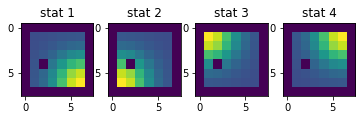

Timestep: 31 , reward: -1.186 , modular reward: [-4.074e+00  7.810e-01 -3.000e-03 -2.632e+00] , Action:  down , stats:  [0.18 0.98 0.99 0.47] , Dead?:  False , Lowest:  0.19


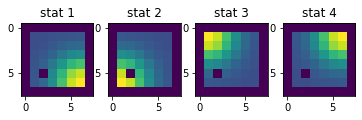

Timestep: 32 , reward: -1.394 , modular reward: [-4.124 -0.112 -0.053 -2.682] , Action:  up , stats:  [0.17 0.97 0.98 0.46] , Dead?:  False , Lowest:  0.18


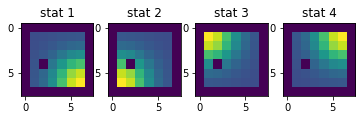

Timestep: 33 , reward: -1.374 , modular reward: [-4.174  0.138 -0.103 -2.732] , Action:  down , stats:  [0.16 1.01 0.97 0.45] , Dead?:  False , Lowest:  0.17


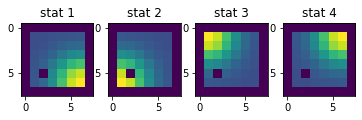

Timestep: 34 , reward: -1.423 , modular reward: [-4.224  0.045 -0.153 -2.782] , Action:  up , stats:  [0.15 1.   0.96 0.44] , Dead?:  False , Lowest:  0.16


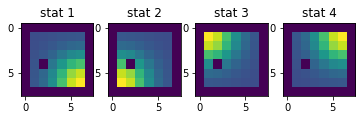

Timestep: 35 , reward: -1.463 , modular reward: [-4.274 -0.005 -0.203 -2.832] , Action:  up , stats:  [0.14 0.99 0.95 0.43] , Dead?:  False , Lowest:  0.15


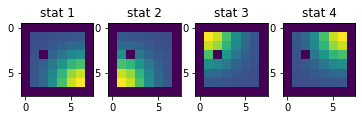

Timestep: 36 , reward: -1.349 , modular reward: [-4.324 -0.055  0.516 -2.882] , Action:  up , stats:  [0.13 0.98 1.   0.42] , Dead?:  False , Lowest:  0.14


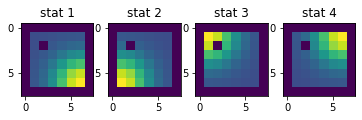

Timestep: 37 , reward: -1.549 , modular reward: [-4.374 -0.105 -0.333 -2.932] , Action:  up , stats:  [0.12 0.97 1.04 0.41] , Dead?:  False , Lowest:  0.13


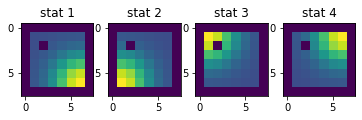

Timestep: 38 , reward: -1.48 , modular reward: [-4.424 -0.155  0.159 -2.982] , Action:  down , stats:  [0.11 0.96 1.03 0.4 ] , Dead?:  False , Lowest:  0.12


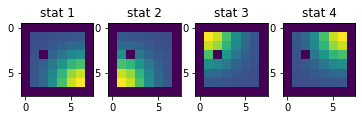

Timestep: 39 , reward: -1.52 , modular reward: [-4.474 -0.205  0.109 -3.032] , Action:  down , stats:  [0.1  0.95 1.02 0.39] , Dead?:  False , Lowest:  0.11


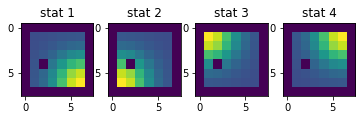

Timestep: 40 , reward: -1.404 , modular reward: [-4.524  0.525  0.059 -3.082] , Action:  down , stats:  [0.09 1.   1.01 0.38] , Dead?:  False , Lowest:  0.1


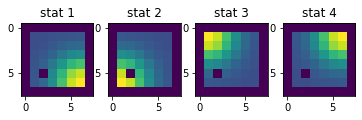

Timestep: 41 , reward: -1.549 , modular reward: [-4.574 -0.049  0.009 -3.132] , Action:  up , stats:  [0.08 0.99 1.   0.37] , Dead?:  False , Lowest:  0.09


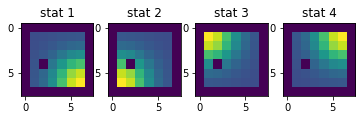

Timestep: 42 , reward: -1.589 , modular reward: [-4.624 -0.099 -0.041 -3.182] , Action:  up , stats:  [0.07 0.98 0.99 0.36] , Dead?:  False , Lowest:  0.08


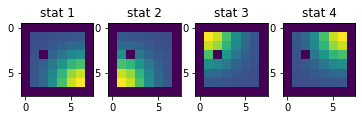

Timestep: 43 , reward: -1.641 , modular reward: [-4.674 -0.149 -0.152 -3.232] , Action:  up , stats:  [0.06 0.97 1.03 0.35] , Dead?:  False , Lowest:  0.07


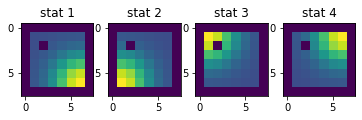

Timestep: 44 , reward: -1.618 , modular reward: [-4.724 -0.199  0.115 -3.282] , Action:  down , stats:  [0.05 0.96 1.02 0.34] , Dead?:  False , Lowest:  0.06


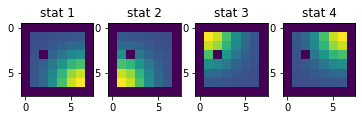

Timestep: 45 , reward: -1.658 , modular reward: [-4.774 -0.249  0.065 -3.332] , Action:  down , stats:  [0.04 0.95 1.01 0.33] , Dead?:  False , Lowest:  0.05


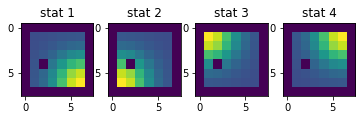

Timestep: 46 , reward: -1.497 , modular reward: [-4.824  0.706  0.015 -3.382] , Action:  down , stats:  [0.03 0.99 1.   0.32] , Dead?:  False , Lowest:  0.04


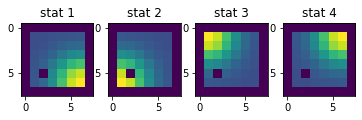

Timestep: 47 , reward: -1.687 , modular reward: [-4.874 -0.093 -0.035 -3.432] , Action:  up , stats:  [0.02 0.98 0.99 0.31] , Dead?:  False , Lowest:  0.03


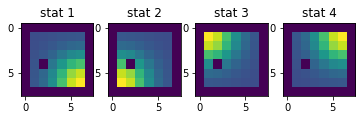

Timestep: 48 , reward: -1.686 , modular reward: [-4.924  0.063 -0.085 -3.482] , Action:  down , stats:  [0.01 1.02 0.98 0.3 ] , Dead?:  False , Lowest:  0.02


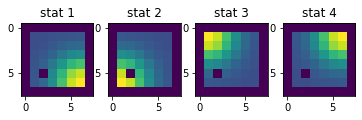

Timestep: 49 , reward: -1.716 , modular reward: [-4.974  0.063 -0.135 -3.532] , Action:  up , stats:  [0.   1.01 0.97 0.29] , Dead?:  False , Lowest:  0.01


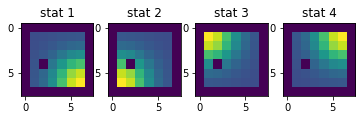

Timestep: 50 , reward: -1.756 , modular reward: [-5.024  0.013 -0.185 -3.582] , Action:  up , stats:  [-0.01  1.    0.96  0.28] , Dead?:  True , Lowest:  0.0


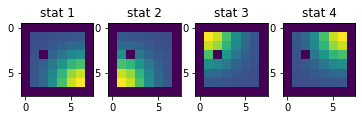

score:  -48.17098026701882
score:  10.35490789335669
Timestep: 1 , reward: 1.175 , modular reward: [11.356 -2.157 -2.231 -1.091] , Action:  right , stats:  [0.55 0.56 0.55 0.78] , Dead?:  False , Lowest:  0.5


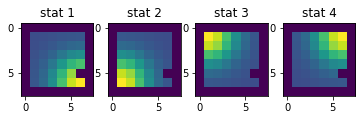

Timestep: 2 , reward: 1.205 , modular reward: [11.656 -2.207 -2.281 -1.141] , Action:  down , stats:  [0.6  0.55 0.54 0.77] , Dead?:  False , Lowest:  0.5


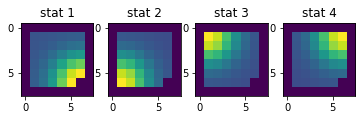

Timestep: 3 , reward: 0.877 , modular reward: [10.164 -2.257 -2.331 -1.191] , Action:  down , stats:  [0.66 0.54 0.53 0.76] , Dead?:  False , Lowest:  0.5


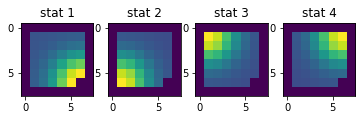

Timestep: 4 , reward: 0.549 , modular reward: [ 8.672 -2.307 -2.381 -1.241] , Action:  down , stats:  [0.71 0.53 0.52 0.75] , Dead?:  False , Lowest:  0.5


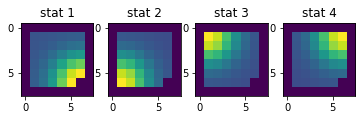

Timestep: 5 , reward: 0.22 , modular reward: [ 7.18  -2.357 -2.431 -1.291] , Action:  down , stats:  [0.76 0.52 0.51 0.74] , Dead?:  False , Lowest:  0.5


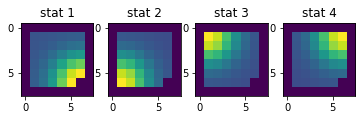

Timestep: 6 , reward: -0.108 , modular reward: [ 5.688 -2.407 -2.481 -1.341] , Action:  down , stats:  [0.82 0.51 0.5  0.73] , Dead?:  False , Lowest:  0.5


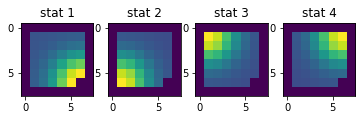

Timestep: 7 , reward: -0.436 , modular reward: [ 4.196 -2.457 -2.531 -1.391] , Action:  down , stats:  [0.87 0.5  0.49 0.72] , Dead?:  False , Lowest:  0.5


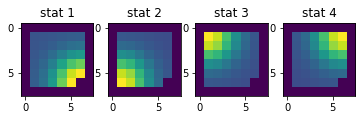

Timestep: 8 , reward: -0.765 , modular reward: [ 2.704 -2.507 -2.581 -1.441] , Action:  down , stats:  [0.93 0.49 0.48 0.71] , Dead?:  False , Lowest:  0.49


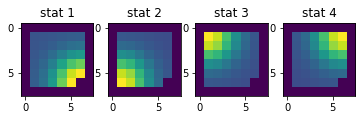

Timestep: 9 , reward: -1.093 , modular reward: [ 1.212 -2.557 -2.631 -1.491] , Action:  down , stats:  [0.98 0.48 0.47 0.7 ] , Dead?:  False , Lowest:  0.48


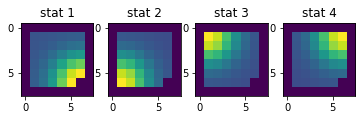

Timestep: 10 , reward: -1.422 , modular reward: [-0.28  -2.607 -2.681 -1.541] , Action:  down , stats:  [1.04 0.47 0.46 0.69] , Dead?:  False , Lowest:  0.47


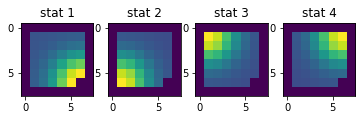

Timestep: 11 , reward: -1.687 , modular reward: [-1.457 -2.657 -2.731 -1.591] , Action:  up , stats:  [1.09 0.46 0.45 0.68] , Dead?:  False , Lowest:  0.46


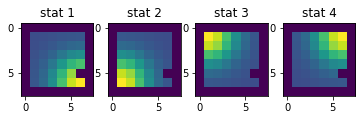

Timestep: 12 , reward: -1.346 , modular reward: [ 0.4   -2.707 -2.781 -1.641] , Action:  up , stats:  [1.08 0.45 0.44 0.67] , Dead?:  False , Lowest:  0.45


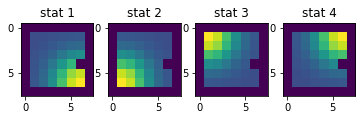

Timestep: 13 , reward: -1.386 , modular reward: [ 0.35  -2.757 -2.831 -1.691] , Action:  up , stats:  [1.07 0.44 0.43 0.66] , Dead?:  False , Lowest:  0.44


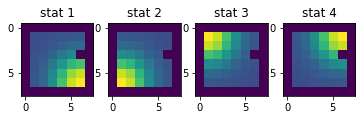

Timestep: 14 , reward: 0.441 , modular reward: [ 0.3   -2.807 -2.881  7.591] , Action:  up , stats:  [1.06 0.43 0.42 0.7 ] , Dead?:  False , Lowest:  0.43


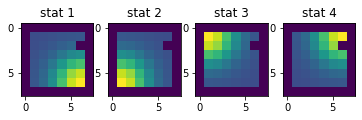

Timestep: 15 , reward: 0.185 , modular reward: [ 0.25  -2.857 -2.931  6.462] , Action:  up , stats:  [1.05 0.42 0.41 0.75] , Dead?:  False , Lowest:  0.42


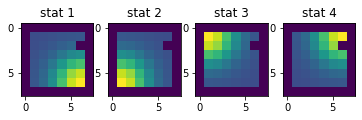

Timestep: 16 , reward: -0.071 , modular reward: [ 0.2   -2.907 -2.981  5.332] , Action:  up , stats:  [1.04 0.41 0.4  0.8 ] , Dead?:  False , Lowest:  0.41


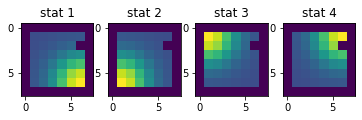

Timestep: 17 , reward: -0.327 , modular reward: [ 0.15  -2.957 -3.031  4.202] , Action:  up , stats:  [1.03 0.4  0.39 0.85] , Dead?:  False , Lowest:  0.4


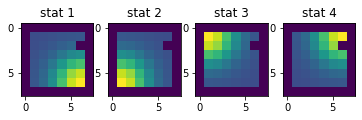

Timestep: 18 , reward: -0.583 , modular reward: [ 0.1   -3.007 -3.081  3.073] , Action:  up , stats:  [1.02 0.39 0.38 0.89] , Dead?:  False , Lowest:  0.39


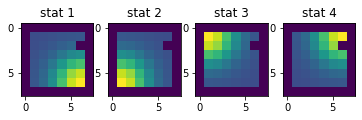

Timestep: 19 , reward: -0.839 , modular reward: [ 0.05  -3.057 -3.131  1.943] , Action:  up , stats:  [1.01 0.38 0.37 0.94] , Dead?:  False , Lowest:  0.38


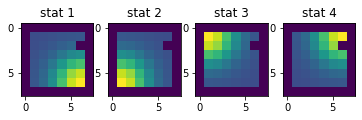

Timestep: 20 , reward: -1.095 , modular reward: [ 0.    -3.107 -3.181  0.814] , Action:  up , stats:  [1.   0.37 0.36 0.99] , Dead?:  False , Lowest:  0.37


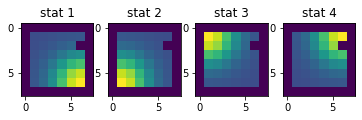

Timestep: 21 , reward: -1.303 , modular reward: [-0.05  -3.157 -3.231 -0.077] , Action:  down , stats:  [0.99 0.36 0.35 0.98] , Dead?:  False , Lowest:  0.36


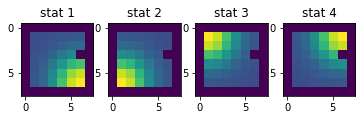

Timestep: 22 , reward: -1.343 , modular reward: [-0.1   -3.207 -3.281 -0.127] , Action:  down , stats:  [0.98 0.35 0.34 0.97] , Dead?:  False , Lowest:  0.35


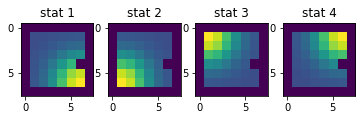

Timestep: 23 , reward: -1.348 , modular reward: [ 0.028 -3.257 -3.331 -0.177] , Action:  down , stats:  [1.02 0.34 0.33 0.96] , Dead?:  False , Lowest:  0.34


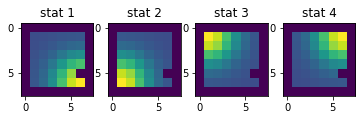

Timestep: 24 , reward: -1.365 , modular reward: [ 0.088 -3.307 -3.381 -0.227] , Action:  up , stats:  [1.01 0.33 0.32 0.95] , Dead?:  False , Lowest:  0.33


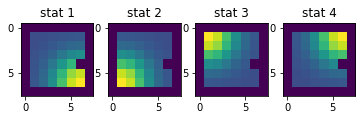

Timestep: 25 , reward: -1.405 , modular reward: [ 0.038 -3.357 -3.431 -0.277] , Action:  left , stats:  [1.   0.32 0.31 0.94] , Dead?:  False , Lowest:  0.32


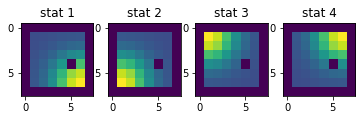

Timestep: 26 , reward: -1.445 , modular reward: [-0.012 -3.407 -3.481 -0.327] , Action:  left , stats:  [0.99 0.31 0.3  0.93] , Dead?:  False , Lowest:  0.31


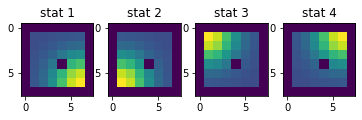

Timestep: 27 , reward: -1.485 , modular reward: [-0.062 -3.457 -3.531 -0.377] , Action:  up , stats:  [0.98 0.3  0.29 0.92] , Dead?:  False , Lowest:  0.3


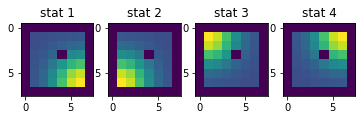

Timestep: 28 , reward: -1.525 , modular reward: [-0.112 -3.507 -3.581 -0.427] , Action:  up , stats:  [0.97 0.29 0.28 0.91] , Dead?:  False , Lowest:  0.29


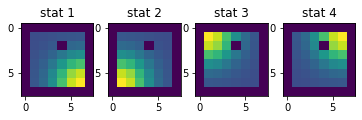

Timestep: 29 , reward: -1.182 , modular reward: [-0.162 -3.557 -3.631  1.44 ] , Action:  right , stats:  [0.96 0.28 0.27 0.95] , Dead?:  False , Lowest:  0.28


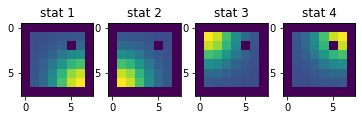

Timestep: 30 , reward: -1.382 , modular reward: [-0.212 -3.607 -3.681  0.59 ] , Action:  up , stats:  [0.95 0.27 0.26 0.99] , Dead?:  False , Lowest:  0.27


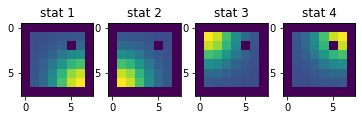

Timestep: 31 , reward: -1.543 , modular reward: [-0.262 -3.657 -3.731 -0.065] , Action:  left , stats:  [0.94 0.26 0.25 0.98] , Dead?:  False , Lowest:  0.26


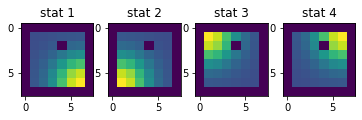

Timestep: 32 , reward: -1.583 , modular reward: [-0.312 -3.707 -3.781 -0.115] , Action:  up , stats:  [0.93 0.25 0.24 0.97] , Dead?:  False , Lowest:  0.25


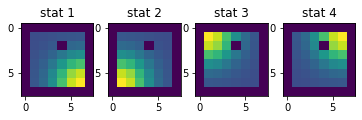

Timestep: 33 , reward: -1.559 , modular reward: [-0.362 -3.757 -3.831  0.153] , Action:  right , stats:  [0.92 0.24 0.23 1.01] , Dead?:  False , Lowest:  0.24


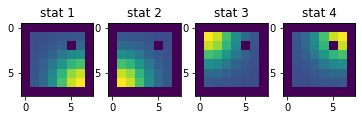

Timestep: 34 , reward: -1.612 , modular reward: [-0.412 -3.807 -3.881  0.041] , Action:  left , stats:  [0.91 0.23 0.22 1.  ] , Dead?:  False , Lowest:  0.23


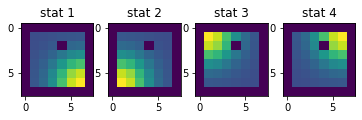

Timestep: 35 , reward: -1.652 , modular reward: [-0.462 -3.857 -3.931 -0.009] , Action:  up , stats:  [0.9  0.22 0.21 0.99] , Dead?:  False , Lowest:  0.22


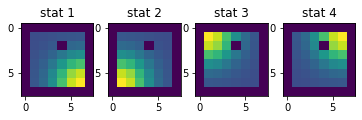

Timestep: 36 , reward: -1.692 , modular reward: [-0.512 -3.907 -3.981 -0.059] , Action:  up , stats:  [0.89 0.21 0.2  0.98] , Dead?:  False , Lowest:  0.21


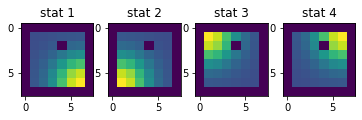

Timestep: 37 , reward: -1.732 , modular reward: [-0.562 -3.957 -4.031 -0.109] , Action:  up , stats:  [0.88 0.2  0.19 0.97] , Dead?:  False , Lowest:  0.2


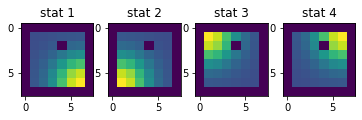

Timestep: 38 , reward: -1.772 , modular reward: [-0.612 -4.007 -4.081 -0.159] , Action:  up , stats:  [0.87 0.19 0.18 0.96] , Dead?:  False , Lowest:  0.19


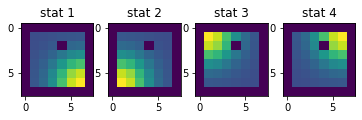

Timestep: 39 , reward: -1.703 , modular reward: [-0.662 -4.057 -4.131  0.334] , Action:  right , stats:  [0.86 0.18 0.17 1.  ] , Dead?:  False , Lowest:  0.18


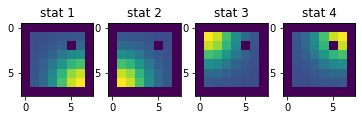

Timestep: 40 , reward: -1.801 , modular reward: [-7.120e-01 -4.107e+00 -4.181e+00 -3.000e-03] , Action:  down , stats:  [0.85 0.17 0.16 0.99] , Dead?:  False , Lowest:  0.17


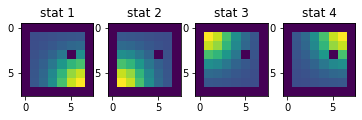

Timestep: 41 , reward: -1.841 , modular reward: [-0.762 -4.157 -4.231 -0.053] , Action:  down , stats:  [0.84 0.16 0.15 0.98] , Dead?:  False , Lowest:  0.16


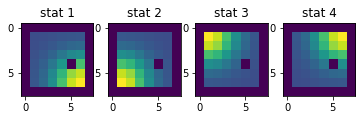

Timestep: 42 , reward: -1.154 , modular reward: [ 2.819 -4.207 -4.281 -0.103] , Action:  down , stats:  [0.88 0.15 0.14 0.97] , Dead?:  False , Lowest:  0.15


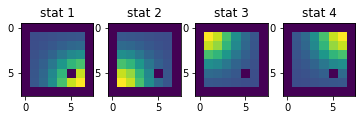

Timestep: 43 , reward: -1.309 , modular reward: [ 2.196 -4.257 -4.331 -0.153] , Action:  down , stats:  [0.93 0.14 0.13 0.96] , Dead?:  False , Lowest:  0.14


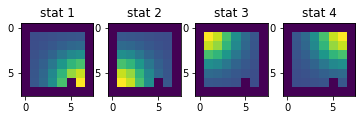

Timestep: 44 , reward: -1.565 , modular reward: [ 1.067 -4.307 -4.381 -0.203] , Action:  down , stats:  [0.98 0.13 0.12 0.95] , Dead?:  False , Lowest:  0.13


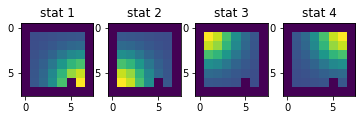

Timestep: 45 , reward: -1.806 , modular reward: [ 0.011 -4.357 -4.431 -0.253] , Action:  up , stats:  [1.02 0.12 0.11 0.94] , Dead?:  False , Lowest:  0.12


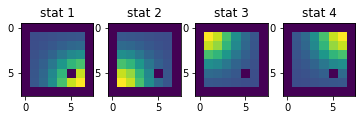

Timestep: 46 , reward: -1.823 , modular reward: [ 0.075 -4.407 -4.481 -0.303] , Action:  left , stats:  [1.01 0.11 0.1  0.93] , Dead?:  False , Lowest:  0.11


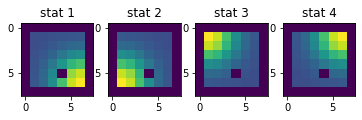

Timestep: 47 , reward: -1.863 , modular reward: [ 0.025 -4.457 -4.531 -0.353] , Action:  up , stats:  [1.   0.1  0.09 0.92] , Dead?:  False , Lowest:  0.1


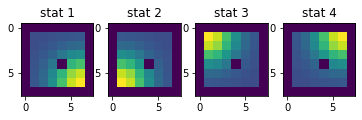

Timestep: 48 , reward: -1.903 , modular reward: [-0.025 -4.507 -4.581 -0.403] , Action:  down , stats:  [0.99 0.09 0.08 0.91] , Dead?:  False , Lowest:  0.09


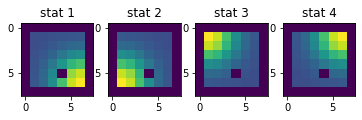

Timestep: 49 , reward: -1.943 , modular reward: [-0.075 -4.557 -4.631 -0.453] , Action:  up , stats:  [0.98 0.08 0.07 0.9 ] , Dead?:  False , Lowest:  0.08


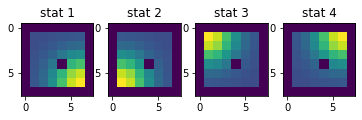

Timestep: 50 , reward: -1.983 , modular reward: [-0.125 -4.607 -4.681 -0.503] , Action:  right , stats:  [0.97 0.07 0.06 0.89] , Dead?:  False , Lowest:  0.07


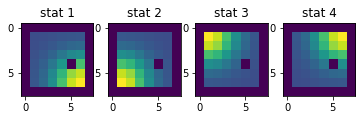

score:  -54.128548279290364
score:  17.531407926247944
Timestep: 1 , reward: 0.917 , modular reward: [-2.448 -2.127 10.751 -1.591] , Action:  left , stats:  [0.51 0.57 0.57 0.68] , Dead?:  False , Lowest:  0.52


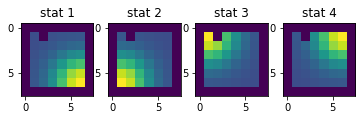

Timestep: 2 , reward: 0.661 , modular reward: [-2.498 -2.177  9.622 -1.641] , Action:  left , stats:  [0.5  0.56 0.62 0.67] , Dead?:  False , Lowest:  0.51


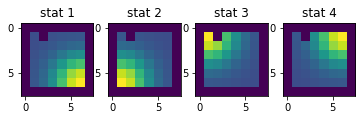

Timestep: 3 , reward: 0.405 , modular reward: [-2.548 -2.227  8.492 -1.691] , Action:  left , stats:  [0.49 0.55 0.67 0.66] , Dead?:  False , Lowest:  0.5


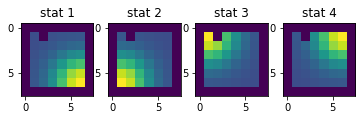

Timestep: 4 , reward: 0.149 , modular reward: [-2.598 -2.277  7.363 -1.741] , Action:  left , stats:  [0.48 0.54 0.71 0.65] , Dead?:  False , Lowest:  0.49


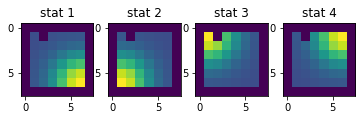

Timestep: 5 , reward: -0.106 , modular reward: [-2.648 -2.327  6.233 -1.791] , Action:  up , stats:  [0.47 0.53 0.76 0.64] , Dead?:  False , Lowest:  0.48


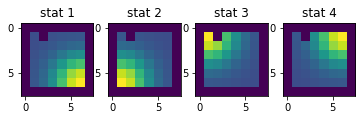

Timestep: 6 , reward: -0.362 , modular reward: [-2.698 -2.377  5.104 -1.841] , Action:  up , stats:  [0.46 0.52 0.81 0.63] , Dead?:  False , Lowest:  0.47


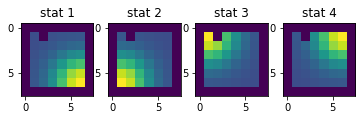

Timestep: 7 , reward: -0.618 , modular reward: [-2.748 -2.427  3.974 -1.891] , Action:  up , stats:  [0.45 0.51 0.86 0.62] , Dead?:  False , Lowest:  0.46


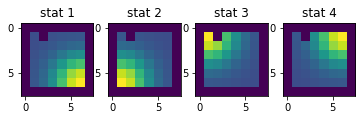

Timestep: 8 , reward: -0.874 , modular reward: [-2.798 -2.477  2.844 -1.941] , Action:  up , stats:  [0.44 0.5  0.9  0.61] , Dead?:  False , Lowest:  0.45


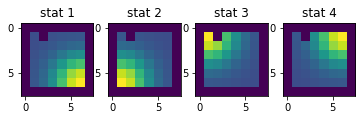

Timestep: 9 , reward: -1.13 , modular reward: [-2.848 -2.527  1.715 -1.991] , Action:  up , stats:  [0.43 0.49 0.95 0.6 ] , Dead?:  False , Lowest:  0.44


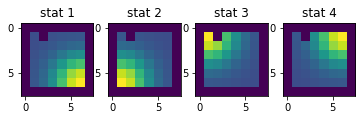

Timestep: 10 , reward: -1.386 , modular reward: [-2.898 -2.577  0.585 -2.041] , Action:  up , stats:  [0.42 0.48 1.   0.59] , Dead?:  False , Lowest:  0.43


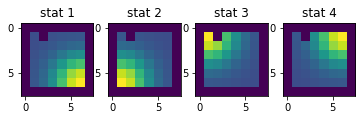

Timestep: 11 , reward: -1.539 , modular reward: [-2.948 -2.627 -0.029 -2.091] , Action:  right , stats:  [0.41 0.47 0.99 0.58] , Dead?:  False , Lowest:  0.42


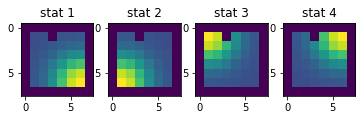

Timestep: 12 , reward: -1.579 , modular reward: [-2.998 -2.677 -0.079 -2.141] , Action:  up , stats:  [0.4  0.46 0.98 0.57] , Dead?:  False , Lowest:  0.41


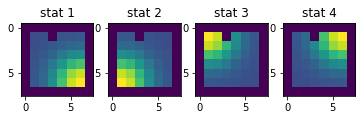

Timestep: 13 , reward: -1.619 , modular reward: [-3.048 -2.727 -0.129 -2.191] , Action:  up , stats:  [0.39 0.45 0.97 0.56] , Dead?:  False , Lowest:  0.4


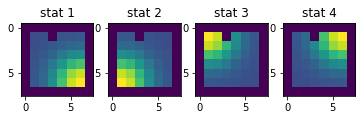

Timestep: 14 , reward: -1.589 , modular reward: [-3.098 -2.777  0.169 -2.241] , Action:  left , stats:  [0.38 0.44 1.02 0.55] , Dead?:  False , Lowest:  0.39


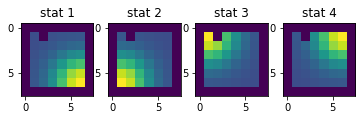

Timestep: 15 , reward: -1.641 , modular reward: [-3.148 -2.827  0.058 -2.291] , Action:  right , stats:  [0.37 0.43 1.01 0.54] , Dead?:  False , Lowest:  0.38


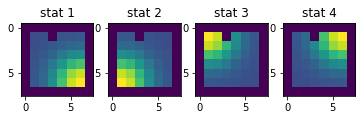

Timestep: 16 , reward: -1.681 , modular reward: [-3.198 -2.877  0.008 -2.341] , Action:  up , stats:  [0.36 0.42 1.   0.53] , Dead?:  False , Lowest:  0.37


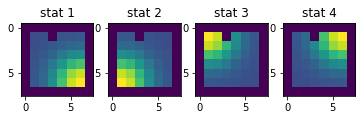

Timestep: 17 , reward: -1.721 , modular reward: [-3.248 -2.927 -0.042 -2.391] , Action:  up , stats:  [0.35 0.41 0.99 0.52] , Dead?:  False , Lowest:  0.36


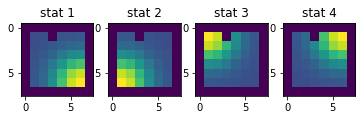

Timestep: 18 , reward: -1.761 , modular reward: [-3.298 -2.977 -0.092 -2.441] , Action:  up , stats:  [0.34 0.4  0.98 0.51] , Dead?:  False , Lowest:  0.35


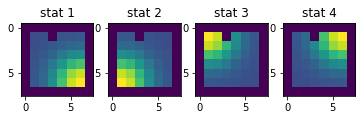

Timestep: 19 , reward: -1.775 , modular reward: [-3.348 -3.027 -0.01  -2.491] , Action:  left , stats:  [0.33 0.39 1.02 0.5 ] , Dead?:  False , Lowest:  0.34


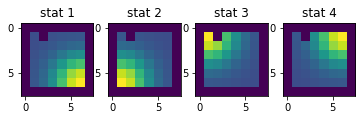

Timestep: 20 , reward: -1.784 , modular reward: [-3.398 -3.077  0.096 -2.541] , Action:  right , stats:  [0.32 0.38 1.01 0.49] , Dead?:  False , Lowest:  0.33


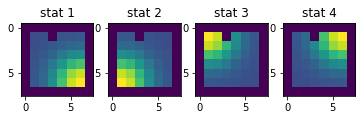

Timestep: 21 , reward: -1.824 , modular reward: [-3.448 -3.127  0.046 -2.591] , Action:  up , stats:  [0.31 0.37 1.   0.48] , Dead?:  False , Lowest:  0.32


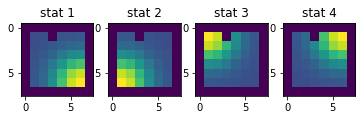

Timestep: 22 , reward: -1.864 , modular reward: [-3.498 -3.177 -0.004 -2.641] , Action:  up , stats:  [0.3  0.36 0.99 0.47] , Dead?:  False , Lowest:  0.31


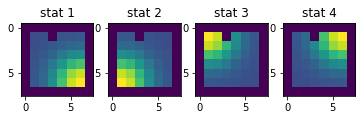

Timestep: 23 , reward: -1.904 , modular reward: [-3.548 -3.227 -0.054 -2.691] , Action:  up , stats:  [0.29 0.35 0.98 0.46] , Dead?:  False , Lowest:  0.3


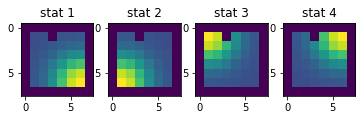

Timestep: 24 , reward: -1.944 , modular reward: [-3.598 -3.277 -0.104 -2.741] , Action:  up , stats:  [0.28 0.34 0.97 0.45] , Dead?:  False , Lowest:  0.29


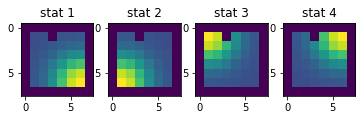

Timestep: 25 , reward: -1.943 , modular reward: [-3.648 -3.327  0.048 -2.791] , Action:  left , stats:  [0.27 0.33 1.02 0.44] , Dead?:  False , Lowest:  0.28


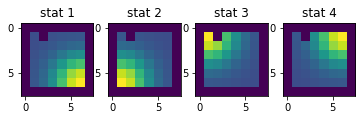

Timestep: 26 , reward: -1.966 , modular reward: [-3.698 -3.377  0.084 -2.841] , Action:  right , stats:  [0.26 0.32 1.01 0.43] , Dead?:  False , Lowest:  0.27


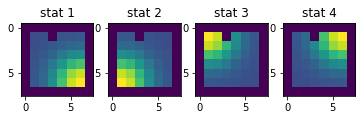

Timestep: 27 , reward: -2.006 , modular reward: [-3.748 -3.427  0.034 -2.891] , Action:  up , stats:  [0.25 0.31 1.   0.42] , Dead?:  False , Lowest:  0.26


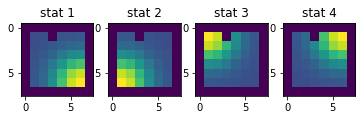

Timestep: 28 , reward: -2.046 , modular reward: [-3.798 -3.477 -0.016 -2.941] , Action:  up , stats:  [0.24 0.3  0.99 0.41] , Dead?:  False , Lowest:  0.25


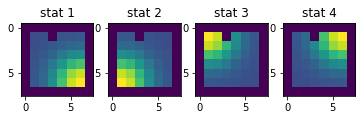

Timestep: 29 , reward: -2.086 , modular reward: [-3.848 -3.527 -0.066 -2.991] , Action:  up , stats:  [0.23 0.29 0.98 0.4 ] , Dead?:  False , Lowest:  0.24


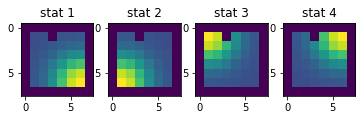

Timestep: 30 , reward: -2.126 , modular reward: [-3.898 -3.577 -0.116 -3.041] , Action:  up , stats:  [0.22 0.28 0.97 0.39] , Dead?:  False , Lowest:  0.23


KeyboardInterrupt: ignored

In [ ]:
import copy
# env = env_fn()
score_mod = []
score_mon = []
timesteps = 50

for i in range(100):
  env.reset()
  # env.change_first_resource_map()
  # env.reset_grid()
  # 
  scoremod = agent_mod.test(timesteps,display=False)
  scoremon = agent_mon.test(timesteps,display=False)


  score_mod.append(scoremod)
  score_mon.append(scoremon)
  # env.render()


## Analysis of models

In [ ]:
def test_random_agent(env, timesteps = 50):
        state = env.reset().unsqueeze(0)
        score = 0
        t = 0
        cumulative_deviation = 0
        maximum_deviation = 0

        while t < timesteps:
            action = env.action_space.sample()
            next_state, reward, done, info = env.step(action)
            state = next_state.unsqueeze(0)
            score += reward
            t+=1

            cumulative_deviation += sum([abs(stat - 1) for stat in env.stats])
            for stat in env.stats:
              if abs(stat) > maximum_deviation: maximum_deviation = abs(stat)


        return score, cumulative_deviation, maximum_deviation

def test_oracle_agent(env, timesteps = 50):
        state = env.reset().unsqueeze(0)
        score = 0
        t = 0

        while t < timesteps:
            action = env.action_space.sample()
            next_state, reward, done, info = env.step(action)
            state = next_state.unsqueeze(0)
            score += reward
            t+=1

        return score

# test random model
rand_score = []
for i in range(100):
  rand_score.append(test_random_agent(env,timesteps))
rand = np.median(np.array(rand_score))
rands = np.std(np.array(score_mod))

# summarize monolithic and gmQ results

mod = np.median(np.array(score_mod))
mon = np.median(np.array(score_mon))

mods = np.std(np.array(score_mod))
mons = np.std(np.array(score_mon))



NameError: ignored

In [ ]:
test_random_agent(env,100000)

(-4278021.437773807, 9035633.699250784, 65.99468867306435)

(-300.0, 50.0)

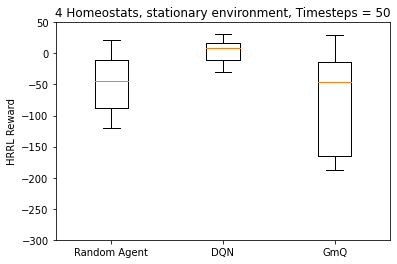

In [ ]:
## plotting

models = ['Random Agent','DQN','GmQ']
fig, ax = plt.subplots()
ax.boxplot([np.array(rand_score),np.array(score_mon),np.array(score_mod)],showfliers=False,whis=[10,100])
ax.set_ylabel('HRRL Reward')
# ax.set_xticks(range(3))
ax.set_xticklabels(models)
ax.set_title(f'4 Homeostats, stationary environment, Timesteps = {timesteps}')
# ax.yaxis.grid(True)
ax.set_ylim([-300,50])

## Animate

In [ ]:
import warnings
warnings.filterwarnings( "ignore")
hist = env.history
skip = 50
specifier = f'lr_{lr}_eps_{epsilon_decay}_mem_{memory_size}'
specifier = 'test_mon'
specifier = None

animate(hist[::skip],agent_mod,skip,specifier) # animate function is below this cell
# animate(hist[::skip],agent_mon,skip,specifier) # animate function is below this cell

In [ ]:
import matplotlib.mlab as mlab
import matplotlib.animation
from IPython.display import HTML
%pylab inline
from matplotlib import rc
rc('animation', html='jshtml')

# sometimes you have to re-run 'resources' cell, and re-import copy, after running this cell, for some unknown reason

def animate(history,agent,skip,file_specifier=None):
    frames = len(history)
    n_stats = env.n_stats
    ax_g = []
    ax_map = []
    mod = agent.is_modular
    filename = 'mod' if mod else 'mon'

    print("Rendering %d frames..." % frames)

    fig = plt.figure(figsize=(20, 16));
    grids = plt.GridSpec(3, n_stats, hspace=0.2, wspace=0.2);
    for stat in range(n_stats):
      ax_g.append(fig.add_subplot(grids[0,stat]));
      if mod: ax_map.append(fig.add_subplot(grids[1,stat]));
    if not mod: ax_map = fig.add_subplot(grids[1,:]);
    ax_h = fig.add_subplot(grids[2,:]);

    # fig_health.set_autoscale_on(False)
    health_plot = np.zeros((frames, n_stats));

    def render_frame(i):
        grid, visible, health = history[i]

        # Render grid

        for stat in range(n_stats):
          # rmin = grid[stat].min()
          # rmax = grid[stat].max()

          ax_g[stat].imshow(grid[stat]);
          ax_g[stat].set_title(f'Stat {stat}');
          ax_g[stat].set_xticks([]);
          ax_g[stat].set_yticks([]);

          if mod:
            value_map = agent.value_map_history[skip*i]
            # ax_map[stat].imshow(value_map[stat])
            display_grid_with_text(value_map[stat],ax_map[stat])
            # ax_map[stat].set_xticks([]);
            # ax_map[stat].set_yticks([]);
            ax_map[stat].set_title(f'Value map #{stat}')


          # ax_v[stat].matshow(visible[stat]);
          # ax_v[stat].set_xticks([]);
          # ax_v[stat].set_yticks([]);

        # Render health chart
        health_plot[i] = health;
        ax_h.clear();
        # ax_h.axis([0, frames, -10, 10]);
        ax_h.plot(health_plot[:i]);
        ax_h.set_xlabel('Timestep')
        ax_h.set_ylabel('Stat levels')

        if not mod:
          value_map = agent.value_map_history[skip*i]
          display_grid_with_text(value_map,ax_map)
          # ax_map.imshow(value_map)
          # ax_map.set_xticks([]);
          # ax_map.set_yticks([]);
          ax_map.set_title('Value map')

    anim = matplotlib.animation.FuncAnimation(
        fig, render_frame, frames=frames, interval=200
    )
    plt.close()

    # To save the animation, use e.g.
    #
    if file_specifier is not None: anim.save(parent_dir+filename+'movie_'+file_specifier+'.mp4')
    #
    # or
    #
    # writer = animation.FFMpegWriter(
    #     fps=15, metadata=dict(artist='Me'), bitrate=1800)
    # ani.save("movie.mp4", writer=writer)

    else: display(HTML(anim.to_html5_video()))
    # anim


def display_grid_with_text(grid,ax):
      grid = np.round(grid,2)
      # fig,ax = plt.subplots(figsize=(8,8))
      ax.clear()
      ax.imshow(grid)
      for (j,i),label in np.ndenumerate(grid):
          ax.text(i,j,label,ha='center',va='center',fontsize=10,color='r')
          ax.set_yticks([])
          ax.set_xticks([])
      # plt.show()


import copy

Populating the interactive namespace from numpy and matplotlib


## Animate rewards

In [ ]:
import warnings
warnings.filterwarnings( "ignore")
start = 15000
hist = env.history[start:start+100]
animate_rewards(hist,agent_mod,start) # animate function is below this cell
# animate(hist[::skip],agent_mon,skip,specifier) # animate function is below this cell

Rendering 100 frames...


In [ ]:
import matplotlib.mlab as mlab
import matplotlib.animation
from IPython.display import HTML
%pylab inline
from matplotlib import rc
rc('animation', html='jshtml')

# sometimes you have to re-run 'resources' cell, and re-import copy, after running this cell, for some unknown reason

def animate_rewards(history,agent,start):
    frames = len(history)
    n_stats = env.n_stats
    ax_g = []
    ax_map = []
    mod = agent.is_modular
    filename = 'mod' if mod else 'mon'

    print("Rendering %d frames..." % frames)

    fig = plt.figure(figsize=(10, 8));
    grids = plt.GridSpec(4, n_stats, hspace=0.2, wspace=0.2);
    for stat in range(n_stats):
      ax_g.append(fig.add_subplot(grids[0,stat]));
    ax_stat = fig.add_subplot(grids[1,:]);
    ax_h = fig.add_subplot(grids[2,:]);
    ax_h_sep = fig.add_subplot(grids[3,:]);


    def render_frame(i):
        grid, visible, health = history[i]

        # Render grid

        for stat in range(n_stats):
          # rmin = grid[stat].min()
          # rmax = grid[stat].max()

          ax_g[stat].imshow(grid[stat]);
          ax_g[stat].set_title(f'Stat {stat}');
          ax_g[stat].set_xticks([]);
          ax_g[stat].set_yticks([]);


          # ax_v[stat].matshow(visible[stat]);
          # ax_v[stat].set_xticks([]);
          # ax_v[stat].set_yticks([]);

        ax_stat.clear();
        # ax_stat.axis([0, frames, 0, 2]);
        ax_stat.plot(agent_mod.stats[start:start+i]);
        ax_stat.set_xlabel('Timestep')
        ax_stat.set_ylabel('Stat Levels')

        # Render health chart
        # health_plot[i] = health;
        ax_h.clear();
        # ax_h.axis([0, frames, -0.5, 1.5]);
        ax_h.plot(agent.rewards[:i],'grey');
        ax_h.set_xlabel('Timestep')
        ax_h.set_ylabel('Monolithic Reward')


        ax_h_sep.clear();
        # ax_h_sep.axis([0, frames, -0.5, 4]);
        ax_h_sep.plot(agent.mod_rewards[start:start+i]);
        ax_h_sep.set_xlabel('Timestep')
        ax_h_sep.set_ylabel('Modular Reward')


    anim = matplotlib.animation.FuncAnimation(
        fig, render_frame, frames=frames, interval=200
    )
    plt.close()


    display(HTML(anim.to_html5_video()))


import copy

Populating the interactive namespace from numpy and matplotlib


## workspace

In [ ]:
import numpy as np
length = 1000
subspace1 = 50
subspace2 = 100
answers1 = []
answers2 = []


for k in range(20):
  test1 = np.zeros(length)
  test2 = np.zeros(length)

  for i in range(k):
    sample1 = np.random.choice(range(length-1),subspace1,replace=False)
    sample2 = np.random.choice(range(length-1),subspace2,replace=False)

    test1[sample1]=1
    test2[sample2]=1

  answers1.append(sum(test1))
  answers2.append(sum(test2))


print(np.array(answers1),'\n',np.array(answers2))# answers2

[  0.  50.  98. 140. 188. 223. 263. 305. 336. 360. 403. 420. 455. 480.
 517. 525. 560. 577. 603. 626.] 
 [  0. 100. 189. 282. 345. 404. 463. 503. 558. 610. 659. 679. 715. 757.
 761. 783. 830. 828. 842. 865.]


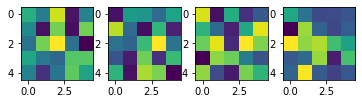

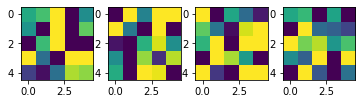

In [ ]:
from sklearn.preprocessing import normalize


q = np.random.randint(1,500,(4,5,5))
q_norm = (q - np.min(q,axis=0))/(np.max(q,axis=0) - np.min(q,axis=0) )

fig,axes=plt.subplots(1,4)
for i,ax in enumerate(axes):
  ax.imshow(q[i])


fig,axes=plt.subplots(1,4)
for i,ax in enumerate(axes):
  ax.imshow(q_norm[i])


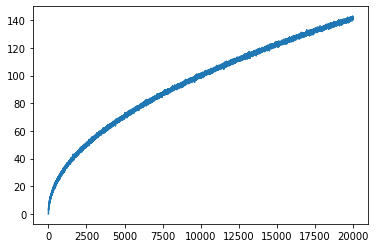

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

dist = []
for d in range(20000):
  mu = 0
  sigma = 1

  vec = np.random.uniform(0,1,d)
  noise = np.random.normal(u,sigma,d)
  new_vec = vec + noise

  dist.append(np.linalg.norm(new_vec-vec))

plt.plot(dist)


# Github GRACIAS

In [ ]:
import sys

parent_dir = '/content/gdrive/My Drive/Colab Notebooks/World/'

from google.colab import drive
drive.mount('/content/gdrive') 
save = True

sys.path.insert(0,parent_dir+'AAMAS21-375-main/qbert')

!pip install tensorboardX
!pip install Ipython --upgrade
%load_ext autoreload
%autoreload 2

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
     |████████████████████████████████| 124 kB 8.6 MB/s 
     |████████████████████████████████| 788 kB 8.3 MB/s 
     |████████████████████████████████| 374 kB 69.1 MB/s 
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: Ipython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.21 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipy

In [ ]:
import deep_rl
from deep_rl import*

import importlib
importlib.reload(deep_rl)
from deep_rl import*


def gmQ():
    config = Config()
    config.history_length = 4
    config.task_fn = env
    config.n_stats = env.n_stats
    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, lr=1e-3, alpha=0.95, eps=0.01)
    config.network_fn = lambda state_dim, action_dim: VanillaNet(action_dim, WorldFlatNetworkPhi(state_dim))
    # config.network_fn = lambda state_dim, action_dim: DuelingNet(action_dim, NatureConvBody())
    config.policy_fn = lambda: GreedyPolicy(LinearSchedule(1.0, 0.1, 1e6))
    config.replay_fn = lambda: Replay(memory_size=int(1e6), batch_size=512)
    config.state_normalizer = ImageNormalizer()
    config.reward_normalizer = SignNormalizer()
    config.discount = 0.99
    config.target_network_update_freq = 10000
    config.exploration_steps= 500
    config.logger = get_logger()
    config.double_q = True
    run_episodes(GmQAgent(config))


def dqn():
    config = Config()
    config.history_length = 1
    config.task_fn = env
    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, lr=0.00025, alpha=0.95, eps=0.01)
    config.network_fn = lambda state_dim, action_dim: VanillaNet(action_dim, WorldFlatNetworkPhi(state_dim)) 
    # config.network_fn = lambda state_dim, action_dim: DuelingNet(action_dim, NatureConvBody())
    config.policy_fn = lambda: GreedyPolicy(LinearSchedule(1.0, 0.1, 1e6))
    config.replay_fn = lambda: Replay(memory_size=int(1e6), batch_size=32)
    config.state_normalizer = ImageNormalizer()
    config.reward_normalizer = SignNormalizer()
    config.discount = 0.99
    config.target_network_update_freq = 10000
    config.exploration_steps= 50000
    config.logger = get_logger()
    # config.double_q = True
    config.double_q = True
    run_episodes(DQNAgent(config))

def ddpg_pixel():
    moduleConfig = Config()
    moduleConfig.history_length = 4
    moduleConfig.task_fn = env
                                        
    moduleConfig.optimizer_fn = lambda params: torch.optim.RMSprop(params, lr=0.00025, alpha=0.95, eps=0.01)
    moduleConfig.network_fn = lambda state_dim, action_dim: VanillaNet(action_dim, WorldFlatNetworkPhi(state_dim)) 
    moduleConfig.policy_fn = lambda: GreedyPolicy(LinearSchedule(1.0, 0.1, 1e6))
    moduleConfig.replay_fn = lambda: Replay(memory_size=int(1e6), batch_size=512)
    moduleConfig.state_normalizer = ImageNormalizer()
    moduleConfig.reward_normalizer = SignNormalizer()
    moduleConfig.discount = 0.99
    moduleConfig.target_network_update_freq = 1000
    moduleConfig.exploration_steps= 500
    moduleConfig.logger = get_logger()
    moduleConfig.double_q = True

    config = Config()
    config.n_stats = env.n_stats
    log_dir = get_default_log_dir(ddpg_pixel.__name__)
    config.task_fn = env #lambda: env_fn()
    # config.evaluation_env = env #config.task_fn()

    # phi_body=DDPGConvBody()
    phi_body = WorldFlatNetworkPhi(env.state_dim)
    config.network_fn = lambda state_dim, action_dim: DeterministicActorCriticNet(
        state_dim, action_dim, phi_body=phi_body,
        actor_body=FCBody(phi_body.feature_dim, (50, ), gate=F.tanh),
        critic_body=OneLayerFCBodyWithAction(phi_body.feature_dim, action_dim, 50, gate=F.tanh),
        actor_opt_fn=lambda params: torch.optim.Adam(params, lr=1e-4),
        critic_opt_fn=lambda params: torch.optim.Adam(params, lr=1e-3))

    config.replay_fn = lambda: Replay(memory_size=1000000, batch_size=256)
    config.discount = 0.99
    config.state_normalizer = ImageNormalizer()
    config.max_steps = 1e7
    config.random_process_fn = lambda action_dim: OrnsteinUhlenbeckProcess(
        size=(action_dim, ), std=LinearSchedule(0.2))
    config.min_memory_size = 64
    config.target_network_mix = 1e-3
    config.logger = get_logger(file_name=ddpg_pixel.__name__)
    run_episodes(GRACIAS(config, moduleConfig))


def plot():
    import matplotlib.pyplot as plt
    plotter = Plotter()
    names = plotter.load_log_dirs(pattern='.*')
    data = plotter.load_results(names)

    for i, name in enumerate(names):
        x, y = data[i]
        plt.plot(x, y, color=Plotter.COLORS[i], label=name)
    plt.legend()
    plt.xlabel('timesteps')
    plt.ylabel('episode return')
    plt.show()

def action_conditional_video_prediction():
    game = 'PongNoFrameskip-v4'
    prefix = '.'

    # Train an agent to generate the dataset
    # a2c_pixel_atari(game)

    # Generate a dataset with the trained model
    # a2c_model_file = './data/A2CAgent-vanilla-model-%s.bin' % (game)
    # generate_dataset(game, a2c_model_file, prefix)

    # Train the action conditional video prediction model
    acvp_train(game, prefix)


if __name__ == '__main__':
    # !mkdir data/video
    # !mkdir dataset
    # !mkdir log
    set_one_thread()
    select_device(0)

    '''
    Choose you agent here.
    '''

    ddpg_pixel()
    # dqn()

    plot()

SyntaxError: ignored

In [ ]:
sys.path.insert(0,parent_dir+'AAMAS21-375-main')

import bunny_world
from bunny_world import*

import importlib
importlib.reload(bunny_world)
from bunny_world import*

In [ ]:
# sys.path.insert(0,parent_dir+'AAMAS21-375-main/bunny_world')
# %cd bunny_world

!python -u pacman.py -p GmQ_Pre -x 2000 -n 2001 -l smallInitialGrid -g DirectionalGhost -q

python3: can't open file 'pacman.py': [Errno 2] No such file or directory


In [ ]:
def dqn_pixel_atari(name):
    config = Config()
    config.history_length = 4
    config.task_fn = lambda: PixelAtari(name, frame_skip=4, history_length=config.history_length,
                                        log_dir=get_default_log_dir(dqn_pixel_atari.__name__))
    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, lr=0.00025, alpha=0.95, eps=0.01)
    config.network_fn = lambda state_dim, action_dim: VanillaNet(action_dim, NatureConvBody())
    # config.network_fn = lambda state_dim, action_dim: DuelingNet(action_dim, NatureConvBody())
    config.policy_fn = lambda: GreedyPolicy(LinearSchedule(1.0, 0.1, 1e6))
    config.replay_fn = lambda: Replay(memory_size=int(1e6), batch_size=32)
    config.state_normalizer = ImageNormalizer()
    config.reward_normalizer = SignNormalizer()
    config.discount = 0.99
    config.target_network_update_freq = 10000
    config.exploration_steps= 50000
    config.logger = get_logger()
    # config.double_q = True
    config.double_q = True
    run_episodes(DQNAgent(config))

def ddpg_pixel():
    moduleConfig = Config()
    moduleConfig.history_length = 4
    moduleConfig.task_fn = lambda: PixelAtari('QbertNoFrameskip-v4', frame_skip=4, history_length=config.history_length,
                                        log_dir=get_default_log_dir(dqn_pixel_atari.__name__))
    moduleConfig.optimizer_fn = lambda params: torch.optim.RMSprop(params, lr=0.00025, alpha=0.95, eps=0.01)
    moduleConfig.network_fn = lambda state_dim, action_dim: VanillaNet(action_dim, NatureConvBody())
    moduleConfig.policy_fn = lambda: GreedyPolicy(LinearSchedule(1.0, 0.1, 1e6))
    moduleConfig.replay_fn = lambda: Replay(memory_size=int(1e6), batch_size=32)
    moduleConfig.state_normalizer = ImageNormalizer()
    moduleConfig.reward_normalizer = SignNormalizer()
    moduleConfig.discount = 0.99
    moduleConfig.target_network_update_freq = 10000
    moduleConfig.exploration_steps= 500
    moduleConfig.logger = get_logger()
    moduleConfig.double_q = True

    config = Config()
    log_dir = get_default_log_dir(ddpg_pixel.__name__)
    config.task_fn = lambda **kwargs: PixelAtari('QbertNoFrameskip-v4', frame_skip=1,
                                           history_length=4, log_dir=get_default_log_dir(ddpg_pixel.__name__))
    config.evaluation_env = config.task_fn(log_dir=log_dir)

    phi_body=DDPGConvBody()
    config.network_fn = lambda state_dim, action_dim: DeterministicActorCriticNet(
        state_dim, action_dim, phi_body=phi_body,
        actor_body=FCBody(phi_body.feature_dim, (50, ), gate=F.tanh),
        critic_body=OneLayerFCBodyWithAction(phi_body.feature_dim, action_dim, 50, gate=F.tanh),
        actor_opt_fn=lambda params: torch.optim.Adam(params, lr=1e-4),
        critic_opt_fn=lambda params: torch.optim.Adam(params, lr=1e-3))

    config.replay_fn = lambda: Replay(memory_size=1000000, batch_size=16)
    config.discount = 0.99
    config.state_normalizer = ImageNormalizer()
    config.max_steps = 1e7
    config.random_process_fn = lambda action_dim: OrnsteinUhlenbeckProcess(
        size=(action_dim, ), std=LinearSchedule(0.2))
    config.min_memory_size = 64
    config.target_network_mix = 1e-3
    config.logger = get_logger(file_name=ddpg_pixel.__name__)
    run_episodes(GRACIAS(config, moduleConfig))

if __name__ == '__main__':
    # !mkdir data/video
    # !mkdir dataset
    # !mkdir log
    set_one_thread()
    select_device(0)

    '''
    Choose you agent here.
    '''


    ddpg_pixel()

    plot()

Exception: ignored

In [ ]:
 config = Config()
log_dir = get_default_log_dir(ddpg_pixel.__name__)
config.task_fn = lambda: env_fn()
config.evaluation_env = config.task_fn()

# phi_body=DDPGConvBody()
phi_body = WorldFlatNetworkPhi(env.state_dim)
config.network_fn = lambda state_dim, action_dim: DeterministicActorCriticNet(
state_dim, action_dim, phi_body=phi_body,
actor_body=FCBody(phi_body.feature_dim, (50, ), gate=F.tanh),
critic_body=OneLayerFCBodyWithAction(phi_body.feature_dim, action_dim, 50, gate=F.tanh),
actor_opt_fn=lambda params: torch.optim.Adam(params, lr=1e-4),
critic_opt_fn=lambda params: torch.optim.Adam(params, lr=1e-3))




In [ ]:
a = config.network_fn(30,4)
state = env.get_state()
# x = torch.ones(16,512).to('cuda')
# ac = torch.ones(16,4).to('cuda')
# h = a.critic(x,ac)
a.predict(np.stack([state]), True).flatten()



/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


array([-6.1101018e-06, -6.4934015e-06,  1.5448913e-05,  3.5351743e-05],
      dtype=float32)

In [ ]:
state.shape

torch.Size([50])

In [ ]:
from ..network import *
from ..component import *
from .BaseAgent import *
import torchvision
from .DQN_module import *
from .rewardFunctions import *

class GRACIAS(BaseAgent):
    def __init__(self, config, moduleConfig):
        BaseAgent.__init__(self, config)
        self.moduleConfig = moduleConfig
        self.config = config
        self.numModules = 4
        self.modules = [DQNModule(self.moduleConfig) for i in range(self.numModules)]

        self.task = config.task_fn()

        self.network = config.network_fn(self.task.state_dim, 4)
        self.target_network = config.network_fn(self.task.state_dim, 4)
        self.target_network.load_state_dict(self.network.state_dict())
        self.replay = config.replay_fn()
        self.random_process = config.random_process_fn(4)
        self.total_steps = 0

    def get_final_action(self, action, state):
        finalQValues = action[0] * self.modules[0].get_q_values(state) + action[1] * self.modules[1].get_q_values(state) + action[2] * self.modules[2].get_q_values(state) + action[3] * self.modules[3].get_q_values(state)
        return np.argmax(finalQValues)


    def soft_update(self, target, src):
        for target_param, param in zip(target.parameters(), src.parameters()):
            target_param.detach_()
            target_param.copy_(target_param * (1.0 - self.config.target_network_mix) +
                                    param * self.config.target_network_mix)

    def evaluation_action(self, state):
        self.config.state_normalizer.set_read_only()
        state = np.stack([self.config.state_normalizer(state)])
        action = self.network.predict(state, to_numpy=True).flatten()
        self.config.state_normalizer.unset_read_only()
        return action

    def episode(self, deterministic=False):
        self.random_process.reset_states()
        state = self.task.reset()
        state = self.config.state_normalizer(state)

        config = self.config

        steps = 0
        total_reward = 0.0
        while True:

            action = self.network.predict(np.stack([state]), True).flatten()
            if not deterministic:
                action += self.random_process.sample()
            atariAction = self.get_final_action(action, state)
            next_state, reward, done, info = self.task.step(atariAction)
            next_state = self.config.state_normalizer(next_state)
            total_reward += reward
            reward = self.config.reward_normalizer(reward)

            if not deterministic:
                self.replay.feed([state, action, reward, next_state, int(done)])
                self.modules[0].update(state, atariAction, change_reward0(reward), next_state, done, deterministic)
                self.modules[1].update(state, atariAction, change_reward1(reward), next_state, done, deterministic)
                self.modules[2].update(state, atariAction, change_reward2(reward), next_state, done, deterministic)
                self.modules[3].update(state, atariAction, change_reward3(reward, done), next_state, done, deterministic)
                self.total_steps += 1

            steps += 1
            state = next_state

            if not deterministic and self.replay.size() >= config.min_memory_size:
                experiences = self.replay.sample()
                states, actions, rewards, next_states, terminals = experiences

                phi_next = self.target_network.feature(next_states)
                a_next = self.target_network.actor(phi_next)
                q_next = self.target_network.critic(phi_next, a_next)
                terminals = tensor(terminals).unsqueeze(1)
                rewards = tensor(rewards).unsqueeze(1)
                q_next = config.discount * q_next * (1 - terminals)
                q_next.add_(rewards)
                q_next = q_next.detach()
                phi = self.network.feature(states)
                q = self.network.critic(phi, tensor(actions))
                critic_loss = (q - q_next).pow(2).mul(0.5).sum(-1).mean()

                self.network.zero_grad()
                critic_loss.backward()
                self.network.critic_opt.step()

                phi = self.network.feature(states)
                action = self.network.actor(phi)
                policy_loss = -self.network.critic(phi.detach(), action).mean()

                self.network.zero_grad()
                policy_loss.backward()
                self.network.actor_opt.step()

                self.soft_update(self.target_network, self.network)

            if done:
                break

        return total_reward, steps

## Modified GRACIAS Files

In [ ]:
#######################################################################
# Copyright (C) 2017 Shangtong Zhang(zhangshangtong.cpp@gmail.com)    #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

from ..network import *
from ..component import *
from .BaseAgent import *
import torchvision
from .DQN_module import *
from .rewardFunctions import *

class GRACIAS(BaseAgent):
    def __init__(self, config, moduleConfig):
        BaseAgent.__init__(self, config)
        self.moduleConfig = moduleConfig
        self.config = config
        self.numModules = config.n_stats
        self.modules = [DQNModule(self.moduleConfig) for i in range(self.numModules)]
        self.task = config.task_fn
        self.network = config.network_fn(self.task.state_dim, self.numModules)
        self.target_network = config.network_fn(self.task.state_dim, self.numModules)
        self.target_network.load_state_dict(self.network.state_dict())
        self.replay = config.replay_fn()
        self.random_process = config.random_process_fn(self.numModules)
        self.total_steps = 0

    def get_final_action(self, action, state):
        finalQValues = sum(action[i] * self.modules[i].get_q_values(state) for i in range(self.numModules))
        # finalQValues = action[0] * self.modules[0].get_q_values(state) + action[1] * self.modules[1].get_q_values(state) + action[2] * self.modules[2].get_q_values(state) + action[3] * self.modules[3].get_q_values(state)
        return np.argmax(finalQValues)


    def soft_update(self, target, src):
        for target_param, param in zip(target.parameters(), src.parameters()):
            target_param.detach_()
            target_param.copy_(target_param * (1.0 - self.config.target_network_mix) +
                                    param * self.config.target_network_mix)

    def evaluation_action(self, state):
        self.config.state_normalizer.set_read_only()
        state = np.stack([self.config.state_normalizer(state)])
        action = self.network.predict(state, to_numpy=True).flatten()
        self.config.state_normalizer.unset_read_only()
        return action

    def episode(self, deterministic=False):
        self.random_process.reset_states()
        state = self.task.reset()
        state = self.config.state_normalizer(state)

        config = self.config
        steps = 0
        total_reward = 0.0
        while True:
            action = self.network.predict(np.stack([state]), True).flatten()
            if not deterministic:
                action += self.random_process.sample()
            atariAction = self.get_final_action(action, state)
            next_state, reward, done, info = self.task.step(atariAction)
            next_state = self.config.state_normalizer(next_state)
            total_reward += reward
            reward = self.config.reward_normalizer(reward)
            if not deterministic:
                self.replay.feed([state, action, reward, next_state, int(done)])
                (self.modules[i].update(state, atariAction, info[i], next_state, done, deterministic) for i in range(self.numModules))
                # self.modules[1].update(state, atariAction, info[1], next_state, done, deterministic)
                # self.modules[2].update(state, atariAction, info[2], next_state, done, deterministic)
                # self.modules[3].update(state, atariAction, info[3], next_state, done, deterministic)
                self.total_steps += 1


            steps += 1
            state = next_state

            if not deterministic and self.replay.size() >= config.min_memory_size:
                experiences = self.replay.sample()
                states, actions, rewards, next_states, terminals = experiences
                phi_next = self.target_network.feature(next_states)
                a_next = self.target_network.actor(phi_next)
                q_next = self.target_network.critic(phi_next, a_next)
                terminals = tensor(terminals).unsqueeze(1)
                rewards = tensor(rewards).unsqueeze(1)
                q_next = config.discount * q_next * (1 - terminals)
                q_next.add_(rewards)
                q_next = q_next.detach()
                phi = self.network.feature(states)
                q = self.network.critic(phi, tensor(actions))
                critic_loss = (q - q_next).pow(2).mul(0.5).sum(-1).mean()

                self.network.zero_grad()
                critic_loss.backward()
                self.network.critic_opt.step()

                phi = self.network.feature(states)
                action = self.network.actor(phi)
                policy_loss = -self.network.critic(phi.detach(), action).mean()

                self.network.zero_grad()
                policy_loss.backward()
                self.network.actor_opt.step()

                self.soft_update(self.target_network, self.network)

            if done:
                break

        return total_reward, steps, info


In [ ]:
#######################################################################
# Copyright (C) 2017 Shangtong Zhang(zhangshangtong.cpp@gmail.com)    #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

from ..network import *
from ..component import *
from ..utils import *
import time
from .BaseAgent import *

class DQNModule(BaseAgent):
    def __init__(self, config):
        BaseAgent.__init__(self, config)
        self.config = config
        self.task = config.task_fn
        self.network = config.network_fn(self.task.state_dim, self.task.action_dim)
        self.teacher = config.network_fn(self.task.state_dim, self.task.action_dim)
        self.target_network = config.network_fn(self.task.state_dim, self.task.action_dim)
        self.optimizer = config.optimizer_fn(self.network.parameters())
        self.criterion = nn.MSELoss()
        self.target_network.load_state_dict(self.network.state_dict())
        self.replay = config.replay_fn()
        self.policy = config.policy_fn()
        self.total_steps = 0
        self.intervalAsked = 0
        self.intervalGot = 0

    def get_q_values(self, state):
        myQvalues = self.network.predict(np.stack([self.config.state_normalizer(state)]), True).flatten()
        return myQvalues

    def own_select_action(self, state):
        eps = self.policy.epsilon(0)
        if np.random.uniform() < eps:
            action = np.random.randint(0, self.task.action_dim)
        else:
            q_values, asked,  got = self.get_final_q_values(state)
            self.intervalGot += got
            self.intervalAsked += asked
            action = np.argmax(q_values)
        return action


    def update(self, state, action, reward, next_state, done, deterministic):
        reward = self.config.reward_normalizer(reward)
        self.total_steps += 1
        if not deterministic:
            self.replay.feed([state, action, reward, next_state, int(done)])

        if self.total_steps % (self.config.test_interval * 25) == 0 and self.total_steps > 0:
            torch.save(self.network,self.task.name + "_"+str(self.total_steps)+".net")

        state = next_state
        if not deterministic and self.total_steps > self.config.exploration_steps \
                and self.total_steps % self.config.sgd_update_frequency == 0:
            experiences = self.replay.sample()
            states, actions, rewards, next_states, terminals = experiences
            states = self.config.state_normalizer(states)
            next_states = self.config.state_normalizer(next_states)
            q_next = self.target_network.predict(next_states, False).detach()
            if self.config.double_q:
                _, best_actions = self.network.predict(next_states).detach().max(1)
                q_next = q_next.gather(1, best_actions.unsqueeze(1)).squeeze(1)
            else:
                q_next, _ = q_next.max(1)
            terminals = tensor(terminals)
            rewards = tensor(rewards)
            q_next = self.config.discount * q_next * (1 - terminals)
            q_next.add_(rewards)
            actions = tensor(actions).unsqueeze(1).long()
            q = self.network.predict(states, False)
            q = q.gather(1, actions).squeeze(1)
            loss = self.criterion(q, q_next)
            self.optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(self.network.parameters(), self.config.gradient_clip)
            self.optimizer.step()

        self.evaluate()
        if not deterministic and self.total_steps % self.config.target_network_update_freq == 0:
            self.target_network.load_state_dict(self.network.state_dict())
        if not deterministic and self.total_steps > self.config.exploration_steps:
            self.policy.update_epsilon()


In [ ]:
#######################################################################
# Copyright (C) 2017 Shangtong Zhang(zhangshangtong.cpp@gmail.com)    #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

from .network_utils import *

class NatureConvBody(nn.Module):
    def __init__(self, in_channels=4):
        super(NatureConvBody, self).__init__()
        self.feature_dim = 512
        self.conv1 = layer_init(nn.Conv2d(in_channels, 32, kernel_size=8, stride=4))
        self.conv2 = layer_init(nn.Conv2d(32, 64, kernel_size=4, stride=2))
        self.conv3 = layer_init(nn.Conv2d(64, 64, kernel_size=3, stride=1))
        self.fc4 = layer_init(nn.Linear(7 * 7 * 64, self.feature_dim))

    def forward(self, x):
        y = F.relu(self.conv1(x))
        y = F.relu(self.conv2(y))
        y = F.relu(self.conv3(y))
        y = y.view(y.size(0), -1)
        y = F.relu(self.fc4(y))
        return y

class WorldFlatNetworkPhi(nn.Module):
    def __init__(self, in_dim, out_dim = 512):
        """Initialization."""
        super(WorldFlatNetworkPhi, self).__init__()
        self.h = 1048
        self.feature_dim = out_dim
        self.layers = nn.Sequential(
            nn.Linear(in_dim, self.h), 
            nn.ReLU(),
            nn.Linear(self.h, self.h), 
            nn.ReLU(), 
            nn.Linear(self.h, out_dim),
            nn.ReLU()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        return self.layers(x)

class DDPGConvBody(nn.Module):
    def __init__(self, in_channels=4):
        super(DDPGConvBody, self).__init__()
        self.feature_dim = 39 * 39 * 32
        self.conv1 = layer_init(nn.Conv2d(in_channels, 32, kernel_size=3, stride=2))
        self.conv2 = layer_init(nn.Conv2d(32, 32, kernel_size=3))

    def forward(self, x):
        y = F.elu(self.conv1(x))
        y = F.elu(self.conv2(y))
        y = y.view(y.size(0), -1)
        return y

class FCBody(nn.Module):
    def __init__(self, state_dim, hidden_units=(64, 64), gate=F.relu):
        super(FCBody, self).__init__()
        dims = (state_dim, ) + hidden_units
        self.layers = nn.ModuleList([layer_init(nn.Linear(dim_in, dim_out)) for dim_in, dim_out in zip(dims[:-1], dims[1:])])
        self.gate = gate
        self.feature_dim = dims[-1]

    def forward(self, x):
        for layer in self.layers:
            x = self.gate(layer(x))
        return x

class TwoLayerFCBodyWithAction(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_units=(64, 64), gate=F.relu):
        super(TwoLayerFCBodyWithAction, self).__init__()
        hidden_size1, hidden_size2 = hidden_units
        self.fc1 = layer_init(nn.Linear(state_dim, hidden_size1))
        self.fc2 = layer_init(nn.Linear(hidden_size1 + action_dim, hidden_size2))
        self.gate = gate
        self.feature_dim = hidden_size2

    def forward(self, x, action):
        x = self.gate(self.fc1(x))
        phi = self.gate(self.fc2(torch.cat([x, action], dim=1)))
        return phi

class OneLayerFCBodyWithAction(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_units, gate=F.relu):
        super(OneLayerFCBodyWithAction, self).__init__()
        self.fc_s = layer_init(nn.Linear(state_dim, hidden_units))
        self.fc_a = layer_init(nn.Linear(action_dim, hidden_units))
        self.gate = gate
        self.feature_dim = hidden_units * 2

    def forward(self, x, action):
        phi = self.gate(torch.cat([self.fc_s(x), self.fc_a(action)], dim=1))
        return phi

class DummyBody(nn.Module):
    def __init__(self, state_dim):
        super(DummyBody, self).__init__()
        self.feature_dim = state_dim

    def forward(self, x):
        return x

